<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/AIPI540_IP_fusion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

In [1]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [2]:
if COLAB_FLAG:
    !pip install pydicom==2.1.2
    !pip install monai seaborn sentence_transformers
    !git clone 'https://github.com/mille055/AIPI540_individual_project.git'

    


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime
from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
warnings.filterwarnings("ignore")

In [4]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'

### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from NLP.NLP_training import train_NLP_model
from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import CustomResNet50
from cnn.cnn_data_loaders import get_data_loaders
from metadata.meta_inference import meta_inference, calc_feature_importances
from metadata.meta_training import train_fit_parameter_trial, train_meta_model, evaluate_meta_model
from fusion_model.fus_model import FusionModel
from fusion_model.fus_inference import get_fusion_inference
from fusion_model.fus_training import train_fusion_model, CustomDataset
from model_container import ModelContainer
from process_tree import Processor


# Load Datasets


In [5]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile)



In [6]:
# prepares the features (preprocess normalizes/binarizes/ordinalizes the columns and limits to the feature set) and gets the labels
X_train_meta, scaler = preprocess(train_df, is_new_data=False)

X_val_meta, _ = preprocess(val_df, scaler)
X_test_meta, _ = preprocess(test_df, scaler)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
after rescaling step, the number of columns are 104
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
after rescaling step, the number of columns are 79
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.
after rescaling step, the number of columns are 86


## Get Inferences from Saved Models

In [7]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)

with open('../models/metadata_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)



In [8]:
scaler.columns

['SliceThickness',
 'RepetitionTime',
 'EchoTime',
 'EchoTrainLength',
 'PixelSpacing',
 'InversionTime']

In [9]:
Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, scaler, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, scaler, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, scaler, meta_model, feats_to_keep)

Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.


AttributeError: 'RandomForestClassifier' object has no attribute 'columns'

In [9]:

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.64      0.64      0.64        61
           6       0.23      0.82      0.35        17
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.93      0.96        28
          19       0.66      0.91      0.76        23
          23       0.00      0.00      0.00        20
          25       0.87      0.83      0.85        47

    accuracy                           0.78       432
   macro avg       0.76   

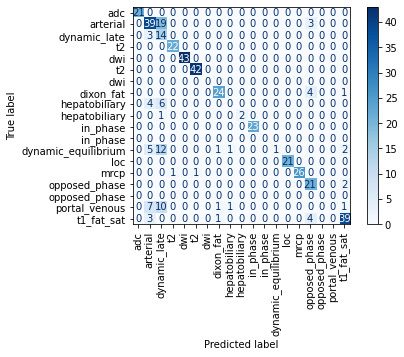

<Figure size 1800x1800 with 0 Axes>

In [10]:
f = display_and_save_results(meta_test_results_df.preds, meta_test_results_df.true, fn='meta', saveflag=False)


Preprocessing metadata for Random Forest classifier.
Have received 432 entries.
accuracy is 0.7662037037037037
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.58      0.64      0.61        61
           6       0.23      0.82      0.35        17
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.96      0.98        28
          19       0.70      0.70      0.70        23
          23       0.50      0.05      0.09        20
          25       0.73 

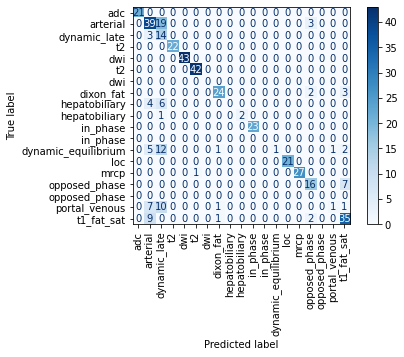

<Figure size 1800x1800 with 0 Axes>

In [11]:
## just checking to make sure the saved model is better than vanilla RF
from sklearn.ensemble import RandomForestClassifier
vanilla_model = RandomForestClassifier(min_samples_leaf=2)
vanilla_model.fit(X_train_meta[feats_to_keep], y_train)
vanillapreds, vanillaprobs, vanillay, vanillaacc = meta_inference(test_df, vanilla_model, feats_to_keep)
print('accuracy is', vanillaacc)
vanilla_results_df = make_results_df(vanillapreds, vanillaprobs, TEy, test_df)
f= display_and_save_results(vanilla_results_df.preds, vanilla_results_df.true, saveflag=False)
print(vanilla_model.get_params())

It shows no significant change in the overall accuracy compared with the default parameters...

### Getting pixel inference results

In [11]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pix = CustomResNet50(19)

# Load the saved state dictionary
saved_state_dict = torch.load('../models/pixel_model_041623.pth', map_location=device)

# Modify the keys to add the 'resnet50.' prefix
modified_state_dict = {f'resnet50.{k}': v for k, v in saved_state_dict.items()}

# Load the modified state dictionary into the current model
model_pix.load_state_dict(modified_state_dict)
model_pix = model_pix.to(device)


In [12]:

#pixel_train_preds, pixel_train_probs = pixel_inference(model_pix, train_df.fname.tolist())
#pixel_val_preds, pixel_val_probs = pixel_inference(model_pix, val_df.fname.to_list())
pixel_test_preds, pixel_test_probs = pixel_inference(model_pix, test_df.fname.to_list())

In [13]:
#pixel_train_results_df = make_results_df(pixel_train_preds, pixel_train_probs, Ty, train_df)
#pixel_val_results_df = make_results_df(pixel_val_preds, pixel_val_probs, Vy, val_df)
pixel_test_results_df = make_results_df(pixel_test_preds, pixel_test_probs, TEy, test_df)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.83      0.85      0.84        61
           6       0.89      1.00      0.94        17
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        43
           9       1.00      0.98      0.99        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       1.00      0.33      0.50         3
          14       1.00      0.83      0.90        23
          16       0.57      0.36      0.44        22
          17       1.00      0.95      0.98        21
          18       1.00      1.00      1.00        28
          19       0.81      0.96      0.88        23
          23       0.42      0.75      0.54        20
          25       0.90      0.91      0.91        47

    accuracy                           0.88       432
   macro avg       0.84   

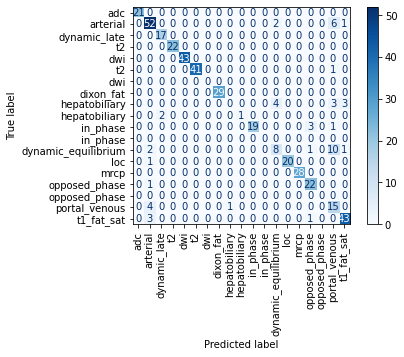

<Figure size 1800x1800 with 0 Axes>

In [14]:
f = display_and_save_results(pixel_test_results_df.preds, pixel_test_results_df.true, fn='pixel', saveflag=False)

### Getting NLP inference


In [15]:
# Load the pickled model
with open('../models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [16]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
senttrans_model = SentenceTransformer(sentence_encoder, device=device)



In [17]:
from NLP.NLP_training import train_NLP_model
train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, text_model_T = train_NLP_model(train_df, val_df, test_df, senttrans_model=senttrans_model)
print(train_acc, val_acc, test_acc)

Accuracy on the training set is 0.953
size of preds_val is  354
Accuracy on the val set is 0.960
Accuracy on the test set is 0.963
0.9525200876552228 0.96045197740113 0.9629629629629629


In [18]:
# testing on a single row
get_NLP_inference(NLP_model, filenames = [train_df.fname[0]])

NameError: name 'get_NLP_inference' is not defined

In [ ]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test_df.fname.tolist())
# #nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train_df.fname.tolist())
# #nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val_df.fname.tolist())


/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli

In [ ]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [ ]:
# nlp_train_results_df = make_results_df(nlp_train_preds, nlp_train_probs, Ty, train_df)
# nlp_val_results_df = make_results_df(nlp_val_preds, nlp_val_probs, Vy, val_df)
nlp_test_results_df = make_results_df(nlp_test_preds, nlp_test_probs, TEy, test_df)

# #change names of preds, probs 
# for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
# #    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)


In [23]:
# #change names of preds, probs 
# for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
#     frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)

# for frame_df in [pixel_train_results_df, pixel_val_results_df, pixel_test_results_df]:
#     frame_df.rename(columns={'preds':'pixel_preds', 'probs':'pixel_probs'}, inplace=True)

# for frame_df in [meta_train_results_df, meta_val_results_df, meta_test_results_df]:
#     frame_df.rename(columns={'preds':'meta_preds', 'probs':'meta_probs'}, inplace=True)


## Create fusion model

In [24]:
# fusion_train_df = pixel_train_results_df.copy()
# fusion_train_df[['meta_preds', 'meta_probs']] = meta_train_results_df[['meta_preds', 'meta_probs']]
# fusion_train_df[['nlp_preds', 'nlp_probs']] = nlp_train_results_df[['nlp_preds', 'nlp_probs']]


In [25]:
# fusion_val_df = pixel_val_results_df.copy()
# fusion_val_df[['meta_preds', 'meta_probs']] = meta_val_results_df[['meta_preds', 'meta_probs']]
# fusion_val_df[['nlp_preds', 'nlp_probs']] = nlp_val_results_df[['nlp_preds', 'nlp_probs']]


In [26]:
# fusion_test_df = pixel_test_results_df.copy()
# fusion_test_df[['meta_preds', 'meta_probs']] = meta_test_results_df[['meta_preds', 'meta_probs']]
# fusion_test_df[['nlp_preds', 'nlp_probs']] = nlp_test_results_df[['nlp_preds', 'nlp_probs']]


In [19]:
# loading the data back from pickled dataframes
with open('../data/fusion_train.pkl', 'rb') as file:
    ftrain = pickle.load(file)

with open('../data/fusion_val.pkl', 'rb') as file:
    fval = pickle.load(file)

with open('../data/fusion_test.pkl', 'rb') as file:
    ftest = pickle.load(file)


#adjust the labels to consecutive numbers 0-18 and storing the original labels into 'class'
ftest['class'] = ftest['true']
ftrain['class'] = ftrain['true']
fval['class'] = fval['true']

ftest['true'] = ftest['true'].apply(lambda x: classes.index(x))
ftrain['true'] = ftrain['true'].apply(lambda x: classes.index(x))
fval['true'] = fval['true'].apply(lambda x: classes.index(x))

#sanity check
#print(set(ftest['true'].tolist()))

# get model container for the base models
model_container=ModelContainer()

#  Instantiate FusionModel
fusion_model = FusionModel(model_container, pretrained=False)
fusion_model_no_nlp = FusionModel(model_container, pretrained=False, include_nlp=False) 


# Define the loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)
p_optimizer = optim.Adam(fusion_model_no_nlp.parameters(), lr=0.001)


train_dataset = CustomDataset(ftrain)
val_dataset = CustomDataset(fval)
test_dataset = CustomDataset(ftest)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)




In [ ]:

# already have the trained model with all 3 modalities

#trained_model, training_history_with_nlp = train_fusion_model(fusion_model, train_loader, val_loader, test_loader, device, optimizer, loss_fn = criterion, num_epochs=30, include_nlp=True)
   
# save trained model
#model_weights_path = '../models/fusion_model_weights_new.pth'
#torch.save(trained_model.state_dict(), model_weights_path)

In [12]:
# already have the trained model, will get from storage
# 
# trained_model_no_nlp, training_history_without_nlp = train_fusion_model(fusion_model_no_nlp, train_loader, val_loader, test_loader, device, p_optimizer, loss_fn=criterion, num_epochs=30, include_nlp=False)
 

Epoch 1/30
----------
Train Loss: 2.8686 Acc: 0.1731
Validation Loss: 2.8173 Acc: 0.3362
Epoch 2/30
----------
Train Loss: 2.7288 Acc: 0.3784
Validation Loss: 2.7027 Acc: 0.4294
Epoch 3/30
----------
Train Loss: 2.5926 Acc: 0.5968
Validation Loss: 2.5906 Acc: 0.5847
Epoch 4/30
----------
Train Loss: 2.4601 Acc: 0.8174
Validation Loss: 2.4823 Acc: 0.7542
Epoch 5/30
----------
Train Loss: 2.3314 Acc: 0.8634
Validation Loss: 2.3774 Acc: 0.7627
Epoch 6/30
----------
Train Loss: 2.2067 Acc: 0.9218
Validation Loss: 2.2758 Acc: 0.7853
Epoch 7/30
----------
Train Loss: 2.0859 Acc: 0.9642
Validation Loss: 2.1785 Acc: 0.8446
Epoch 8/30
----------
Train Loss: 1.9697 Acc: 0.9715
Validation Loss: 2.0844 Acc: 0.8418
Epoch 9/30
----------
Train Loss: 1.8577 Acc: 0.9737
Validation Loss: 1.9943 Acc: 0.8446
Epoch 10/30
----------
Train Loss: 1.7506 Acc: 0.9744
Validation Loss: 1.9077 Acc: 0.8418
Epoch 11/30
----------
Train Loss: 1.6481 Acc: 0.9752
Validation Loss: 1.8253 Acc: 0.8503
Epoch 12/30
-------

In [25]:
# # performance still high without the NLP portion of the model? saving it here
# model_weights_path_no_nlp = '../models/fusion_model_weights_no_nlp042223.pth'
# torch.save(trained_model_no_nlp.state_dict(), model_weights_path_no_nlp)


In [20]:


# Instantiate your model
model_container = ModelContainer()
Fmodel = FusionModel(model_container)
Fmodel_no_nlp = FusionModel(model_container, include_nlp=False)

# Load the saved state_dict (model weights)
saved_model_weights = torch.load('../models/fusion_model_weights042223.pth')
saved_model_weights_no_nlp = torch.load('../models/fusion_model_weights_no_nlp042223.pth')

# Load the state_dict into the model
Fmodel.load_state_dict(saved_model_weights)
Fmodel_no_nlp.load_state_dict(saved_model_weights_no_nlp)

# Set the model to evaluation mode
Fmodel.eval()

predictions = []
probs = []

predictions_nn = []
probs_nn = []

for index, row in X_test_meta.iterrows():
    pred, prob, ts_df = Fmodel.get_fusion_inference(row)
    predictions.append(pred)
    probs.append(prob)
    display(ts_df)
    
    pred_nn, prob_nn, ts_df_nn = Fmodel_no_nlp.get_fusion_inference(row)
    predictions_nn.append(pred_nn)
    probs_nn.append(prob_nn)
    display(ts_df_nn)

comparison_fusion_df = pd.DataFrame({'preds': predictions, 'probs': probs, 'preds_no_nlp': predictions_nn, 'probs_no_nlp': probs_nn, 'true': TEy})
comparison_fusion_df



/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.03796778940987547, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9349175895879057, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.295001e-06, 2.578496e-06, 1.8719749e-06, 2.8697045e-07, 0.99953854, 0.00040204258, 1.5188455e-06, 8.767868e-06, 2.662448e-06, 4.322713e-06, 1.3077367e-06, 8.2568744e-07, 3.3850504e-06, 3.8551866e-06, 1.1364865e-05, 3.0179904e-06, 9.71883e-07, 5.705652e-07, 6.8958543e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.03796778940987547, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9349175895879057, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.295001e-06, 2.578496e-06, 1.8719749e-06, 2.8697045e-07, 0.99953854, 0.00040204258, 1.5188455e-06, 8.767868e-06, 2.662448e-06, 4.322713e-06, 1.3077367e-06, 8.2568744e-07, 3.3850504e-06, 3.8551866e-06, 1.1364865e-05, 3.0179904e-06, 9.71883e-07, 5.705652e-07, 6.8958543e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.03796778940987547, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9349175895879057, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.795655e-06, 3.770518e-07, 1.3306848e-06, 5.689621e-07, 0.9995364, 0.0003611391, 1.9206557e-06, 3.9058295e-06, 2.2699937e-06, 3.9697256e-06, 5.5909913e-06, 9.766242e-07, 6.6248626e-06, 4.1079275e-06, 1.0245201e-05, 1.4333797e-05, 9.86798e-07, 6.653021e-07, 3.6801826e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.03796778940987547, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9349175895879057, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.795655e-06, 3.770518e-07, 1.3306848e-06, 5.689621e-07, 0.9995364, 0.0003611391, 1.9206557e-06, 3.9058295e-06, 2.2699937e-06, 3.9697256e-06, 5.5909913e-06, 9.766242e-07, 6.6248626e-06, 4.1079275e-06, 1.0245201e-05, 1.4333797e-05, 9.86798e-07, 6.653021e-07, 3.6801826e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [1.4107886e-05, 0.009412477, 0.000283724, 1.147452e-05, 3.020429e-06, 8.3037565e-05, 2.6172e-05, 0.0008685461, 0.44172925, 0.00080890214, 7.562098e-07, 1.7238099e-05, 0.007698984, 6.6420864e-07, 0.00042543033, 1.4503964e-05, 2.8027009e-05, 0.5307724, 0.007801279]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [1.4107886e-05, 0.009412477, 0.000283724, 1.147452e-05, 3.020429e-06, 8.3037565e-05, 2.6172e-05, 0.0008685461, 0.44172925, 0.00080890214, 7.562098e-07, 1.7238099e-05, 0.007698984, 6.6420864e-07, 0.00042543033, 1.4503964e-05, 2.8027009e-05, 0.5307724, 0.007801279]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.1229727e-05, 0.96127504, 0.0002816821, 2.5572648e-05, 0.0001317571, 0.00037823513, 0.000110510875, 9.951904e-05, 0.0015253774, 0.00052956917, 2.1635897e-05, 5.766712e-05, 0.0008997822, 0.00018510778, 0.000101403326, 0.00051098154, 5.2422998e-05, 0.015924666, 0.017837906]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.1229727e-05, 0.96127504, 0.0002816821, 2.5572648e-05, 0.0001317571, 0.00037823513, 0.000110510875, 9.951904e-05, 0.0015253774, 0.00052956917, 2.1635897e-05, 5.766712e-05, 0.0008997822, 0.00018510778, 0.000101403326, 0.00051098154, 5.2422998e-05, 0.015924666, 0.017837906]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.6286433e-06, 0.00254133, 1.713046e-06, 9.33486e-07, 5.632052e-06, 2.3475435e-05, 3.287764e-06, 1.35773425e-05, 0.0001314873, 1.2296571e-05, 1.4450553e-05, 1.3575317e-06, 3.3450021e-06, 7.9834435e-06, 4.035416e-06, 4.494417e-05, 1.602744e-06, 1.5534356e-06, 0.9971853]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.6286433e-06, 0.00254133, 1.713046e-06, 9.33486e-07, 5.632052e-06, 2.3475435e-05, 3.287764e-06, 1.35773425e-05, 0.0001314873, 1.2296571e-05, 1.4450553e-05, 1.3575317e-06, 3.3450021e-06, 7.9834435e-06, 4.035416e-06, 4.494417e-05, 1.602744e-06, 1.5534356e-06, 0.9971853]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.4858542e-07, 1.3944149e-06, 5.365589e-08, 5.054587e-07, 8.248665e-06, 2.4669955e-06, 2.3279466e-07, 0.9999603, 1.0592011e-05, 1.085961e-06, 2.4710669e-06, 1.8446862e-07, 1.9030675e-06, 9.825049e-08, 1.7861902e-06, 4.7143662e-06, 2.1216236e-07, 5.7296543e-08, 3.3253293e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.4858542e-07, 1.3944149e-06, 5.365589e-08, 5.054587e-07, 8.248665e-06, 2.4669955e-06, 2.3279466e-07, 0.9999603, 1.0592011e-05, 1.085961e-06, 2.4710669e-06, 1.8446862e-07, 1.9030675e-06, 9.825049e-08, 1.7861902e-06, 4.7143662e-06, 2.1216236e-07, 5.7296543e-08, 3.3253293e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.9039195320372213, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.07593557881975094, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.9999124, 8.644132e-07, 4.1674693e-06, 1.5017147e-06, 1.2229859e-05, 1.8659845e-06, 1.7308366e-06, 7.355428e-06, 1.3346449e-05, 2.4829755e-05, 2.4677408e-06, 1.9661752e-06, 3.1061993e-06, 6.4109094e-07, 1.5114763e-06, 2.7018648e-06, 3.0156575e-06, 2.6132497e-07, 4.064056e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.9039195320372213, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.07593557881975094, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.9999124, 8.644132e-07, 4.1674693e-06, 1.5017147e-06, 1.2229859e-05, 1.8659845e-06, 1.7308366e-06, 7.355428e-06, 1.3346449e-05, 2.4829755e-05, 2.4677408e-06, 1.9661752e-06, 3.1061993e-06, 6.4109094e-07, 1.5114763e-06, 2.7018648e-06, 3.0156575e-06, 2.6132497e-07, 4.064056e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [4.8201482e-08, 9.029056e-07, 5.6486847e-06, 5.2168507e-06, 3.2712333e-07, 1.1116515e-06, 2.1120368e-07, 6.3484975e-08, 2.2133586e-08, 2.4589508e-06, 5.6412496e-08, 1.3270682e-07, 4.7495274e-09, 0.9999709, 5.4859784e-06, 1.5686788e-06, 1.1590182e-07, 9.2110064e-08, 5.6169533e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [4.8201482e-08, 9.029056e-07, 5.6486847e-06, 5.2168507e-06, 3.2712333e-07, 1.1116515e-06, 2.1120368e-07, 6.3484975e-08, 2.2133586e-08, 2.4589508e-06, 5.6412496e-08, 1.3270682e-07, 4.7495274e-09, 0.9999709, 5.4859784e-06, 1.5686788e-06, 1.1590182e-07, 9.2110064e-08, 5.6169533e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.008210472152726188, 0.0, 0.9816437597303708, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005468779220299146, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [9.5372826e-08, 1.2610706e-06, 1.0824099e-06, 2.5871228e-07, 2.9384746e-05, 0.9999522, 1.8124405e-07, 3.4696523e-08, 5.092261e-07, 1.5357218e-06, 1.5848632e-07, 1.6971525e-07, 3.0002466e-06, 1.784411e-07, 4.0300065e-06, 1.2921355e-07, 1.9319104e-07, 5.2199975e-06, 4.8019785e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.008210472152726188, 0.0, 0.9816437597303708, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005468779220299146, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [9.5372826e-08, 1.2610706e-06, 1.0824099e-06, 2.5871228e-07, 2.9384746e-05, 0.9999522, 1.8124405e-07, 3.4696523e-08, 5.092261e-07, 1.5357218e-06, 1.5848632e-07, 1.6971525e-07, 3.0002466e-06, 1.784411e-07, 4.0300065e-06, 1.2921355e-07, 1.9319104e-07, 5.2199975e-06, 4.8019785e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.0960929e-06, 1.733317e-05, 0.9955279, 7.927474e-06, 2.3324606e-06, 9.5335076e-07, 6.55902e-06, 3.77972e-06, 7.337363e-05, 0.004045486, 1.4235295e-07, 4.8583593e-06, 5.719722e-06, 0.00022403136, 1.8720619e-05, 1.3102543e-05, 5.6710132e-06, 3.4643454e-05, 5.3880012e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.018180995621155008]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.0960929e-06, 1.733317e-05, 0.9955279, 7.927474e-06, 2.3324606e-06, 9.5335076e-07, 6.55902e-06, 3.77972e-06, 7.337363e-05, 0.004045486, 1.4235295e-07, 4.8583593e-06, 5.719722e-06, 0.00022403136, 1.8720619e-05, 1.3102543e-05, 5.6710132e-06, 3.4643454e-05, 5.3880012e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [3.549188e-08, 3.7779992e-07, 5.4678313e-08, 5.1557414e-08, 5.6707268e-06, 0.9999821, 7.940806e-08, 3.751007e-08, 1.2519996e-06, 2.7087188e-07, 2.1879546e-07, 6.993516e-08, 1.165276e-06, 1.8653386e-08, 2.2465758e-06, 5.4343733e-08, 7.01144e-08, 9.0425056e-07, 5.246496e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [3.549188e-08, 3.7779992e-07, 5.4678313e-08, 5.1557414e-08, 5.6707268e-06, 0.9999821, 7.940806e-08, 3.751007e-08, 1.2519996e-06, 2.7087188e-07, 2.1879546e-07, 6.993516e-08, 1.165276e-06, 1.8653386e-08, 2.2465758e-06, 5.4343733e-08, 7.01144e-08, 9.0425056e-07, 5.246496e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.181784e-06, 9.558735e-06, 4.9363973e-07, 1.0129651e-06, 2.1243193e-05, 6.3452608e-06, 3.5562066e-06, 0.00027443204, 2.4549481e-05, 1.2323459e-05, 4.1937034e-05, 3.291737e-06, 3.9607577e-05, 4.1617564e-06, 5.476818e-07, 0.9992399, 1.6983414e-06, 0.00018955152, 0.00012160115]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601526]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.181784e-06, 9.558735e-06, 4.9363973e-07, 1.0129651e-06, 2.1243193e-05, 6.3452608e-06, 3.5562066e-06, 0.00027443204, 2.4549481e-05, 1.2323459e-05, 4.1937034e-05, 3.291737e-06, 3.9607577e-05, 4.1617564e-06, 5.476818e-07, 0.9992399, 1.6983414e-06, 0.00018955152, 0.00012160115]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.2390334e-07, 4.2283756e-07, 3.1028455e-06, 1.1910398e-06, 4.109489e-06, 7.0674037e-06, 7.98006e-07, 1.3044247e-05, 1.9186878e-05, 7.680729e-06, 3.614463e-07, 3.128397e-07, 1.1411324e-06, 3.2692745e-07, 0.9999355, 3.8818797e-08, 3.1195486e-07, 3.120553e-06, 2.033435e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.2390334e-07, 4.2283756e-07, 3.1028455e-06, 1.1910398e-06, 4.109489e-06, 7.0674037e-06, 7.98006e-07, 1.3044247e-05, 1.9186878e-05, 7.680729e-06, 3.614463e-07, 3.128397e-07, 1.1411324e-06, 3.2692745e-07, 0.9999355, 3.8818797e-08, 3.1195486e-07, 3.120553e-06, 2.033435e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.638245e-06, 7.088912e-05, 6.7269257e-06, 7.9581923e-07, 1.2741252e-06, 4.423574e-06, 2.4205642e-06, 2.8946167e-06, 0.00020587504, 2.8337896e-05, 1.0495442e-06, 1.8711521e-06, 6.27477e-05, 1.7503859e-06, 1.3427024e-06, 0.00021596826, 1.3279963e-06, 0.00017332417, 0.9992155]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.638245e-06, 7.088912e-05, 6.7269257e-06, 7.9581923e-07, 1.2741252e-06, 4.423574e-06, 2.4205642e-06, 2.8946167e-06, 0.00020587504, 2.8337896e-05, 1.0495442e-06, 1.8711521e-06, 6.27477e-05, 1.7503859e-06, 1.3427024e-06, 0.00021596826, 1.3279963e-06, 0.00017332417, 0.9992155]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.4470477e-07, 0.9994867, 1.735146e-06, 1.7388808e-07, 1.339383e-06, 8.250354e-07, 1.0374467e-06, 1.0489592e-06, 3.1453572e-05, 3.4612672e-06, 1.2311921e-07, 4.568195e-07, 3.8711305e-06, 1.4735729e-06, 1.1837013e-06, 2.1650517e-06, 3.9779127e-07, 0.00044486127, 1.729068e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.4470477e-07, 0.9994867, 1.735146e-06, 1.7388808e-07, 1.339383e-06, 8.250354e-07, 1.0374467e-06, 1.0489592e-06, 3.1453572e-05, 3.4612672e-06, 1.2311921e-07, 4.568195e-07, 3.8711305e-06, 1.4735729e-06, 1.1837013e-06, 2.1650517e-06, 3.9779127e-07, 0.00044486127, 1.729068e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/2/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.457012e-06, 9.507358e-06, 0.00032831778, 0.99901974, 8.822444e-06, 3.1219155e-05, 1.0141148e-05, 6.343911e-06, 2.5610852e-06, 0.00031122795, 5.142372e-06, 1.3416669e-05, 1.1547641e-05, 0.00015840567, 1.8598694e-05, 1.44588275e-05, 1.3969102e-05, 3.177957e-05, 2.9740303e-07]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/2/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.457012e-06, 9.507358e-06, 0.00032831778, 0.99901974, 8.822444e-06, 3.1219155e-05, 1.0141148e-05, 6.343911e-06, 2.5610852e-06, 0.00031122795, 5.142372e-06, 1.3416669e-05, 1.1547641e-05, 0.00015840567, 1.8598694e-05, 1.44588275e-05, 1.3969102e-05, 3.177957e-05, 2.9740303e-07]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [9.801646e-07, 0.99477345, 4.9379278e-06, 7.7416075e-07, 1.621831e-06, 6.260305e-07, 3.1570291e-06, 7.814914e-06, 0.00035351253, 1.4734242e-05, 2.2429354e-07, 1.2012824e-06, 8.726677e-06, 3.7020986e-06, 3.2123894e-06, 1.3441932e-05, 1.2032912e-06, 0.0047882684, 1.8573975e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [9.801646e-07, 0.99477345, 4.9379278e-06, 7.7416075e-07, 1.621831e-06, 6.260305e-07, 3.1570291e-06, 7.814914e-06, 0.00035351253, 1.4734242e-05, 2.2429354e-07, 1.2012824e-06, 8.726677e-06, 3.7020986e-06, 3.2123894e-06, 1.3441932e-05, 1.2032912e-06, 0.0047882684, 1.8573975e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.8043127e-06, 2.6069582e-05, 8.887527e-08, 1.0290203e-05, 2.3338822e-05, 0.0006747499, 3.9535394e-06, 7.0959686e-05, 8.108833e-06, 8.4337335e-06, 0.99741554, 3.9229485e-06, 0.0007713772, 2.5381316e-06, 1.4852116e-05, 0.0009313955, 3.0945243e-06, 1.4266423e-05, 1.5096825e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.8043127e-06, 2.6069582e-05, 8.887527e-08, 1.0290203e-05, 2.3338822e-05, 0.0006747499, 3.9535394e-06, 7.0959686e-05, 8.108833e-06, 8.4337335e-06, 0.99741554, 3.9229485e-06, 0.0007713772, 2.5381316e-06, 1.4852116e-05, 0.0009313955, 3.0945243e-06, 1.4266423e-05, 1.5096825e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.1406862e-05, 0.18996224, 0.00018048794, 4.5280512e-06, 1.3691329e-05, 8.815725e-06, 2.6702015e-05, 0.00015009395, 0.08574592, 0.00043870474, 4.893756e-07, 1.2770707e-05, 0.00057520217, 3.8416356e-06, 0.00012728314, 0.00014217511, 1.6258111e-05, 0.715647, 0.0069323997]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.1406862e-05, 0.18996224, 0.00018048794, 4.5280512e-06, 1.3691329e-05, 8.815725e-06, 2.6702015e-05, 0.00015009395, 0.08574592, 0.00043870474, 4.893756e-07, 1.2770707e-05, 0.00057520217, 3.8416356e-06, 0.00012728314, 0.00014217511, 1.6258111e-05, 0.715647, 0.0069323997]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.5667271e-06, 2.7319424e-05, 6.6809736e-07, 1.0604762e-05, 0.00010687361, 0.9997521, 1.888169e-06, 6.2628004e-07, 2.9984708e-06, 4.561665e-06, 4.819521e-06, 1.7093066e-06, 3.0815825e-06, 4.2502725e-06, 9.397378e-06, 2.5491972e-06, 1.2915733e-06, 4.162603e-06, 5.943184e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.5667271e-06, 2.7319424e-05, 6.6809736e-07, 1.0604762e-05, 0.00010687361, 0.9997521, 1.888169e-06, 6.2628004e-07, 2.9984708e-06, 4.561665e-06, 4.819521e-06, 1.7093066e-06, 3.0815825e-06, 4.2502725e-06, 9.397378e-06, 2.5491972e-06, 1.2915733e-06, 4.162603e-06, 5.943184e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/35/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.6189233161507206, 0.23712731468602258, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.005743717136784854, 0.024282575021072207, 0.010489124509333484, 0.00012871042896986178, 0.0, 0.049287975819456764, 0.008917573744357338, 0.00018446238122733186, 0.009403573189087314, 0.0, 0.025789361192410338, 0.009713505690893149]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [3.3559975e-06, 0.98775184, 5.1595553e-06, 3.74774e-06, 5.2103154e-05, 2.5807818e-05, 1.23764685e-05, 1.4521107e-05, 1.6708082e-05, 2.6156096e-05, 3.066447e-05, 5.7986827e-06, 1.2831929e-05, 0.00014876449, 1.5646427e-05, 6.1133054e-05, 4.0737164e-06, 2.9485598e-05, 0.011779779]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/35/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.6189233161507206, 0.23712731468602258, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.005743717136784854, 0.024282575021072207, 0.010489124509333484, 0.00012871042896986178, 0.0, 0.049287975819456764, 0.008917573744357338, 0.00018446238122733186, 0.009403573189087314, 0.0, 0.025789361192410338, 0.009713505690893149]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [3.3559975e-06, 0.98775184, 5.1595553e-06, 3.74774e-06, 5.2103154e-05, 2.5807818e-05, 1.23764685e-05, 1.4521107e-05, 1.6708082e-05, 2.6156096e-05, 3.066447e-05, 5.7986827e-06, 1.2831929e-05, 0.00014876449, 1.5646427e-05, 6.1133054e-05, 4.0737164e-06, 2.9485598e-05, 0.011779779]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/34/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.009550954726452728, 0.0, 0.9804443805854575, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005327675791485826, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [4.854783e-08, 2.2361316e-06, 8.3202764e-07, 2.1802306e-07, 7.148977e-06, 0.9999647, 1.6355028e-07, 2.9270089e-08, 7.3185976e-07, 1.043688e-06, 1.15801555e-07, 1.3244427e-07, 9.71984e-07, 1.5404738e-07, 5.809026e-07, 1.665257e-07, 1.5233387e-07, 3.852081e-06, 1.6734097e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/34/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.009550954726452728, 0.0, 0.9804443805854575, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005327675791485826, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [4.854783e-08, 2.2361316e-06, 8.3202764e-07, 2.1802306e-07, 7.148977e-06, 0.9999647, 1.6355028e-07, 2.9270089e-08, 7.3185976e-07, 1.043688e-06, 1.15801555e-07, 1.3244427e-07, 9.71984e-07, 1.5404738e-07, 5.809026e-07, 1.665257e-07, 1.5233387e-07, 3.852081e-06, 1.6734097e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/40 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06120282068780213, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9116825583099792, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.8499204e-06, 3.987987e-06, 3.0561867e-07, 4.5433288e-07, 0.9997838, 0.00014605916, 1.4397283e-06, 1.2859789e-06, 7.599681e-07, 1.5487329e-06, 7.903078e-06, 7.1616205e-07, 3.058798e-06, 1.0375291e-05, 2.3969683e-06, 6.130173e-06, 6.4635026e-07, 7.077557e-07, 2.2559767e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/40 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06120282068780213, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9116825583099792, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.8499204e-06, 3.987987e-06, 3.0561867e-07, 4.5433288e-07, 0.9997838, 0.00014605916, 1.4397283e-06, 1.2859789e-06, 7.599681e-07, 1.5487329e-06, 7.903078e-06, 7.1616205e-07, 3.058798e-06, 1.0375291e-05, 2.3969683e-06, 6.130173e-06, 6.4635026e-07, 7.077557e-07, 2.2559767e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/27/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.006508395654014391, 0.028413534555061296, 0.0, 0.0, 0.0, 0.0, 0.06859464634263558, 0.0, 0.004665228395297536, 0.0, 0.0, 0.0279656027649138, 0.003959579294699938, 0.0, 0.0048704200178731, 0.0, 0.00047622407224495554, 0.8545463689032594]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.6320702e-07, 8.086607e-07, 9.778334e-08, 4.7349852e-07, 1.339674e-07, 4.6812987e-05, 4.5638683e-07, 9.056363e-07, 2.0127238e-05, 2.027824e-06, 6.0235427e-05, 3.489718e-07, 3.84747e-06, 5.8722685e-07, 1.7076757e-06, 1.5495163e-05, 2.3811907e-07, 7.1492735e-07, 0.99984455]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004379492686017157, 0.021417479064071203, 0.0199912513696002, 0.0051999599030155465, 0.0045470623301177284, 0.0019091516149858235, 0.0009667398642715213, 0.08741557081917052, 0.009811687062392604, 0.006704713648299851, 0.03311248337947338, 0.0009826191666302074, 0.054008774228498, 0.01253858676909194, 0.004797026913468499, 0.02209113028385551, 0.0009820284558181031, 0.006478305410185057, 0.7026659370310371]   

                 SeriesD  
0  vibe dixon 9-14 pre_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/27/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.006508395654014391, 0.028413534555061296, 0.0, 0.0, 0.0, 0.0, 0.06859464634263558, 0.0, 0.004665228395297536, 0.0, 0.0, 0.0279656027649138, 0.003959579294699938, 0.0, 0.0048704200178731, 0.0, 0.00047622407224495554, 0.8545463689032594]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.6320702e-07, 8.086607e-07, 9.778334e-08, 4.7349852e-07, 1.339674e-07, 4.6812987e-05, 4.5638683e-07, 9.056363e-07, 2.0127238e-05, 2.027824e-06, 6.0235427e-05, 3.489718e-07, 3.84747e-06, 5.8722685e-07, 1.7076757e-06, 1.5495163e-05, 2.3811907e-07, 7.1492735e-07, 0.99984455]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004379492686017157, 0.021417479064071203, 0.0199912513696002, 0.0051999599030155465, 0.0045470623301177284, 0.0019091516149858235, 0.0009667398642715213, 0.08741557081917052, 0.009811687062392604, 0.006704713648299851, 0.03311248337947338, 0.0009826191666302074, 0.054008774228498, 0.01253858676909194, 0.004797026913468499, 0.02209113028385551, 0.0009820284558181031, 0.006478305410185057, 0.7026659370310371]   

                 SeriesD  
0  vibe dixon 9-14 pre_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/29/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275247, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.0314131e-05, 0.00024689455, 6.478094e-07, 2.9989833e-05, 5.250991e-05, 7.9407386e-05, 2.4412484e-05, 0.0015573982, 0.00012010998, 6.720489e-05, 0.9926455, 1.6068147e-05, 0.00083323097, 1.8896646e-05, 0.000102602644, 0.003922353, 1.5579992e-05, 3.0841587e-05, 0.00020612055]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/29/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.0314131e-05, 0.00024689455, 6.478094e-07, 2.9989833e-05, 5.250991e-05, 7.9407386e-05, 2.4412484e-05, 0.0015573982, 0.00012010998, 6.720489e-05, 0.9926455, 1.6068147e-05, 0.00083323097, 1.8896646e-05, 0.000102602644, 0.003922353, 1.5579992e-05, 3.0841587e-05, 0.00020612055]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/42/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.2671810885118603, 0.4823190693101763, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.04944233722553353, 0.01514277541615465, 0.00024616753257884256, 0.0, 0.08987673513512393, 2.0028355974824096e-05, 0.0003840931521153112, 0.00024616753257884256, 0.0, 0.07726169225553524, 0.0175549426862329]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.9026009e-05, 0.0005025919, 8.393308e-05, 7.3048336e-06, 5.906896e-06, 1.24525495e-05, 1.5383739e-05, 0.0005215886, 0.009624934, 0.00020051832, 9.039017e-05, 1.5313772e-05, 0.97684026, 1.1954453e-06, 7.199684e-05, 4.1568594e-05, 2.003139e-05, 0.0076452116, 0.0042804684]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/42/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.26718108851186034, 0.4823190693101763, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.04944233722553353, 0.01514277541615465, 0.00024616753257884256, 0.0, 0.08987673513512393, 2.0028355974824096e-05, 0.0003840931521153112, 0.00024616753257884256, 0.0, 0.07726169225553524, 0.0175549426862329]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.9026009e-05, 0.0005025919, 8.393308e-05, 7.3048336e-06, 5.906896e-06, 1.24525495e-05, 1.5383739e-05, 0.0005215886, 0.009624934, 0.00020051832, 9.039017e-05, 1.5313772e-05, 0.97684026, 1.1954453e-06, 7.199684e-05, 4.1568594e-05, 2.003139e-05, 0.0076452116, 0.0042804684]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/45/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.09629635783472346, 0.058257860851021574, 0.0, 0.0, 0.0, 0.0, 0.08012279647668379, 0.007835183626280964, 0.014797322875301557, 0.0, 0.0, 0.2047879840083077, 0.0043550789395293416, 0.0, 0.0035299374441465593, 0.0, 0.019342682686321735, 0.5106747952576831]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.7027392e-05, 0.0011625357, 0.00010937434, 2.2952008e-05, 1.8064363e-06, 0.009866624, 2.372464e-05, 0.00017384793, 0.016168974, 0.00019674037, 0.00023706604, 2.0125895e-05, 0.9349246, 2.1705928e-06, 0.00044431427, 4.621003e-06, 2.9218507e-05, 0.012698601, 0.023895798]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0073296395194917124, 0.03215188309755457, 0.03850666301627137, 0.010942795406903336, 0.0065423871776410965, 0.00283948620215301, 0.0016552300920577893, 0.12895613588124166, 0.01723925228197102, 0.01112863269172721, 0.04799849293781586, 0.0016451710650858997, 0.3116027935043609, 0.01728676766424133, 0.011865240126309823, 0.06591561985719326, 0.0016441797464616377, 0.010851447493922464, 0.2738981822375961]   

                  SeriesD  
0  vibe dixon 9-14 post_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/45/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.09629635783472346, 0.058257860851021574, 0.0, 0.0, 0.0, 0.0, 0.08012279647668379, 0.007835183626280964, 0.014797322875301557, 0.0, 0.0, 0.2047879840083077, 0.0043550789395293416, 0.0, 0.0035299374441465593, 0.0, 0.019342682686321735, 0.5106747952576831]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.7027392e-05, 0.0011625357, 0.00010937434, 2.2952008e-05, 1.8064363e-06, 0.009866624, 2.372464e-05, 0.00017384793, 0.016168974, 0.00019674037, 0.00023706604, 2.0125895e-05, 0.9349246, 2.1705928e-06, 0.00044431427, 4.621003e-06, 2.9218507e-05, 0.012698601, 0.023895798]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0073296395194917124, 0.03215188309755457, 0.03850666301627137, 0.010942795406903336, 0.0065423871776410965, 0.00283948620215301, 0.0016552300920577893, 0.12895613588124166, 0.01723925228197102, 0.01112863269172721, 0.04799849293781586, 0.0016451710650858997, 0.3116027935043609, 0.01728676766424133, 0.011865240126309823, 0.06591561985719326, 0.0016441797464616377, 0.010851447493922464, 0.2738981822375961]   

                  SeriesD  
0  vibe dixon 9-14 post_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/28/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [6.409234e-06, 8.748946e-06, 1.1329483e-07, 6.9483553e-07, 9.425637e-06, 2.0877494e-07, 2.8002112e-06, 7.429367e-05, 2.9860673e-06, 9.304655e-06, 0.00013509722, 2.0894236e-06, 1.0164205e-06, 3.507447e-05, 7.434391e-07, 0.9991597, 1.086792e-06, 3.449052e-06, 0.0005467187]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/28/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [6.409234e-06, 8.748946e-06, 1.1329483e-07, 6.9483553e-07, 9.425637e-06, 2.0877494e-07, 2.8002112e-06, 7.429367e-05, 2.9860673e-06, 9.304655e-06, 0.00013509722, 2.0894236e-06, 1.0164205e-06, 3.507447e-05, 7.434391e-07, 0.9991597, 1.086792e-06, 3.449052e-06, 0.0005467187]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.6967608e-08, 1.5220088e-07, 4.6696576e-07, 3.3980373e-06, 8.0377015e-07, 1.7840704e-06, 1.4349818e-07, 1.0556501e-07, 9.969595e-09, 1.003087e-06, 2.1827151e-07, 8.571921e-08, 1.3930821e-09, 0.9999802, 3.4644956e-06, 2.0727578e-06, 7.579512e-08, 9.27664e-09, 6.042246e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.6967608e-08, 1.5220088e-07, 4.6696576e-07, 3.3980373e-06, 8.0377015e-07, 1.7840704e-06, 1.4349818e-07, 1.0556501e-07, 9.969595e-09, 1.003087e-06, 2.1827151e-07, 8.571921e-08, 1.3930821e-09, 0.9999802, 3.4644956e-06, 2.0727578e-06, 7.579512e-08, 9.27664e-09, 6.042246e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/26/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0024163962184281075, 0.02096888734394026, 0.0, 0.0, 0.0, 0.0, 0.8167097458307725, 0.0, 0.007189936648804999, 0.0035695135963232476, 0.0, 0.06890470282516077, 0.003364611260053619, 0.0, 0.005015609948585819, 0.0, 0.00040567235783829544, 0.07145492397009255]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [3.5362152e-07, 5.8822028e-08, 1.0387102e-08, 6.412091e-08, 4.0643073e-08, 5.986655e-07, 3.160773e-08, 0.9996729, 0.00029756528, 7.066244e-07, 1.7576262e-07, 2.2447034e-08, 2.1385443e-07, 1.6378642e-09, 2.5611751e-05, 6.2363132e-09, 3.6112656e-08, 5.3373384e-08, 1.5810114e-06]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.005743339110039934, 0.025582080857973175, 0.021860638204074398, 0.0073254085421082605, 0.006028840028349782, 0.0033457871448358796, 0.0011809393928655524, 0.3814993685730207, 0.0113002887467698, 0.008212626030773698, 0.04065247272437361, 0.0012459804232127622, 0.04706829090503861, 0.015077405434855307, 0.006020002889058598, 0.025552092937389016, 0.0012452487246280757, 0.009427983147910856, 0.38163120618272206]   

                 SeriesD  
0  vibe dixon 9-14 pre_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/26/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0024163962184281075, 0.02096888734394026, 0.0, 0.0, 0.0, 0.0, 0.8167097458307725, 0.0, 0.007189936648804999, 0.0035695135963232476, 0.0, 0.06890470282516077, 0.003364611260053619, 0.0, 0.005015609948585819, 0.0, 0.00040567235783829544, 0.07145492397009255]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [3.5362152e-07, 5.8822028e-08, 1.0387102e-08, 6.412091e-08, 4.0643073e-08, 5.986655e-07, 3.160773e-08, 0.9996729, 0.00029756528, 7.066244e-07, 1.7576262e-07, 2.2447034e-08, 2.1385443e-07, 1.6378642e-09, 2.5611751e-05, 6.2363132e-09, 3.6112656e-08, 5.3373384e-08, 1.5810114e-06]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.005743339110039934, 0.025582080857973175, 0.021860638204074398, 0.0073254085421082605, 0.006028840028349782, 0.0033457871448358796, 0.0011809393928655524, 0.3814993685730207, 0.0113002887467698, 0.008212626030773698, 0.04065247272437361, 0.0012459804232127622, 0.04706829090503861, 0.015077405434855307, 0.006020002889058598, 0.025552092937389016, 0.0012452487246280757, 0.009427983147910856, 0.38163120618272206]   

                 SeriesD  
0  vibe dixon 9-14 pre_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/44/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0787641415495917, 0.037686254141736014, 0.0, 0.0, 0.0, 0.0, 0.5806852341494242, 0.008208826178099917, 0.04268849616881224, 0.0013941018766756032, 0.0, 0.17755909769543823, 0.005038725052129878, 0.0, 0.002840198228938175, 0.0, 0.017146029576093253, 0.04798889538306087]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.269378e-07, 4.4198696e-06, 6.668587e-08, 1.7360492e-07, 1.8417477e-07, 2.6208174e-06, 2.9691054e-07, 0.9963548, 0.003408864, 4.0877385e-06, 2.8314304e-07, 1.6399991e-07, 2.361021e-06, 6.4635732e-09, 0.00020757638, 3.7303074e-08, 2.3211129e-07, 3.4804661e-06, 9.552429e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.006492147637474464, 0.02463769965579622, 0.02650061923653897, 0.010455989044218421, 0.006041626782976196, 0.003514837240181123, 0.0013225670359189963, 0.5302817118938123, 0.012504947009296153, 0.008758798657189386, 0.03990611702492784, 0.001374677219450726, 0.17984843926491934, 0.01280645060426722, 0.010194193821529416, 0.051102263773091225, 0.0013738722808434396, 0.010426765470586534, 0.06245627634698196]   

                  SeriesD  
0  vibe dixon 9-14 post_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/44/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0787641415495917, 0.037686254141736014, 0.0, 0.0, 0.0, 0.0, 0.5806852341494242, 0.008208826178099917, 0.04268849616881224, 0.0013941018766756032, 0.0, 0.17755909769543823, 0.005038725052129878, 0.0, 0.002840198228938175, 0.0, 0.017146029576093253, 0.04798889538306087]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.269378e-07, 4.4198696e-06, 6.668587e-08, 1.7360492e-07, 1.8417477e-07, 2.6208174e-06, 2.9691054e-07, 0.9963548, 0.003408864, 4.0877385e-06, 2.8314304e-07, 1.6399991e-07, 2.361021e-06, 6.4635732e-09, 0.00020757638, 3.7303074e-08, 2.3211129e-07, 3.4804661e-06, 9.552429e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.006492147637474464, 0.02463769965579622, 0.02650061923653897, 0.010455989044218421, 0.006041626782976196, 0.003514837240181123, 0.0013225670359189963, 0.5302817118938123, 0.012504947009296153, 0.008758798657189386, 0.03990611702492784, 0.001374677219450726, 0.17984843926491934, 0.01280645060426722, 0.010194193821529416, 0.051102263773091225, 0.0013738722808434396, 0.010426765470586534, 0.06245627634698196]   

                  SeriesD  
0  vibe dixon 9-14 post_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/43/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [4.722788e-08, 6.319667e-08, 0.9995203, 1.2213684e-06, 7.673401e-09, 2.2399815e-08, 1.09739645e-07, 2.6457633e-07, 7.530943e-07, 0.00047331682, 9.33916e-10, 8.97901e-08, 6.621708e-07, 1.1553288e-06, 1.4502698e-06, 2.0363156e-08, 1.39299e-07, 2.038458e-07, 1.7398499e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/43/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [4.722788e-08, 6.319667e-08, 0.9995203, 1.2213684e-06, 7.673401e-09, 2.2399815e-08, 1.09739645e-07, 2.6457633e-07, 7.530943e-07, 0.00047331682, 9.33916e-10, 8.97901e-08, 6.621708e-07, 1.1553288e-06, 1.4502698e-06, 2.0363156e-08, 1.39299e-07, 2.038458e-07, 1.7398499e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/38/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.2671810885118603, 0.4823190693101763, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.04944233722553353, 0.01514277541615465, 0.00024616753257884256, 0.0, 0.08987673513512391, 2.0028355974824096e-05, 0.0003840931521153112, 0.00024616753257884256, 0.0, 0.07726169225553524, 0.0175549426862329]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00011685951, 0.26775813, 0.00024674105, 3.4998957e-05, 0.00063952996, 4.502011e-05, 0.00020618689, 0.002241892, 0.07878823, 0.0013781653, 8.209025e-05, 0.00010326545, 0.07585323, 4.6667166e-05, 0.0012979178, 0.0005716549, 0.00014336933, 0.562281, 0.0081649665]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/38/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.26718108851186034, 0.4823190693101763, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.04944233722553353, 0.015142775416154653, 0.00024616753257884256, 0.0, 0.08987673513512393, 2.0028355974824096e-05, 0.0003840931521153112, 0.00024616753257884256, 0.0, 0.07726169225553522, 0.0175549426862329]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00011685951, 0.26775813, 0.00024674105, 3.4998957e-05, 0.00063952996, 4.502011e-05, 0.00020618689, 0.002241892, 0.07878823, 0.0013781653, 8.209025e-05, 0.00010326545, 0.07585323, 4.6667166e-05, 0.0012979178, 0.0005716549, 0.00014336933, 0.562281, 0.0081649665]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/36/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.6189233161507206, 0.23712731468602258, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.005743717136784854, 0.024282575021072207, 0.010489124509333484, 0.00012871042896986178, 0.0, 0.049287975819456764, 0.008917573744357338, 0.00018446238122733186, 0.009403573189087314, 0.0, 0.025789361192410338, 0.009713505690893149]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.5311186e-07, 0.9999758, 1.141856e-07, 1.6496837e-07, 1.2497228e-06, 3.9004448e-07, 3.4000078e-07, 4.0534619e-07, 3.853972e-06, 5.175333e-07, 2.478328e-07, 1.3591519e-07, 2.7832453e-07, 1.5037648e-06, 3.2865057e-07, 3.3036858e-07, 1.2662744e-07, 6.7470523e-06, 7.1680697e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/36/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.6189233161507206, 0.2371273146860226, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.005743717136784854, 0.024282575021072207, 0.010489124509333484, 0.00012871042896986178, 0.0, 0.049287975819456764, 0.008917573744357338, 0.00018446238122733186, 0.009403573189087314, 0.0, 0.025789361192410338, 0.009713505690893149]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.5311186e-07, 0.9999758, 1.141856e-07, 1.6496837e-07, 1.2497228e-06, 3.9004448e-07, 3.4000078e-07, 4.0534619e-07, 3.853972e-06, 5.175333e-07, 2.478328e-07, 1.3591519e-07, 2.7832453e-07, 1.5037648e-06, 3.2865057e-07, 3.3036858e-07, 1.2662744e-07, 6.7470523e-06, 7.1680697e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/31/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.5099103e-05, 0.0003989666, 1.258702e-06, 6.543847e-06, 2.7278955e-05, 4.5338777e-05, 8.773252e-06, 5.2775482e-05, 1.4431372e-05, 2.0120631e-05, 0.0002474029, 5.4529405e-06, 2.990137e-06, 9.3528535e-05, 1.200515e-05, 0.0009905756, 3.55945e-06, 7.5178303e-07, 0.9980532]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/31/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.5099103e-05, 0.0003989666, 1.258702e-06, 6.543847e-06, 2.7278955e-05, 4.5338777e-05, 8.773252e-06, 5.2775482e-05, 1.4431372e-05, 2.0120631e-05, 0.0002474029, 5.4529405e-06, 2.990137e-06, 9.3528535e-05, 1.200515e-05, 0.0009905756, 3.55945e-06, 7.5178303e-07, 0.9980532]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/40 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06120282068780213, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9116825583099792, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.4153421e-06, 2.5319616e-06, 1.0831905e-07, 4.861403e-07, 0.99992025, 4.9604732e-05, 6.7059347e-07, 1.6515746e-06, 5.4629874e-07, 8.3708824e-07, 4.09528e-06, 3.1640903e-07, 1.0497287e-06, 3.7506964e-06, 3.1489772e-06, 1.394911e-06, 3.2508348e-07, 1.3161481e-07, 7.582383e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/40 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06120282068780213, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9116825583099792, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.4153421e-06, 2.5319616e-06, 1.0831905e-07, 4.861403e-07, 0.99992025, 4.9604732e-05, 6.7059347e-07, 1.6515746e-06, 5.4629874e-07, 8.3708824e-07, 4.09528e-06, 3.1640903e-07, 1.0497287e-06, 3.7506964e-06, 3.1489772e-06, 1.394911e-06, 3.2508348e-07, 1.3161481e-07, 7.582383e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/30/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.0316036e-07, 2.259971e-06, 1.7290343e-08, 4.9685497e-08, 1.4709111e-06, 5.052475e-08, 5.4957194e-08, 0.9999826, 8.689121e-06, 5.163989e-07, 2.462982e-07, 2.4969333e-08, 7.85571e-08, 1.7778227e-08, 1.1832252e-06, 9.515931e-08, 4.2507658e-08, 9.067993e-09, 2.2435602e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/30/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.0316036e-07, 2.259971e-06, 1.7290343e-08, 4.9685497e-08, 1.4709111e-06, 5.052475e-08, 5.4957194e-08, 0.9999826, 8.689121e-06, 5.163989e-07, 2.462982e-07, 2.4969333e-08, 7.85571e-08, 1.7778227e-08, 1.1832252e-06, 9.515931e-08, 4.2507658e-08, 9.067993e-09, 2.2435602e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/37/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.6189233161507206, 0.23712731468602258, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.005743717136784854, 0.024282575021072207, 0.010489124509333484, 0.00012871042896986178, 0.0, 0.049287975819456764, 0.008917573744357338, 0.00018446238122733186, 0.009403573189087314, 0.0, 0.025789361192410338, 0.009713505690893149]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [6.79725e-08, 0.99996877, 1.1966442e-07, 5.666007e-08, 9.839662e-07, 1.4894921e-07, 1.7092067e-07, 2.7816176e-07, 1.709527e-06, 2.626149e-07, 6.198832e-08, 8.533211e-08, 1.8136074e-06, 5.573147e-07, 3.2722278e-07, 1.1230758e-07, 7.1416736e-08, 2.1221073e-05, 3.261366e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/37/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.6189233161507206, 0.23712731468602258, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.005743717136784854, 0.024282575021072207, 0.010489124509333484, 0.00012871042896986178, 0.0, 0.049287975819456764, 0.008917573744357338, 0.00018446238122733186, 0.009403573189087314, 0.0, 0.025789361192410338, 0.009713505690893149]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [6.79725e-08, 0.99996877, 1.1966442e-07, 5.666007e-08, 9.839662e-07, 1.4894921e-07, 1.7092067e-07, 2.7816176e-07, 1.709527e-06, 2.626149e-07, 6.198832e-08, 8.533211e-08, 1.8136074e-06, 5.573147e-07, 3.2722278e-07, 1.1230758e-07, 7.1416736e-08, 2.1221073e-05, 3.261366e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/39/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [3.0482058e-06, 1.7005491e-06, 1.0032633e-05, 4.2533416e-06, 6.4362366e-06, 1.1984163e-05, 4.0596005e-06, 2.30988e-05, 5.4044554e-05, 3.2499564e-05, 2.6445416e-06, 1.723135e-06, 4.8858556e-06, 6.908541e-07, 0.9998197, 2.8706128e-07, 1.6912866e-06, 1.1129529e-05, 6.1813034e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/39/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [3.0482058e-06, 1.7005491e-06, 1.0032633e-05, 4.2533416e-06, 6.4362366e-06, 1.1984163e-05, 4.0596005e-06, 2.30988e-05, 5.4044554e-05, 3.2499564e-05, 2.6445416e-06, 1.723135e-06, 4.8858556e-06, 6.908541e-07, 0.9998197, 2.8706128e-07, 1.6912866e-06, 1.1129529e-05, 6.1813034e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/41/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8574494694813678, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.12240564137560427, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.9998553, 2.9966332e-06, 1.2294692e-05, 2.0119307e-06, 4.2121756e-05, 9.523512e-07, 3.0718536e-06, 1.6211801e-06, 6.725259e-06, 3.5855443e-05, 3.367914e-06, 2.3333844e-06, 3.040533e-06, 1.5367904e-06, 2.6350588e-06, 2.261119e-06, 3.7146006e-06, 1.8522024e-07, 1.7952181e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/41/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8574494694813678, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.12240564137560427, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.9998553, 2.9966332e-06, 1.2294692e-05, 2.0119307e-06, 4.2121756e-05, 9.523512e-07, 3.0718536e-06, 1.6211801e-06, 6.725259e-06, 3.5855443e-05, 3.367914e-06, 2.3333844e-06, 3.040533e-06, 1.5367904e-06, 2.6350588e-06, 2.261119e-06, 3.7146006e-06, 1.8522024e-07, 1.7952181e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/2/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.8075826e-06, 1.0707402e-07, 0.00051905593, 0.9991898, 3.3821962e-07, 5.2353244e-06, 1.6928053e-06, 6.0895827e-06, 7.4990515e-07, 0.00023262983, 1.9309475e-07, 1.4684517e-06, 4.950918e-06, 3.505989e-06, 2.724743e-05, 7.1959454e-07, 2.7527037e-06, 1.6333169e-06, 2.3303693e-07]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/2/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.8075826e-06, 1.0707402e-07, 0.00051905593, 0.9991898, 3.3821962e-07, 5.2353244e-06, 1.6928053e-06, 6.0895827e-06, 7.4990515e-07, 0.00023262983, 1.9309475e-07, 1.4684517e-06, 4.950918e-06, 3.505989e-06, 2.724743e-05, 7.1959454e-07, 2.7527037e-06, 1.6333169e-06, 2.3303693e-07]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.13777417567314437, 0.30001640572331, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006407692327633087, 0.008836229066483733, 0.0010363938197072214, 0.0, 0.041652677289886156, 0.0031459480079674682, 0.004494253590207204, 0.016468229690789767, 0.0, 0.03540582718205801, 0.44402052957279114]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.6054622e-06, 4.9630653e-05, 5.373815e-07, 8.2881013e-07, 6.755103e-06, 7.1033395e-07, 2.0518764e-06, 4.8826196e-06, 0.000115740135, 1.0604925e-05, 2.6733773e-05, 1.1839355e-06, 1.4396024e-05, 2.8577904e-06, 3.3892338e-06, 0.0004223827, 1.0113921e-06, 5.52768e-06, 0.999328]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.13777417567314437, 0.30001640572331, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006407692327633087, 0.008836229066483733, 0.0010363938197072214, 0.0, 0.041652677289886156, 0.0031459480079674682, 0.004494253590207204, 0.016468229690789767, 0.0, 0.03540582718205801, 0.44402052957279114]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.6054622e-06, 4.9630653e-05, 5.373815e-07, 8.2881013e-07, 6.755103e-06, 7.1033395e-07, 2.0518764e-06, 4.8826196e-06, 0.000115740135, 1.0604925e-05, 2.6733773e-05, 1.1839355e-06, 1.4396024e-05, 2.8577904e-06, 3.3892338e-06, 0.0004223827, 1.0113921e-06, 5.52768e-06, 0.999328]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/20/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.3159315e-07, 5.333929e-07, 0.99951124, 4.449015e-06, 4.507092e-07, 1.8715693e-07, 6.99128e-07, 1.3161456e-07, 1.8580047e-06, 0.0004468799, 6.657569e-09, 6.183166e-07, 6.934763e-07, 2.7996595e-05, 6.853245e-07, 5.2190813e-07, 6.946897e-07, 9.1945014e-07, 1.1084721e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/20/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.3159315e-07, 5.333929e-07, 0.99951124, 4.449015e-06, 4.507092e-07, 1.8715693e-07, 6.99128e-07, 1.3161456e-07, 1.8580047e-06, 0.0004468799, 6.657569e-09, 6.183166e-07, 6.934763e-07, 2.7996595e-05, 6.853245e-07, 5.2190813e-07, 6.946897e-07, 9.1945014e-07, 1.1084721e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/18/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8628113997762741, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.11704371108069812, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.99972373, 4.8769843e-06, 2.3507246e-05, 1.1372684e-05, 1.879873e-05, 1.0701182e-06, 1.000115e-05, 5.91164e-06, 2.7887869e-05, 0.00010541246, 1.0147355e-05, 7.422413e-06, 7.3996907e-06, 4.871959e-06, 6.447026e-06, 7.643179e-06, 1.121155e-05, 1.2539965e-06, 1.093787e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/18/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8628113997762741, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.11704371108069812, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.99972373, 4.8769843e-06, 2.3507246e-05, 1.1372684e-05, 1.879873e-05, 1.0701182e-06, 1.000115e-05, 5.91164e-06, 2.7887869e-05, 0.00010541246, 1.0147355e-05, 7.422413e-06, 7.3996907e-06, 4.871959e-06, 6.447026e-06, 7.643179e-06, 1.121155e-05, 1.2539965e-06, 1.093787e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/9/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                               meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.04214788100037432, 0.0027975288495162604, 0.9416487372557057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001997340596041189, 0.011350230447331076, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.2829162e-05, 0.0005111688, 0.00024839203, 4.3745396e-05, 0.00018347359, 0.9937402, 2.7986242e-05, 3.1397944e-05, 0.0003822879, 0.00016227723, 4.8100577e-05, 2.4538522e-05, 0.0031272105, 6.643608e-06, 0.00031498217, 3.442171e-06, 3.0166035e-05, 0.00012065114, 0.000980603]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/9/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                               meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.04214788100037432, 0.0027975288495162604, 0.9416487372557059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001997340596041189, 0.011350230447331076, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.2829162e-05, 0.0005111688, 0.00024839203, 4.3745396e-05, 0.00018347359, 0.9937402, 2.7986242e-05, 3.1397944e-05, 0.0003822879, 0.00016227723, 4.8100577e-05, 2.4538522e-05, 0.0031272105, 6.643608e-06, 0.00031498217, 3.442171e-06, 3.0166035e-05, 0.00012065114, 0.000980603]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/11/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                     meta_probs  \
0  [[0.00022341376228775692, 0.0, 0.0, 0.015287363514544587, 0.00044682752457551384, 0.9741084445153506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00045192356928863676, 0.00814154454022614, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [8.538077e-06, 3.3438602e-05, 9.813214e-05, 1.7097771e-05, 0.022782577, 0.97603977, 1.42454655e-05, 5.023153e-05, 8.335391e-05, 6.600248e-05, 3.96592e-06, 1.2285829e-05, 3.6673464e-05, 2.3281924e-05, 0.00062172674, 5.433108e-06, 1.0585251e-05, 1.986456e-05, 7.280859e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/11/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                     meta_probs  \
0  [[0.00022341376228775692, 0.0, 0.0, 0.015287363514544587, 0.00044682752457551384, 0.9741084445153506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00045192356928863676, 0.00814154454022614, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [8.538077e-06, 3.3438602e-05, 9.813214e-05, 1.7097771e-05, 0.022782577, 0.97603977, 1.42454655e-05, 5.023153e-05, 8.335391e-05, 6.600248e-05, 3.96592e-06, 1.2285829e-05, 3.6673464e-05, 2.3281924e-05, 0.00062172674, 5.433108e-06, 1.0585251e-05, 1.986456e-05, 7.280859e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [7.1761233e-06, 1.5519996e-05, 1.0247213e-06, 1.1726459e-06, 4.428405e-05, 1.8278349e-06, 1.8868947e-06, 0.9997236, 4.0793228e-05, 1.526115e-05, 1.6320729e-06, 9.372063e-07, 3.5425194e-06, 1.6755234e-06, 2.2947132e-05, 3.076067e-05, 1.1558427e-06, 4.516996e-07, 8.438772e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [7.1761233e-06, 1.5519996e-05, 1.0247213e-06, 1.1726459e-06, 4.428405e-05, 1.8278349e-06, 1.8868947e-06, 0.9997236, 4.0793228e-05, 1.526115e-05, 1.6320729e-06, 9.372063e-07, 3.5425194e-06, 1.6755234e-06, 2.2947132e-05, 3.076067e-05, 1.1558427e-06, 4.516996e-07, 8.438772e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [2.3264733e-06, 1.3860763e-06, 0.00045697554, 5.0349805e-05, 2.859756e-06, 2.0076907e-06, 4.896104e-06, 7.408774e-05, 7.565209e-05, 0.0002847298, 5.879268e-07, 2.5807374e-06, 1.0248576e-05, 5.574632e-06, 0.99896777, 7.0147e-07, 3.658388e-06, 4.345867e-05, 1.0204512e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [2.3264733e-06, 1.3860763e-06, 0.00045697554, 5.0349805e-05, 2.859756e-06, 2.0076907e-06, 4.896104e-06, 7.408774e-05, 7.565209e-05, 0.0002847298, 5.879268e-07, 2.5807374e-06, 1.0248576e-05, 5.574632e-06, 0.99896777, 7.0147e-07, 3.658388e-06, 4.345867e-05, 1.0204512e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00025031503, 0.0032976076, 1.044856e-05, 0.0001313821, 0.000801151, 0.00059768616, 0.0001437171, 0.0010566916, 0.00039836686, 0.0003846814, 0.94430673, 0.000111385634, 0.0055533256, 0.00019577668, 0.0001094901, 0.007262352, 0.00010471149, 0.00010454994, 0.035179615]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00025031503, 0.0032976076, 1.044856e-05, 0.0001313821, 0.000801151, 0.00059768616, 0.0001437171, 0.0010566916, 0.00039836686, 0.0003846814, 0.94430673, 0.000111385634, 0.0055533256, 0.00019577668, 0.0001094901, 0.007262352, 0.00010471149, 0.00010454994, 0.035179615]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/17 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.05852185554034906, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9143635234574321, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.2066067e-05, 1.8310674e-06, 7.7380474e-07, 1.0398014e-06, 0.99989974, 1.2080702e-05, 2.5700358e-06, 9.440249e-06, 1.4755519e-06, 3.7577013e-06, 5.320771e-06, 8.319189e-07, 6.9854855e-07, 7.698333e-06, 2.5568455e-05, 5.8492988e-06, 1.0837754e-06, 2.9652432e-07, 7.89573e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/17 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.05852185554034906, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9143635234574321, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.2066067e-05, 1.8310674e-06, 7.7380474e-07, 1.0398014e-06, 0.99989974, 1.2080702e-05, 2.5700358e-06, 9.440249e-06, 1.4755519e-06, 3.7577013e-06, 5.320771e-06, 8.319189e-07, 6.9854855e-07, 7.698333e-06, 2.5568455e-05, 5.8492988e-06, 1.0837754e-06, 2.9652432e-07, 7.89573e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [2.8951217e-05, 0.05042525, 0.00011679988, 6.978588e-06, 3.0867206e-05, 3.9515335e-06, 2.5188228e-05, 6.356837e-05, 0.0011129748, 0.00010956001, 3.5715204e-06, 2.5402542e-05, 0.2643262, 7.704088e-06, 1.6935399e-05, 0.00063533435, 1.90491e-05, 0.6734327, 0.009608975]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [2.8951217e-05, 0.05042525, 0.00011679988, 6.978588e-06, 3.0867206e-05, 3.9515335e-06, 2.5188228e-05, 6.356837e-05, 0.0011129748, 0.00010956001, 3.5715204e-06, 2.5402542e-05, 0.2643262, 7.704088e-06, 1.6935399e-05, 0.00063533435, 1.90491e-05, 0.6734327, 0.009608975]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/17 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.05852185554034906, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9143635234574321, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.284272e-06, 8.2668026e-07, 8.549823e-07, 3.9220137e-07, 0.99994004, 9.097253e-06, 9.415414e-07, 8.089605e-06, 1.2290747e-06, 2.3388711e-06, 8.069598e-07, 3.3713246e-07, 6.6874316e-07, 2.0677783e-06, 2.5356232e-05, 7.898695e-07, 4.9466445e-07, 1.4547754e-07, 2.165821e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/17 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.05852185554034906, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9143635234574321, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.284272e-06, 8.2668026e-07, 8.549823e-07, 3.9220137e-07, 0.99994004, 9.097253e-06, 9.415414e-07, 8.089605e-06, 1.2290747e-06, 2.3388711e-06, 8.069598e-07, 3.3713246e-07, 6.6874316e-07, 2.0677783e-06, 2.5356232e-05, 7.898695e-07, 4.9466445e-07, 1.4547754e-07, 2.165821e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/8/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.1738442e-05, 0.03061564, 2.1976184e-06, 7.823962e-07, 5.3765565e-05, 4.4234443e-07, 1.0019362e-05, 4.2646316e-05, 6.8164736e-05, 2.283984e-05, 3.6222635e-05, 5.1593406e-06, 1.5619866e-05, 9.381952e-05, 2.290647e-06, 0.004904729, 3.5412486e-06, 2.0469206e-05, 0.9640799]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/8/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.1738442e-05, 0.03061564, 2.1976184e-06, 7.823962e-07, 5.3765565e-05, 4.4234443e-07, 1.0019362e-05, 4.2646316e-05, 6.8164736e-05, 2.283984e-05, 3.6222635e-05, 5.1593406e-06, 1.5619866e-05, 9.381952e-05, 2.290647e-06, 0.004904729, 3.5412486e-06, 2.0469206e-05, 0.9640799]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/21/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.0008827568168443079, 0.18677470815562788, 0.5221473846294842, 0.0, 0.0017655136336886157, 0.00047196492269937416, 0.0, 0.0033162405014786254, 0.02548969739910749, 0.009391039410018025, 0.001689019260542499, 0.0, 0.12285276998984024, 0.00019407953663802644, 0.0051730153922502214, 0.0022672666452872815, 0.0, 0.09313772937505081, 0.024446814331442503]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.00025581132, 0.0004922761, 0.9349594, 0.0007609691, 0.0020800666, 0.00027702827, 0.00044308376, 0.00029386417, 0.0011054327, 0.028013261, 2.2819311e-05, 0.0002790461, 5.9009162e-05, 0.02532383, 0.0031316618, 0.0012041917, 0.00029488045, 0.0004506188, 0.0005527722]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/21/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.0008827568168443079, 0.18677470815562788, 0.5221473846294842, 0.0, 0.0017655136336886157, 0.00047196492269937416, 0.0, 0.0033162405014786254, 0.02548969739910749, 0.009391039410018025, 0.001689019260542499, 0.0, 0.12285276998984024, 0.00019407953663802644, 0.0051730153922502214, 0.0022672666452872815, 0.0, 0.09313772937505081, 0.024446814331442496]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.00025581132, 0.0004922761, 0.9349594, 0.0007609691, 0.0020800666, 0.00027702827, 0.00044308376, 0.00029386417, 0.0011054327, 0.028013261, 2.2819311e-05, 0.0002790461, 5.9009162e-05, 0.02532383, 0.0031316618, 0.0012041917, 0.00029488045, 0.0004506188, 0.0005527722]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.12946642497175037, 0.26184680838463537, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [3.334418e-05, 0.0017676379, 2.747438e-05, 9.446292e-06, 1.925741e-05, 2.335985e-05, 1.6176775e-05, 0.00013886494, 0.001359252, 0.00016380478, 4.0847208e-05, 1.5253605e-05, 0.0004250191, 1.290254e-05, 1.7898956e-05, 0.00044190232, 1.3812825e-05, 0.0001550451, 0.9953187]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [3.334418e-05, 0.0017676379, 2.747438e-05, 9.446292e-06, 1.925741e-05, 2.335985e-05, 1.6176775e-05, 0.00013886494, 0.001359252, 0.00016380478, 4.0847208e-05, 1.5253605e-05, 0.0004250191, 1.290254e-05, 1.7898956e-05, 0.00044190232, 1.3812825e-05, 0.0001550451, 0.9953187]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/15/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.18625085e-05, 0.20858942, 0.00019747368, 5.578323e-06, 1.6073072e-05, 7.2896732e-06, 2.2720382e-05, 2.4385803e-05, 0.0023415005, 0.00016644136, 4.5692607e-07, 1.5465374e-05, 0.0010316996, 2.320514e-05, 5.2707754e-05, 0.00011687283, 1.25589495e-05, 0.78720224, 0.00016217955]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/15/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.18625085e-05, 0.20858942, 0.00019747368, 5.578323e-06, 1.6073072e-05, 7.2896732e-06, 2.2720382e-05, 2.4385803e-05, 0.0023415005, 0.00016644136, 4.5692607e-07, 1.5465374e-05, 0.0010316996, 2.320514e-05, 5.2707754e-05, 0.00011687283, 1.25589495e-05, 0.78720224, 0.00016217955]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/3/0012.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.4462637e-06, 2.206287e-07, 0.004727987, 0.9945157, 8.5915445e-07, 1.0955954e-05, 5.2830287e-06, 4.309091e-06, 1.2114148e-06, 0.0006223288, 2.9194345e-07, 5.394651e-06, 2.1221158e-05, 2.2749984e-05, 2.6663076e-05, 3.2810924e-06, 9.774918e-06, 1.8252846e-05, 9.84055e-08]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/3/0012.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                            meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.056729837991765675, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.4462637e-06, 2.206287e-07, 0.004727987, 0.9945157, 8.5915445e-07, 1.0955954e-05, 5.2830287e-06, 4.309091e-06, 1.2114148e-06, 0.0006223288, 2.9194345e-07, 5.394651e-06, 2.1221158e-05, 2.2749984e-05, 2.6663076e-05, 3.2810924e-06, 9.774918e-06, 1.8252846e-05, 9.84055e-08]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00037769086, 0.53700924, 0.00058604695, 0.00014899761, 0.0006496501, 4.0783703e-05, 0.00030706415, 0.00038021483, 0.004139326, 0.0011756858, 0.00020466327, 0.00025452787, 0.004472376, 0.0016985808, 0.000106939304, 0.0048698583, 0.00017918975, 0.007454707, 0.4359445]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00037769086, 0.53700924, 0.00058604695, 0.00014899761, 0.0006496501, 4.0783703e-05, 0.00030706415, 0.00038021483, 0.004139326, 0.0011756858, 0.00020466327, 0.00025452787, 0.004472376, 0.0016985808, 0.000106939304, 0.0048698583, 0.00017918975, 0.007454707, 0.4359445]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/2/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.74016e-07, 7.304248e-06, 6.946474e-05, 6.38713e-05, 5.9941027e-05, 3.1148997e-05, 2.5355455e-06, 9.789163e-08, 1.5568061e-07, 2.041761e-05, 1.2301592e-07, 1.3673977e-06, 1.1529301e-08, 0.99970585, 1.4711205e-05, 1.6499873e-05, 1.1781018e-06, 9.076644e-07, 3.7053671e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/2/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.74016e-07, 7.304248e-06, 6.946474e-05, 6.38713e-05, 5.9941027e-05, 3.1148997e-05, 2.5355455e-06, 9.789163e-08, 1.5568061e-07, 2.041761e-05, 1.2301592e-07, 1.3673977e-06, 1.1529301e-08, 0.99970585, 1.4711205e-05, 1.6499873e-05, 1.1781018e-06, 9.076644e-07, 3.7053671e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/13/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [9.21955e-06, 0.99655604, 2.9522935e-05, 3.8338467e-06, 4.804978e-05, 2.9916541e-06, 9.185945e-06, 5.671323e-06, 0.00013558939, 3.849331e-05, 1.4427374e-06, 6.7727096e-06, 4.2358675e-05, 4.5777633e-05, 3.7602024e-06, 7.0676644e-05, 4.6987334e-06, 0.0028469313, 0.00013897686]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/13/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [9.21955e-06, 0.99655604, 2.9522935e-05, 3.8338467e-06, 4.804978e-05, 2.9916541e-06, 9.185945e-06, 5.671323e-06, 0.00013558939, 3.849331e-05, 1.4427374e-06, 6.7727096e-06, 4.2358675e-05, 4.5777633e-05, 3.7602024e-06, 7.0676644e-05, 4.6987334e-06, 0.0028469313, 0.00013897686]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.4460037e-05, 0.011329542, 5.353879e-06, 4.2471784e-06, 9.072056e-05, 1.1097341e-06, 3.4763263e-05, 0.00017507854, 0.00019498574, 0.000104842205, 6.5898785e-05, 2.4448213e-05, 4.0477247e-05, 0.00013300766, 6.1585106e-06, 0.96854883, 1.41350965e-05, 0.002474485, 0.016697543]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.4460037e-05, 0.011329542, 5.353879e-06, 4.2471784e-06, 9.072056e-05, 1.1097341e-06, 3.4763263e-05, 0.00017507854, 0.00019498574, 0.000104842205, 6.5898785e-05, 2.4448213e-05, 4.0477247e-05, 0.00013300766, 6.1585106e-06, 0.96854883, 1.41350965e-05, 0.002474485, 0.016697543]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/14/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.8804284e-06, 0.99215806, 1.2727871e-05, 2.2035488e-06, 7.524237e-05, 2.4338685e-06, 5.166834e-06, 2.2737138e-06, 6.181387e-05, 1.052719e-05, 3.6953367e-07, 3.0181823e-06, 4.2086038e-05, 1.9588557e-05, 2.5481852e-06, 1.3879905e-05, 2.7273898e-06, 0.0075663393, 1.20593e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/015/exam1/14/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.8804284e-06, 0.99215806, 1.2727871e-05, 2.2035488e-06, 7.524237e-05, 2.4338685e-06, 5.166834e-06, 2.2737138e-06, 6.181387e-05, 1.052719e-05, 3.6953367e-07, 3.0181823e-06, 4.2086038e-05, 1.9588557e-05, 2.5481852e-06, 1.3879905e-05, 2.7273898e-06, 0.0075663393, 1.20593e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/900/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.2700931416298264, 0.04485562429772162, 0.01829305302433591, 0.026755818966849643, 0.00012406594033426502, 0.20912322334668507, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.1692397e-07, 7.791915e-05, 1.1986381e-07, 1.8867928e-07, 1.8201081e-06, 3.4446618e-08, 2.6923692e-07, 0.9998036, 4.6920617e-05, 5.163481e-06, 6.3997886e-06, 3.2901292e-07, 4.5311413e-06, 5.024073e-07, 1.7824749e-06, 3.9306145e-05, 2.6908086e-07, 3.633751e-07, 1.0028492e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.006220882002863974, 0.02034268838268056, 0.003982554208128626, 0.003769818769695145, 0.02639079414803905, 0.022514657264450982, 0.001012462823790979, 0.23080633658205832, 0.007570531303960272, 0.003038081404785338, 0.026176974453276203, 0.0009519735217758034, 0.015742409351901146, 0.005369443963188237, 0.010781341613765908, 0.019930031827021546, 0.0009513597771580282, 0.574125116415442, 0.02032254218601795]   

                 SeriesD  
0  FAT: ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/900/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.2700931416298264, 0.04485562429772162, 0.01829305302433591, 0.026755818966849643, 0.00012406594033426502, 0.209123223346685, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.1692397e-07, 7.791915e-05, 1.1986381e-07, 1.8867928e-07, 1.8201081e-06, 3.4446618e-08, 2.6923692e-07, 0.9998036, 4.6920617e-05, 5.163481e-06, 6.3997886e-06, 3.2901292e-07, 4.5311413e-06, 5.024073e-07, 1.7824749e-06, 3.9306145e-05, 2.6908086e-07, 3.633751e-07, 1.0028492e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.006220882002863974, 0.02034268838268056, 0.003982554208128626, 0.003769818769695145, 0.02639079414803905, 0.022514657264450982, 0.001012462823790979, 0.23080633658205832, 0.007570531303960272, 0.003038081404785338, 0.026176974453276203, 0.0009519735217758034, 0.015742409351901146, 0.005369443963188237, 0.010781341613765908, 0.019930031827021546, 0.0009513597771580282, 0.574125116415442, 0.02032254218601795]   

                 SeriesD  
0  FAT: ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/502/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.03243787273642488, 0.0035421598530140557, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.11756678560698944, 0.005968454534027191, 0.007193735652207881, 0.056732077294370985, 0.0008743952420572555, 0.03440681248049607, 0.002850459032194893, 7.659900421294524e-05, 0.5759347456171, 0.010685927941174313, 0.03132652323426679, 0.12035950152314435]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.00043832973, 0.001308969, 2.5227839e-05, 0.00024907247, 0.0003093101, 7.097556e-05, 0.00015354734, 0.0021469938, 0.001246458, 0.000795907, 0.018895283, 0.00026973645, 0.007630323, 0.00039661248, 6.5697655e-05, 0.9511395, 0.00015142637, 0.013337969, 0.0013687019]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.016876764999469607, 0.10616827287173973, 0.017636547909879185, 0.010338649466753022, 0.027061561682964544, 0.05171963756363722, 0.0021603290356323602, 0.07251063430891934, 0.01962785658783837, 0.00953321162796554, 0.18471505036642896, 0.0023569899992512983, 0.07139351673205827, 0.01495406588580663, 0.024615453228622033, 0.22800234252393384, 0.002355717748863103, 0.05279694156187283, 0.08517645589836424]   

                  SeriesD  
0  OutPhase: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/502/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.03243787273642488, 0.0035421598530140557, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.11756678560698944, 0.005968454534027191, 0.007193735652207881, 0.056732077294370985, 0.0008743952420572555, 0.03440681248049607, 0.002850459032194893, 7.659900421294524e-05, 0.5759347456171, 0.010685927941174313, 0.03132652323426679, 0.12035950152314435]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.00043832973, 0.001308969, 2.5227839e-05, 0.00024907247, 0.0003093101, 7.097556e-05, 0.00015354734, 0.0021469938, 0.001246458, 0.000795907, 0.018895283, 0.00026973645, 0.007630323, 0.00039661248, 6.5697655e-05, 0.9511395, 0.00015142637, 0.013337969, 0.0013687019]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.016876764999469607, 0.10616827287173973, 0.017636547909879185, 0.010338649466753022, 0.027061561682964544, 0.05171963756363722, 0.0021603290356323602, 0.07251063430891934, 0.01962785658783837, 0.00953321162796554, 0.18471505036642896, 0.0023569899992512983, 0.07139351673205827, 0.01495406588580663, 0.024615453228622033, 0.22800234252393384, 0.002355717748863103, 0.05279694156187283, 0.08517645589836424]   

                  SeriesD  
0  OutPhase: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/1200/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.27009314162982634, 0.04485562429772162, 0.01829305302433591, 0.026755818966849643, 0.00012406594033426502, 0.209123223346685, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.1238015e-07, 4.2616552e-06, 2.0508159e-07, 1.9509615e-07, 8.754992e-07, 6.2710775e-08, 1.8802139e-07, 0.9998927, 4.763813e-05, 5.457903e-06, 2.4944006e-06, 2.9200748e-07, 1.4325156e-05, 1.8184059e-07, 1.3804676e-06, 7.914543e-06, 2.5255096e-07, 2.4934195e-07, 2.0796953e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.024703697433302328, 0.034528620338197584, 0.009049263693288095, 0.005892277567555331, 0.02456820644177496, 0.03908967210313277, 0.0015605923858495589, 0.29782473248998126, 0.04975499251554972, 0.0038558407038500418, 0.054368892425068496, 0.0015364015780370043, 0.3604623679940308, 0.008966989415616085, 0.019502794934318467, 0.0362251264433725, 0.0015354012709395146, 0.010744404832602883, 0.015829725433532713]   

               SeriesD  
0  FAT: ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/1200/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.2700931416298264, 0.04485562429772162, 0.01829305302433591, 0.026755818966849643, 0.00012406594033426502, 0.209123223346685, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.1238015e-07, 4.2616552e-06, 2.0508159e-07, 1.9509615e-07, 8.754992e-07, 6.2710775e-08, 1.8802139e-07, 0.9998927, 4.763813e-05, 5.457903e-06, 2.4944006e-06, 2.9200748e-07, 1.4325156e-05, 1.8184059e-07, 1.3804676e-06, 7.914543e-06, 2.5255096e-07, 2.4934195e-07, 2.0796953e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.024703697433302328, 0.034528620338197584, 0.009049263693288095, 0.005892277567555331, 0.02456820644177496, 0.03908967210313277, 0.0015605923858495589, 0.29782473248998126, 0.04975499251554972, 0.0038558407038500418, 0.054368892425068496, 0.0015364015780370043, 0.3604623679940308, 0.008966989415616085, 0.019502794934318467, 0.0362251264433725, 0.0015354012709395146, 0.010744404832602883, 0.015829725433532713]   

               SeriesD  
0  FAT: ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/10 (28-54)/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.004149374989891307, 0.0, 0.002680965147453083, 0.005384271671134942, 0.9646670843211296, 0.0058365615014558565, 0.0017202325213472385, 0.0017873100983020554, 0.0007217983089296762, 0.0017873100983020554, 0.0062555853440571935, 0.0, 0.0017185674022135147, 0.0002576671308764977, 0.0010053619302949062, 0.0008936550491510277, 0.0, 0.0011342544854609198, 0.0]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00016668302, 0.007572135, 0.000300371, 0.0002759492, 0.98412055, 0.0023412146, 0.00012697566, 0.000120152465, 0.00010734272, 0.00040977285, 5.0227343e-05, 5.036606e-05, 0.00011108811, 0.0013555358, 9.8952325e-05, 0.00034973214, 9.578358e-05, 0.00026808886, 0.0020791325]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/10 (28-54)/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.004149374989891307, 0.0, 0.002680965147453083, 0.005384271671134942, 0.9646670843211296, 0.0058365615014558565, 0.0017202325213472385, 0.0017873100983020554, 0.0007217983089296762, 0.0017873100983020554, 0.0062555853440571935, 0.0, 0.0017185674022135147, 0.0002576671308764977, 0.0010053619302949062, 0.0008936550491510277, 0.0, 0.0011342544854609198, 0.0]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00016668302, 0.007572135, 0.000300371, 0.0002759492, 0.98412055, 0.0023412146, 0.00012697566, 0.000120152465, 0.00010734272, 0.00040977285, 5.0227343e-05, 5.036606e-05, 0.00011108811, 0.0013555358, 9.8952325e-05, 0.00034973214, 9.578358e-05, 0.00026808886, 0.0020791325]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/802/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.6085840635542449, 0.07111063463140144, 0.0, 0.0, 0.0, 0.0, 0.019032203255754505, 0.0075759036309395265, 0.008096149096603663, 0.0007311723129417499, 0.0006702412868632708, 0.08410589051749011, 0.0004048180991880724, 0.0, 0.009017791859614915, 0.0006702412868632708, 0.05964380825416846, 0.130357082213926]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [3.381391e-08, 0.9999571, 7.590491e-08, 1.0874763e-07, 5.0460967e-06, 1.1035776e-06, 1.0730923e-07, 2.259533e-07, 2.2012202e-06, 2.3809501e-07, 1.7692564e-08, 2.9354624e-08, 1.4585109e-07, 1.7094249e-07, 4.0399098e-07, 1.5368398e-08, 5.1622937e-08, 4.3835057e-06, 2.8550428e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.022487189433686185, 0.7185963956957456, 0.003310810866848131, 0.005219411859947993, 0.028711619177297105, 0.054344500485908394, 0.0010658798425548528, 0.00980094869428142, 0.010341832869059002, 0.002524997985989118, 0.02397278847809428, 0.0009856741220071934, 0.02318494744389056, 0.008909483952720175, 0.004725041789095244, 0.023480884698974244, 0.000985161259862482, 0.013565053129096371, 0.04378737821494173]   

      SeriesD  
0  Ph2/ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/802/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.6085840635542449, 0.07111063463140144, 0.0, 0.0, 0.0, 0.0, 0.019032203255754505, 0.007575903630939528, 0.008096149096603663, 0.0007311723129417499, 0.0006702412868632708, 0.08410589051749011, 0.0004048180991880724, 0.0, 0.009017791859614915, 0.0006702412868632708, 0.05964380825416846, 0.130357082213926]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [3.381391e-08, 0.9999571, 7.590491e-08, 1.0874763e-07, 5.0460967e-06, 1.1035776e-06, 1.0730923e-07, 2.259533e-07, 2.2012202e-06, 2.3809501e-07, 1.7692564e-08, 2.9354624e-08, 1.4585109e-07, 1.7094249e-07, 4.0399098e-07, 1.5368398e-08, 5.1622937e-08, 4.3835057e-06, 2.8550428e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.022487189433686185, 0.7185963956957456, 0.003310810866848131, 0.005219411859947993, 0.028711619177297105, 0.054344500485908394, 0.0010658798425548528, 0.00980094869428142, 0.010341832869059002, 0.002524997985989118, 0.02397278847809428, 0.0009856741220071934, 0.02318494744389056, 0.008909483952720175, 0.004725041789095244, 0.023480884698974244, 0.000985161259862482, 0.013565053129096371, 0.04378737821494173]   

      SeriesD  
0  Ph2/ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/9/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.2700931416298264, 0.04485562429772162, 0.01829305302433591, 0.026755818966849643, 0.00012406594033426502, 0.20912322334668507, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.002437191, 0.32014957, 0.0012605381, 0.001458911, 0.0062360964, 0.00085496606, 0.0020364185, 0.021937178, 0.107698925, 0.011015164, 0.023690425, 0.0021325916, 0.033177335, 0.0024207376, 0.0007661448, 0.13740724, 0.0018180525, 0.25205356, 0.07144901]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.006088537628201965, 0.01673065478258454, 0.00403924564422127, 0.002344416092792942, 0.01330694282820519, 0.010185190431586527, 0.0007485872699825513, 0.022297196036709353, 0.01028740337646465, 0.002535196786107121, 0.014717512675896851, 0.0006875246951526443, 0.01481430990606018, 0.00501338786275603, 0.00525152284924054, 0.014271141122424048, 0.000687083900213397, 0.8175806564239738, 0.03841348968742642]   

                   SeriesD  
0  WATER: ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/9/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.2700931416298264, 0.04485562429772162, 0.01829305302433591, 0.026755818966849643, 0.00012406594033426502, 0.209123223346685, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.002437191, 0.32014957, 0.0012605381, 0.001458911, 0.0062360964, 0.00085496606, 0.0020364185, 0.021937178, 0.107698925, 0.011015164, 0.023690425, 0.0021325916, 0.033177335, 0.0024207376, 0.0007661448, 0.13740724, 0.0018180525, 0.25205356, 0.07144901]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.006088537628201965, 0.01673065478258454, 0.00403924564422127, 0.002344416092792942, 0.01330694282820519, 0.010185190431586527, 0.0007485872699825513, 0.022297196036709353, 0.01028740337646465, 0.002535196786107121, 0.014717512675896851, 0.0006875246951526443, 0.01481430990606018, 0.00501338786275603, 0.00525152284924054, 0.014271141122424048, 0.000687083900213397, 0.8175806564239738, 0.03841348968742642]   

                   SeriesD  
0  WATER: ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/11/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                                 meta_probs  \
0  [[0.001032171581769437, 0.0, 0.0, 0.0024336025381820055, 0.002064343163538874, 0.037036218520486115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005957700327673518, 0.009150398772870973, 0.9476874953903851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.518846e-07, 3.2832947e-08, 6.233264e-07, 5.2226056e-07, 1.4883353e-06, 4.4266967e-06, 2.3747279e-07, 0.00011228054, 1.6739774e-06, 4.161012e-06, 7.732037e-07, 1.1456928e-07, 1.1719275e-07, 5.4078873e-06, 0.99986756, 4.7486132e-08, 8.95869e-08, 1.2099393e-07, 6.493605e-08]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/11/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                                 meta_probs  \
0  [[0.001032171581769437, 0.0, 0.0, 0.0024336025381820055, 0.002064343163538874, 0.037036218520486115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005957700327673518, 0.009150398772870973, 0.9476874953903851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.518846e-07, 3.2832947e-08, 6.233264e-07, 5.2226056e-07, 1.4883353e-06, 4.4266967e-06, 2.3747279e-07, 0.00011228054, 1.6739774e-06, 4.161012e-06, 7.732037e-07, 1.1456928e-07, 1.1719275e-07, 5.4078873e-06, 0.99986756, 4.7486132e-08, 8.95869e-08, 1.2099393e-07, 6.493605e-08]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/7/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.0007659900421294523, 0.00017873100983020553, 0.030807594842535545, 0.0008936550491510277, 0.9333661594768115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0026681986467509255, 0.0012763987665734505, 0.02695377899629568, 0.0, 0.0, 0.0005617260308949316, 0.0025277671390271927]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [9.357085e-05, 0.0014397765, 0.0010759176, 0.00039798228, 0.0012538359, 0.9758405, 0.00010193457, 0.00060282374, 0.0014815885, 0.0023634988, 0.0005279694, 0.00011071312, 0.009490308, 6.16524e-05, 0.0023537488, 5.577936e-05, 0.00015821382, 0.0024198184, 0.00017025224]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.009578537105324124, 0.032450699653316095, 0.004762975760369671, 0.008981988734149246, 0.009810120177147457, 0.7858620429380896, 0.0009898056786865363, 0.007558722755666441, 0.01377818086539507, 0.0031500396171956655, 0.015089758520400781, 0.0010151592466528343, 0.0406895478307762, 0.0036615991739000395, 0.0073055887872441145, 0.016993003650986948, 0.0010146241780822707, 0.014076561014503811, 0.023231044312112953]   

      SeriesD  
0  ax t2 trig

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/7/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.0007659900421294523, 0.00017873100983020553, 0.030807594842535545, 0.0008936550491510277, 0.9333661594768115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0026681986467509255, 0.0012763987665734505, 0.02695377899629568, 0.0, 0.0, 0.0005617260308949316, 0.0025277671390271927]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [9.357085e-05, 0.0014397765, 0.0010759176, 0.00039798228, 0.0012538359, 0.9758405, 0.00010193457, 0.00060282374, 0.0014815885, 0.0023634988, 0.0005279694, 0.00011071312, 0.009490308, 6.16524e-05, 0.0023537488, 5.577936e-05, 0.00015821382, 0.0024198184, 0.00017025224]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.009578537105324124, 0.032450699653316095, 0.004762975760369671, 0.008981988734149246, 0.009810120177147457, 0.7858620429380896, 0.0009898056786865363, 0.007558722755666441, 0.01377818086539507, 0.0031500396171956655, 0.015089758520400781, 0.0010151592466528343, 0.0406895478307762, 0.0036615991739000395, 0.0073055887872441145, 0.016993003650986948, 0.0010146241780822707, 0.014076561014503811, 0.023231044312112953]   

      SeriesD  
0  ax t2 trig

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/10 (55-81)/0068.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.004149374989891307, 0.0, 0.002680965147453083, 0.005384271671134942, 0.9646670843211296, 0.0058365615014558565, 0.0017202325213472385, 0.0017873100983020554, 0.0007217983089296762, 0.0017873100983020554, 0.0062555853440571935, 0.0, 0.0017185674022135147, 0.0002576671308764977, 0.0010053619302949062, 0.0008936550491510277, 0.0, 0.0011342544854609198, 0.0]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.3374982e-05, 0.00083709316, 5.0790255e-05, 3.7003892e-06, 0.9968767, 0.00012773261, 2.9062323e-05, 1.8955036e-05, 1.0223262e-05, 4.8689173e-05, 5.8836e-06, 8.949218e-06, 4.0429873e-06, 0.00045597006, 9.287131e-06, 0.0001931022, 9.86522e-06, 1.372989e-05, 0.0012728566]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/10 (55-81)/0068.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.004149374989891307, 0.0, 0.002680965147453083, 0.005384271671134942, 0.9646670843211296, 0.0058365615014558565, 0.0017202325213472385, 0.0017873100983020554, 0.0007217983089296762, 0.0017873100983020554, 0.0062555853440571935, 0.0, 0.0017185674022135147, 0.0002576671308764977, 0.0010053619302949062, 0.0008936550491510277, 0.0, 0.0011342544854609198, 0.0]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.3374982e-05, 0.00083709316, 5.0790255e-05, 3.7003892e-06, 0.9968767, 0.00012773261, 2.9062323e-05, 1.8955036e-05, 1.0223262e-05, 4.8689173e-05, 5.8836e-06, 8.949218e-06, 4.0429873e-06, 0.00045597006, 9.287131e-06, 0.0001931022, 9.86522e-06, 1.372989e-05, 0.0012728566]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/10 (1-27)/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.004149374989891307, 0.0, 0.002680965147453083, 0.005384271671134942, 0.9646670843211296, 0.0058365615014558565, 0.0017202325213472385, 0.0017873100983020554, 0.0007217983089296762, 0.0017873100983020554, 0.0062555853440571935, 0.0, 0.0017185674022135147, 0.0002576671308764977, 0.0010053619302949062, 0.0008936550491510277, 0.0, 0.0011342544854609198, 0.0]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [3.9351686e-05, 0.002252262, 1.72078e-05, 0.00010865898, 0.99460936, 0.002208394, 3.464418e-05, 6.116972e-05, 1.4772638e-05, 5.6749926e-05, 2.892491e-05, 1.3300453e-05, 4.4719677e-06, 0.00023398979, 6.900412e-05, 0.00011530728, 2.1335542e-05, 3.81653e-05, 7.2986506e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/10 (1-27)/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.004149374989891307, 0.0, 0.002680965147453083, 0.005384271671134942, 0.9646670843211296, 0.0058365615014558565, 0.0017202325213472385, 0.0017873100983020554, 0.0007217983089296762, 0.0017873100983020554, 0.0062555853440571935, 0.0, 0.0017185674022135147, 0.0002576671308764977, 0.0010053619302949062, 0.0008936550491510277, 0.0, 0.0011342544854609198, 0.0]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [3.9351686e-05, 0.002252262, 1.72078e-05, 0.00010865898, 0.99460936, 0.002208394, 3.464418e-05, 6.116972e-05, 1.4772638e-05, 5.6749926e-05, 2.892491e-05, 1.3300453e-05, 4.4719677e-06, 0.00023398979, 6.900412e-05, 0.00011530728, 2.1335542e-05, 3.81653e-05, 7.2986506e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/501/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.023679521805972225, 0.0036085998779334834, 0.0005957700327673518, 0.0, 4.3950248318903e-05, 0.0, 0.168261634831619, 0.008578239616700145, 0.005706197242676964, 0.5217864312681701, 0.008748288973650199, 0.023909757542894358, 0.0020486131651953387, 0.0013426103238435678, 0.05557482523309897, 0.0009668423161073618, 0.031885908380273636, 0.14326280914077877]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00019003876, 0.0008012075, 1.2510316e-05, 0.00016592034, 0.00017982181, 1.6717262e-05, 0.00010352833, 0.0011753486, 0.00046805362, 0.00038845904, 0.048991945, 0.00015431282, 0.0053695813, 0.00032125256, 1.4328219e-05, 0.9301894, 8.226352e-05, 0.011045861, 0.0003294824]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.017072848988449036, 0.07842156048901998, 0.013934339161229327, 0.01053163679510192, 0.028294180095578724, 0.04114976824902555, 0.0019529995911624163, 0.05617012831103364, 0.017921796911196948, 0.008309931162943996, 0.3516911641710739, 0.0020366762273140823, 0.05509070601448988, 0.014934410675352382, 0.019921555224945493, 0.16178546752084666, 0.00203551434979772, 0.04913445576447528, 0.06961086029696315]   

                 SeriesD  
0  InPhase: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/501/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.023679521805972225, 0.0036085998779334834, 0.0005957700327673518, 0.0, 4.3950248318903e-05, 0.0, 0.168261634831619, 0.008578239616700145, 0.005706197242676964, 0.5217864312681701, 0.008748288973650199, 0.023909757542894358, 0.0020486131651953387, 0.0013426103238435678, 0.05557482523309897, 0.0009668423161073618, 0.031885908380273636, 0.14326280914077874]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00019003876, 0.0008012075, 1.2510316e-05, 0.00016592034, 0.00017982181, 1.6717262e-05, 0.00010352833, 0.0011753486, 0.00046805362, 0.00038845904, 0.048991945, 0.00015431282, 0.0053695813, 0.00032125256, 1.4328219e-05, 0.9301894, 8.226352e-05, 0.011045861, 0.0003294824]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.017072848988449036, 0.07842156048901998, 0.013934339161229327, 0.01053163679510192, 0.028294180095578724, 0.04114976824902555, 0.0019529995911624163, 0.05617012831103364, 0.017921796911196948, 0.008309931162943996, 0.3516911641710739, 0.0020366762273140823, 0.05509070601448988, 0.014934410675352382, 0.019921555224945493, 0.16178546752084666, 0.00203551434979772, 0.04913445576447528, 0.06961086029696315]   

                 SeriesD  
0  InPhase: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/500/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.024676302481565767, 0.005664314531996803, 0.0005957700327673518, 0.0, 4.3950248318903e-05, 0.0, 0.36856622469264366, 0.009952410221102298, 0.008484949902714048, 0.0954062884994722, 0.0025831330095666197, 0.041309630969749, 0.0017722863326009328, 7.659900421294524e-05, 0.06847199548294289, 0.001013065853132415, 0.03991845968588675, 0.33146461905132707]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.3381741e-07, 3.5140283e-07, 2.7690099e-08, 2.9267555e-08, 1.2834347e-07, 6.846999e-09, 3.116686e-08, 0.9999697, 2.0664686e-05, 1.2529672e-06, 6.793884e-07, 4.470539e-08, 1.4523117e-06, 1.5801557e-08, 4.486502e-07, 1.2321873e-06, 4.2900844e-08, 3.710989e-08, 3.7137966e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.011157917664695115, 0.059040522240779304, 0.013338632188351346, 0.009546013414679514, 0.022814075295247923, 0.03871559876218841, 0.001582432157022477, 0.5159054492388013, 0.011290668106898674, 0.007000259169203687, 0.06601835849990106, 0.0016800963585672974, 0.027946688280016754, 0.012224133690038528, 0.021790283841092203, 0.05842917648813489, 0.0016791482632271156, 0.023132253316839733, 0.09670829302431448]   

             SeriesD  
0  FAT: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/500/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.024676302481565767, 0.005664314531996803, 0.0005957700327673518, 0.0, 4.3950248318903e-05, 0.0, 0.36856622469264366, 0.009952410221102298, 0.008484949902714048, 0.0954062884994722, 0.0025831330095666197, 0.041309630969749, 0.0017722863326009328, 7.659900421294524e-05, 0.06847199548294289, 0.001013065853132415, 0.03991845968588675, 0.33146461905132707]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.3381741e-07, 3.5140283e-07, 2.7690099e-08, 2.9267555e-08, 1.2834347e-07, 6.846999e-09, 3.116686e-08, 0.9999697, 2.0664686e-05, 1.2529672e-06, 6.793884e-07, 4.470539e-08, 1.4523117e-06, 1.5801557e-08, 4.486502e-07, 1.2321873e-06, 4.2900844e-08, 3.710989e-08, 3.7137966e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.011157917664695115, 0.059040522240779304, 0.013338632188351346, 0.009546013414679514, 0.022814075295247923, 0.03871559876218841, 0.001582432157022477, 0.5159054492388013, 0.011290668106898674, 0.007000259169203687, 0.06601835849990106, 0.0016800963585672974, 0.027946688280016754, 0.012224133690038528, 0.021790283841092203, 0.05842917648813489, 0.0016791482632271156, 0.023132253316839733, 0.09670829302431448]   

             SeriesD  
0  FAT: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/1000/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.9599134500569153, 0.00013404825737265417, 0.003351206434316354, 0.004043789097408401, 0.017997403064825966, 0.0017425204493075241, 0.0005473102693365145, 0.0006702412868632708, 0.0007217983089296762, 0.0, 0.0030831099195710453, 0.0, 0.0025228569464494396, 0.00011656370206317752, 0.0013404825737265416, 0.00040214477211796245, 0.0, 0.0027428335739327694, 0.0006702412868632708]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.9998209, 1.2325885e-05, 2.4057197e-05, 2.36687e-06, 1.886095e-05, 1.6738337e-06, 2.5298468e-06, 8.210771e-06, 2.0859618e-05, 4.924466e-05, 2.6049754e-06, 2.9554037e-06, 1.8384564e-05, 9.5306615e-07, 8.1538496e-07, 1.8427578e-06, 6.0618977e-06, 1.1538042e-06, 4.326504e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.5303368122576023, 0.019559241391498464, 0.025460317199948033, 0.023386032503887745, 0.028984376736610362, 0.024330611376661197, 0.002620498980237569, 0.022758260221203756, 0.0318260391736701, 0.01156313754600062, 0.03245505613372869, 0.0024004725703759837, 0.0734808121266756, 0.03609790954925282, 0.042773064756648015, 0.042436732487187254, 0.0023984877542579967, 0.02573051509016931, 0.021401622144384215]   

                                  SeriesD  
0  Apparent Diffusion Coefficient (mm2/s)

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/1000/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.9599134500569153, 0.00013404825737265417, 0.003351206434316354, 0.004043789097408401, 0.017997403064825966, 0.0017425204493075241, 0.0005473102693365145, 0.0006702412868632708, 0.0007217983089296762, 0.0, 0.0030831099195710453, 0.0, 0.0025228569464494396, 0.00011656370206317752, 0.0013404825737265416, 0.00040214477211796245, 0.0, 0.0027428335739327694, 0.0006702412868632708]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.9998209, 1.2325885e-05, 2.4057197e-05, 2.36687e-06, 1.886095e-05, 1.6738337e-06, 2.5298468e-06, 8.210771e-06, 2.0859618e-05, 4.924466e-05, 2.6049754e-06, 2.9554037e-06, 1.8384564e-05, 9.5306615e-07, 8.1538496e-07, 1.8427578e-06, 6.0618977e-06, 1.1538042e-06, 4.326504e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.5303368122576023, 0.019559241391498464, 0.025460317199948033, 0.023386032503887745, 0.028984376736610362, 0.024330611376661197, 0.002620498980237569, 0.022758260221203756, 0.0318260391736701, 0.01156313754600062, 0.03245505613372869, 0.0024004725703759837, 0.0734808121266756, 0.03609790954925282, 0.042773064756648015, 0.042436732487187254, 0.0023984877542579967, 0.02573051509016931, 0.021401622144384215]   

                                  SeriesD  
0  Apparent Diffusion Coefficient (mm2/s)

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/800/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.406999256570529, 0.07773729225879865, 0.0, 0.002680965147453083, 0.0, 0.0, 0.033018198257742847, 0.008475721818360562, 0.014438385229909407, 0.0024157634400770204, 0.0006702412868632708, 0.10723207637132696, 0.0004048180991880724, 0.0, 0.014033045626833182, 0.0007164648238883239, 0.10362407300497961, 0.22755369806405046]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.1920333e-07, 0.9985373, 1.3096089e-06, 3.9285945e-07, 4.370764e-05, 4.3032192e-05, 1.3320172e-06, 9.701409e-06, 2.277368e-05, 3.6758815e-06, 3.273612e-06, 6.582145e-07, 5.3364518e-05, 1.3835751e-06, 5.889339e-06, 9.607697e-08, 8.5626095e-07, 1.0262651e-05, 0.0012606055]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/800/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.406999256570529, 0.07773729225879865, 0.0, 0.002680965147453083, 0.0, 0.0, 0.033018198257742847, 0.008475721818360562, 0.014438385229909407, 0.0024157634400770204, 0.0006702412868632708, 0.10723207637132696, 0.0004048180991880724, 0.0, 0.014033045626833182, 0.0007164648238883239, 0.10362407300497962, 0.22755369806405046]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.1920333e-07, 0.9985373, 1.3096089e-06, 3.9285945e-07, 4.370764e-05, 4.3032192e-05, 1.3320172e-06, 9.701409e-06, 2.277368e-05, 3.6758815e-06, 3.273612e-06, 6.582145e-07, 5.3364518e-05, 1.3835751e-06, 5.889339e-06, 9.607697e-08, 8.5626095e-07, 1.0262651e-05, 0.0012606055]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/801/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.6085840635542449, 0.07111063463140144, 0.0, 0.0, 0.0, 0.0, 0.019032203255754505, 0.007575903630939528, 0.008096149096603663, 0.0007311723129417499, 0.0006702412868632708, 0.08410589051749011, 0.0004048180991880724, 0.0, 0.009017791859614915, 0.0006702412868632708, 0.05964380825416846, 0.130357082213926]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [6.0467e-09, 0.9999243, 1.3094934e-08, 1.1183271e-08, 1.3485575e-06, 4.8064102e-08, 2.0442462e-08, 1.5353187e-08, 1.17903646e-07, 3.2040013e-08, 8.696161e-09, 6.2219585e-09, 3.6943515e-08, 6.6298675e-08, 2.6656199e-08, 9.938471e-09, 7.4143536e-09, 1.9803397e-07, 7.3813084e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019362306151556024, 0.7654921508035719, 0.0027052112846333606, 0.0036197078672960945, 0.03291008427720778, 0.02715204736261614, 0.0008989054960211117, 0.007809119541961878, 0.008911436562458916, 0.002294000124360341, 0.023293422928167766, 0.0007777382217280938, 0.019025294510690956, 0.0073900974164491295, 0.0041029392046840075, 0.018793373669339277, 0.0007773517957777884, 0.012729976835136842, 0.04195483594634252]   

      SeriesD  
0  Ph1/ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/801/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.6085840635542449, 0.07111063463140144, 0.0, 0.0, 0.0, 0.0, 0.019032203255754505, 0.007575903630939528, 0.008096149096603663, 0.0007311723129417499, 0.0006702412868632708, 0.08410589051749011, 0.0004048180991880724, 0.0, 0.009017791859614915, 0.0006702412868632708, 0.05964380825416846, 0.130357082213926]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [6.0467e-09, 0.9999243, 1.3094934e-08, 1.1183271e-08, 1.3485575e-06, 4.8064102e-08, 2.0442462e-08, 1.5353187e-08, 1.17903646e-07, 3.2040013e-08, 8.696161e-09, 6.2219585e-09, 3.6943515e-08, 6.6298675e-08, 2.6656199e-08, 9.938471e-09, 7.4143536e-09, 1.9803397e-07, 7.3813084e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019362306151556024, 0.7654921508035719, 0.0027052112846333606, 0.0036197078672960945, 0.03291008427720778, 0.02715204736261614, 0.0008989054960211117, 0.007809119541961878, 0.008911436562458916, 0.002294000124360341, 0.023293422928167766, 0.0007777382217280938, 0.019025294510690956, 0.0073900974164491295, 0.0041029392046840075, 0.018793373669339277, 0.0007773517957777884, 0.012729976835136842, 0.04195483594634252]   

      SeriesD  
0  Ph1/ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/4/0015.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                        meta_probs  \
0  [[0.0, 0.0, 0.0, 0.776696309121911, 0.0, 0.1817420217737459, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02757853945689092, 0.013983129647451742, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00014102098, 4.137152e-06, 0.048956566, 0.9347883, 6.217344e-06, 2.7623406e-05, 3.8137936e-05, 0.00012536782, 4.087208e-05, 0.015325336, 5.9139447e-06, 4.6367477e-05, 8.7168075e-05, 0.00018740489, 9.861587e-05, 1.3019337e-05, 8.29896e-05, 2.0244303e-05, 4.6732007e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.01436801859708621, 0.011355770120698667, 0.10589350338798695, 0.527139128456612, 0.005239851529234165, 0.01089300708781067, 0.0021677313627695037, 0.030163238235858335, 0.006504955196655265, 0.02062661390893515, 0.0277892203049709, 0.002203195136905812, 0.013368092820420579, 0.08063692481859468, 0.10363618163876806, 0.012234993700254226, 0.0022016436200478166, 0.013265589143770667, 0.010312340932620416]   

     SeriesD  
0  cor ssfse

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/4/0015.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                        meta_probs  \
0  [[0.0, 0.0, 0.0, 0.776696309121911, 0.0, 0.1817420217737459, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02757853945689092, 0.013983129647451742, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00014102098, 4.137152e-06, 0.048956566, 0.9347883, 6.217344e-06, 2.7623406e-05, 3.8137936e-05, 0.00012536782, 4.087208e-05, 0.015325336, 5.9139447e-06, 4.6367477e-05, 8.7168075e-05, 0.00018740489, 9.861587e-05, 1.3019337e-05, 8.29896e-05, 2.0244303e-05, 4.6732007e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.01436801859708621, 0.011355770120698667, 0.10589350338798695, 0.527139128456612, 0.005239851529234165, 0.01089300708781067, 0.0021677313627695037, 0.030163238235858335, 0.006504955196655265, 0.02062661390893515, 0.0277892203049709, 0.002203195136905812, 0.013368092820420579, 0.08063692481859468, 0.10363618163876806, 0.012234993700254226, 0.0022016436200478166, 0.013265589143770667, 0.010312340932620416]   

     SeriesD  
0  cor ssfse

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/12/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.2700931416298264, 0.04485562429772162, 0.01829305302433591, 0.026755818966849636, 0.00012406594033426502, 0.209123223346685, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00041225002, 0.0029680305, 0.000265649, 0.00039638288, 0.0003101099, 6.154185e-05, 0.00020927598, 0.010504231, 0.010497875, 0.0016437786, 0.0035805188, 0.00040975402, 0.35828114, 0.00013756334, 6.976465e-05, 0.12024692, 0.00028285081, 0.48965222, 7.017864e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.025904791356171953, 0.03799173180038921, 0.012223480991157845, 0.00443819303304752, 0.013576116411988316, 0.018303577913060528, 0.0013668440695084878, 0.02168837997049477, 0.10423075277477449, 0.003937544468915566, 0.027824110952975694, 0.0012859612340339096, 0.59014461898248, 0.009717221684647958, 0.00802318315761305, 0.029835526647441168, 0.0012851372091128228, 0.019486596020082746, 0.06873623132210387]   

                 SeriesD  
0  WATER: ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/12/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.06617190544750318, 0.020708344951602915, 0.0, 0.0, 4.3950248318903e-05, 0.0, 0.2700931416298264, 0.04485562429772162, 0.01829305302433591, 0.026755818966849636, 0.00012406594033426502, 0.209123223346685, 0.0012953614394345795, 0.00018383761011106855, 0.013119281805297034, 4.622353702505316e-05, 0.17050912087339612, 0.15867704688155912]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00041225002, 0.0029680305, 0.000265649, 0.00039638288, 0.0003101099, 6.154185e-05, 0.00020927598, 0.010504231, 0.010497875, 0.0016437786, 0.0035805188, 0.00040975402, 0.35828114, 0.00013756334, 6.976465e-05, 0.12024692, 0.00028285081, 0.48965222, 7.017864e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.025904791356171953, 0.03799173180038921, 0.012223480991157845, 0.00443819303304752, 0.013576116411988316, 0.018303577913060528, 0.0013668440695084878, 0.02168837997049477, 0.10423075277477449, 0.003937544468915566, 0.027824110952975694, 0.0012859612340339096, 0.59014461898248, 0.009717221684647958, 0.00802318315761305, 0.029835526647441168, 0.0012851372091128228, 0.019486596020082746, 0.06873623132210387]   

                 SeriesD  
0  WATER: ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/2/0009.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.002919273160560024, 0.000749093202964832, 0.0013295309187124358, 0.12657777113536983, 0.007945018936976042, 0.08275120632840738, 0.00038299502106472615, 0.0035144437343160775, 0.0, 0.0, 0.03162990797184308, 0.006498820778487775, 0.0009834586202666945, 0.6982517307973269, 0.018989258420832638, 0.004880057474285514, 0.003659730201285161, 0.0010579298743626135, 0.007879773422938621]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.901385e-06, 0.00016426548, 0.0004217311, 0.00027569963, 3.8692284e-05, 8.1270014e-07, 1.1246168e-05, 2.83598e-06, 1.511339e-06, 0.00033411742, 1.0806322e-05, 5.9445856e-06, 5.6274473e-08, 0.99860173, 9.541645e-05, 1.9050667e-05, 4.052108e-06, 7.463967e-07, 9.4088e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.03621123623814707, 0.047989944695243425, 0.008650166178896326, 0.08352298157722694, 0.017626848455848467, 0.053273427879054966, 0.0028282646881069664, 0.03861619410075565, 0.018114349928372814, 0.00891116622840697, 0.041587181428164116, 0.0024190784218078003, 0.03336995730227915, 0.4908642334260176, 0.038602487063434616, 0.02740917391322217, 0.0024172541748501562, 0.01789629252684349, 0.02968976177332136]   

         SeriesD  
0  3pl loc ssfse

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/2/0009.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.002919273160560024, 0.000749093202964832, 0.0013295309187124358, 0.12657777113536983, 0.007945018936976042, 0.08275120632840738, 0.00038299502106472615, 0.0035144437343160775, 0.0, 0.0, 0.03162990797184308, 0.006498820778487775, 0.0009834586202666945, 0.6982517307973269, 0.018989258420832638, 0.004880057474285514, 0.003659730201285161, 0.0010579298743626135, 0.007879773422938621]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.901385e-06, 0.00016426548, 0.0004217311, 0.00027569963, 3.8692284e-05, 8.1270014e-07, 1.1246168e-05, 2.83598e-06, 1.511339e-06, 0.00033411742, 1.0806322e-05, 5.9445856e-06, 5.6274473e-08, 0.99860173, 9.541645e-05, 1.9050667e-05, 4.052108e-06, 7.463967e-07, 9.4088e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.03621123623814707, 0.047989944695243425, 0.008650166178896326, 0.08352298157722694, 0.017626848455848467, 0.053273427879054966, 0.0028282646881069664, 0.03861619410075565, 0.018114349928372814, 0.00891116622840697, 0.041587181428164116, 0.0024190784218078003, 0.03336995730227915, 0.4908642334260176, 0.038602487063434616, 0.02740917391322217, 0.0024172541748501562, 0.01789629252684349, 0.02968976177332136]   

         SeriesD  
0  3pl loc ssfse

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/5/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.024676302481565767, 0.005664314531996803, 0.0005957700327673518, 0.0, 4.3950248318903e-05, 0.0, 0.36856622469264366, 0.009952410221102298, 0.008484949902714048, 0.0954062884994722, 0.0025831330095666197, 0.041309630969749, 0.0017722863326009328, 7.659900421294524e-05, 0.06847199548294289, 0.001013065853132415, 0.03991845968588675, 0.33146461905132707]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.1196232e-05, 0.553848, 3.3083095e-05, 6.5065005e-06, 0.00019141733, 5.4472157e-06, 2.6363696e-05, 0.0020779145, 0.0075216508, 0.00018622247, 1.6906719e-05, 1.9219033e-05, 0.0009826318, 3.473874e-05, 9.3521274e-05, 0.00015668529, 1.9559575e-05, 0.0022213494, 0.43253744]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.01820513097200051, 0.09660945062456841, 0.022875221351466357, 0.009806433366996263, 0.018696183156849764, 0.03681368836803722, 0.0020551176768888665, 0.07128182423275833, 0.031061830849974895, 0.010211530739921515, 0.06341771834771467, 0.0021511933905601116, 0.05463410414665954, 0.016790944379822172, 0.01983576854619869, 0.07165860364620769, 0.0021500092690685904, 0.056142343539552185, 0.3956029033947542]   

               SeriesD  
0  WATER: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/046/exam1/5/0051.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.024676302481565767, 0.005664314531996803, 0.0005957700327673518, 0.0, 4.3950248318903e-05, 0.0, 0.36856622469264366, 0.009952410221102298, 0.008484949902714048, 0.0954062884994722, 0.0025831330095666197, 0.041309630969749, 0.0017722863326009328, 7.659900421294524e-05, 0.06847199548294289, 0.001013065853132415, 0.03991845968588675, 0.33146461905132707]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.1196232e-05, 0.553848, 3.3083095e-05, 6.5065005e-06, 0.00019141733, 5.4472157e-06, 2.6363696e-05, 0.0020779145, 0.0075216508, 0.00018622247, 1.6906719e-05, 1.9219033e-05, 0.0009826318, 3.473874e-05, 9.3521274e-05, 0.00015668529, 1.9559575e-05, 0.0022213494, 0.43253744]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.01820513097200051, 0.09660945062456841, 0.022875221351466357, 0.009806433366996263, 0.018696183156849764, 0.03681368836803722, 0.0020551176768888665, 0.07128182423275833, 0.031061830849974895, 0.010211530739921515, 0.06341771834771467, 0.0021511933905601116, 0.05463410414665954, 0.016790944379822172, 0.01983576854619869, 0.07165860364620769, 0.0021500092690685904, 0.056142343539552185, 0.3956029033947542]   

               SeriesD  
0  WATER: ax lava flex

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/18/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          12   

                                                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.1106484803729278, 0.19149753204720418, 0.0, 0.0, 0.0, 0.0, 0.001929355835184192, 0.23463215107650814, 0.012256913589591465, 0.06043972621171825, 0.0, 0.14027166458505583, 0.00015230990402921864, 0.002805661200822994, 0.028213513838977303, 0.0, 0.1875469898082007, 0.029605701529779864]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0013988353, 0.0070573306, 0.009470313, 0.00019250889, 0.00032117328, 0.00022420085, 0.00042497023, 0.00034549207, 0.12347129, 0.007569392, 0.0020188906, 0.00055298297, 0.6499974, 0.00014521455, 0.00027347464, 0.0025873352, 0.0006124972, 0.017964765, 0.17537181]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/18/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          12   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.11064848037292778, 0.19149753204720418, 0.0, 0.0, 0.0, 0.0, 0.001929355835184192, 0.23463215107650812, 0.012256913589591465, 0.06043972621171825, 0.0, 0.14027166458505583, 0.00015230990402921864, 0.002805661200822994, 0.028213513838977303, 0.0, 0.1875469898082007, 0.029605701529779864]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0013988353, 0.0070573306, 0.009470313, 0.00019250889, 0.00032117328, 0.00022420085, 0.00042497023, 0.00034549207, 0.12347129, 0.007569392, 0.0020188906, 0.00055298297, 0.6499974, 0.00014521455, 0.00027347464, 0.0025873352, 0.0006124972, 0.017964765, 0.17537181]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/9/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                     meta_probs  \
0  [[0.00022341376228775692, 0.0, 0.0, 0.02257288549550999, 0.00044682752457551384, 0.9670439128708728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.007993340587832246, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.8527065e-07, 1.2810594e-07, 2.962665e-05, 7.247518e-06, 3.3828678e-06, 0.99916184, 4.8123803e-07, 1.5196035e-07, 2.2893712e-06, 1.1707363e-05, 3.6191157e-06, 7.10035e-07, 0.0007608993, 2.3856362e-07, 9.83924e-06, 3.0551683e-07, 1.0481165e-06, 5.252501e-06, 7.9866334e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.014609860923289975, 0.03819508404422955, 0.007214818794638164, 0.014299534634800964, 0.01646126889777674, 0.6941475546310778, 0.001545683197308273, 0.012852904019543133, 0.019000902894810264, 0.004728063863375644, 0.019554983946410795, 0.0016219385676250941, 0.04429072686230721, 0.0073876907556791, 0.01818540140154038, 0.04371054224263145, 0.0016210587403268826, 0.02345013123617148, 0.017121850346457253]   

           SeriesD  
0  ax t2 resp trig

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/9/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                     meta_probs  \
0  [[0.00022341376228775692, 0.0, 0.0, 0.02257288549550999, 0.00044682752457551384, 0.9670439128708728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.007993340587832246, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.8527065e-07, 1.2810594e-07, 2.962665e-05, 7.247518e-06, 3.3828678e-06, 0.99916184, 4.8123803e-07, 1.5196035e-07, 2.2893712e-06, 1.1707363e-05, 3.6191157e-06, 7.10035e-07, 0.0007608993, 2.3856362e-07, 9.83924e-06, 3.0551683e-07, 1.0481165e-06, 5.252501e-06, 7.9866334e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.014609860923289975, 0.03819508404422955, 0.007214818794638164, 0.014299534634800964, 0.01646126889777674, 0.6941475546310778, 0.001545683197308273, 0.012852904019543133, 0.019000902894810264, 0.004728063863375644, 0.019554983946410795, 0.0016219385676250941, 0.04429072686230721, 0.0073876907556791, 0.01818540140154038, 0.04371054224263145, 0.0016210587403268826, 0.02345013123617148, 0.017121850346457253]   

           SeriesD  
0  ax t2 resp trig

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/11/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.4237256941679662, 0.0005957700327673518, 0.0002978850163836759, 0.056231807038963036, 0.17857611704779197, 0.23126753120869306, 0.007672666921996681, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.035838759096131746, 0.002274564875101068, 0.0013702710753649091, 0.03988702260019252, 0.005164374853283293, 0.010280224690412357, 0.002274564875101068, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.9994634, 3.415552e-06, 1.3847347e-05, 5.6642075e-06, 6.001508e-05, 3.570709e-06, 9.64496e-06, 6.6858406e-06, 7.554849e-05, 0.00013384402, 5.679269e-05, 7.230917e-06, 7.718302e-06, 1.198756e-05, 1.3243698e-05, 4.1158797e-05, 1.1695394e-05, 5.9260753e-07, 7.395778e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/11/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.4237256941679662, 0.0005957700327673518, 0.0002978850163836759, 0.05623180703896304, 0.17857611704779197, 0.23126753120869306, 0.007672666921996681, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.035838759096131746, 0.002274564875101068, 0.0013702710753649091, 0.03988702260019252, 0.005164374853283293, 0.010280224690412357, 0.002274564875101068, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.9994634, 3.415552e-06, 1.3847347e-05, 5.6642075e-06, 6.001508e-05, 3.570709e-06, 9.64496e-06, 6.6858406e-06, 7.554849e-05, 0.00013384402, 5.679269e-05, 7.230917e-06, 7.718302e-06, 1.198756e-05, 1.3243698e-05, 4.1158797e-05, 1.1695394e-05, 5.9260753e-07, 7.395778e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.07291386118218926, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.009171691286831684, 0.004130874870055261, 0.0, 0.00701118404840582, 0.0, 0.004028502892620291, 0.8673516520442855]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [9.396279e-07, 1.3599126e-06, 2.4180133e-07, 8.3845855e-08, 3.377237e-06, 3.0022074e-06, 8.182943e-07, 2.131086e-06, 1.8659584e-05, 3.8220346e-06, 0.00024328692, 6.426886e-07, 6.5067225e-06, 1.344886e-06, 3.9593004e-07, 0.00029619862, 3.715533e-07, 1.4597555e-06, 0.9994155]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.07291386118218927, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.009171691286831684, 0.004130874870055261, 0.0, 0.00701118404840582, 0.0, 0.004028502892620291, 0.8673516520442855]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [9.396279e-07, 1.3599126e-06, 2.4180133e-07, 8.3845855e-08, 3.377237e-06, 3.0022074e-06, 8.182943e-07, 2.131086e-06, 1.8659584e-05, 3.8220346e-06, 0.00024328692, 6.426886e-07, 6.5067225e-06, 1.344886e-06, 3.9593004e-07, 0.00029619862, 3.715533e-07, 1.4597555e-06, 0.9994155]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/16/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          12   

                                                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.1106484803729278, 0.19149753204720418, 0.0, 0.0, 0.0, 0.0, 0.001929355835184192, 0.23463215107650814, 0.012256913589591465, 0.06043972621171825, 0.0, 0.14027166458505583, 0.00015230990402921864, 0.002805661200822994, 0.028213513838977303, 0.0, 0.1875469898082007, 0.029605701529779864]]   

   pixel_preds  \
0           12   

                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.002916949, 0.100654736, 0.020282794, 0.00014881782, 0.0012299004, 0.00016098394, 0.0009816695, 0.00083286513, 0.27319708, 0.014184443, 0.0014962256, 0.001375441, 0.25548044, 0.0008063442, 0.00033368517, 0.035583187, 0.0011255632, 0.23331144, 0.05589756]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/16/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          12   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.11064848037292778, 0.19149753204720418, 0.0, 0.0, 0.0, 0.0, 0.001929355835184192, 0.23463215107650814, 0.012256913589591465, 0.06043972621171825, 0.0, 0.14027166458505583, 0.00015230990402921864, 0.002805661200822994, 0.028213513838977303, 0.0, 0.1875469898082007, 0.029605701529779864]]   

   pixel_preds  \
0           12   

                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.002916949, 0.100654736, 0.020282794, 0.00014881782, 0.0012299004, 0.00016098394, 0.0009816695, 0.00083286513, 0.27319708, 0.014184443, 0.0014962256, 0.001375441, 0.25548044, 0.0008063442, 0.00033368517, 0.035583187, 0.0011255632, 0.23331144, 0.05589756]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8618090047211476, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0028935063404615297, 0.0, 0.012418288115027312, 0.0, 0.0034217581487230135, 0.08089706434798775]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.5579565e-06, 6.149122e-06, 1.7681214e-07, 4.831164e-07, 5.438303e-05, 3.0495685e-06, 1.5647523e-06, 0.992191, 3.6370066e-06, 8.559867e-06, 0.00027168522, 1.2624347e-06, 5.7310162e-06, 2.456694e-06, 4.4925495e-05, 0.0073976754, 8.854849e-07, 3.047096e-07, 4.399712e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8618090047211476, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0028935063404615297, 0.0, 0.012418288115027312, 0.0, 0.0034217581487230135, 0.08089706434798775]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.5579565e-06, 6.149122e-06, 1.7681214e-07, 4.831164e-07, 5.438303e-05, 3.0495685e-06, 1.5647523e-06, 0.992191, 3.6370066e-06, 8.559867e-06, 0.00027168522, 1.2624347e-06, 5.7310162e-06, 2.456694e-06, 4.4925495e-05, 0.0073976754, 8.854849e-07, 3.047096e-07, 4.399712e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.701149e-05, 6.0871826e-05, 0.000111551475, 0.000572559, 5.9528e-05, 0.00021088433, 4.1429073e-05, 0.0004604666, 0.00010071389, 0.00047219344, 3.6292528e-05, 2.1267366e-05, 6.1027138e-05, 0.00012497725, 0.9975285, 6.0037723e-06, 2.3973396e-05, 4.542623e-05, 4.5407345e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.701149e-05, 6.0871826e-05, 0.000111551475, 0.000572559, 5.9528e-05, 0.00021088433, 4.1429073e-05, 0.0004604666, 0.00010071389, 0.00047219344, 3.6292528e-05, 2.1267366e-05, 6.1027138e-05, 0.00012497725, 0.9975285, 6.0037723e-06, 2.3973396e-05, 4.542623e-05, 4.5407345e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/19/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.08006649114831688, 0.6217407276841579, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.0004766749729620957, 0.020414641569205583, 0.04037717528711456, 0.00026968477071439596, 0.0, 0.12011494020578647, 5.498954450035704e-05, 0.0010494986432580677, 0.002950649918167479, 0.0, 0.09118067798619783, 0.021295058219954515]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00046213172, 6.2967614e-05, 0.9544949, 0.0012497552, 0.00010977422, 1.1323254e-05, 0.00024111036, 9.862852e-05, 0.00041165453, 0.039281778, 2.181191e-05, 0.0002370445, 0.00010303939, 0.0015727987, 0.00012616454, 0.0009400624, 0.000283439, 0.00015746086, 0.00013401269]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.01489657911149336, 0.013077259707767531, 0.33171856967469604, 0.09441742329414146, 0.0046881491306695975, 0.0034229058033526136, 0.002206135144988382, 0.025409225292319596, 0.20151295370466912, 0.09662004162788729, 0.011785180383565694, 0.0023955415241890083, 0.053097477723186494, 0.02673737034318677, 0.031477696996578756, 0.00943606774411684, 0.0023939856173886844, 0.013288101455379286, 0.06141933572042348]   

                SeriesD  
0  cor vibe delay 5 min

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/19/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.08006649114831688, 0.6217407276841579, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.0004766749729620957, 0.020414641569205583, 0.04037717528711456, 0.00026968477071439596, 0.0, 0.12011494020578647, 5.498954450035704e-05, 0.0010494986432580677, 0.002950649918167479, 0.0, 0.09118067798619783, 0.021295058219954515]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00046213172, 6.2967614e-05, 0.9544949, 0.0012497552, 0.00010977422, 1.1323254e-05, 0.00024111036, 9.862852e-05, 0.00041165453, 0.039281778, 2.181191e-05, 0.0002370445, 0.00010303939, 0.0015727987, 0.00012616454, 0.0009400624, 0.000283439, 0.00015746086, 0.00013401269]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.01489657911149336, 0.013077259707767531, 0.33171856967469604, 0.09441742329414146, 0.0046881491306695975, 0.0034229058033526136, 0.002206135144988382, 0.025409225292319596, 0.20151295370466912, 0.09662004162788729, 0.011785180383565694, 0.0023955415241890083, 0.053097477723186494, 0.02673737034318677, 0.031477696996578756, 0.00943606774411684, 0.0023939856173886844, 0.013288101455379286, 0.06141933572042348]   

                SeriesD  
0  cor vibe delay 5 min

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/10 (46-90)/0068.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.07251925985161206, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.4874325222848939, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.9144276e-06, 2.3229693e-07, 5.560999e-07, 3.0175025e-07, 0.9996749, 0.00021385458, 8.557597e-07, 3.8921675e-07, 5.0327964e-07, 1.3579677e-06, 3.2931666e-06, 3.3621222e-07, 5.9510307e-06, 3.8504436e-06, 7.446984e-05, 6.618016e-07, 4.4058928e-07, 1.7336954e-07, 1.4874378e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/10 (46-90)/0068.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.07251925985161206, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.487432522284894, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.9144276e-06, 2.3229693e-07, 5.560999e-07, 3.0175025e-07, 0.9996749, 0.00021385458, 8.557597e-07, 3.8921675e-07, 5.0327964e-07, 1.3579677e-06, 3.2931666e-06, 3.3621222e-07, 5.9510307e-06, 3.8504436e-06, 7.446984e-05, 6.618016e-07, 4.4058928e-07, 1.7336954e-07, 1.4874378e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.010477039703497785, 0.030092407773455704, 0.0, 0.0, 0.0, 0.0, 0.04316302627569224, 0.001283320046751123, 0.00023001217112307953, 0.7684709524751159, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.05334524661130131, 0.0, 0.009900973400354219, 0.060365307788310764]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.371669e-06, 1.4745457e-05, 1.8989525e-07, 2.2728234e-06, 7.512287e-05, 4.2606607e-05, 3.8653293e-06, 2.535311e-05, 3.247464e-06, 7.910707e-06, 0.99582124, 5.1913735e-06, 9.7624266e-05, 1.838593e-05, 7.1468444e-06, 0.0037757207, 2.8198049e-06, 3.5729022e-06, 9.047913e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.010477039703497785, 0.030092407773455704, 0.0, 0.0, 0.0, 0.0, 0.04316302627569224, 0.001283320046751123, 0.00023001217112307953, 0.7684709524751159, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.05334524661130131, 0.0, 0.009900973400354219, 0.060365307788310764]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.371669e-06, 1.4745457e-05, 1.8989525e-07, 2.2728234e-06, 7.512287e-05, 4.2606607e-05, 3.8653293e-06, 2.535311e-05, 3.247464e-06, 7.910707e-06, 0.99582124, 5.1913735e-06, 9.7624266e-05, 1.838593e-05, 7.1468444e-06, 0.0037757207, 2.8198049e-06, 3.5729022e-06, 9.047913e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/15/0027.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.41086578637592813, 0.009291914505721725, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.009840977696717206, 0.0195959214331455, 3.1168209347969214e-05, 0.09689453428951357, 0.0, 0.018639169961544674, 0.009825398463413413, 0.0, 0.2068526104109417, 0.0, 0.02244436858558954, 0.19567813566295064]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.0005940123, 0.3080576, 9.689464e-05, 0.0006671937, 0.0007532997, 6.8613444e-05, 0.0005615733, 0.0005436357, 0.0044606957, 0.0018487482, 0.13403226, 0.00043945614, 0.4952714, 0.0007097152, 0.0007591268, 0.0018527531, 0.00047659475, 0.04709658, 0.0017098574]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/15/0027.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.41086578637592813, 0.009291914505721725, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.009840977696717206, 0.0195959214331455, 3.1168209347969214e-05, 0.09689453428951356, 0.0, 0.018639169961544674, 0.009825398463413413, 0.0, 0.20685261041094163, 0.0, 0.02244436858558954, 0.19567813566295064]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.0005940123, 0.3080576, 9.689464e-05, 0.0006671937, 0.0007532997, 6.8613444e-05, 0.0005615733, 0.0005436357, 0.0044606957, 0.0018487482, 0.13403226, 0.00043945614, 0.4952714, 0.0007097152, 0.0007591268, 0.0018527531, 0.00047659475, 0.04709658, 0.0017098574]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/3/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.004661900506404528, 0.0005957700327673518, 0.00034183526470257884, 0.9145036513832344, 0.028090557044980643, 0.019801506317482065, 0.0014894250819183796, 0.0002978850163836759, 0.0, 0.0, 0.00589386782416273, 0.0016490063406953488, 0.0002978850163836759, 0.012819764910385084, 0.005588691292245823, 0.0020213626111749436, 0.0013511213243116728, 0.0, 0.0005957700327673518]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.00030879606, 0.00014204564, 0.04697673, 0.87046087, 0.00014869512, 0.0006595808, 0.0008653271, 0.0010689333, 0.00028011328, 0.04314561, 0.0004571163, 0.00064470735, 0.00028373237, 0.025100095, 0.005817482, 0.0017946502, 0.0007139824, 0.0001664449, 0.0009651557]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/3/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.004661900506404528, 0.0005957700327673518, 0.00034183526470257884, 0.9145036513832344, 0.028090557044980643, 0.019801506317482065, 0.0014894250819183796, 0.0002978850163836759, 0.0, 0.0, 0.00589386782416273, 0.0016490063406953488, 0.0002978850163836759, 0.012819764910385084, 0.005588691292245823, 0.0020213626111749436, 0.0013511213243116728, 0.0, 0.0005957700327673518]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.00030879606, 0.00014204564, 0.04697673, 0.87046087, 0.00014869512, 0.0006595808, 0.0008653271, 0.0010689333, 0.00028011328, 0.04314561, 0.0004571163, 0.00064470735, 0.00028373237, 0.025100095, 0.005817482, 0.0017946502, 0.0007139824, 0.0001664449, 0.0009651557]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.06547865323759752, 0.1057115506361363, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.006584314938104929, 0.06751555904080327, 0.0075783874514585925, 0.11535064431554362, 0.0, 0.05505369476930194, 0.0008180722837999458, 0.0048163850614128065, 0.09756683248493056, 0.0, 0.05845123012385961, 0.41503466125186483]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.822253e-05, 0.008170828, 0.00022126416, 2.0187872e-06, 9.54604e-05, 1.2437928e-05, 2.6888814e-05, 1.1715471e-05, 0.000656238, 0.00012947917, 3.0126079e-05, 3.0577332e-05, 0.0002997841, 0.00010994154, 5.557728e-06, 0.0014539456, 1.34724705e-05, 0.00017340164, 0.98850864]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.06547865323759752, 0.1057115506361363, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.006584314938104929, 0.06751555904080327, 0.0075783874514585925, 0.11535064431554362, 0.0, 0.05505369476930194, 0.0008180722837999458, 0.0048163850614128065, 0.09756683248493056, 0.0, 0.05845123012385961, 0.4150346612518649]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.822253e-05, 0.008170828, 0.00022126416, 2.0187872e-06, 9.54604e-05, 1.2437928e-05, 2.6888814e-05, 1.1715471e-05, 0.000656238, 0.00012947917, 3.0126079e-05, 3.0577332e-05, 0.0002997841, 0.00010994154, 5.557728e-06, 0.0014539456, 1.34724705e-05, 0.00017340164, 0.98850864]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/10 (1-45)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.07251925985161206, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.4874325222848939, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [6.9503576e-06, 8.674588e-07, 5.73273e-06, 4.2421093e-06, 0.9984554, 0.0007894023, 4.4143403e-06, 8.5232267e-07, 1.77244e-06, 1.31077795e-05, 2.618716e-05, 2.447598e-06, 6.43532e-05, 7.8401354e-05, 3.371733e-05, 1.1951751e-05, 2.4518595e-06, 2.4845424e-06, 0.00049524463]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/10 (1-45)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.07251925985161206, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.4874325222848939, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [6.9503576e-06, 8.674588e-07, 5.73273e-06, 4.2421093e-06, 0.9984554, 0.0007894023, 4.4143403e-06, 8.5232267e-07, 1.77244e-06, 1.31077795e-05, 2.618716e-05, 2.447598e-06, 6.43532e-05, 7.8401354e-05, 3.371733e-05, 1.1951751e-05, 2.4518595e-06, 2.4845424e-06, 0.00049524463]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/2/0010.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0005030382366223268, 0.0004928244756347579, 0.0005744925315970892, 0.0, 0.0012863184349625348, 0.0, 0.0018258348915973896, 0.00015770383220312253, 3.942595805078063e-05, 0.023081214665511482, 0.0004224209791155068, 0.0007576992485723429, 0.9594906510269388, 0.0, 0.009085835237113307, 0.0, 7.944036323664755e-05, 0.002203100118843904]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.00010938638, 0.00033012143, 0.00037401362, 0.00013595307, 0.0013733027, 0.0003679492, 0.000104988394, 4.725397e-05, 1.7668517e-05, 0.0005224346, 6.256631e-05, 7.7611476e-05, 4.6592913e-06, 0.9928364, 9.822206e-05, 0.0027545153, 6.0193302e-05, 4.5523946e-05, 0.0006771198]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/2/0010.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0005030382366223268, 0.0004928244756347579, 0.0005744925315970892, 0.0, 0.0012863184349625348, 0.0, 0.0018258348915973896, 0.00015770383220312253, 3.942595805078063e-05, 0.023081214665511482, 0.0004224209791155068, 0.0007576992485723429, 0.9594906510269388, 0.0, 0.009085835237113307, 0.0, 7.944036323664755e-05, 0.002203100118843904]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.00010938638, 0.00033012143, 0.00037401362, 0.00013595307, 0.0013733027, 0.0003679492, 0.000104988394, 4.725397e-05, 1.7668517e-05, 0.0005224346, 6.256631e-05, 7.7611476e-05, 4.6592913e-06, 0.9928364, 9.822206e-05, 0.0027545153, 6.0193302e-05, 4.5523946e-05, 0.0006771198]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/13/0027.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.41086578637592813, 0.009291914505721725, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.009840977696717206, 0.0195959214331455, 3.1168209347969214e-05, 0.09689453428951357, 0.0, 0.018639169961544674, 0.009825398463413413, 0.0, 0.2068526104109417, 0.0, 0.02244436858558954, 0.19567813566295064]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.00045057765, 0.94251144, 0.0001749823, 0.00017299235, 0.0020471145, 0.00030279878, 0.00052304997, 0.00032771187, 0.0023158474, 0.001342437, 0.018678151, 0.00033303341, 0.008986639, 0.0010982606, 0.00033548303, 0.0028215514, 0.0002695535, 0.0031434023, 0.014165068]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/13/0027.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.41086578637592813, 0.009291914505721725, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.009840977696717206, 0.0195959214331455, 3.1168209347969214e-05, 0.09689453428951357, 0.0, 0.018639169961544674, 0.009825398463413413, 0.0, 0.2068526104109417, 0.0, 0.02244436858558954, 0.19567813566295064]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.00045057765, 0.94251144, 0.0001749823, 0.00017299235, 0.0020471145, 0.00030279878, 0.00052304997, 0.00032771187, 0.0023158474, 0.001342437, 0.018678151, 0.00033303341, 0.008986639, 0.0010982606, 0.00033548303, 0.0028215514, 0.0002695535, 0.0031434023, 0.014165068]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.25862713311439944, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.29940451427899883, 0.0015090121509630208, 0.013859467564639821, 0.30208226063719446]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.1882734e-06, 6.6541196e-07, 4.9242345e-07, 1.7745715e-07, 6.665587e-06, 1.4374502e-06, 8.1839573e-07, 3.4631354e-05, 1.0473423e-06, 5.03167e-06, 7.7214245e-05, 1.6409684e-06, 3.264243e-06, 5.2505584e-06, 5.0603575e-07, 0.9998473, 5.0028626e-07, 6.152802e-06, 6.0055395e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.25862713311439944, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.2994045142789989, 0.0015090121509630208, 0.013859467564639821, 0.3020822606371944]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.1882734e-06, 6.6541196e-07, 4.9242345e-07, 1.7745715e-07, 6.665587e-06, 1.4374502e-06, 8.1839573e-07, 3.4631354e-05, 1.0473423e-06, 5.03167e-06, 7.7214245e-05, 1.6409684e-06, 3.264243e-06, 5.2505584e-06, 5.0603575e-07, 0.9998473, 5.0028626e-07, 6.152802e-06, 6.0055395e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/14/0027.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.41086578637592813, 0.009291914505721725, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.009840977696717206, 0.0195959214331455, 3.1168209347969214e-05, 0.09689453428951356, 0.0, 0.018639169961544674, 0.009825398463413413, 0.0, 0.2068526104109417, 0.0, 0.02244436858558954, 0.19567813566295064]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.0015349927, 0.27245632, 0.00051371387, 0.000800068, 0.0017596597, 0.00061743864, 0.0010568661, 0.00038359966, 0.0070973253, 0.00354737, 0.07804356, 0.00073416973, 0.5649716, 0.0008414885, 0.00080285827, 0.0012640451, 0.0008406459, 0.036107603, 0.02662661]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/022/exam1/14/0027.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.41086578637592813, 0.009291914505721725, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.009840977696717206, 0.0195959214331455, 3.1168209347969214e-05, 0.09689453428951357, 0.0, 0.018639169961544674, 0.009825398463413413, 0.0, 0.2068526104109417, 0.0, 0.02244436858558954, 0.19567813566295064]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.0015349927, 0.27245632, 0.00051371387, 0.000800068, 0.0017596597, 0.00061743864, 0.0010568661, 0.00038359966, 0.0070973253, 0.00354737, 0.07804356, 0.00073416973, 0.5649716, 0.0008414885, 0.00080285827, 0.0012640451, 0.0008406459, 0.036107603, 0.02662661]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/18/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.7972216227722141, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.17889364768919916, 0.0033051416467927332, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003096517075980007, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.99983525, 1.4734388e-06, 5.715519e-06, 7.77372e-06, 3.395616e-05, 2.5694314e-06, 3.777947e-06, 4.976989e-06, 1.6038131e-05, 4.5001165e-05, 1.0834642e-05, 3.487362e-06, 4.844743e-06, 9.654233e-07, 4.577327e-06, 3.281993e-06, 5.0367416e-06, 2.361771e-07, 1.01238475e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/18/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.7972216227722141, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.17889364768919916, 0.0033051416467927332, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003096517075980007, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.99983525, 1.4734388e-06, 5.715519e-06, 7.77372e-06, 3.395616e-05, 2.5694314e-06, 3.777947e-06, 4.976989e-06, 1.6038131e-05, 4.5001165e-05, 1.0834642e-05, 3.487362e-06, 4.844743e-06, 9.654233e-07, 4.577327e-06, 3.281993e-06, 5.0367416e-06, 2.361771e-07, 1.01238475e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3225751546668871, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.698402e-06, 0.003162082, 4.843862e-06, 1.6307387e-06, 1.5421136e-05, 2.2755876e-06, 6.60727e-06, 4.0976083e-06, 0.00025789227, 2.315819e-05, 4.058755e-06, 3.3237732e-06, 1.4692445e-05, 1.1909418e-05, 6.2547365e-06, 7.2046765e-05, 2.5445518e-06, 7.171436e-05, 0.9963308]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3225751546668871, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.698402e-06, 0.003162082, 4.843862e-06, 1.6307387e-06, 1.5421136e-05, 2.2755876e-06, 6.60727e-06, 4.0976083e-06, 0.00025789227, 2.315819e-05, 4.058755e-06, 3.3237732e-06, 1.4692445e-05, 1.1909418e-05, 6.2547365e-06, 7.2046765e-05, 2.5445518e-06, 7.171436e-05, 0.9963308]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/7/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.8510659e-09, 2.5076994e-09, 1.9934727e-11, 6.6384964e-10, 2.6018614e-09, 1.4923404e-09, 4.662248e-10, 0.99999964, 1.4345581e-07, 4.730289e-09, 1.1586154e-08, 3.8847323e-10, 1.2685885e-08, 1.1784232e-10, 5.0386815e-09, 9.811315e-08, 4.2686843e-10, 1.009874e-09, 2.621678e-09]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/7/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.8510659e-09, 2.5076994e-09, 1.9934727e-11, 6.6384964e-10, 2.6018614e-09, 1.4923404e-09, 4.662248e-10, 0.99999964, 1.4345581e-07, 4.730289e-09, 1.1586154e-08, 3.8847323e-10, 1.2685885e-08, 1.1784232e-10, 5.0386815e-09, 9.811315e-08, 4.2686843e-10, 1.009874e-09, 2.621678e-09]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.535872e-05, 3.535125e-06, 1.6159696e-05, 2.1831334e-05, 4.2009806e-06, 0.00011976391, 1.071815e-05, 9.508356e-05, 0.00050404365, 0.00011801885, 2.3945915e-06, 4.9322844e-06, 1.6421524e-06, 3.4422126e-06, 0.9990212, 1.2946183e-06, 5.46014e-06, 1.3838766e-05, 1.7191427e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.535872e-05, 3.535125e-06, 1.6159696e-05, 2.1831334e-05, 4.2009806e-06, 0.00011976391, 1.071815e-05, 9.508356e-05, 0.00050404365, 0.00011801885, 2.3945915e-06, 4.9322844e-06, 1.6421524e-06, 3.4422126e-06, 0.9990212, 1.2946183e-06, 5.46014e-06, 1.3838766e-05, 1.7191427e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/6/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.9483528e-05, 0.000101289865, 2.3168636e-06, 3.3603028e-06, 1.6209964e-05, 8.533851e-06, 1.4190142e-05, 5.5762343e-05, 0.00020686792, 4.7670004e-05, 0.00019902378, 1.0163254e-05, 5.974364e-05, 1.4541913e-05, 1.9268145e-06, 0.03901371, 7.753387e-06, 0.00015907892, 0.9600484]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/6/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.9483528e-05, 0.000101289865, 2.3168636e-06, 3.3603028e-06, 1.6209964e-05, 8.533851e-06, 1.4190142e-05, 5.5762343e-05, 0.00020686792, 4.7670004e-05, 0.00019902378, 1.0163254e-05, 5.974364e-05, 1.4541913e-05, 1.9268145e-06, 0.03901371, 7.753387e-06, 0.00015907892, 0.9600484]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/19/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0001385578, 0.13002062, 0.00028249045, 0.00010297646, 6.0392347e-05, 9.392836e-06, 0.00015640416, 0.0002550102, 0.11973782, 0.0008453218, 6.211445e-05, 0.00011153369, 0.051963348, 3.2412376e-05, 8.155032e-05, 0.0008310211, 0.00014926039, 0.6925167, 0.002643313]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/19/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0001385578, 0.13002062, 0.00028249045, 0.00010297646, 6.0392347e-05, 9.392836e-06, 0.00015640416, 0.0002550102, 0.11973782, 0.0008453218, 6.211445e-05, 0.00011153369, 0.051963348, 3.2412376e-05, 8.155032e-05, 0.0008310211, 0.00014926039, 0.6925167, 0.002643313]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/21/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.000774182448997147, 0.001966814835447543, 0.00138767993995876, 0.01285527740779186, 0.0061403402665990234, 0.9581262881182756, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.002210152076103819, 0.0014204323855481061, 0.01405070196253099, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.16254206e-07, 6.903739e-07, 8.657131e-07, 2.2372562e-07, 6.061404e-06, 0.9999788, 1.0499938e-07, 2.4804422e-07, 3.212618e-06, 1.5489345e-06, 9.107327e-08, 1.17459564e-07, 2.8550544e-06, 6.123672e-08, 1.1881496e-06, 5.699872e-08, 1.2859641e-07, 2.809218e-06, 7.2389e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/21/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.000774182448997147, 0.001966814835447543, 0.00138767993995876, 0.01285527740779186, 0.0061403402665990234, 0.9581262881182755, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.002210152076103819, 0.0014204323855481061, 0.01405070196253099, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.16254206e-07, 6.903739e-07, 8.657131e-07, 2.2372562e-07, 6.061404e-06, 0.9999788, 1.0499938e-07, 2.4804422e-07, 3.212618e-06, 1.5489345e-06, 9.107327e-08, 1.17459564e-07, 2.8550544e-06, 6.123672e-08, 1.1881496e-06, 5.699872e-08, 1.2859641e-07, 2.809218e-06, 7.2389e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/17 (1-34)/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.08944682384459958, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8759007846923038, 0.006537679388311824, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0047598156734234886, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.6714308e-05, 3.5840778e-05, 1.7920834e-06, 5.35166e-07, 0.99882597, 0.00096479745, 6.3926705e-06, 3.785694e-06, 8.372115e-06, 8.431159e-06, 1.7023694e-05, 3.9321876e-06, 1.1779841e-05, 3.4708006e-05, 2.1325086e-05, 2.082799e-05, 3.6314702e-06, 1.1437259e-05, 2.648866e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/17 (1-34)/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.08944682384459958, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8759007846923038, 0.006537679388311824, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0047598156734234886, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.6714308e-05, 3.5840778e-05, 1.7920834e-06, 5.35166e-07, 0.99882597, 0.00096479745, 6.3926705e-06, 3.785694e-06, 8.372115e-06, 8.431159e-06, 1.7023694e-05, 3.9321876e-06, 1.1779841e-05, 3.4708006e-05, 2.1325086e-05, 2.082799e-05, 3.6314702e-06, 1.1437259e-05, 2.648866e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/17 (35-68)/0052.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.08944682384459958, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8759007846923038, 0.006537679388311824, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0047598156734234886, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [9.367579e-06, 3.9085126e-06, 4.0723788e-07, 3.0143724e-07, 0.99980336, 0.00013774105, 1.9282686e-06, 3.2230796e-06, 2.6874266e-06, 2.5722252e-06, 5.3653866e-06, 1.1298805e-06, 2.8173797e-06, 7.4597087e-06, 9.441906e-06, 3.9094184e-06, 1.1069588e-06, 1.0013653e-06, 2.315112e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/17 (35-68)/0052.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.08944682384459958, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8759007846923038, 0.006537679388311824, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0047598156734234886, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [9.367579e-06, 3.9085126e-06, 4.0723788e-07, 3.0143724e-07, 0.99980336, 0.00013774105, 1.9282686e-06, 3.2230796e-06, 2.6874266e-06, 2.5722252e-06, 5.3653866e-06, 1.1298805e-06, 2.8173797e-06, 7.4597087e-06, 9.441906e-06, 3.9094184e-06, 1.1069588e-06, 1.0013653e-06, 2.315112e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/24/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.059307565655253656, 0.553149191411513, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.17764725990688113, 0.06155677828933786, 0.0008419375653461943, 0.0, 0.07731344733144473, 2.0028355974824096e-05, 0.0031346937579437998, 0.0008419375653461943, 0.0, 0.05355474451313188, 0.012345540636123194]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [9.721795e-05, 0.021700883, 0.00015187467, 4.3312688e-05, 7.752591e-05, 2.3522707e-05, 0.00012024236, 9.365682e-05, 0.06316382, 0.0005859896, 4.3303105e-05, 6.390471e-05, 0.060083643, 1.4614971e-05, 8.8831184e-05, 0.0017157977, 7.118507e-05, 0.35064316, 0.50121754]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.011395595087980664, 0.0396594224466078, 0.013034495908018093, 0.006625279342266788, 0.008557962806413808, 0.01938689203055107, 0.001272583800582522, 0.025485615414218107, 0.5420644848573579, 0.017898239506745985, 0.012149160650297029, 0.001308668654564113, 0.1270252134355514, 0.011016023587179012, 0.0038578431008044426, 0.014230033731059197, 0.0013079100190576598, 0.02130609100739195, 0.12241848461335232]   

               SeriesD  
0  ax vibe delay 20min

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/24/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.059307565655253656, 0.553149191411513, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.17764725990688113, 0.06155677828933786, 0.0008419375653461943, 0.0, 0.07731344733144473, 2.0028355974824096e-05, 0.0031346937579437998, 0.0008419375653461943, 0.0, 0.05355474451313188, 0.012345540636123194]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [9.721795e-05, 0.021700883, 0.00015187467, 4.3312688e-05, 7.752591e-05, 2.3522707e-05, 0.00012024236, 9.365682e-05, 0.06316382, 0.0005859896, 4.3303105e-05, 6.390471e-05, 0.060083643, 1.4614971e-05, 8.8831184e-05, 0.0017157977, 7.118507e-05, 0.35064316, 0.50121754]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.011395595087980664, 0.0396594224466078, 0.013034495908018093, 0.006625279342266788, 0.008557962806413808, 0.01938689203055107, 0.001272583800582522, 0.025485615414218107, 0.5420644848573579, 0.017898239506745985, 0.012149160650297029, 0.001308668654564113, 0.1270252134355514, 0.011016023587179012, 0.0038578431008044426, 0.014230033731059197, 0.0013079100190576598, 0.02130609100739195, 0.12241848461335232]   

               SeriesD  
0  ax vibe delay 20min

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/23/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.059307565655253656, 0.553149191411513, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.17764725990688113, 0.06155677828933786, 0.0008419375653461943, 0.0, 0.07731344733144473, 2.0028355974824096e-05, 0.0031346937579437998, 0.0008419375653461943, 0.0, 0.05355474451313188, 0.012345540636123194]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.0002481666, 0.011259438, 0.0005972006, 7.6993056e-05, 6.248815e-05, 6.994018e-05, 0.0001860708, 0.00025460043, 0.22202507, 0.0013286998, 5.8695467e-05, 0.00012488331, 0.08048569, 1.5346493e-05, 0.00014609908, 0.001041142, 0.00015250115, 0.37327763, 0.30858937]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.012777820524150852, 0.03473754239147663, 0.013986488199010709, 0.0063935082672115845, 0.008244157740591174, 0.017293519405419226, 0.0012858935387945743, 0.027381163648941918, 0.5431734481969513, 0.018645316747025985, 0.012464135077074081, 0.001308498641064817, 0.13093192760617062, 0.011157193957244326, 0.004025690138250031, 0.01754007085567581, 0.0013077356473274332, 0.020480343481676235, 0.11686554593594262]   

               SeriesD  
0  ax vibe delay 15min

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/23/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.059307565655253656, 0.553149191411513, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.17764725990688113, 0.06155677828933786, 0.0008419375653461943, 0.0, 0.07731344733144471, 2.0028355974824096e-05, 0.0031346937579437998, 0.0008419375653461943, 0.0, 0.05355474451313188, 0.012345540636123194]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.0002481666, 0.011259438, 0.0005972006, 7.6993056e-05, 6.248815e-05, 6.994018e-05, 0.0001860708, 0.00025460043, 0.22202507, 0.0013286998, 5.8695467e-05, 0.00012488331, 0.08048569, 1.5346493e-05, 0.00014609908, 0.001041142, 0.00015250115, 0.37327763, 0.30858937]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.012777820524150852, 0.03473754239147663, 0.013986488199010709, 0.0063935082672115845, 0.008244157740591174, 0.017293519405419226, 0.0012858935387945743, 0.027381163648941918, 0.5431734481969513, 0.018645316747025985, 0.012464135077074081, 0.001308498641064817, 0.13093192760617062, 0.011157193957244326, 0.004025690138250031, 0.01754007085567581, 0.0013077356473274332, 0.020480343481676235, 0.11686554593594262]   

               SeriesD  
0  ax vibe delay 15min

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/4/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.026789989125175197, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.8336059e-05, 2.3334382e-05, 1.3769898e-07, 1.2293436e-05, 9.192785e-06, 3.0404226e-06, 6.874737e-06, 0.0001851352, 7.778654e-05, 1.8635543e-05, 0.9955363, 7.986838e-06, 0.00036665998, 1.16788415e-05, 2.9639841e-06, 0.003619381, 5.587294e-06, 5.5643406e-05, 3.8921673e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/4/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.8336059e-05, 2.3334382e-05, 1.3769898e-07, 1.2293436e-05, 9.192785e-06, 3.0404226e-06, 6.874737e-06, 0.0001851352, 7.778654e-05, 1.8635543e-05, 0.9955363, 7.986838e-06, 0.00036665998, 1.16788415e-05, 2.9639841e-06, 0.003619381, 5.587294e-06, 5.5643406e-05, 3.8921673e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/15/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [4.0828145e-06, 0.9835316, 9.866679e-06, 6.7644555e-06, 3.1975418e-05, 2.3605496e-07, 8.139797e-06, 4.399986e-06, 0.00029033585, 2.270883e-05, 1.1693969e-06, 3.6366469e-06, 6.112333e-05, 2.3194227e-05, 5.606995e-06, 5.176904e-05, 3.6376873e-06, 0.015598324, 0.000341461]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/15/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [4.0828145e-06, 0.9835316, 9.866679e-06, 6.7644555e-06, 3.1975418e-05, 2.3605496e-07, 8.139797e-06, 4.399986e-06, 0.00029033585, 2.270883e-05, 1.1693969e-06, 3.6366469e-06, 6.112333e-05, 2.3194227e-05, 5.606995e-06, 5.176904e-05, 3.6376873e-06, 0.015598324, 0.000341461]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/3/0015.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807655, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [7.4553463e-06, 1.4407243e-06, 0.0005733066, 0.9971264, 6.268853e-06, 1.0861274e-05, 1.0638631e-05, 4.1150135e-05, 4.11893e-06, 0.0010442343, 1.0545013e-05, 9.443586e-06, 4.774184e-06, 0.0009285796, 0.00019790756, 3.2594328e-06, 1.27913145e-05, 4.980093e-07, 6.448177e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/3/0015.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [7.4553463e-06, 1.4407243e-06, 0.0005733066, 0.9971264, 6.268853e-06, 1.0861274e-05, 1.0638631e-05, 4.1150135e-05, 4.11893e-06, 0.0010442343, 1.0545013e-05, 9.443586e-06, 4.774184e-06, 0.0009285796, 0.00019790756, 3.2594328e-06, 1.27913145e-05, 4.980093e-07, 6.448177e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.9083995e-05, 0.10437399, 1.4253489e-05, 7.5327894e-06, 4.7138703e-05, 7.3773344e-06, 2.5030615e-05, 1.5981064e-05, 0.0008624867, 9.528085e-05, 2.151439e-05, 1.2446825e-05, 5.6177483e-05, 3.204489e-05, 1.2791059e-05, 0.00030118375, 1.038851e-05, 0.0002445989, 0.8938405]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.9083995e-05, 0.10437399, 1.4253489e-05, 7.5327894e-06, 4.7138703e-05, 7.3773344e-06, 2.5030615e-05, 1.5981064e-05, 0.0008624867, 9.528085e-05, 2.151439e-05, 1.2446825e-05, 5.6177483e-05, 3.204489e-05, 1.2791059e-05, 0.00030118375, 1.038851e-05, 0.0002445989, 0.8938405]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/2/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.8765146e-06, 6.8147738e-06, 0.001766611, 8.2792365e-05, 3.833861e-05, 1.8347051e-06, 8.504432e-06, 2.4258816e-06, 1.3324857e-06, 0.00022825415, 3.1263423e-06, 5.361633e-06, 6.9517085e-08, 0.99773276, 5.0666506e-05, 1.901707e-05, 5.242838e-06, 5.0083526e-07, 4.3606167e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/2/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.8765146e-06, 6.8147738e-06, 0.001766611, 8.2792365e-05, 3.833861e-05, 1.8347051e-06, 8.504432e-06, 2.4258816e-06, 1.3324857e-06, 0.00022825415, 3.1263423e-06, 5.361633e-06, 6.9517085e-08, 0.99773276, 5.0666506e-05, 1.901707e-05, 5.242838e-06, 5.0083526e-07, 4.3606167e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.4931218e-05, 0.78829104, 2.69793e-05, 8.115718e-06, 0.00018663482, 3.5382288e-06, 3.2387143e-05, 2.0897553e-05, 0.00059402426, 8.137997e-05, 1.1181388e-05, 1.4367075e-05, 1.430686e-05, 0.00015657285, 1.0724238e-05, 0.0007364232, 1.0561155e-05, 0.0002971256, 0.20948876]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.06065557901294248, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.4931218e-05, 0.78829104, 2.69793e-05, 8.115718e-06, 0.00018663482, 3.5382288e-06, 3.2387143e-05, 2.0897553e-05, 0.00059402426, 8.137997e-05, 1.1181388e-05, 1.4367075e-05, 1.430686e-05, 0.00015657285, 1.0724238e-05, 0.0007364232, 1.0561155e-05, 0.0002971256, 0.20948876]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/5/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [1.300549e-08, 3.14913e-09, 1.35432e-10, 3.836139e-09, 4.6523287e-09, 5.12818e-10, 6.903436e-09, 9.208485e-07, 2.5454579e-08, 2.523819e-08, 1.8501266e-06, 9.411021e-09, 1.5649633e-08, 3.3811425e-08, 2.4330124e-10, 0.99999416, 3.095799e-09, 2.8461461e-06, 4.9572854e-08]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/5/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.015105775154646658, 0.019470433672758324, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [1.300549e-08, 3.14913e-09, 1.35432e-10, 3.836139e-09, 4.6523287e-09, 5.12818e-10, 6.903436e-09, 9.208485e-07, 2.5454579e-08, 2.523819e-08, 1.8501266e-06, 9.411021e-09, 1.5649633e-08, 3.3811425e-08, 2.4330124e-10, 0.99999416, 3.095799e-09, 2.8461461e-06, 4.9572854e-08]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.000819e-07, 0.99892753, 3.9907472e-06, 8.935577e-07, 1.0191682e-05, 2.6715412e-07, 1.8844124e-06, 9.088271e-07, 6.282786e-05, 1.0434377e-05, 1.6228925e-07, 8.851095e-07, 8.3551583e-07, 1.2703207e-05, 1.1798415e-06, 2.6792673e-05, 6.933113e-07, 0.00028633332, 0.0006506632]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.000819e-07, 0.99892753, 3.9907472e-06, 8.935577e-07, 1.0191682e-05, 2.6715412e-07, 1.8844124e-06, 9.088271e-07, 6.282786e-05, 1.0434377e-05, 1.6228925e-07, 8.851095e-07, 8.3551583e-07, 1.2703207e-05, 1.1798415e-06, 2.6792673e-05, 6.933113e-07, 0.00028633332, 0.0006506632]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/22/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [2.6787593e-06, 8.429871e-05, 5.044718e-06, 1.5550359e-05, 0.00014808717, 0.99954945, 2.1502235e-06, 2.4137005e-06, 2.8130387e-05, 1.7454384e-05, 2.1437043e-06, 2.2751167e-06, 4.2528977e-06, 9.938509e-07, 0.00011536769, 4.496968e-07, 2.289685e-06, 1.26062805e-05, 4.4578064e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/22/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [2.6787593e-06, 8.429871e-05, 5.044718e-06, 1.5550359e-05, 0.00014808717, 0.99954945, 2.1502235e-06, 2.4137005e-06, 2.8130387e-05, 1.7454384e-05, 2.1437043e-06, 2.2751167e-06, 4.2528977e-06, 9.938509e-07, 0.00011536769, 4.496968e-07, 2.289685e-06, 1.26062805e-05, 4.4578064e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/25/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          13   

                                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.030859372684643418, 0.07509326510905848, 0.0010723860589812334, 0.0, 8.790049663780601e-06, 0.0, 0.05595071330687941, 0.0020303999007797247, 0.6852271692232379, 0.018080147436715793, 0.0, 0.049464446123736724, 0.00845011408014089, 0.0013530692645596545, 0.03593033418770685, 0.00038299502106472615, 0.024508020137891683, 0.011588777414939572]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00023795298, 5.7223883e-06, 0.841365, 0.049724326, 1.1976883e-05, 6.531014e-05, 0.00012818912, 0.00017916299, 0.0003112059, 0.10425514, 1.7230092e-05, 0.000115110895, 6.850484e-05, 0.0023945866, 0.00046798497, 0.00023967958, 0.0001724761, 4.4415363e-05, 0.0001960651]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.015102982353316852, 0.012711708533516197, 0.41416930502217847, 0.11366200314019802, 0.004716652908460938, 0.004215924274315078, 0.00208212908378472, 0.020123614684455615, 0.13000883308485467, 0.10923546547321011, 0.010212023990092285, 0.002393171989141122, 0.04035267072081698, 0.022011735266647927, 0.03409428166926525, 0.007241139026428908, 0.002391616066342759, 0.01539025673027409, 0.039884485982700064]   

          SeriesD  
0  cor vibe delay

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/25/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          13   

                                                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.03085937268464341, 0.07509326510905848, 0.0010723860589812334, 0.0, 8.790049663780601e-06, 0.0, 0.05595071330687941, 0.0020303999007797247, 0.6852271692232378, 0.018080147436715797, 0.0, 0.049464446123736724, 0.00845011408014089, 0.0013530692645596545, 0.03593033418770685, 0.00038299502106472615, 0.024508020137891683, 0.011588777414939572]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00023795298, 5.7223883e-06, 0.841365, 0.049724326, 1.1976883e-05, 6.531014e-05, 0.00012818912, 0.00017916299, 0.0003112059, 0.10425514, 1.7230092e-05, 0.000115110895, 6.850484e-05, 0.0023945866, 0.00046798497, 0.00023967958, 0.0001724761, 4.4415363e-05, 0.0001960651]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.015102982353316852, 0.012711708533516197, 0.41416930502217847, 0.11366200314019802, 0.004716652908460938, 0.004215924274315078, 0.00208212908378472, 0.020123614684455615, 0.13000883308485467, 0.10923546547321011, 0.010212023990092285, 0.002393171989141122, 0.04035267072081698, 0.022011735266647927, 0.03409428166926525, 0.007241139026428908, 0.002391616066342759, 0.01539025673027409, 0.039884485982700064]   

          SeriesD  
0  cor vibe delay

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/20/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.36993474990742864, 0.13801141030283154, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.0014967957247088131, 0.006569002170782454, 0.0038892420264762537, 0.0, 0.03605190015739081, 0.001023217439181981, 0.007050522684290376, 0.009555094058937558, 0.0, 0.030856725319145933, 0.3953002152760149]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [5.7858495e-07, 0.006428444, 2.2968825e-07, 5.130502e-07, 2.9137243e-06, 1.2196487e-07, 7.243757e-07, 1.0617204e-06, 2.974131e-05, 2.9187024e-06, 1.0728975e-06, 2.3716338e-07, 3.016021e-07, 6.962169e-07, 6.521089e-07, 6.0783723e-06, 2.2281222e-07, 7.243584e-07, 0.99352276]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/20/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.36993474990742864, 0.13801141030283154, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.0014967957247088131, 0.006569002170782454, 0.0038892420264762537, 0.0, 0.03605190015739081, 0.001023217439181981, 0.007050522684290376, 0.009555094058937558, 0.0, 0.030856725319145933, 0.3953002152760149]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [5.7858495e-07, 0.006428444, 2.2968825e-07, 5.130502e-07, 2.9137243e-06, 1.2196487e-07, 7.243757e-07, 1.0617204e-06, 2.974131e-05, 2.9187024e-06, 1.0728975e-06, 2.3716338e-07, 3.016021e-07, 6.962169e-07, 6.521089e-07, 6.0783723e-06, 2.2281222e-07, 7.243584e-07, 0.99352276]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/27/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.8715324772439259, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.1023142842465651, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.9998241, 1.4560927e-06, 1.4428233e-05, 6.8097756e-06, 1.9634563e-05, 5.0455023e-06, 4.5253823e-06, 3.083248e-06, 1.417553e-05, 6.1522805e-05, 8.140422e-06, 4.960131e-06, 6.87636e-06, 1.5078818e-06, 4.116884e-06, 3.900052e-06, 7.12664e-06, 3.831633e-07, 8.083007e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/27/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.8715324772439259, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.1023142842465651, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.9998241, 1.4560927e-06, 1.4428233e-05, 6.8097756e-06, 1.9634563e-05, 5.0455023e-06, 4.5253823e-06, 3.083248e-06, 1.417553e-05, 6.1522805e-05, 8.140422e-06, 4.960131e-06, 6.87636e-06, 1.5078818e-06, 4.116884e-06, 3.900052e-06, 7.12664e-06, 3.831633e-07, 8.083007e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/29/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.770759e-05, 1.5092512e-05, 3.7609294e-05, 0.0003280155, 4.3505184e-05, 0.00042161607, 1.6333577e-05, 0.000273346, 8.5542095e-05, 0.0002160467, 1.0363261e-05, 9.527773e-06, 9.799441e-06, 3.4038952e-05, 0.9984389, 2.6746807e-06, 1.2049772e-05, 2.17858e-05, 6.139396e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/29/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.770759e-05, 1.5092512e-05, 3.7609294e-05, 0.0003280155, 4.3505184e-05, 0.00042161607, 1.6333577e-05, 0.000273346, 8.5542095e-05, 0.0002160467, 1.0363261e-05, 9.527773e-06, 9.799441e-06, 3.4038952e-05, 0.9984389, 2.6746807e-06, 1.2049772e-05, 2.17858e-05, 6.139396e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/28/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.04098455745186466, 0.0040080239601623345, 0.9287956837689945, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016034599635332086, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [9.120928e-06, 0.0005871711, 6.20745e-05, 0.00017521119, 0.00014732832, 0.9912697, 1.9704867e-05, 8.965444e-06, 0.00011815898, 0.00015576265, 3.1777836e-05, 2.0066473e-05, 0.00048385435, 1.2761182e-05, 0.00012596541, 6.226701e-05, 1.8842744e-05, 0.00062061916, 0.0060705803]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/28/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.04098455745186466, 0.0040080239601623345, 0.9287956837689945, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016034599635332086, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [9.120928e-06, 0.0005871711, 6.20745e-05, 0.00017521119, 0.00014732832, 0.9912697, 1.9704867e-05, 8.965444e-06, 0.00011815898, 0.00015576265, 3.1777836e-05, 2.0066473e-05, 0.00048385435, 1.2761182e-05, 0.00012596541, 6.226701e-05, 1.8842744e-05, 0.00062061916, 0.0060705803]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/1/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.2361905e-07, 2.8689902e-07, 0.00022769305, 9.905213e-06, 7.649988e-06, 2.906815e-07, 1.5750657e-06, 2.2196029e-07, 1.8146997e-07, 2.4474708e-05, 1.4884474e-06, 9.321815e-07, 1.1048276e-08, 0.99967587, 2.3704017e-05, 5.251671e-06, 8.117778e-07, 4.869208e-08, 1.936467e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/1/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.2361905e-07, 2.8689902e-07, 0.00022769305, 9.905213e-06, 7.649988e-06, 2.906815e-07, 1.5750657e-06, 2.2196029e-07, 1.8146997e-07, 2.4474708e-05, 1.4884474e-06, 9.321815e-07, 1.1048276e-08, 0.99967587, 2.3704017e-05, 5.251671e-06, 8.117778e-07, 4.869208e-08, 1.936467e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/21/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.3971113e-09, 0.9999913, 1.43390535e-08, 1.7297486e-08, 8.421271e-08, 7.508381e-09, 3.838816e-08, 3.6923236e-08, 6.8504716e-07, 8.652984e-08, 1.206972e-08, 1.0376824e-08, 9.895461e-09, 6.131252e-08, 4.9150362e-08, 2.9727845e-08, 8.610044e-09, 1.0919516e-06, 6.237786e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/21/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540617, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.3971113e-09, 0.9999913, 1.43390535e-08, 1.7297486e-08, 8.421271e-08, 7.508381e-09, 3.838816e-08, 3.6923236e-08, 6.8504716e-07, 8.652984e-08, 1.206972e-08, 1.0376824e-08, 9.895461e-09, 6.131252e-08, 4.9150362e-08, 2.9727845e-08, 8.610044e-09, 1.0919516e-06, 6.237786e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/26 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.9740797e-06, 3.877184e-05, 6.261149e-07, 1.0356703e-06, 0.9997383, 0.00017534793, 2.2479633e-06, 1.369568e-06, 2.6293612e-06, 2.810541e-06, 4.0014816e-06, 9.4426275e-07, 6.2992203e-06, 3.085763e-06, 8.363037e-06, 1.9161528e-06, 1.3162594e-06, 4.753599e-06, 3.162943e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/26 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.9740797e-06, 3.877184e-05, 6.261149e-07, 1.0356703e-06, 0.9997383, 0.00017534793, 2.2479633e-06, 1.369568e-06, 2.6293612e-06, 2.810541e-06, 4.0014816e-06, 9.4426275e-07, 6.2992203e-06, 3.085763e-06, 8.363037e-06, 1.9161528e-06, 1.3162594e-06, 4.753599e-06, 3.162943e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/26 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.0593596e-06, 3.7654115e-06, 5.939819e-07, 8.1879733e-07, 0.9998629, 6.1774896e-05, 2.494669e-06, 2.013787e-06, 3.1209274e-06, 2.9974935e-06, 8.754443e-06, 1.1715081e-06, 2.4538035e-06, 4.9118003e-06, 9.909447e-06, 5.818945e-06, 1.3626471e-06, 9.252794e-07, 1.708643e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/26 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.0593596e-06, 3.7654115e-06, 5.939819e-07, 8.1879733e-07, 0.9998629, 6.1774896e-05, 2.494669e-06, 2.013787e-06, 3.1209274e-06, 2.9974935e-06, 8.754443e-06, 1.1715081e-06, 2.4538035e-06, 4.9118003e-06, 9.909447e-06, 5.818945e-06, 1.3626471e-06, 9.252794e-07, 1.708643e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/31/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.07547920312255159, 0.6704526270891202, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.0004766749729620957, 0.017124794847723467, 0.0368044066852234, 0.00026968477071439596, 0.0, 0.10332742896810333, 5.498954450035704e-05, 0.0010494986432580677, 0.005631615065620562, 0.0, 0.07226655545228011, 0.017053730788278557]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.7042821e-05, 1.2150151e-05, 0.9837022, 0.0012682792, 7.0778333e-06, 4.5693116e-05, 4.0481274e-05, 7.773419e-06, 5.3267584e-05, 0.013569659, 4.901173e-07, 3.2573873e-05, 6.404237e-06, 0.0010379145, 3.9654708e-05, 6.17437e-05, 3.7916125e-05, 4.5534336e-05, 1.4219672e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/31/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.07547920312255159, 0.6704526270891202, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.0004766749729620957, 0.017124794847723467, 0.0368044066852234, 0.00026968477071439596, 0.0, 0.10332742896810333, 5.498954450035704e-05, 0.0010494986432580677, 0.005631615065620562, 0.0, 0.07226655545228011, 0.017053730788278557]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.7042821e-05, 1.2150151e-05, 0.9837022, 0.0012682792, 7.0778333e-06, 4.5693116e-05, 4.0481274e-05, 7.773419e-06, 5.3267584e-05, 0.013569659, 4.901173e-07, 3.2573873e-05, 6.404237e-06, 0.0010379145, 3.9654708e-05, 6.17437e-05, 3.7916125e-05, 4.5534336e-05, 1.4219672e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/30/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.058956152516559675, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.0194667e-05, 0.0017856937, 0.000110775145, 2.293346e-05, 1.855254e-05, 0.00023122008, 4.837562e-05, 2.77551e-05, 0.0038889572, 0.00024664987, 0.001362336, 5.2678115e-05, 0.92474407, 3.601372e-06, 4.5637393e-05, 0.0008954865, 5.4246055e-05, 0.063361615, 0.0030492656]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/30/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.058956152516559675, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.0194667e-05, 0.0017856937, 0.000110775145, 2.293346e-05, 1.855254e-05, 0.00023122008, 4.837562e-05, 2.77551e-05, 0.0038889572, 0.00024664987, 0.001362336, 5.2678115e-05, 0.92474407, 3.601372e-06, 4.5637393e-05, 0.0008954865, 5.4246055e-05, 0.063361615, 0.0030492656]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/23/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [2.2311498e-07, 0.9998492, 2.4356024e-07, 1.5665168e-07, 6.342506e-07, 8.9063235e-08, 6.838351e-07, 2.9374013e-07, 1.8478759e-05, 1.4501784e-06, 5.9662733e-07, 2.4038977e-07, 1.3789221e-06, 5.8037097e-07, 6.8776905e-07, 2.1891028e-06, 1.9771964e-07, 0.00010205519, 2.0471898e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/23/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [2.2311498e-07, 0.9998492, 2.4356024e-07, 1.5665168e-07, 6.342506e-07, 8.9063235e-08, 6.838351e-07, 2.9374013e-07, 1.8478759e-05, 1.4501784e-06, 5.9662733e-07, 2.4038977e-07, 1.3789221e-06, 5.8037097e-07, 6.8776905e-07, 2.1891028e-06, 1.9771964e-07, 0.00010205519, 2.0471898e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/15/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.25862713311439944, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.2994045142789989, 0.0015090121509630208, 0.013859467564639821, 0.3020822606371944]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.347879e-09, 1.1006142e-08, 1.5174517e-10, 1.0287832e-08, 5.601565e-09, 1.3148547e-09, 1.5776842e-09, 0.9999995, 9.615144e-08, 2.1003755e-08, 3.4201815e-08, 1.032122e-09, 1.3768453e-08, 1.05089e-09, 2.0382483e-08, 2.273029e-07, 1.3098834e-09, 8.888661e-10, 3.54412e-09]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/15/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.2586271331143995, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.2994045142789989, 0.0015090121509630208, 0.013859467564639821, 0.3020822606371944]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.347879e-09, 1.1006142e-08, 1.5174517e-10, 1.0287832e-08, 5.601565e-09, 1.3148547e-09, 1.5776842e-09, 0.9999995, 9.615144e-08, 2.1003755e-08, 3.4201815e-08, 1.032122e-09, 1.3768453e-08, 1.05089e-09, 2.0382483e-08, 2.273029e-07, 1.3098834e-09, 8.888661e-10, 3.54412e-09]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.010477039703497785, 0.030092407773455704, 0.0, 0.0, 0.0, 0.0, 0.04316302627569224, 0.001283320046751123, 0.00023001217112307953, 0.7684709524751159, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.05334524661130131, 0.0, 0.009900973400354219, 0.060365307788310764]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.7349002e-06, 4.7066445e-05, 7.668642e-08, 2.4263188e-06, 2.2082142e-05, 4.341258e-06, 3.2360065e-06, 3.3393542e-05, 1.2578558e-05, 7.0908877e-06, 0.9994184, 2.7772317e-06, 0.00015795723, 5.971753e-06, 3.2939986e-06, 0.00010726181, 2.1456442e-06, 4.368794e-06, 0.00015967063]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.010477039703497785, 0.030092407773455704, 0.0, 0.0, 0.0, 0.0, 0.04316302627569224, 0.001283320046751123, 0.00023001217112307953, 0.7684709524751159, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.05334524661130131, 0.0, 0.009900973400354219, 0.060365307788310764]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.7349002e-06, 4.7066445e-05, 7.668642e-08, 2.4263188e-06, 2.2082142e-05, 4.341258e-06, 3.2360065e-06, 3.3393542e-05, 1.2578558e-05, 7.0908877e-06, 0.9994184, 2.7772317e-06, 0.00015795723, 5.971753e-06, 3.2939986e-06, 0.00010726181, 2.1456442e-06, 4.368794e-06, 0.00015967063]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/2/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [3.5357858e-05, 1.923327e-05, 0.003756289, 0.9892498, 1.5164183e-05, 6.542589e-05, 6.424426e-05, 0.00015140117, 7.16486e-05, 0.0044077113, 4.79052e-05, 5.317652e-05, 3.91704e-05, 0.00095819077, 0.000894867, 4.138107e-05, 7.330219e-05, 2.4362917e-05, 3.127148e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/2/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [3.5357858e-05, 1.923327e-05, 0.003756289, 0.9892498, 1.5164183e-05, 6.542589e-05, 6.424426e-05, 0.00015140117, 7.16486e-05, 0.0044077113, 4.79052e-05, 5.317652e-05, 3.91704e-05, 0.00095819077, 0.000894867, 4.138107e-05, 7.330219e-05, 2.4362917e-05, 3.127148e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/13/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.25862713311439944, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.2994045142789989, 0.0015090121509630208, 0.013859467564639821, 0.3020822606371944]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [3.121226e-07, 6.1232043e-07, 1.505068e-08, 5.6651906e-08, 2.4492803e-07, 1.5665314e-08, 1.4319522e-07, 6.7272217e-06, 2.5082102e-07, 6.026382e-07, 1.3393856e-05, 1.5226126e-07, 1.7594895e-07, 1.1642417e-06, 1.0878462e-08, 0.9999715, 5.978671e-08, 4.2876136e-06, 2.9397643e-07]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/13/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.25862713311439944, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.2994045142789989, 0.0015090121509630208, 0.013859467564639821, 0.3020822606371944]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [3.121226e-07, 6.1232043e-07, 1.505068e-08, 5.6651906e-08, 2.4492803e-07, 1.5665314e-08, 1.4319522e-07, 6.7272217e-06, 2.5082102e-07, 6.026382e-07, 1.3393856e-05, 1.5226126e-07, 1.7594895e-07, 1.1642417e-06, 1.0878462e-08, 0.9999715, 5.978671e-08, 4.2876136e-06, 2.9397643e-07]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/14/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.25862713311439944, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.2994045142789989, 0.0015090121509630208, 0.013859467564639821, 0.3020822606371944]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.1902713e-05, 0.0007825847, 4.3301025e-06, 2.2516522e-06, 1.0119712e-05, 7.6048077e-06, 8.37696e-06, 1.4581645e-05, 0.000118604534, 2.9185534e-05, 3.918035e-05, 5.1182774e-06, 3.695214e-05, 1.7015525e-05, 1.535656e-06, 0.002381183, 3.5524042e-06, 4.6650937e-05, 0.99647945]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/14/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.022656739473005137, 0.0, 0.0, 0.0, 0.0, 0.25862713311439944, 0.0018537381632305026, 0.004654120896477301, 0.05337202565272571, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.2994045142789989, 0.0015090121509630208, 0.013859467564639821, 0.30208226063719446]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.1902713e-05, 0.0007825847, 4.3301025e-06, 2.2516522e-06, 1.0119712e-05, 7.6048077e-06, 8.37696e-06, 1.4581645e-05, 0.000118604534, 2.9185534e-05, 3.918035e-05, 5.1182774e-06, 3.695214e-05, 1.7015525e-05, 1.535656e-06, 0.002381183, 3.5524042e-06, 4.6650937e-05, 0.99647945]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/22/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.01461285772778231]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.469264e-08, 0.9994653, 7.581319e-08, 5.5098855e-08, 2.7517945e-07, 8.170881e-09, 1.7083462e-07, 1.5068626e-07, 3.6275346e-06, 5.8966924e-07, 6.021156e-08, 5.556681e-08, 8.8817536e-08, 1.8676339e-07, 2.2524162e-07, 7.571936e-07, 3.70807e-08, 2.9366165e-06, 0.0005252957]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/22/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.469264e-08, 0.9994653, 7.581319e-08, 5.5098855e-08, 2.7517945e-07, 8.170881e-09, 1.7083462e-07, 1.5068626e-07, 3.6275346e-06, 5.8966924e-07, 6.021156e-08, 5.556681e-08, 8.8817536e-08, 1.8676339e-07, 2.2524162e-07, 7.571936e-07, 3.70807e-08, 2.9366165e-06, 0.0005252957]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/25/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.058956152516559675, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.2253842e-05, 0.020819223, 1.1289501e-05, 1.6173315e-05, 2.2110919e-05, 2.520385e-05, 3.3980075e-05, 2.7567181e-05, 0.0072688265, 9.075675e-05, 0.00025094853, 2.9880744e-05, 0.06826776, 3.6274353e-06, 4.2192285e-05, 0.00075293, 2.8401271e-05, 0.90223527, 5.1704785e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/049/exam1/25/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.058956152516559675, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.2253842e-05, 0.020819223, 1.1289501e-05, 1.6173315e-05, 2.2110919e-05, 2.520385e-05, 3.3980075e-05, 2.7567181e-05, 0.0072688265, 9.075675e-05, 0.00025094853, 2.9880744e-05, 0.06826776, 3.6274353e-06, 4.2192285e-05, 0.00075293, 2.8401271e-05, 0.90223527, 5.1704785e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/17 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.0031031026, 0.00022200859, 6.994199e-06, 2.8557335e-05, 0.99015117, 0.0010650398, 9.956136e-05, 0.000368708, 0.00013827103, 0.00012549215, 0.00045805587, 4.7455982e-05, 1.5331278e-05, 0.0004448235, 0.0030630887, 0.000109103225, 6.728793e-05, 9.57553e-06, 0.00047632612]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/17 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.0031031026, 0.00022200859, 6.994199e-06, 2.8557335e-05, 0.99015117, 0.0010650398, 9.956136e-05, 0.000368708, 0.00013827103, 0.00012549215, 0.00045805587, 4.7455982e-05, 1.5331278e-05, 0.0004448235, 0.0030630887, 0.000109103225, 6.728793e-05, 9.57553e-06, 0.00047632612]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.7060310032576549, 0.24573745317235468, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.0034572207506777166, 0.0066619356955495, 0.00012871042896986178, 0.0, 0.020881286002097304, 7.03887577621631e-05, 0.00018446238122733186, 0.0005117054500345879, 0.0, 0.01107171363293971, 0.005052274589019819]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [7.878135e-06, 1.839178e-05, 0.91435266, 0.0038649093, 2.2367632e-05, 0.00013803363, 6.253351e-05, 2.5986727e-05, 5.0580988e-05, 0.006737405, 6.2993167e-06, 5.5419798e-05, 1.468767e-05, 0.07351474, 0.00051170174, 7.7635545e-05, 5.341811e-05, 1.1406839e-05, 0.0004737676]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.7060310032576549, 0.24573745317235468, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.0034572207506777166, 0.0066619356955495, 0.00012871042896986178, 0.0, 0.020881286002097304, 7.03887577621631e-05, 0.00018446238122733186, 0.0005117054500345879, 0.0, 0.011071713632939711, 0.005052274589019819]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [7.878135e-06, 1.839178e-05, 0.91435266, 0.0038649093, 2.2367632e-05, 0.00013803363, 6.253351e-05, 2.5986727e-05, 5.0580988e-05, 0.006737405, 6.2993167e-06, 5.5419798e-05, 1.468767e-05, 0.07351474, 0.00051170174, 7.7635545e-05, 5.341811e-05, 1.1406839e-05, 0.0004737676]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/18/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.67146656601651, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.19011811862819286, 0.11556376330559849, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 0.00014318884791630877, 0.0045474356574773615, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.99863774, 8.845389e-05, 6.470724e-06, 8.0946214e-05, 2.2809902e-05, 2.2036103e-05, 1.7903645e-05, 0.00011087707, 0.00034463333, 0.00039782864, 5.9288763e-05, 1.5702528e-05, 9.2982245e-06, 2.5569266e-06, 0.00011809355, 1.8198287e-05, 2.3037372e-05, 6.4332335e-06, 1.7555049e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/18/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.67146656601651, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.19011811862819286, 0.11556376330559848, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 0.00014318884791630877, 0.0045474356574773615, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.99863774, 8.845389e-05, 6.470724e-06, 8.0946214e-05, 2.2809902e-05, 2.2036103e-05, 1.7903645e-05, 0.00011087707, 0.00034463333, 0.00039782864, 5.9288763e-05, 1.5702528e-05, 9.2982245e-06, 2.5569266e-06, 0.00011809355, 1.8198287e-05, 2.3037372e-05, 6.4332335e-06, 1.7555049e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/11/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.007552774999496498, 0.0, 0.0, 0.006201448030419504, 0.031021777269191704, 0.93483084833567, 4.787437763309077e-05, 0.0, 0.0, 0.0, 0.010723860589812333, 0.0002978850163836759, 0.0003200417531394865, 0.0, 0.008705604611870334, 0.0, 0.0002978850163836759, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.7001363e-06, 3.1958024e-07, 1.6021792e-07, 2.534369e-07, 0.005106301, 0.9947831, 8.963952e-07, 5.4632585e-07, 2.1397846e-06, 1.5769402e-06, 7.754884e-06, 4.98156e-07, 1.8189747e-05, 2.1258768e-07, 6.1289895e-05, 4.473645e-06, 4.454132e-07, 4.121346e-06, 6.085555e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.031005014932924468, 0.02692292678262655, 0.0019967509629068474, 0.0038968052086218617, 0.3915437199337746, 0.45001304397364883, 0.0009088530871915868, 0.010222907075098708, 0.00512170661373962, 0.0018560307450296782, 0.011648264212208189, 0.0008395179349624119, 0.008966009581781962, 0.005559685681868997, 0.004904693785470906, 0.016988149881660912, 0.0008390929118462752, 0.012080574896730069, 0.014686251797907477]   

             SeriesD  
0  ax diff t2_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/11/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.007552774999496498, 0.0, 0.0, 0.006201448030419504, 0.031021777269191704, 0.93483084833567, 4.787437763309077e-05, 0.0, 0.0, 0.0, 0.010723860589812333, 0.0002978850163836759, 0.0003200417531394865, 0.0, 0.008705604611870334, 0.0, 0.0002978850163836759, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.7001363e-06, 3.1958024e-07, 1.6021792e-07, 2.534369e-07, 0.005106301, 0.9947831, 8.963952e-07, 5.4632585e-07, 2.1397846e-06, 1.5769402e-06, 7.754884e-06, 4.98156e-07, 1.8189747e-05, 2.1258768e-07, 6.1289895e-05, 4.473645e-06, 4.454132e-07, 4.121346e-06, 6.085555e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.031005014932924468, 0.02692292678262655, 0.0019967509629068474, 0.0038968052086218617, 0.3915437199337746, 0.45001304397364883, 0.0009088530871915868, 0.010222907075098708, 0.00512170661373962, 0.0018560307450296782, 0.011648264212208189, 0.0008395179349624119, 0.008966009581781962, 0.005559685681868997, 0.004904693785470906, 0.016988149881660912, 0.0008390929118462752, 0.012080574896730069, 0.014686251797907477]   

             SeriesD  
0  ax diff t2_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/7/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0029561168336390575, 0.021545149737614816, 0.0, 0.0, 0.0, 0.0, 0.017222975432855156, 0.0, 0.002279492296424708, 0.0005611322401645988, 0.0, 0.012176362659028413, 0.0, 0.0, 0.0012024262289241402, 0.0, 0.0029561168336390575, 0.93910022773771]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00011221753, 0.0026915648, 9.789397e-06, 0.00013916571, 0.004889723, 0.024388017, 0.00014335127, 0.00086447754, 0.00028982587, 0.00022140492, 0.0030724567, 8.978935e-05, 0.00010661743, 0.0007425793, 4.1538988e-05, 0.009343274, 6.9836446e-05, 4.400751e-05, 0.95274043]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/7/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0029561168336390575, 0.021545149737614816, 0.0, 0.0, 0.0, 0.0, 0.017222975432855156, 0.0, 0.002279492296424708, 0.0005611322401645988, 0.0, 0.012176362659028413, 0.0, 0.0, 0.0012024262289241402, 0.0, 0.0029561168336390575, 0.93910022773771]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00011221753, 0.0026915648, 9.789397e-06, 0.00013916571, 0.004889723, 0.024388017, 0.00014335127, 0.00086447754, 0.00028982587, 0.00022140492, 0.0030724567, 8.978935e-05, 0.00010661743, 0.0007425793, 4.1538988e-05, 0.009343274, 6.9836446e-05, 4.400751e-05, 0.95274043]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00011189745, 5.0338845e-06, 0.00028974513, 9.555969e-06, 0.0009832744, 4.1439544e-05, 2.389317e-05, 9.2895585e-05, 6.665491e-05, 0.00022427528, 1.0677985e-05, 7.2049666e-06, 1.4028834e-06, 4.1082138e-05, 0.99803, 2.7445758e-06, 1.1551305e-05, 1.2644718e-06, 4.53773e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00011189745, 5.0338845e-06, 0.00028974513, 9.555969e-06, 0.0009832744, 4.1439544e-05, 2.389317e-05, 9.2895585e-05, 6.665491e-05, 0.00022427528, 1.0677985e-05, 7.2049666e-06, 1.4028834e-06, 4.1082138e-05, 0.99803, 2.7445758e-06, 1.1551305e-05, 1.2644718e-06, 4.53773e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/6/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0023493720897417806, 0.006080885860764511, 0.0, 0.0, 0.0, 0.0, 0.9483114037924443, 0.0, 0.007507038373413426, 0.0020253516668505135, 0.0, 0.006288148244507848, 0.00010311404413281089, 0.0, 0.002460417567344433, 0.0, 0.0023493720897417806, 0.022524896271058907]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [8.451131e-05, 0.007919627, 1.4342183e-06, 4.13589e-05, 0.0016964622, 0.002137763, 5.8350768e-05, 0.9816807, 0.00045036068, 7.939428e-05, 0.00070897304, 2.3872111e-05, 7.22481e-05, 0.00016134427, 7.471046e-05, 0.0029791405, 3.3344208e-05, 2.598544e-05, 0.0017704586]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/6/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0023493720897417806, 0.006080885860764511, 0.0, 0.0, 0.0, 0.0, 0.9483114037924443, 0.0, 0.007507038373413426, 0.0020253516668505135, 0.0, 0.006288148244507848, 0.00010311404413281089, 0.0, 0.002460417567344433, 0.0, 0.0023493720897417806, 0.022524896271058907]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [8.451131e-05, 0.007919627, 1.4342183e-06, 4.13589e-05, 0.0016964622, 0.002137763, 5.8350768e-05, 0.9816807, 0.00045036068, 7.939428e-05, 0.00070897304, 2.3872111e-05, 7.22481e-05, 0.00016134427, 7.471046e-05, 0.0029791405, 3.3344208e-05, 2.598544e-05, 0.0017704586]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.2889348e-06, 1.890728e-05, 1.9742905e-05, 4.0339375e-05, 1.1794538e-05, 6.2018266e-06, 3.2870562e-06, 2.6477708e-06, 1.0389715e-06, 2.9692412e-05, 8.766437e-06, 2.525675e-06, 2.0646824e-07, 0.9997527, 5.7030935e-05, 1.0338364e-05, 2.1797987e-06, 1.3326696e-06, 2.9975421e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.2889348e-06, 1.890728e-05, 1.9742905e-05, 4.0339375e-05, 1.1794538e-05, 6.2018266e-06, 3.2870562e-06, 2.6477708e-06, 1.0389715e-06, 2.9692412e-05, 8.766437e-06, 2.525675e-06, 2.0646824e-07, 0.9997527, 5.7030935e-05, 1.0338364e-05, 2.1797987e-06, 1.3326696e-06, 2.9975421e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/10/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0009415294267841184, 0.0, 8.124136810463888e-05, 0.018575092973048036, 0.004712966509213158, 0.9529988238898923, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.002762206515557722, 0.0002877828459751827, 0.014522150280832478, 0.0, 0.0, 8.124136810463888e-05, 0.0023559996750345275]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.567396e-05, 7.91182e-05, 2.7016845e-06, 6.5998493e-06, 0.0002644121, 0.9967572, 1.1088151e-05, 1.13530905e-05, 3.5700265e-05, 2.5513196e-05, 0.0014350113, 1.2285714e-05, 0.00018156701, 3.448895e-05, 3.3806264e-05, 4.5779103e-05, 9.12243e-06, 1.4029374e-05, 0.0009945811]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0034724984086036805, 0.03219524932791845, 0.0017616801583840377, 0.003672361906294036, 0.00551146703914979, 0.8604034069424084, 0.0005309831639946627, 0.005270847928700851, 0.009789611986302368, 0.001700333030674305, 0.011472237141415627, 0.000535047511534308, 0.019322437126102647, 0.0049555160017311015, 0.002925608500058573, 0.007942829741617967, 0.000534739602892591, 0.010474206600151454, 0.017528937882065082]   

            SeriesD  
0  ax t2 triggerred

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/10/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0009415294267841184, 0.0, 8.124136810463888e-05, 0.018575092973048036, 0.004712966509213158, 0.9529988238898923, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.002762206515557722, 0.0002877828459751827, 0.014522150280832478, 0.0, 0.0, 8.124136810463888e-05, 0.0023559996750345275]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.567396e-05, 7.91182e-05, 2.7016845e-06, 6.5998493e-06, 0.0002644121, 0.9967572, 1.1088151e-05, 1.13530905e-05, 3.5700265e-05, 2.5513196e-05, 0.0014350113, 1.2285714e-05, 0.00018156701, 3.448895e-05, 3.3806264e-05, 4.5779103e-05, 9.12243e-06, 1.4029374e-05, 0.0009945811]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0034724984086036805, 0.03219524932791845, 0.0017616801583840377, 0.003672361906294036, 0.00551146703914979, 0.8604034069424084, 0.0005309831639946627, 0.005270847928700851, 0.009789611986302368, 0.001700333030674305, 0.011472237141415627, 0.000535047511534308, 0.019322437126102647, 0.0049555160017311015, 0.002925608500058573, 0.007942829741617967, 0.000534739602892591, 0.010474206600151454, 0.017528937882065082]   

            SeriesD  
0  ax t2 triggerred

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/19/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960767, 0.00026968477071439596, 0.0, 0.07634872505256898, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                             pixel_probs  \
0  [0.0010422496, 0.22930434, 0.00016409627, 0.0001296228, 0.0009739138, 0.0009753145, 0.00061580166, 0.00016715759, 0.0075434954, 0.0009549532, 0.00084331894, 0.00040678837, 0.04459514, 0.00056866, 0.00011811456, 0.011456794, 0.00027893507, 0.4508046, 0.24905673]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/19/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960767, 0.00026968477071439596, 0.0, 0.07634872505256898, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                             pixel_probs  \
0  [0.0010422496, 0.22930434, 0.00016409627, 0.0001296228, 0.0009739138, 0.0009753145, 0.00061580166, 0.00016715759, 0.0075434954, 0.0009549532, 0.00084331894, 0.00040678837, 0.04459514, 0.00056866, 0.00011811456, 0.011456794, 0.00027893507, 0.4508046, 0.24905673]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/8/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.05234517902919028, 0.00011656370206317752, 0.9339328375122812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.002066437689563911, 0.010140217642144006, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.5958364e-05, 2.3130866e-05, 4.978326e-07, 1.4353423e-05, 0.00013181186, 0.99911684, 6.9112903e-06, 0.000108412554, 5.540246e-05, 1.3083543e-05, 0.00022382941, 6.3109032e-06, 1.3464755e-06, 7.802407e-06, 8.268919e-05, 9.803463e-05, 5.353487e-06, 5.6491535e-06, 4.2597523e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/8/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.05234517902919028, 0.00011656370206317752, 0.9339328375122812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.002066437689563911, 0.010140217642144006, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.5958364e-05, 2.3130866e-05, 4.978326e-07, 1.4353423e-05, 0.00013181186, 0.99911684, 6.9112903e-06, 0.000108412554, 5.540246e-05, 1.3083543e-05, 0.00022382941, 6.3109032e-06, 1.3464755e-06, 7.802407e-06, 8.268919e-05, 9.803463e-05, 5.353487e-06, 5.6491535e-06, 4.2597523e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/17 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.001029647, 0.0062366794, 9.412152e-06, 4.9318693e-05, 0.97769463, 0.011155404, 0.000109057226, 6.360342e-05, 7.08894e-05, 8.419938e-05, 0.00014540886, 6.0568225e-05, 9.363917e-05, 0.0004058902, 0.002380883, 5.4264947e-05, 6.634145e-05, 0.0001380565, 0.00015215178]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/17 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.001029647, 0.0062366794, 9.412152e-06, 4.9318693e-05, 0.97769463, 0.011155404, 0.000109057226, 6.360342e-05, 7.08894e-05, 8.419938e-05, 0.00014540886, 6.0568225e-05, 9.363917e-05, 0.0004058902, 0.002380883, 5.4264947e-05, 6.634145e-05, 0.0001380565, 0.00015215178]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/4/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.0031262483880984946, 0.008588347204833145, 0.0, 0.0, 5.5277631906249135e-05, 0.0, 0.009920023240055663, 0.0, 0.011285474118704439, 0.017292302837906056, 0.0, 0.006452270387954757, 0.0030504157361590746, 0.0, 0.9179860320683991, 0.0009681263032469467, 0.0031262483880984946, 0.018149233694637393]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00011243446, 0.0010881032, 1.7557684e-06, 2.9349534e-05, 0.00010474059, 1.5465173e-05, 5.57249e-05, 0.0010624822, 0.0003240369, 0.0001078919, 0.00066011236, 3.5500543e-05, 3.388526e-05, 0.00023174907, 8.216853e-06, 0.99130577, 2.1752496e-05, 0.00040443032, 0.0043966193]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/4/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.0031262483880984946, 0.008588347204833145, 0.0, 0.0, 5.5277631906249135e-05, 0.0, 0.009920023240055663, 0.0, 0.011285474118704439, 0.017292302837906056, 0.0, 0.006452270387954757, 0.0030504157361590746, 0.0, 0.9179860320683991, 0.0009681263032469467, 0.0031262483880984946, 0.018149233694637393]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00011243446, 0.0010881032, 1.7557684e-06, 2.9349534e-05, 0.00010474059, 1.5465173e-05, 5.57249e-05, 0.0010624822, 0.0003240369, 0.0001078919, 0.00066011236, 3.5500543e-05, 3.388526e-05, 0.00023174907, 8.216853e-06, 0.99130577, 2.1752496e-05, 0.00040443032, 0.0043966193]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/15/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960767, 0.00026968477071439596, 0.0, 0.07634872505256898, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00022250808, 0.65587896, 4.7608886e-05, 2.6941407e-05, 0.00015947566, 0.00010842342, 0.00017167475, 2.0178375e-05, 0.0017699453, 0.00023379682, 9.157034e-05, 0.00011928954, 0.0029599709, 0.0003899097, 2.6763633e-05, 0.0052986993, 6.808688e-05, 0.32354444, 0.008861753]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/15/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960767, 0.00026968477071439596, 0.0, 0.07634872505256898, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00022250808, 0.65587896, 4.7608886e-05, 2.6941407e-05, 0.00015947566, 0.00010842342, 0.00017167475, 2.0178375e-05, 0.0017699453, 0.00023379682, 9.157034e-05, 0.00011928954, 0.0029599709, 0.0003899097, 2.6763633e-05, 0.0052986993, 6.808688e-05, 0.32354444, 0.008861753]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/3/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.0908705741091339, 0.36605584174526845, 0.0, 0.0, 0.0, 0.0, 0.0009627485836467922, 0.002895117101114849, 0.006765788372946159, 0.0010599110578427748, 0.0, 0.03443693864926508, 0.0007858833005489862, 0.004494253590207204, 0.006082255482570967, 0.0, 0.01833895158540632, 0.4672517364220484]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.595064e-05, 0.008704928, 1.0039716e-05, 3.7579487e-06, 5.344421e-05, 2.9541112e-05, 3.9861283e-05, 1.5997372e-05, 0.0010353986, 6.9648915e-05, 0.00010593354, 3.2223623e-05, 0.0002528175, 0.00011759807, 1.0572115e-05, 0.0013261858, 1.5767824e-05, 0.0010891369, 0.9870111]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/3/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.0908705741091339, 0.36605584174526845, 0.0, 0.0, 0.0, 0.0, 0.0009627485836467922, 0.002895117101114849, 0.006765788372946159, 0.0010599110578427748, 0.0, 0.03443693864926508, 0.0007858833005489862, 0.004494253590207204, 0.006082255482570967, 0.0, 0.01833895158540632, 0.4672517364220484]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.595064e-05, 0.008704928, 1.0039716e-05, 3.7579487e-06, 5.344421e-05, 2.9541112e-05, 3.9861283e-05, 1.5997372e-05, 0.0010353986, 6.9648915e-05, 0.00010593354, 3.2223623e-05, 0.0002528175, 0.00011759807, 1.0572115e-05, 0.0013261858, 1.5767824e-05, 0.0010891369, 0.9870111]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.0004174353, 0.26867184, 1.0039435e-05, 1.210546e-05, 9.9817014e-05, 0.00014820305, 0.00010734723, 5.122571e-05, 0.0023297598, 0.00012510728, 0.0006458616, 6.575774e-05, 0.00036826523, 0.00023407179, 4.8191312e-05, 0.00087290036, 4.079959e-05, 0.0010930856, 0.7246582]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.0060936733162578055]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.0004174353, 0.26867184, 1.0039435e-05, 1.210546e-05, 9.9817014e-05, 0.00014820305, 0.00010734723, 5.122571e-05, 0.0023297598, 0.00012510728, 0.0006458616, 6.575774e-05, 0.00036826523, 0.00023407179, 4.8191312e-05, 0.00087290036, 4.079959e-05, 0.0010930856, 0.7246582]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/2/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9605774115716285, 0.0, 0.031366262508252266, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005252734324200912, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [1.1074092e-05, 5.92196e-07, 0.007705821, 0.9840625, 8.009497e-06, 1.9147566e-05, 2.5373854e-05, 9.945709e-05, 1.1877378e-05, 0.0033671563, 8.86256e-06, 2.606705e-05, 7.695015e-06, 0.0042861286, 0.00028363153, 1.941709e-05, 3.376613e-05, 1.6498577e-06, 2.1871754e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/2/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9605774115716285, 0.0, 0.031366262508252266, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005252734324200912, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [1.1074092e-05, 5.92196e-07, 0.007705821, 0.9840625, 8.009497e-06, 1.9147566e-05, 2.5373854e-05, 9.945709e-05, 1.1877378e-05, 0.0033671563, 8.86256e-06, 2.606705e-05, 7.695015e-06, 0.0042861286, 0.00028363153, 1.941709e-05, 3.376613e-05, 1.6498577e-06, 2.1871754e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/13/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.001088775, 0.7203883, 3.2700897e-05, 5.786544e-05, 0.0002539146, 0.00035350453, 0.00038406506, 0.00024175717, 0.0071206912, 0.0005057324, 0.0038290888, 0.00023599679, 0.0011968219, 0.0007589567, 0.00017247906, 0.004388531, 0.00015765562, 0.0044816537, 0.2543516]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/13/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.001088775, 0.7203883, 3.2700897e-05, 5.786544e-05, 0.0002539146, 0.00035350453, 0.00038406506, 0.00024175717, 0.0071206912, 0.0005057324, 0.0038290888, 0.00023599679, 0.0011968219, 0.0007589567, 0.00017247906, 0.004388531, 0.00015765562, 0.0044816537, 0.2543516]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/5/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0011136316766343576, 0.01890178083347819, 0.0, 0.0, 0.00010586187997140165, 0.0, 0.002487366531259542, 0.0, 0.006109348255697411, 0.943826990435571, 0.00023906534789435683, 0.002291095856779503, 0.0033830166755047576, 0.00014110342881332015, 0.01544134322083523, 0.0, 0.0011136316766343576, 0.004845764180926354]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00028327614, 0.0014455407, 3.650491e-06, 0.00029069022, 0.0014176106, 0.00057945226, 0.00013004577, 0.0035753022, 0.0005576618, 0.00043154907, 0.96779424, 0.00010011354, 0.014215468, 0.00033144894, 4.849788e-05, 0.0056567932, 0.000102012, 0.00020092326, 0.0028357294]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/5/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0011136316766343576, 0.01890178083347819, 0.0, 0.0, 0.00010586187997140165, 0.0, 0.002487366531259542, 0.0, 0.006109348255697411, 0.943826990435571, 0.00023906534789435683, 0.002291095856779503, 0.0033830166755047576, 0.00014110342881332015, 0.01544134322083523, 0.0, 0.0011136316766343576, 0.004845764180926354]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00028327614, 0.0014455407, 3.650491e-06, 0.00029069022, 0.0014176106, 0.00057945226, 0.00013004577, 0.0035753022, 0.0005576618, 0.00043154907, 0.96779424, 0.00010011354, 0.014215468, 0.00033144894, 4.849788e-05, 0.0056567932, 0.000102012, 0.00020092326, 0.0028357294]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/14/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00012832688, 0.9797029, 3.2787136e-06, 6.364262e-06, 7.274564e-05, 4.7251786e-05, 4.6056244e-05, 1.3591575e-05, 0.0006783049, 4.857671e-05, 0.0002203913, 2.4775041e-05, 0.00025627768, 6.0174454e-05, 1.8443372e-05, 0.00014206549, 1.8579873e-05, 0.0018707043, 0.016641064]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/078/exam1/14/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00012832688, 0.9797029, 3.2787136e-06, 6.364262e-06, 7.274564e-05, 4.7251786e-05, 4.6056244e-05, 1.3591575e-05, 0.0006783049, 4.857671e-05, 0.0002203913, 2.4775041e-05, 0.00025627768, 6.0174454e-05, 1.8443372e-05, 0.00014206549, 1.8579873e-05, 0.0018707043, 0.016641064]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/16 (1-37)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.08243506884356841, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8812398007551805, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.7793111e-06, 1.1598322e-06, 6.893873e-07, 3.1944203e-06, 0.9574876, 0.042407837, 2.2572171e-06, 1.3368991e-06, 1.6096873e-06, 3.4513773e-06, 8.940247e-06, 1.2137447e-06, 8.321687e-06, 5.3330764e-06, 5.7773104e-05, 3.7018835e-06, 1.4920888e-06, 1.7024726e-06, 7.056159e-07]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/16 (1-37)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.08243506884356842, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8812398007551806, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.7793111e-06, 1.1598322e-06, 6.893873e-07, 3.1944203e-06, 0.9574876, 0.042407837, 2.2572171e-06, 1.3368991e-06, 1.6096873e-06, 3.4513773e-06, 8.940247e-06, 1.2137447e-06, 8.321687e-06, 5.3330764e-06, 5.7773104e-05, 3.7018835e-06, 1.4920888e-06, 1.7024726e-06, 7.056159e-07]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/16 (38-74)/0056.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.08243506884356842, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8812398007551805, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.685368e-06, 7.772675e-07, 5.94002e-07, 2.0105679e-06, 0.9980647, 0.0017544507, 3.1514448e-06, 1.2327566e-06, 1.7751933e-06, 3.6124015e-06, 1.7307279e-05, 1.6993864e-06, 2.0815578e-06, 1.601329e-05, 0.000107827625, 8.022324e-06, 1.7503118e-06, 8.129512e-07, 3.454662e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/16 (38-74)/0056.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.08243506884356841, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8812398007551805, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.685368e-06, 7.772675e-07, 5.94002e-07, 2.0105679e-06, 0.9980647, 0.0017544507, 3.1514448e-06, 1.2327566e-06, 1.7751933e-06, 3.6124015e-06, 1.7307279e-05, 1.6993864e-06, 2.0815578e-06, 1.601329e-05, 0.000107827625, 8.022324e-06, 1.7503118e-06, 8.129512e-07, 3.454662e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.05895615251655968, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0001597968, 0.002647839, 0.0017089042, 0.00011689634, 0.0001922236, 0.0014403412, 0.00014931918, 0.0005490004, 0.008172472, 0.0014844683, 0.0002932704, 0.00018576428, 0.852248, 2.1914082e-05, 0.00040079173, 0.0008195871, 0.0002273242, 0.12903006, 0.00015195613]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.058956152516559675, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0001597968, 0.002647839, 0.0017089042, 0.00011689634, 0.0001922236, 0.0014403412, 0.00014931918, 0.0005490004, 0.008172472, 0.0014844683, 0.0002932704, 0.00018576428, 0.852248, 2.1914082e-05, 0.00040079173, 0.0008195871, 0.0002273242, 0.12903006, 0.00015195613]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/9/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.02257288549550999, 0.0, 0.9689937057053841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006713789040184182, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.8977673e-05, 0.0016800177, 0.00025224994, 7.9919715e-05, 0.0034331863, 0.99088305, 3.672454e-05, 0.00020911657, 0.00035532424, 0.00029272697, 4.1748513e-05, 2.4497716e-05, 4.934438e-05, 5.201715e-05, 0.0021638323, 4.2535507e-06, 3.111853e-05, 3.1646337e-05, 0.00036032757]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/9/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.02257288549550999, 0.0, 0.9689937057053841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006713789040184182, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.8977673e-05, 0.0016800177, 0.00025224994, 7.9919715e-05, 0.0034331863, 0.99088305, 3.672454e-05, 0.00020911657, 0.00035532424, 0.00029272697, 4.1748513e-05, 2.4497716e-05, 4.934438e-05, 5.201715e-05, 0.0021638323, 4.2535507e-06, 3.111853e-05, 3.1646337e-05, 0.00036032757]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.8552632e-06, 0.9964444, 4.162583e-06, 8.7030435e-07, 7.611774e-06, 1.0343441e-06, 3.8457897e-06, 6.053359e-06, 0.0008778445, 1.4115814e-05, 1.2939726e-06, 2.2628853e-06, 3.621295e-06, 9.186904e-06, 3.9855945e-06, 2.6247613e-05, 2.051755e-06, 0.0025671606, 2.2281181e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122175, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540617, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.8552632e-06, 0.9964444, 4.162583e-06, 8.7030435e-07, 7.611774e-06, 1.0343441e-06, 3.8457897e-06, 6.053359e-06, 0.0008778445, 1.4115814e-05, 1.2939726e-06, 2.2628853e-06, 3.621295e-06, 9.186904e-06, 3.9855945e-06, 2.6247613e-05, 2.051755e-06, 0.0025671606, 2.2281181e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.36993474990742864, 0.13801141030283154, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.0014967957247088131, 0.006569002170782454, 0.0038892420264762537, 0.0, 0.03605190015739081, 0.001023217439181981, 0.007050522684290376, 0.009555094058937558, 0.0, 0.030856725319145933, 0.3953002152760149]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.00021983642, 0.11032476, 0.00025744928, 5.254472e-05, 0.00032852704, 0.00016240483, 0.00022550303, 0.0017567838, 0.056712598, 0.0014034059, 0.0003202549, 0.00014982853, 0.0016592091, 0.00015441867, 0.00036361886, 0.0020412612, 0.00016387663, 0.005030072, 0.8186737]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.36993474990742864, 0.13801141030283154, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.0014967957247088131, 0.006569002170782454, 0.0038892420264762537, 0.0, 0.03605190015739081, 0.001023217439181981, 0.007050522684290376, 0.009555094058937558, 0.0, 0.030856725319145933, 0.3953002152760149]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.00021983642, 0.11032476, 0.00025744928, 5.254472e-05, 0.00032852704, 0.00016240483, 0.00022550303, 0.0017567838, 0.056712598, 0.0014034059, 0.0003202549, 0.00014982853, 0.0016592091, 0.00015441867, 0.00036361886, 0.0020412612, 0.00016387663, 0.005030072, 0.8186737]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0008113447156765909, 0.03126339296792239, 0.0, 0.0, 0.0, 0.0, 0.12223097129263344, 0.0, 0.010110272379215515, 0.0, 0.0, 0.00916250575485795, 0.0010360506339058618, 0.0, 0.005406613047363717, 0.0, 0.0008113447156765909, 0.8191675044927483]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [7.55532e-05, 0.42072755, 0.00061765604, 1.9187484e-05, 0.00015192924, 6.77292e-05, 8.494844e-05, 0.0029653925, 0.10052504, 0.001033477, 9.666835e-06, 5.7041645e-05, 0.0008844735, 4.6596142e-05, 0.00012825071, 0.00018645248, 7.690161e-05, 0.004879859, 0.46746233]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0008113447156765909, 0.03126339296792239, 0.0, 0.0, 0.0, 0.0, 0.12223097129263344, 0.0, 0.010110272379215515, 0.0, 0.0, 0.00916250575485795, 0.0010360506339058618, 0.0, 0.005406613047363717, 0.0, 0.0008113447156765909, 0.8191675044927483]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [7.55532e-05, 0.42072755, 0.00061765604, 1.9187484e-05, 0.00015192924, 6.77292e-05, 8.494844e-05, 0.0029653925, 0.10052504, 0.001033477, 9.666835e-06, 5.7041645e-05, 0.0008844735, 4.6596142e-05, 0.00012825071, 0.00018645248, 7.690161e-05, 0.004879859, 0.46746233]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/17/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.8089766238033541, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.16487013768713682, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.99974626, 4.535382e-06, 9.605232e-06, 4.6575033e-06, 2.4642844e-05, 1.8947474e-06, 6.4592764e-06, 6.647178e-06, 4.1543757e-05, 7.681866e-05, 9.990403e-06, 4.187927e-06, 5.6612307e-06, 1.9503195e-06, 1.9664909e-05, 4.4664043e-06, 7.2244775e-06, 5.252815e-07, 2.3328439e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/17/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.8089766238033541, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.16487013768713682, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.99974626, 4.535382e-06, 9.605232e-06, 4.6575033e-06, 2.4642844e-05, 1.8947474e-06, 6.4592764e-06, 6.647178e-06, 4.1543757e-05, 7.681866e-05, 9.990403e-06, 4.187927e-06, 5.6612307e-06, 1.9503195e-06, 1.9664909e-05, 4.4664043e-06, 7.2244775e-06, 5.252815e-07, 2.3328439e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/1/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.3664606e-07, 3.1522643e-06, 0.00015391667, 2.1699436e-06, 9.989673e-06, 8.12716e-07, 9.51213e-07, 5.1626348e-08, 7.697044e-08, 1.1959232e-05, 2.3811097e-07, 6.471132e-07, 6.678573e-09, 0.99977714, 6.6745843e-06, 1.6840413e-06, 3.4772577e-07, 1.3028057e-07, 2.9807135e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/1/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.3664606e-07, 3.1522643e-06, 0.00015391667, 2.1699436e-06, 9.989673e-06, 8.12716e-07, 9.51213e-07, 5.1626348e-08, 7.697044e-08, 1.1959232e-05, 2.3811097e-07, 6.471132e-07, 6.678573e-09, 0.99977714, 6.6745843e-06, 1.6840413e-06, 3.4772577e-07, 1.3028057e-07, 2.9807135e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/10/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [8.993362e-06, 0.9968459, 1.1674581e-05, 4.2066185e-06, 1.8171128e-05, 1.9563413e-06, 1.4449768e-05, 4.3462333e-05, 0.0013170586, 5.692453e-05, 4.9589103e-06, 7.114959e-06, 1.1341699e-05, 3.2184696e-05, 2.0859505e-05, 9.487291e-05, 7.109899e-06, 0.0011110611, 0.00038771486]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/10/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [8.993362e-06, 0.9968459, 1.1674581e-05, 4.2066185e-06, 1.8171128e-05, 1.9563413e-06, 1.4449768e-05, 4.3462333e-05, 0.0013170586, 5.692453e-05, 4.9589103e-06, 7.114959e-06, 1.1341699e-05, 3.2184696e-05, 2.0859505e-05, 9.487291e-05, 7.109899e-06, 0.0011110611, 0.00038771486]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/19/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.05255222172070213, 0.6901640590716457, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.04741130590461979, 0.057930562825741626, 0.00024616753257884256, 0.0, 0.07771502205818794, 3.802141065571727e-05, 0.0004537286104907159, 0.002927132680031926, 0.0, 0.055944383330124095, 0.014330519843518089]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.2835322e-05, 1.0985104e-05, 0.99326295, 7.2774215e-05, 1.2103153e-05, 1.03587945e-05, 1.5152145e-05, 5.721679e-06, 7.158196e-05, 0.006355873, 2.6575424e-07, 1.2864733e-05, 1.4932691e-05, 6.042978e-05, 1.7877444e-05, 1.1898523e-05, 1.8425419e-05, 2.1577107e-05, 1.1426253e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/19/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.05255222172070213, 0.6901640590716457, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.04741130590461979, 0.057930562825741626, 0.00024616753257884256, 0.0, 0.07771502205818794, 3.802141065571727e-05, 0.0004537286104907159, 0.002927132680031926, 0.0, 0.055944383330124095, 0.014330519843518089]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.2835322e-05, 1.0985104e-05, 0.99326295, 7.2774215e-05, 1.2103153e-05, 1.03587945e-05, 1.5152145e-05, 5.721679e-06, 7.158196e-05, 0.006355873, 2.6575424e-07, 1.2864733e-05, 1.4932691e-05, 6.042978e-05, 1.7877444e-05, 1.1898523e-05, 1.8425419e-05, 2.1577107e-05, 1.1426253e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.000756546329281281, 0.037310407819742875, 0.00044682752457551384, 0.0, 0.00082982254564024, 0.0, 0.008692010229673466, 0.0, 0.019071641189603656, 0.6414743557030343, 0.0, 0.0018863705267906674, 0.03293304126417319, 0.0030454823385541604, 0.24564665930548304, 0.0, 0.0006096441294208381, 0.007297191094026536]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.0024269936, 0.011765044, 0.0037369297, 0.0024889081, 0.0033154534, 0.0009452187, 0.0022718634, 0.018905886, 0.029778874, 0.013760882, 0.14010738, 0.002677319, 0.17709784, 0.0036654656, 0.0020546333, 0.2479519, 0.0025545843, 0.3335265, 0.0009684251]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.000756546329281281, 0.037310407819742875, 0.00044682752457551384, 0.0, 0.00082982254564024, 0.0, 0.008692010229673466, 0.0, 0.019071641189603656, 0.6414743557030343, 0.0, 0.0018863705267906674, 0.03293304126417319, 0.0030454823385541604, 0.24564665930548304, 0.0, 0.0006096441294208381, 0.007297191094026536]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.0024269936, 0.011765044, 0.0037369297, 0.0024889081, 0.0033154534, 0.0009452187, 0.0022718634, 0.018905886, 0.029778874, 0.013760882, 0.14010738, 0.002677319, 0.17709784, 0.0036654656, 0.0020546333, 0.2479519, 0.0025545843, 0.3335265, 0.0009684251]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/15/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [4.7760273e-05, 4.8333322e-06, 8.3042294e-05, 1.905379e-05, 1.1979726e-05, 1.5901145e-05, 1.6549973e-05, 0.00010886657, 0.00024654018, 0.00030443125, 1.3539305e-05, 7.645689e-06, 4.649301e-06, 1.1666113e-05, 0.9990388, 9.107579e-06, 9.115433e-06, 1.1374826e-05, 3.512857e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/15/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [4.7760273e-05, 4.8333322e-06, 8.3042294e-05, 1.905379e-05, 1.1979726e-05, 1.5901145e-05, 1.6549973e-05, 0.00010886657, 0.00024654018, 0.00030443125, 1.3539305e-05, 7.645689e-06, 4.649301e-06, 1.1666113e-05, 0.9990388, 9.107579e-06, 9.115433e-06, 1.1374826e-05, 3.512857e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.004339442627110795, 0.029073091863036905, 0.0, 0.0, 0.0, 0.0, 0.020805581793647176, 0.0, 0.0340521940822388, 0.24153450682844158, 0.0, 0.006372041830183874, 0.02149721156074084, 0.0029043789097408404, 0.5811144910464955, 0.0, 0.003522299140387082, 0.05478476031797669]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [4.928865e-05, 0.00049310824, 1.655068e-05, 5.9183676e-05, 1.6441722e-05, 2.160529e-05, 4.709489e-05, 0.00042518764, 0.0015099533, 0.0003154618, 0.0003454701, 7.3880896e-05, 5.760526e-05, 0.00020647778, 1.6562428e-05, 0.9393642, 3.3317563e-05, 0.056943048, 5.5024884e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.004339442627110795, 0.029073091863036905, 0.0, 0.0, 0.0, 0.0, 0.020805581793647176, 0.0, 0.0340521940822388, 0.24153450682844155, 0.0, 0.006372041830183874, 0.02149721156074084, 0.0029043789097408404, 0.5811144910464955, 0.0, 0.003522299140387082, 0.05478476031797669]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [4.928865e-05, 0.00049310824, 1.655068e-05, 5.9183676e-05, 1.6441722e-05, 2.160529e-05, 4.709489e-05, 0.00042518764, 0.0015099533, 0.0003154618, 0.0003454701, 7.3880896e-05, 5.760526e-05, 0.00020647778, 1.6562428e-05, 0.9393642, 3.3317563e-05, 0.056943048, 5.5024884e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.2887843e-05, 0.9758245, 4.0192914e-05, 1.7775337e-05, 4.1091753e-05, 5.440671e-06, 2.0451054e-05, 3.3137265e-05, 0.0014468333, 0.00010246867, 2.6491903e-06, 1.09219045e-05, 9.134056e-06, 4.483724e-05, 2.0434989e-05, 0.00024020679, 1.0525193e-05, 0.022070179, 4.6230798e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5484900631122174, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.08119721158540619, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07663023281463394, 0.014612857727782308]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.2887843e-05, 0.9758245, 4.0192914e-05, 1.7775337e-05, 4.1091753e-05, 5.440671e-06, 2.0451054e-05, 3.3137265e-05, 0.0014468333, 0.00010246867, 2.6491903e-06, 1.09219045e-05, 9.134056e-06, 4.483724e-05, 2.0434989e-05, 0.00024020679, 1.0525193e-05, 0.022070179, 4.6230798e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/2/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807655, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.06413845e-05, 1.6190437e-05, 0.00017325969, 0.98525435, 0.00011555648, 1.7270679e-05, 2.492724e-05, 0.00015159136, 7.070252e-06, 0.0007704585, 3.8195732e-05, 1.9958172e-05, 4.7557733e-06, 0.012873787, 0.00041968955, 9.495563e-06, 2.1305097e-05, 9.842051e-07, 7.0550945e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/2/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.06413845e-05, 1.6190437e-05, 0.00017325969, 0.98525435, 0.00011555648, 1.7270679e-05, 2.492724e-05, 0.00015159136, 7.070252e-06, 0.0007704585, 3.8195732e-05, 1.9958172e-05, 4.7557733e-06, 0.012873787, 0.00041968955, 9.495563e-06, 2.1305097e-05, 9.842051e-07, 7.0550945e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.058956152516559675, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.00025822013, 0.23263851, 0.0003755295, 0.0001987092, 0.00053460005, 0.0013151988, 0.00028414905, 0.0002544602, 0.029294323, 0.0013794348, 0.0008768706, 0.00026536698, 0.040182568, 6.327259e-05, 0.000468816, 0.0021371392, 0.00025978216, 0.68851286, 0.0007002125]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.5963518619872636, 0.25615375494511844, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.010073331941524806, 0.009726381621136737, 0.00011801039402388279, 0.0, 0.058956152516559675, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.0545468775779906, 0.011075473158226162]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.00025822013, 0.23263851, 0.0003755295, 0.0001987092, 0.00053460005, 0.0013151988, 0.00028414905, 0.0002544602, 0.029294323, 0.0013794348, 0.0008768706, 0.00026536698, 0.040182568, 6.327259e-05, 0.000468816, 0.0021371392, 0.00025978216, 0.68851286, 0.0007002125]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0007407930012699308, 0.02351080476521425, 0.0, 0.0, 0.0, 0.0, 0.7676746805088446, 0.0, 0.015302355954253796, 0.004622749904251244, 0.0, 0.04610729618056913, 0.0010666411336652624, 0.0, 0.015516056776110392, 0.0, 0.0007407930012699308, 0.1247178287745523]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.253014e-05, 9.510431e-07, 4.6677046e-06, 8.520955e-06, 3.9264614e-06, 2.6441937e-06, 2.5895165e-06, 0.9968284, 0.0006092362, 0.00010928165, 0.00011151997, 5.696461e-06, 6.595837e-05, 3.635822e-06, 1.251075e-05, 0.002189044, 4.7596263e-06, 2.2759697e-05, 1.4760855e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0007407930012699308, 0.02351080476521425, 0.0, 0.0, 0.0, 0.0, 0.7676746805088446, 0.0, 0.015302355954253796, 0.004622749904251244, 0.0, 0.04610729618056913, 0.0010666411336652624, 0.0, 0.015516056776110392, 0.0, 0.0007407930012699308, 0.1247178287745523]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.253014e-05, 9.510431e-07, 4.6677046e-06, 8.520955e-06, 3.9264614e-06, 2.6441937e-06, 2.5895165e-06, 0.9968284, 0.0006092362, 0.00010928165, 0.00011151997, 5.696461e-06, 6.595837e-05, 3.635822e-06, 1.251075e-05, 0.002189044, 4.7596263e-06, 2.2759697e-05, 1.4760855e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/14/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.04098455745186466, 0.0040080239601623345, 0.9287956837689945, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016034599635332086, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.093455e-08, 2.6303198e-07, 1.0502166e-07, 3.1208754e-07, 8.968034e-06, 0.999985, 5.9520474e-08, 1.1525642e-07, 1.0640103e-06, 4.3240846e-07, 1.2718716e-07, 6.1366066e-08, 2.2977089e-07, 2.2800508e-08, 2.551362e-06, 4.7436572e-08, 6.974541e-08, 1.2968482e-07, 4.3896583e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.005236823455838339, 0.014182048558880117, 0.0009357133144526729, 0.04235151064343562, 0.014531361925126933, 0.8434019997218911, 0.000539908506651703, 0.02160924682459408, 0.006808591954859981, 0.001502412525493901, 0.006633783460320608, 0.0004816935907639352, 0.008837000834539553, 0.0054447436490578935, 0.005267775416934606, 0.010379813765050193, 0.00048145710387826083, 0.0028796393597336763, 0.008494475388496736]   

          SeriesD  
0  ax haste fs bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/091/exam1/14/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.04098455745186466, 0.0040080239601623345, 0.9287956837689945, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016034599635332086, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.093455e-08, 2.6303198e-07, 1.0502166e-07, 3.1208754e-07, 8.968034e-06, 0.999985, 5.9520474e-08, 1.1525642e-07, 1.0640103e-06, 4.3240846e-07, 1.2718716e-07, 6.1366066e-08, 2.2977089e-07, 2.2800508e-08, 2.551362e-06, 4.7436572e-08, 6.974541e-08, 1.2968482e-07, 4.3896583e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.005236823455838339, 0.014182048558880117, 0.0009357133144526729, 0.04235151064343562, 0.014531361925126933, 0.8434019997218911, 0.000539908506651703, 0.02160924682459408, 0.006808591954859981, 0.001502412525493901, 0.006633783460320608, 0.0004816935907639352, 0.008837000834539553, 0.0054447436490578935, 0.005267775416934606, 0.010379813765050193, 0.00048145710387826083, 0.0028796393597336763, 0.008494475388496736]   

          SeriesD  
0  ax haste fs bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/19 (45-88)/0067.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.964148e-06, 2.5990673e-06, 2.5599525e-07, 6.4035964e-07, 0.9997162, 0.00018461532, 1.3690338e-06, 7.4546307e-07, 9.1011987e-07, 1.5151294e-06, 1.6963702e-05, 7.3934314e-07, 3.457713e-06, 1.5865213e-05, 2.2154786e-06, 1.1403562e-05, 6.135967e-07, 6.6009426e-07, 3.723981e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/19 (45-88)/0067.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.964148e-06, 2.5990673e-06, 2.5599525e-07, 6.4035964e-07, 0.9997162, 0.00018461532, 1.3690338e-06, 7.4546307e-07, 9.1011987e-07, 1.5151294e-06, 1.6963702e-05, 7.3934314e-07, 3.457713e-06, 1.5865213e-05, 2.2154786e-06, 1.1403562e-05, 6.135967e-07, 6.6009426e-07, 3.723981e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/20/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.8074047867289104, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.1724503241280617, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.9998691, 5.8577725e-06, 5.4953894e-06, 2.4447884e-06, 1.7325478e-05, 1.5011227e-06, 3.5835344e-06, 1.833699e-06, 2.4232671e-05, 3.1909614e-05, 4.553705e-06, 2.810893e-06, 4.72756e-06, 1.6876289e-06, 2.7012454e-06, 3.1578982e-06, 3.827363e-06, 8.9931535e-07, 1.2415731e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/20/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.8074047867289104, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.1724503241280617, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.9998691, 5.8577725e-06, 5.4953894e-06, 2.4447884e-06, 1.7325478e-05, 1.5011227e-06, 3.5835344e-06, 1.833699e-06, 2.4232671e-05, 3.1909614e-05, 4.553705e-06, 2.810893e-06, 4.72756e-06, 1.6876289e-06, 2.7012454e-06, 3.1578982e-06, 3.827363e-06, 8.9931535e-07, 1.2415731e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/18/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [9.617312e-07, 5.791229e-07, 3.0582619e-06, 2.7960534e-06, 4.911141e-06, 1.3599807e-06, 1.4769113e-06, 1.03490265e-05, 9.392096e-06, 9.747364e-06, 2.08096e-06, 6.034297e-07, 1.0161917e-06, 1.5652746e-06, 0.9999461, 1.3032435e-07, 6.534563e-07, 2.2219917e-06, 9.7572e-07]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/18/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [9.617312e-07, 5.791229e-07, 3.0582619e-06, 2.7960534e-06, 4.911141e-06, 1.3599807e-06, 1.4769113e-06, 1.03490265e-05, 9.392096e-06, 9.747364e-06, 2.08096e-06, 6.034297e-07, 1.0161917e-06, 1.5652746e-06, 0.9999461, 1.3032435e-07, 6.534563e-07, 2.2219917e-06, 9.7572e-07]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/9/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.2129686e-06, 7.557425e-06, 2.0264595e-06, 1.0345307e-06, 4.1114286e-06, 3.7307233e-05, 3.3280253e-06, 1.8047465e-05, 6.9125104e-05, 2.022898e-05, 3.204643e-05, 2.2386455e-06, 0.00010004483, 2.7178771e-06, 1.933451e-06, 0.0025935085, 1.9544646e-06, 1.3353006e-05, 0.99708515]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/9/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.2129686e-06, 7.557425e-06, 2.0264595e-06, 1.0345307e-06, 4.1114286e-06, 3.7307233e-05, 3.3280253e-06, 1.8047465e-05, 6.9125104e-05, 2.022898e-05, 3.204643e-05, 2.2386455e-06, 0.00010004483, 2.7178771e-06, 1.933451e-06, 0.0025935085, 1.9544646e-06, 1.3353006e-05, 0.99708515]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/7/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.9552327e-07, 2.975378e-07, 3.3620149e-09, 8.371124e-07, 2.3910957e-07, 1.1914651e-06, 2.2197946e-07, 1.3469323e-05, 7.6230856e-07, 7.4163415e-07, 0.9993247, 2.6229935e-07, 9.0143454e-05, 3.5137646e-07, 5.0953247e-07, 0.000565128, 1.910725e-07, 5.086503e-07, 2.1343321e-07]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/7/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407722, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.9552327e-07, 2.975378e-07, 3.3620149e-09, 8.371124e-07, 2.3910957e-07, 1.1914651e-06, 2.2197946e-07, 1.3469323e-05, 7.6230856e-07, 7.4163415e-07, 0.9993247, 2.6229935e-07, 9.0143454e-05, 3.5137646e-07, 5.0953247e-07, 0.000565128, 1.910725e-07, 5.086503e-07, 2.1343321e-07]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/16/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.973307e-06, 0.25208998, 4.1757285e-05, 3.8307876e-06, 2.2052145e-05, 1.9094718e-05, 1.4093183e-05, 4.4115395e-06, 0.0008907723, 7.009394e-05, 1.6115519e-05, 1.2224407e-05, 0.0023237374, 1.176544e-05, 2.8466653e-05, 0.00013607323, 9.922046e-06, 0.74428916, 7.3130864e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/16/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.973307e-06, 0.25208998, 4.1757285e-05, 3.8307876e-06, 2.2052145e-05, 1.9094718e-05, 1.4093183e-05, 4.4115395e-06, 0.0008907723, 7.009394e-05, 1.6115519e-05, 1.2224407e-05, 0.0023237374, 1.176544e-05, 2.8466653e-05, 0.00013607323, 9.922046e-06, 0.74428916, 7.3130864e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/6/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.360744e-08, 9.855227e-09, 5.601045e-10, 1.4565609e-08, 6.9213995e-09, 2.3061575e-09, 1.7485833e-08, 3.6556426e-06, 5.1746646e-08, 9.412434e-08, 6.0939315e-06, 1.8649251e-08, 1.23816815e-08, 8.938648e-08, 4.8730366e-09, 0.9999893, 7.1598474e-09, 5.4362187e-07, 3.6150965e-08]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/6/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601526]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.360744e-08, 9.855227e-09, 5.601045e-10, 1.4565609e-08, 6.9213995e-09, 2.3061575e-09, 1.7485833e-08, 3.6556426e-06, 5.1746646e-08, 9.412434e-08, 6.0939315e-06, 1.8649251e-08, 1.23816815e-08, 8.938648e-08, 4.8730366e-09, 0.9999893, 7.1598474e-09, 5.4362187e-07, 3.6150965e-08]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/17/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.3823203e-06, 8.670541e-05, 3.157093e-05, 4.3180088e-07, 2.3066723e-07, 1.2528872e-05, 1.7557152e-06, 6.199979e-07, 0.009205561, 2.9513483e-05, 1.0873785e-07, 1.2189572e-06, 0.0014319341, 5.3571952e-08, 1.6364978e-05, 1.566764e-06, 1.6569551e-06, 0.98913866, 3.7940037e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/17/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.3823203e-06, 8.670541e-05, 3.157093e-05, 4.3180088e-07, 2.3066723e-07, 1.2528872e-05, 1.7557152e-06, 6.199979e-07, 0.009205561, 2.9513483e-05, 1.0873785e-07, 1.2189572e-06, 0.0014319341, 5.3571952e-08, 1.6364978e-05, 1.566764e-06, 1.6569551e-06, 0.98913866, 3.7940037e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [5.22155e-07, 1.8648805e-05, 2.367695e-07, 6.266299e-06, 1.939269e-05, 0.99984944, 1.4064934e-06, 1.7860978e-06, 1.8534595e-06, 2.929699e-06, 1.6197328e-05, 1.4229478e-06, 1.388524e-06, 1.4978079e-05, 1.7897339e-05, 1.7255372e-05, 8.029572e-07, 2.027393e-06, 2.5472325e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [5.22155e-07, 1.8648805e-05, 2.367695e-07, 6.266299e-06, 1.939269e-05, 0.99984944, 1.4064934e-06, 1.7860978e-06, 1.8534595e-06, 2.929699e-06, 1.6197328e-05, 1.4229478e-06, 1.388524e-06, 1.4978079e-05, 1.7897339e-05, 1.7255372e-05, 8.029572e-07, 2.027393e-06, 2.5472325e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/8/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.5363245e-08, 5.4669208e-08, 1.0556644e-09, 4.8144564e-08, 8.335788e-08, 1.1819647e-07, 3.256866e-08, 0.9998442, 8.330635e-07, 1.946919e-07, 1.1087892e-05, 2.980028e-08, 1.1132095e-07, 5.129138e-08, 4.7829553e-07, 0.00014249896, 2.5290346e-08, 2.1990997e-08, 1.9592727e-08]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/8/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.5363245e-08, 5.4669208e-08, 1.0556644e-09, 4.8144564e-08, 8.335788e-08, 1.1819647e-07, 3.256866e-08, 0.9998442, 8.330635e-07, 1.946919e-07, 1.1087892e-05, 2.980028e-08, 1.1132095e-07, 5.129138e-08, 4.7829553e-07, 0.00014249896, 2.5290346e-08, 2.1990997e-08, 1.9592727e-08]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/21/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.0218937749900398]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [2.061742e-05, 0.00014412779, 0.00012020228, 1.4816171e-06, 8.484463e-07, 8.800164e-06, 1.0676722e-05, 0.00021817235, 0.33116877, 0.0003479698, 9.53219e-07, 8.937784e-06, 0.013923644, 3.156507e-07, 0.00016656157, 4.7695805e-05, 1.2862862e-05, 0.65333974, 0.0004575093]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/21/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [2.061742e-05, 0.00014412779, 0.00012020228, 1.4816171e-06, 8.484463e-07, 8.800164e-06, 1.0676722e-05, 0.00021817235, 0.33116877, 0.0003479698, 9.53219e-07, 8.937784e-06, 0.013923644, 3.156507e-07, 0.00016656157, 4.7695805e-05, 1.2862862e-05, 0.65333974, 0.0004575093]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/23 (45-88)/0067.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [8.202772e-06, 4.2517793e-05, 5.656348e-06, 2.6913597e-06, 0.9995415, 0.00015638463, 6.465046e-06, 1.9532815e-06, 5.045986e-06, 8.643033e-06, 9.779027e-06, 3.600946e-06, 6.827506e-06, 0.00011646171, 8.118913e-06, 1.6181948e-05, 3.0405445e-06, 9.577088e-06, 4.739454e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/23 (45-88)/0067.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [8.202772e-06, 4.2517793e-05, 5.656348e-06, 2.6913597e-06, 0.9995415, 0.00015638463, 6.465046e-06, 1.9532815e-06, 5.045986e-06, 8.643033e-06, 9.779027e-06, 3.600946e-06, 6.827506e-06, 0.00011646171, 8.118913e-06, 1.6181948e-05, 3.0405445e-06, 9.577088e-06, 4.739454e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/24/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.8074047867289104, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.1724503241280617, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.9996445, 2.9359879e-05, 6.4194537e-06, 9.306968e-06, 6.0319482e-05, 2.9251705e-06, 1.379181e-05, 6.9838256e-06, 3.4613204e-05, 8.2773506e-05, 1.8982088e-05, 8.566673e-06, 4.0354303e-06, 1.12559455e-05, 1.0002418e-05, 1.7405442e-05, 1.07528895e-05, 1.6870664e-06, 2.6370184e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/24/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.8074047867289104, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.1724503241280617, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.9996445, 2.9359879e-05, 6.4194537e-06, 9.306968e-06, 6.0319482e-05, 2.9251705e-06, 1.379181e-05, 6.9838256e-06, 3.4613204e-05, 8.2773506e-05, 1.8982088e-05, 8.566673e-06, 4.0354303e-06, 1.12559455e-05, 1.0002418e-05, 1.7405442e-05, 1.07528895e-05, 1.6870664e-06, 2.6370184e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/4/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                            meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.056729837991765675, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.4707246e-05, 0.00018990066, 7.189541e-05, 0.996725, 3.0282075e-05, 2.3142115e-05, 5.6069788e-05, 5.523705e-05, 2.7878512e-05, 0.0007477191, 0.0002186696, 5.4335167e-05, 6.3361855e-05, 0.0010189743, 0.00012828811, 0.0002694367, 5.8489197e-05, 0.00022138376, 5.18384e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/4/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.4707246e-05, 0.00018990066, 7.189541e-05, 0.996725, 3.0282075e-05, 2.3142115e-05, 5.6069788e-05, 5.523705e-05, 2.7878512e-05, 0.0007477191, 0.0002186696, 5.4335167e-05, 6.3361855e-05, 0.0010189743, 0.00012828811, 0.0002694367, 5.8489197e-05, 0.00022138376, 5.18384e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/15/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [3.1540849e-06, 0.990022, 4.2649564e-05, 5.031271e-06, 1.0240152e-05, 2.1477188e-05, 9.626533e-06, 1.4891996e-06, 0.00026843965, 2.9939025e-05, 1.8835823e-06, 5.1976185e-06, 9.096217e-06, 4.0960487e-05, 8.119754e-06, 3.167443e-05, 4.6981163e-06, 0.009426561, 5.7630885e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/15/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [3.1540849e-06, 0.990022, 4.2649564e-05, 5.031271e-06, 1.0240152e-05, 2.1477188e-05, 9.626533e-06, 1.4891996e-06, 0.00026843965, 2.9939025e-05, 1.8835823e-06, 5.1976185e-06, 9.096217e-06, 4.0960487e-05, 8.119754e-06, 3.167443e-05, 4.6981163e-06, 0.009426561, 5.7630885e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/3/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.0176034e-05, 0.00017535832, 0.00068476127, 5.5540746e-05, 0.00034094157, 3.192784e-05, 3.630071e-05, 2.9345334e-05, 4.8091515e-06, 0.00031215118, 7.732458e-06, 2.0312405e-05, 1.1103577e-06, 0.9961152, 2.903813e-05, 0.0011953103, 1.2952802e-05, 8.753361e-06, 0.00092834193]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/3/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.0176034e-05, 0.00017535832, 0.00068476127, 5.5540746e-05, 0.00034094157, 3.192784e-05, 3.630071e-05, 2.9345334e-05, 4.8091515e-06, 0.00031215118, 7.732458e-06, 2.0312405e-05, 1.1103577e-06, 0.9961152, 2.903813e-05, 0.0011953103, 1.2952802e-05, 8.753361e-06, 0.00092834193]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/12/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.014952242871112952, 0.0, 0.9728960087219919, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00045192356928863676, 0.010359342263879657, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.1035352e-06, 0.000121276295, 6.865209e-06, 5.7783736e-06, 2.3688912e-05, 0.99922943, 5.3550807e-06, 1.7913067e-06, 2.607063e-05, 1.9501435e-05, 1.3246294e-05, 4.557241e-06, 2.8699582e-05, 8.719245e-06, 2.9679843e-05, 1.6519603e-05, 3.3521721e-06, 0.0003005891, 0.00015381812]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/12/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.014952242871112952, 0.0, 0.9728960087219919, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00045192356928863676, 0.010359342263879657, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.1035352e-06, 0.000121276295, 6.865209e-06, 5.7783736e-06, 2.3688912e-05, 0.99922943, 5.3550807e-06, 1.7913067e-06, 2.607063e-05, 1.9501435e-05, 1.3246294e-05, 4.557241e-06, 2.8699582e-05, 8.719245e-06, 2.9679843e-05, 1.6519603e-05, 3.3521721e-06, 0.0003005891, 0.00015381812]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/19 (1-44)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [4.090294e-06, 2.567776e-05, 2.275365e-06, 1.8974762e-06, 0.9995214, 0.00015805896, 4.6876808e-06, 1.8099905e-06, 2.424686e-06, 6.6261723e-06, 1.8689201e-05, 2.6892913e-06, 7.641814e-06, 0.000118402815, 4.705781e-06, 2.878267e-05, 2.2109125e-06, 4.2275133e-06, 8.372453e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/19 (1-44)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [4.090294e-06, 2.567776e-05, 2.275365e-06, 1.8974762e-06, 0.9995214, 0.00015805896, 4.6876808e-06, 1.8099905e-06, 2.424686e-06, 6.6261723e-06, 1.8689201e-05, 2.6892913e-06, 7.641814e-06, 0.000118402815, 4.705781e-06, 2.878267e-05, 2.2109125e-06, 4.2275133e-06, 8.372453e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/23 (1-44)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [7.943227e-06, 0.0001680931, 5.564538e-06, 3.2279704e-06, 0.9993591, 7.114496e-05, 7.38391e-06, 1.9349886e-06, 4.749622e-06, 9.326636e-06, 5.6616295e-06, 3.9652305e-06, 4.540033e-06, 0.00023852463, 8.371712e-06, 1.8763973e-05, 3.0242823e-06, 1.1412716e-05, 6.7407855e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/23 (1-44)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.08622516206403084, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.8866602169337505, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [7.943227e-06, 0.0001680931, 5.564538e-06, 3.2279704e-06, 0.9993591, 7.114496e-05, 7.38391e-06, 1.9349886e-06, 4.749622e-06, 9.326636e-06, 5.6616295e-06, 3.9652305e-06, 4.540033e-06, 0.00023852463, 8.371712e-06, 1.8763973e-05, 3.0242823e-06, 1.1412716e-05, 6.7407855e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/13/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838494]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [3.5806635e-05, 9.564404e-05, 0.00021077167, 1.25518345e-05, 3.99283e-06, 6.558377e-05, 2.9908864e-05, 9.256259e-05, 0.05983197, 0.0008583134, 1.1882841e-05, 2.256615e-05, 0.0043648025, 4.869988e-06, 0.00016410375, 0.00086907716, 2.4762945e-05, 0.021235764, 0.912065]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/13/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [3.5806635e-05, 9.564404e-05, 0.00021077167, 1.25518345e-05, 3.99283e-06, 6.558377e-05, 2.9908864e-05, 9.256259e-05, 0.05983197, 0.0008583134, 1.1882841e-05, 2.256615e-05, 0.0043648025, 4.869988e-06, 0.00016410375, 0.00086907716, 2.4762945e-05, 0.021235764, 0.912065]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/14/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.9587536e-06, 0.9941047, 1.6282524e-05, 7.0217707e-06, 2.1214148e-05, 4.8156275e-05, 1.4302612e-05, 3.5714304e-06, 0.0002892216, 3.716104e-05, 1.3354978e-05, 8.168633e-06, 1.8313252e-05, 3.5929716e-05, 2.205266e-05, 4.8981896e-05, 7.225181e-06, 0.0052230614, 7.433856e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/14/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.9587536e-06, 0.9941047, 1.6282524e-05, 7.0217707e-06, 2.1214148e-05, 4.8156275e-05, 1.4302612e-05, 3.5714304e-06, 0.0002892216, 3.716104e-05, 1.3354978e-05, 8.168633e-06, 1.8313252e-05, 3.5929716e-05, 2.205266e-05, 4.8981896e-05, 7.225181e-06, 0.0052230614, 7.433856e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/22/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.4945006e-05, 0.00023382444, 0.9739523, 0.00065303926, 8.343428e-06, 5.798209e-06, 8.304343e-05, 4.238811e-05, 0.0011500278, 0.022022218, 2.4152146e-06, 7.202358e-05, 4.433234e-05, 0.00034594172, 9.1537455e-05, 0.0002497282, 8.9474146e-05, 0.00090615347, 1.2303463e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/22/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.4945006e-05, 0.00023382444, 0.9739523, 0.00065303926, 8.343428e-06, 5.798209e-06, 8.304343e-05, 4.238811e-05, 0.0011500278, 0.022022218, 2.4152146e-06, 7.202358e-05, 4.433234e-05, 0.00034594172, 9.1537455e-05, 0.0002497282, 8.9474146e-05, 0.00090615347, 1.2303463e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/25/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 0.0, 0.015333363647603678, 0.002467436949868324, 0.13083232316119708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.8511843842774843, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.6472679e-05, 8.538338e-06, 4.7590926e-05, 1.1694522e-05, 1.7641e-05, 3.4112447e-06, 1.160139e-05, 5.2446263e-05, 0.00014504387, 0.00010405446, 1.0204901e-05, 4.4844373e-06, 6.4179408e-06, 8.783059e-06, 0.99948704, 1.7354512e-06, 5.1211437e-06, 1.20556015e-05, 4.5597484e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/009/exam1/25/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 0.0, 0.015333363647603678, 0.002467436949868324, 0.13083232316119708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.8511843842774843, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.6472679e-05, 8.538338e-06, 4.7590926e-05, 1.1694522e-05, 1.7641e-05, 3.4112447e-06, 1.160139e-05, 5.2446263e-05, 0.00014504387, 0.00010405446, 1.0204901e-05, 4.4844373e-06, 6.4179408e-06, 8.783059e-06, 0.99948704, 1.7354512e-06, 5.1211437e-06, 1.20556015e-05, 4.5597484e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/20/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.7060310032576549, 0.24573745317235468, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.0034572207506777166, 0.0066619356955495, 0.00012871042896986178, 0.0, 0.020881286002097304, 7.03887577621631e-05, 0.00018446238122733186, 0.0005117054500345879, 0.0, 0.011071713632939711, 0.005052274589019819]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.4183153e-05, 1.1551553e-05, 0.95856076, 0.0023800463, 1.575395e-05, 7.2305396e-05, 0.00010024632, 3.5230936e-05, 0.00013031825, 0.013594978, 8.271711e-06, 9.23235e-05, 4.212278e-05, 0.022860358, 0.0005681373, 0.00044306385, 9.8578705e-05, 9.4139024e-05, 0.00086764444]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/20/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.7060310032576549, 0.24573745317235463, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.0034572207506777166, 0.006661935695549501, 0.00012871042896986178, 0.0, 0.020881286002097304, 7.03887577621631e-05, 0.00018446238122733186, 0.0005117054500345879, 0.0, 0.011071713632939711, 0.005052274589019819]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [2.4183153e-05, 1.1551553e-05, 0.95856076, 0.0023800463, 1.575395e-05, 7.2305396e-05, 0.00010024632, 3.5230936e-05, 0.00013031825, 0.013594978, 8.271711e-06, 9.23235e-05, 4.212278e-05, 0.022860358, 0.0005681373, 0.00044306385, 9.8578705e-05, 9.4139024e-05, 0.00086764444]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/18/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.67146656601651, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.19011811862819286, 0.11556376330559849, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 0.00014318884791630877, 0.0045474356574773615, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.9987043, 2.9140967e-05, 1.5225595e-05, 9.587473e-06, 7.918677e-05, 1.3962761e-05, 1.6379277e-05, 0.00023036657, 0.00037763416, 0.0002763774, 6.577022e-05, 1.2950911e-05, 5.51368e-05, 4.0824275e-06, 2.4826188e-05, 2.2438047e-05, 2.3011242e-05, 6.191478e-06, 3.3591787e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/18/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.67146656601651, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.19011811862819286, 0.11556376330559849, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 0.00014318884791630877, 0.0045474356574773615, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.9987043, 2.9140967e-05, 1.5225595e-05, 9.587473e-06, 7.918677e-05, 1.3962761e-05, 1.6379277e-05, 0.00023036657, 0.00037763416, 0.0002763774, 6.577022e-05, 1.2950911e-05, 5.51368e-05, 4.0824275e-06, 2.4826188e-05, 2.2438047e-05, 2.3011242e-05, 6.191478e-06, 3.3591787e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/11/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.007552774999496498, 0.0, 0.0, 0.006201448030419504, 0.031021777269191704, 0.93483084833567, 4.787437763309077e-05, 0.0, 0.0, 0.0, 0.010723860589812333, 0.0002978850163836759, 0.0003200417531394865, 0.0, 0.008705604611870333, 0.0, 0.0002978850163836759, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [4.4506962e-07, 3.4713133e-07, 4.3861405e-08, 3.8147373e-08, 0.001858825, 0.9981146, 1.8656098e-07, 6.181192e-08, 3.8723192e-07, 2.5967637e-07, 7.2361695e-07, 1.2839376e-07, 1.2086858e-05, 4.357539e-08, 7.0700444e-06, 3.1725048e-07, 9.870529e-08, 1.4556937e-06, 3.0146196e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.031005014932924468, 0.02692292678262655, 0.0019967509629068474, 0.0038968052086218617, 0.3915437199337746, 0.45001304397364883, 0.0009088530871915868, 0.010222907075098708, 0.00512170661373962, 0.0018560307450296782, 0.011648264212208189, 0.0008395179349624119, 0.008966009581781962, 0.005559685681868997, 0.004904693785470906, 0.016988149881660912, 0.0008390929118462752, 0.012080574896730069, 0.014686251797907477]   

             SeriesD  
0  ax diff t2_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/11/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.007552774999496498, 0.0, 0.0, 0.006201448030419504, 0.031021777269191704, 0.93483084833567, 4.787437763309077e-05, 0.0, 0.0, 0.0, 0.010723860589812333, 0.0002978850163836759, 0.0003200417531394865, 0.0, 0.008705604611870334, 0.0, 0.0002978850163836759, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [4.4506962e-07, 3.4713133e-07, 4.3861405e-08, 3.8147373e-08, 0.001858825, 0.9981146, 1.8656098e-07, 6.181192e-08, 3.8723192e-07, 2.5967637e-07, 7.2361695e-07, 1.2839376e-07, 1.2086858e-05, 4.357539e-08, 7.0700444e-06, 3.1725048e-07, 9.870529e-08, 1.4556937e-06, 3.0146196e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.031005014932924468, 0.02692292678262655, 0.0019967509629068474, 0.0038968052086218617, 0.3915437199337746, 0.45001304397364883, 0.0009088530871915868, 0.010222907075098708, 0.00512170661373962, 0.0018560307450296782, 0.011648264212208189, 0.0008395179349624119, 0.008966009581781962, 0.005559685681868997, 0.004904693785470906, 0.016988149881660912, 0.0008390929118462752, 0.012080574896730069, 0.014686251797907477]   

             SeriesD  
0  ax diff t2_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0029561168336390575, 0.021545149737614816, 0.0, 0.0, 0.0, 0.0, 0.017222975432855156, 0.0, 0.002279492296424708, 0.0005611322401645988, 0.0, 0.012176362659028413, 0.0, 0.0, 0.0012024262289241402, 0.0, 0.0029561168336390575, 0.93910022773771]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00025836725, 0.004036582, 3.1259158e-06, 1.01990045e-05, 0.010337747, 0.0027002802, 0.00012909772, 0.0032619687, 0.00038103465, 0.00012431131, 0.0039885757, 5.3054206e-05, 3.674719e-05, 0.00062300306, 6.527067e-05, 0.0067840153, 4.5224395e-05, 1.4881797e-05, 0.9671464]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0029561168336390575, 0.021545149737614816, 0.0, 0.0, 0.0, 0.0, 0.017222975432855156, 0.0, 0.002279492296424708, 0.0005611322401645988, 0.0, 0.012176362659028413, 0.0, 0.0, 0.0012024262289241402, 0.0, 0.0029561168336390575, 0.93910022773771]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00025836725, 0.004036582, 3.1259158e-06, 1.01990045e-05, 0.010337747, 0.0027002802, 0.00012909772, 0.0032619687, 0.00038103465, 0.00012431131, 0.0039885757, 5.3054206e-05, 3.674719e-05, 0.00062300306, 6.527067e-05, 0.0067840153, 4.5224395e-05, 1.4881797e-05, 0.9671464]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [5.2122205e-06, 2.6281975e-06, 1.6519378e-05, 3.9344427e-06, 1.5872312e-05, 1.628853e-06, 4.6481564e-06, 4.7050264e-05, 3.8959348e-05, 4.299135e-05, 5.0847784e-06, 1.5125235e-06, 1.1230788e-06, 8.048899e-06, 0.9997849, 1.7501127e-06, 2.3865468e-06, 2.7643773e-06, 1.3059271e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [5.2122205e-06, 2.6281975e-06, 1.6519378e-05, 3.9344427e-06, 1.5872312e-05, 1.628853e-06, 4.6481564e-06, 4.7050264e-05, 3.8959348e-05, 4.299135e-05, 5.0847784e-06, 1.5125235e-06, 1.1230788e-06, 8.048899e-06, 0.9997849, 1.7501127e-06, 2.3865468e-06, 2.7643773e-06, 1.3059271e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0023493720897417806, 0.006080885860764511, 0.0, 0.0, 0.0, 0.0, 0.9483114037924443, 0.0, 0.007507038373413426, 0.0020253516668505135, 0.0, 0.006288148244507848, 0.00010311404413281089, 0.0, 0.002460417567344433, 0.0, 0.0023493720897417806, 0.022524896271058907]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.1031108e-05, 0.0008072363, 1.06674655e-07, 2.275625e-06, 0.002116637, 0.00035665883, 5.748885e-06, 0.9962798, 3.8462935e-05, 8.049976e-06, 0.0001241427, 2.075829e-06, 2.3073358e-06, 8.930665e-06, 1.00911275e-05, 0.00011569894, 2.8025656e-06, 5.318718e-07, 0.00010749159]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0023493720897417806, 0.006080885860764511, 0.0, 0.0, 0.0, 0.0, 0.9483114037924443, 0.0, 0.007507038373413426, 0.0020253516668505135, 0.0, 0.006288148244507848, 0.00010311404413281089, 0.0, 0.002460417567344433, 0.0, 0.0023493720897417806, 0.022524896271058907]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.1031108e-05, 0.0008072363, 1.06674655e-07, 2.275625e-06, 0.002116637, 0.00035665883, 5.748885e-06, 0.9962798, 3.8462935e-05, 8.049976e-06, 0.0001241427, 2.075829e-06, 2.3073358e-06, 8.930665e-06, 1.00911275e-05, 0.00011569894, 2.8025656e-06, 5.318718e-07, 0.00010749159]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/17 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.0437265e-05, 2.203468e-05, 4.34287e-07, 1.3560621e-06, 0.99847215, 0.0010143205, 7.0883575e-06, 1.7716375e-05, 2.0263622e-06, 4.8925226e-06, 1.0434355e-05, 2.4464186e-06, 9.4831586e-07, 9.901465e-05, 0.00019263919, 8.92989e-06, 2.9631044e-06, 5.474802e-07, 7.949603e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/17 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.0437265e-05, 2.203468e-05, 4.34287e-07, 1.3560621e-06, 0.99847215, 0.0010143205, 7.0883575e-06, 1.7716375e-05, 2.0263622e-06, 4.8925226e-06, 1.0434355e-05, 2.4464186e-06, 9.4831586e-07, 9.901465e-05, 0.00019263919, 8.92989e-06, 2.9631044e-06, 5.474802e-07, 7.949603e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [3.173876e-07, 1.7000891e-06, 1.7050755e-06, 1.0355297e-06, 5.1351617e-06, 2.907718e-06, 6.5073107e-07, 3.6794352e-06, 1.0372183e-07, 3.1065256e-06, 2.2348595e-06, 4.9252174e-07, 1.919587e-08, 0.99994016, 2.6985574e-05, 3.8129012e-06, 3.9158732e-07, 1.6830064e-07, 5.347362e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [3.173876e-07, 1.7000891e-06, 1.7050755e-06, 1.0355297e-06, 5.1351617e-06, 2.907718e-06, 6.5073107e-07, 3.6794352e-06, 1.0372183e-07, 3.1065256e-06, 2.2348595e-06, 4.9252174e-07, 1.919587e-08, 0.99994016, 2.6985574e-05, 3.8129012e-06, 3.9158732e-07, 1.6830064e-07, 5.347362e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0009415294267841184, 0.0, 8.124136810463888e-05, 0.018575092973048036, 0.004712966509213158, 0.9529988238898924, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.002762206515557722, 0.0002877828459751827, 0.014522150280832478, 0.0, 0.0, 8.124136810463888e-05, 0.0023559996750345275]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.0017850836, 0.011125016, 0.00012225048, 4.5300538e-05, 0.0075938874, 0.9529344, 0.00034606332, 0.00021259401, 0.0013724328, 0.00071291206, 0.0036692845, 0.0002630135, 0.0045066415, 0.0008798992, 0.00046697436, 0.0019161253, 0.00023898986, 0.0024730475, 0.009336051]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0034724984086036805, 0.03219524932791845, 0.0017616801583840377, 0.003672361906294036, 0.00551146703914979, 0.8604034069424084, 0.0005309831639946627, 0.005270847928700851, 0.009789611986302368, 0.001700333030674305, 0.011472237141415627, 0.000535047511534308, 0.019322437126102647, 0.0049555160017311015, 0.002925608500058573, 0.007942829741617967, 0.000534739602892591, 0.010474206600151454, 0.017528937882065082]   

            SeriesD  
0  ax t2 triggerred

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0009415294267841184, 0.0, 8.124136810463888e-05, 0.018575092973048036, 0.004712966509213158, 0.9529988238898923, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.002762206515557722, 0.0002877828459751827, 0.014522150280832478, 0.0, 0.0, 8.124136810463888e-05, 0.0023559996750345275]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.0017850836, 0.011125016, 0.00012225048, 4.5300538e-05, 0.0075938874, 0.9529344, 0.00034606332, 0.00021259401, 0.0013724328, 0.00071291206, 0.0036692845, 0.0002630135, 0.0045066415, 0.0008798992, 0.00046697436, 0.0019161253, 0.00023898986, 0.0024730475, 0.009336051]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0034724984086036805, 0.03219524932791845, 0.0017616801583840377, 0.003672361906294036, 0.00551146703914979, 0.8604034069424084, 0.0005309831639946627, 0.005270847928700851, 0.009789611986302368, 0.001700333030674305, 0.011472237141415627, 0.000535047511534308, 0.019322437126102647, 0.0049555160017311015, 0.002925608500058573, 0.007942829741617967, 0.000534739602892591, 0.010474206600151454, 0.017528937882065082]   

            SeriesD  
0  ax t2 triggerred

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960767, 0.00026968477071439596, 0.0, 0.076348725052569, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.00028592368, 0.041844495, 8.24352e-05, 3.536474e-05, 0.00030112435, 0.00085006695, 0.0002059649, 2.1976755e-05, 0.0061741, 0.00033983207, 0.00019738718, 0.00013974505, 0.02282405, 0.00021203127, 4.390506e-05, 0.002006246, 9.730254e-05, 0.12957172, 0.79476637]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960767, 0.00026968477071439596, 0.0, 0.076348725052569, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.00028592368, 0.041844495, 8.24352e-05, 3.536474e-05, 0.00030112435, 0.00085006695, 0.0002059649, 2.1976755e-05, 0.0061741, 0.00033983207, 0.00019738718, 0.00013974505, 0.02282405, 0.00021203127, 4.390506e-05, 0.002006246, 9.730254e-05, 0.12957172, 0.79476637]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/17 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.8726598e-05, 0.0011543531, 2.348102e-06, 3.6431084e-06, 0.98777986, 0.009540075, 2.0587657e-05, 1.2214185e-05, 9.177939e-06, 1.3410372e-05, 2.065852e-05, 7.1972277e-06, 1.0499864e-05, 0.00010567588, 0.00049506576, 1.0080562e-05, 7.690778e-06, 4.8017723e-06, 0.00077398634]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/17 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.8726598e-05, 0.0011543531, 2.348102e-06, 3.6431084e-06, 0.98777986, 0.009540075, 2.0587657e-05, 1.2214185e-05, 9.177939e-06, 1.3410372e-05, 2.065852e-05, 7.1972277e-06, 1.0499864e-05, 0.00010567588, 0.00049506576, 1.0080562e-05, 7.690778e-06, 4.8017723e-06, 0.00077398634]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/8/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.05234517902919028, 0.00011656370206317752, 0.9339328375122812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.002066437689563911, 0.010140217642144006, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.00018002398, 0.0007138927, 1.2200057e-05, 4.5844838e-05, 5.6505374e-05, 0.99620855, 4.184643e-05, 0.00013876948, 0.0007287107, 0.00012914278, 0.00034568706, 3.391433e-05, 8.9007575e-05, 3.4593555e-05, 0.00015595074, 0.00015878669, 3.2511245e-05, 0.00012563192, 0.00076836755]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/8/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.05234517902919028, 0.00011656370206317752, 0.9339328375122812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.002066437689563911, 0.010140217642144006, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.00018002398, 0.0007138927, 1.2200057e-05, 4.5844838e-05, 5.6505374e-05, 0.99620855, 4.184643e-05, 0.00013876948, 0.0007287107, 0.00012914278, 0.00034568706, 3.391433e-05, 8.9007575e-05, 3.4593555e-05, 0.00015595074, 0.00015878669, 3.2511245e-05, 0.00012563192, 0.00076836755]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.0031262483880984946, 0.008588347204833145, 0.0, 0.0, 5.5277631906249135e-05, 0.0, 0.009920023240055663, 0.0, 0.011285474118704439, 0.01729230283790606, 0.0, 0.006452270387954757, 0.0030504157361590746, 0.0, 0.9179860320683991, 0.0009681263032469467, 0.0031262483880984946, 0.018149233694637393]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [6.407415e-05, 4.2593943e-05, 1.5234163e-07, 1.9912316e-06, 3.69998e-05, 2.5988109e-05, 1.5740849e-05, 0.003291171, 0.00022609082, 3.296503e-05, 0.0006231909, 1.0160467e-05, 2.989871e-06, 5.42825e-05, 4.6840805e-06, 0.9945972, 5.847149e-06, 3.8906437e-05, 0.0009249783]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.0031262483880984946, 0.008588347204833145, 0.0, 0.0, 5.5277631906249135e-05, 0.0, 0.009920023240055663, 0.0, 0.011285474118704439, 0.017292302837906056, 0.0, 0.006452270387954757, 0.0030504157361590746, 0.0, 0.9179860320683991, 0.0009681263032469467, 0.0031262483880984946, 0.018149233694637393]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [6.407415e-05, 4.2593943e-05, 1.5234163e-07, 1.9912316e-06, 3.69998e-05, 2.5988109e-05, 1.5740849e-05, 0.003291171, 0.00022609082, 3.296503e-05, 0.0006231909, 1.0160467e-05, 2.989871e-06, 5.42825e-05, 4.6840805e-06, 0.9945972, 5.847149e-06, 3.8906437e-05, 0.0009249783]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/15/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960766, 0.00026968477071439596, 0.0, 0.07634872505256898, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0006193117, 0.24061257, 0.00014451906, 0.00010682642, 0.00044673678, 0.0017390058, 0.0004977959, 8.16644e-05, 0.015227637, 0.00083992124, 0.0002237721, 0.00028390656, 0.007914261, 0.00034679662, 0.00012024055, 0.0070201443, 0.00023826506, 0.5996216, 0.12391516]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/15/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.05182682413606113, 0.7951549580900122, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.007691615555155618, 0.014410351503960767, 0.00026968477071439596, 0.0, 0.07634872505256898, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.03892453418995466, 0.014377664222538795]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.0006193117, 0.24061257, 0.00014451906, 0.00010682642, 0.00044673678, 0.0017390058, 0.0004977959, 8.16644e-05, 0.015227637, 0.00083992124, 0.0002237721, 0.00028390656, 0.007914261, 0.00034679662, 0.00012024055, 0.0070201443, 0.00023826506, 0.5996216, 0.12391516]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/3/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.0908705741091339, 0.36605584174526845, 0.0, 0.0, 0.0, 0.0, 0.0009627485836467922, 0.002895117101114849, 0.006765788372946159, 0.0010599110578427748, 0.0, 0.03443693864926508, 0.0007858833005489862, 0.004494253590207204, 0.006082255482570967, 0.0, 0.01833895158540632, 0.4672517364220483]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.00017419278, 0.35906234, 3.515133e-05, 2.648687e-05, 0.00060393114, 0.00015206976, 0.0001795898, 6.9917834e-05, 0.0018109755, 0.0002126886, 0.0004927307, 0.00011724712, 0.00033707486, 0.00053191424, 4.568031e-05, 0.001860741, 6.709296e-05, 0.0009255867, 0.6332945]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/3/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.0908705741091339, 0.36605584174526845, 0.0, 0.0, 0.0, 0.0, 0.0009627485836467922, 0.002895117101114849, 0.006765788372946159, 0.0010599110578427748, 0.0, 0.03443693864926508, 0.0007858833005489862, 0.004494253590207204, 0.006082255482570967, 0.0, 0.01833895158540632, 0.4672517364220484]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.00017419278, 0.35906234, 3.515133e-05, 2.648687e-05, 0.00060393114, 0.00015206976, 0.0001795898, 6.9917834e-05, 0.0018109755, 0.0002126886, 0.0004927307, 0.00011724712, 0.00033707486, 0.00053191424, 4.568031e-05, 0.001860741, 6.709296e-05, 0.0009255867, 0.6332945]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/12/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474216, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.0019797485, 0.9157474, 8.093334e-05, 0.00012037421, 0.0014230569, 0.0003579573, 0.00041659843, 0.000186364, 0.0071589313, 0.000667568, 0.0003416713, 0.00022300918, 0.0024434675, 0.0004277505, 0.0001940446, 0.0024413432, 0.00021376972, 0.05877544, 0.006800553]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/12/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.0019797485, 0.9157474, 8.093334e-05, 0.00012037421, 0.0014230569, 0.0003579573, 0.00041659843, 0.000186364, 0.0071589313, 0.000667568, 0.0003416713, 0.00022300918, 0.0024434675, 0.0004277505, 0.0001940446, 0.0024413432, 0.00021376972, 0.05877544, 0.006800553]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/2/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9605774115716285, 0.0, 0.031366262508252266, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005252734324200912, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [6.2857534e-06, 1.7371708e-06, 0.00091063103, 0.9968041, 7.830987e-06, 1.6054235e-05, 1.26095765e-05, 1.4036177e-05, 5.494057e-06, 0.0010015562, 3.4581456e-06, 9.0401845e-06, 3.042164e-06, 0.0009953815, 0.00017682335, 1.0648446e-05, 1.4518614e-05, 1.9246065e-06, 4.714979e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/2/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9605774115716285, 0.0, 0.031366262508252266, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005252734324200912, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [6.2857534e-06, 1.7371708e-06, 0.00091063103, 0.9968041, 7.830987e-06, 1.6054235e-05, 1.26095765e-05, 1.4036177e-05, 5.494057e-06, 0.0010015562, 3.4581456e-06, 9.0401845e-06, 3.042164e-06, 0.0009953815, 0.00017682335, 1.0648446e-05, 1.4518614e-05, 1.9246065e-06, 4.714979e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/13/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.006059337, 0.6823311, 0.000102346334, 0.00017063018, 0.0014409971, 0.0010393834, 0.0006245349, 0.00029345418, 0.016383994, 0.0012018501, 0.0006959915, 0.00036590776, 0.0053862515, 0.0007039855, 0.00026625776, 0.0067832074, 0.00033615102, 0.26218584, 0.013628809]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/13/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.006059337, 0.6823311, 0.000102346334, 0.00017063018, 0.0014409971, 0.0010393834, 0.0006245349, 0.00029345418, 0.016383994, 0.0012018501, 0.0006959915, 0.00036590776, 0.0053862515, 0.0007039855, 0.00026625776, 0.0067832074, 0.00033615102, 0.26218584, 0.013628809]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0011136316766343576, 0.01890178083347819, 0.0, 0.0, 0.00010586187997140165, 0.0, 0.002487366531259542, 0.0, 0.006109348255697411, 0.943826990435571, 0.00023906534789435683, 0.002291095856779503, 0.0033830166755047576, 0.00014110342881332015, 0.01544134322083523, 0.0, 0.0011136316766343576, 0.004845764180926354]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00073412445, 0.002052272, 6.7127285e-06, 7.55953e-05, 0.006516773, 0.002895084, 0.0001887506, 0.0033885557, 0.0008903278, 0.00032622402, 0.5685234, 0.00010690742, 0.0009277641, 0.00063554844, 9.545466e-05, 0.003540318, 0.00011292535, 1.6512548e-05, 0.40896675]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0011136316766343576, 0.01890178083347819, 0.0, 0.0, 0.00010586187997140165, 0.0, 0.002487366531259542, 0.0, 0.006109348255697411, 0.943826990435571, 0.00023906534789435683, 0.002291095856779503, 0.0033830166755047576, 0.00014110342881332015, 0.01544134322083523, 0.0, 0.0011136316766343576, 0.004845764180926354]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00073412445, 0.002052272, 6.7127285e-06, 7.55953e-05, 0.006516773, 0.002895084, 0.0001887506, 0.0033885557, 0.0008903278, 0.00032622402, 0.5685234, 0.00010690742, 0.0009277641, 0.00063554844, 9.545466e-05, 0.003540318, 0.00011292535, 1.6512548e-05, 0.40896675]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/14/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.009676556, 0.34076232, 0.0001514639, 0.00036299875, 0.001986346, 0.0022512479, 0.000985081, 0.00036973276, 0.019136073, 0.0019192976, 0.00097298576, 0.0006220425, 0.012970545, 0.001489724, 0.00033677046, 0.014394166, 0.0005648601, 0.5831085, 0.007939294]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/099/exam1/14/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.9145120048924223, 0.01029264129826626, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00029917141257989076, 0.013380293017927768, 0.0004999963244971686, 0.00029119316517913955, 0.0, 0.030121421032914812, 9.328405240983405e-05, 0.0, 0.0006594170284066587, 0.0, 0.023748114409474212, 0.006093673316257805]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.009676556, 0.34076232, 0.0001514639, 0.00036299875, 0.001986346, 0.0022512479, 0.000985081, 0.00036973276, 0.019136073, 0.0019192976, 0.00097298576, 0.0006220425, 0.012970545, 0.001489724, 0.00033677046, 0.014394166, 0.0005648601, 0.5831085, 0.007939294]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/18 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.289011e-06, 1.0794044e-05, 9.5161624e-07, 7.9738476e-07, 0.9978744, 0.0019772812, 2.6250423e-06, 2.933044e-06, 4.7900426e-06, 4.183958e-06, 1.2261608e-05, 2.057521e-06, 4.470241e-05, 6.6602997e-06, 5.225745e-06, 1.9124775e-05, 1.960531e-06, 1.7863074e-05, 3.1163754e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/18 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.289011e-06, 1.0794044e-05, 9.5161624e-07, 7.9738476e-07, 0.9978744, 0.0019772812, 2.6250423e-06, 2.933044e-06, 4.7900426e-06, 4.183958e-06, 1.2261608e-05, 2.057521e-06, 4.470241e-05, 6.6602997e-06, 5.225745e-06, 1.9124775e-05, 1.960531e-06, 1.7863074e-05, 3.1163754e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/20/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.9233104e-05, 3.0004017e-05, 1.3326232e-05, 3.081527e-05, 0.00053917506, 0.998953, 8.035891e-06, 2.9512535e-06, 6.245417e-05, 4.2897813e-05, 1.1002663e-05, 8.5461215e-06, 1.4147183e-05, 8.622478e-06, 0.00013406009, 2.2624818e-05, 7.83994e-06, 6.3404965e-05, 2.7844853e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/20/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.9233104e-05, 3.0004017e-05, 1.3326232e-05, 3.081527e-05, 0.00053917506, 0.998953, 8.035891e-06, 2.9512535e-06, 6.245417e-05, 4.2897813e-05, 1.1002663e-05, 8.5461215e-06, 1.4147183e-05, 8.622478e-06, 0.00013406009, 2.2624818e-05, 7.83994e-06, 6.3404965e-05, 2.7844853e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [9.410567e-08, 2.5818838e-06, 5.773149e-09, 2.332005e-07, 7.473383e-07, 6.5643144e-07, 7.466811e-08, 0.9999683, 3.3935632e-06, 5.5879076e-07, 1.5197485e-05, 5.123712e-08, 1.8220639e-07, 1.4945539e-07, 9.777843e-07, 5.6178433e-06, 8.313481e-08, 2.3756499e-08, 1.0688458e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/7/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [9.410567e-08, 2.5818838e-06, 5.773149e-09, 2.332005e-07, 7.473383e-07, 6.5643144e-07, 7.466811e-08, 0.9999683, 3.3935632e-06, 5.5879076e-07, 1.5197485e-05, 5.123712e-08, 1.8220639e-07, 1.4945539e-07, 9.777843e-07, 5.6178433e-06, 8.313481e-08, 2.3756499e-08, 1.0688458e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/16/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.1364409e-06, 0.015646694, 1.6867322e-06, 6.8250563e-07, 7.571548e-07, 1.2694828e-06, 2.448834e-06, 1.2496737e-06, 0.00086732104, 1.186714e-05, 5.3858603e-06, 1.7263532e-06, 0.0012504673, 4.7617456e-07, 8.583138e-06, 2.738031e-05, 1.5654537e-06, 0.9820747, 9.4578856e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/16/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.1364409e-06, 0.015646694, 1.6867322e-06, 6.8250563e-07, 7.571548e-07, 1.2694828e-06, 2.448834e-06, 1.2496737e-06, 0.00086732104, 1.186714e-05, 5.3858603e-06, 1.7263532e-06, 0.0012504673, 4.7617456e-07, 8.583138e-06, 2.738031e-05, 1.5654537e-06, 0.9820747, 9.4578856e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.26534115189276125, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.1188239e-06, 1.4440839e-05, 4.1197836e-07, 8.473009e-08, 2.6041707e-06, 6.461805e-06, 8.2016425e-07, 2.4272626e-07, 5.5651303e-06, 2.3363948e-06, 4.4512635e-06, 4.845388e-07, 2.4728179e-06, 3.3196702e-06, 2.3715552e-07, 0.00013447917, 3.3462666e-07, 5.762687e-06, 0.99981433]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/6/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.015105775154646658, 0.019470433672758324, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.1188239e-06, 1.4440839e-05, 4.1197836e-07, 8.473009e-08, 2.6041707e-06, 6.461805e-06, 8.2016425e-07, 2.4272626e-07, 5.5651303e-06, 2.3363948e-06, 4.4512635e-06, 4.845388e-07, 2.4728179e-06, 3.3196702e-06, 2.3715552e-07, 0.00013447917, 3.3462666e-07, 5.762687e-06, 0.99981433]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/17/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [8.174625e-07, 0.0010839859, 1.8588395e-06, 4.1180007e-07, 2.9561332e-07, 1.199812e-07, 8.1594055e-07, 7.47795e-07, 0.00044715335, 8.149246e-06, 9.2570934e-07, 7.629535e-07, 0.007255912, 1.528584e-07, 2.8434943e-06, 2.8274413e-05, 8.26143e-07, 0.99116474, 1.2772815e-06]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/17/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [8.174625e-07, 0.0010839859, 1.8588395e-06, 4.1180007e-07, 2.9561332e-07, 1.199812e-07, 8.1594055e-07, 7.47795e-07, 0.00044715335, 8.149246e-06, 9.2570934e-07, 7.629535e-07, 0.007255912, 1.528584e-07, 2.8434943e-06, 2.8274413e-05, 8.26143e-07, 0.99116474, 1.2772815e-06]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/19/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.8715324772439259, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.1023142842465651, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.9997944, 2.148012e-06, 3.8852318e-06, 2.6736548e-06, 7.150381e-05, 4.6606606e-06, 4.0474374e-06, 3.0293415e-06, 1.6126261e-05, 4.2752985e-05, 6.0091693e-06, 3.1693833e-06, 4.80311e-06, 2.3290959e-06, 5.2565233e-06, 7.6154442e-06, 4.966558e-06, 3.7332157e-07, 2.0316953e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/19/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.8715324772439259, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.1023142842465651, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.9997944, 2.148012e-06, 3.8852318e-06, 2.6736548e-06, 7.150381e-05, 4.6606606e-06, 4.0474374e-06, 3.0293415e-06, 1.6126261e-05, 4.2752985e-05, 6.0091693e-06, 3.1693833e-06, 4.80311e-06, 2.3290959e-06, 5.2565233e-06, 7.6154442e-06, 4.966558e-06, 3.7332157e-07, 2.0316953e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/21/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.6450358e-05, 1.2742271e-05, 3.723484e-05, 1.0668998e-05, 2.7616303e-05, 8.270909e-06, 1.5767802e-05, 7.0818794e-05, 0.0001044775, 0.00015720964, 2.8408473e-05, 7.941989e-06, 2.6397477e-06, 3.7345617e-05, 0.99937683, 1.4394339e-05, 8.53773e-06, 6.7948536e-06, 4.5999284e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/21/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.6450358e-05, 1.2742271e-05, 3.723484e-05, 1.0668998e-05, 2.7616303e-05, 8.270909e-06, 1.5767802e-05, 7.0818794e-05, 0.0001044775, 0.00015720964, 2.8408473e-05, 7.941989e-06, 2.6397477e-06, 3.7345617e-05, 0.99937683, 1.4394339e-05, 8.53773e-06, 6.7948536e-06, 4.5999284e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/18 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.8988543e-05, 2.498639e-06, 4.6585043e-07, 6.550894e-07, 0.999728, 0.0001320866, 2.5957515e-06, 3.3629792e-06, 2.8946906e-06, 3.4882119e-06, 2.6453497e-05, 1.8037161e-06, 7.495493e-06, 1.2645779e-05, 8.194966e-06, 2.9552464e-05, 1.6960738e-06, 4.540076e-06, 1.2563558e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/18 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.8988543e-05, 2.498639e-06, 4.6585043e-07, 6.550894e-07, 0.999728, 0.0001320866, 2.5957515e-06, 3.3629792e-06, 2.8946906e-06, 3.4882119e-06, 2.6453497e-05, 1.8037161e-06, 7.495493e-06, 1.2645779e-05, 8.194966e-06, 2.9552464e-05, 1.6960738e-06, 4.540076e-06, 1.2563558e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/24/0025.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.053723325488601203, 0.6947819581623921, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.04759003691445, 0.05374219139502341, 0.00024616753257884256, 0.0, 0.07597099016888513, 3.802141065571727e-05, 0.0004537286104907159, 0.002927132680031926, 0.0, 0.05604310103904194, 0.014196471586145436]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.1986664e-07, 2.208182e-08, 0.9993673, 1.4087718e-06, 5.0411483e-08, 3.052779e-07, 3.7991938e-07, 4.3517467e-08, 2.2135946e-06, 0.00062304817, 2.2473785e-09, 3.6001174e-07, 7.6786677e-07, 1.7297809e-06, 2.3422925e-07, 4.3323283e-07, 5.790019e-07, 6.869716e-07, 2.755876e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/24/0025.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.053723325488601203, 0.6947819581623921, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.04759003691445, 0.05374219139502341, 0.00024616753257884256, 0.0, 0.07597099016888513, 3.802141065571727e-05, 0.0004537286104907159, 0.002927132680031926, 0.0, 0.05604310103904194, 0.014196471586145436]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.1986664e-07, 2.208182e-08, 0.9993673, 1.4087718e-06, 5.0411483e-08, 3.052779e-07, 3.7991938e-07, 4.3517467e-08, 2.2135946e-06, 0.00062304817, 2.2473785e-09, 3.6001174e-07, 7.6786677e-07, 1.7297809e-06, 2.3422925e-07, 4.3323283e-07, 5.790019e-07, 6.869716e-07, 2.755876e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.196006e-07, 1.083841e-05, 4.9943765e-09, 6.0308355e-07, 9.3754306e-07, 2.637801e-06, 4.591493e-07, 5.2953733e-06, 1.0288043e-06, 9.663386e-07, 0.9998234, 5.042778e-07, 2.8434968e-05, 6.1524696e-07, 9.29714e-07, 0.000116673444, 3.0247423e-07, 4.120424e-06, 2.1023725e-06]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.196006e-07, 1.083841e-05, 4.9943765e-09, 6.0308355e-07, 9.3754306e-07, 2.637801e-06, 4.591493e-07, 5.2953733e-06, 1.0288043e-06, 9.663386e-07, 0.9998234, 5.042778e-07, 2.8434968e-05, 6.1524696e-07, 9.29714e-07, 0.000116673444, 3.0247423e-07, 4.120424e-06, 2.1023725e-06]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/15/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [6.018197e-06, 0.32662588, 5.0336407e-06, 2.8844688e-06, 1.0597467e-05, 1.0149231e-06, 9.793898e-06, 8.098053e-06, 0.0010802322, 3.123464e-05, 2.8478653e-05, 7.0774813e-06, 0.002639855, 7.53437e-06, 1.3736827e-05, 0.0001062965, 6.9485372e-06, 0.66936624, 4.2994183e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/15/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [6.018197e-06, 0.32662588, 5.0336407e-06, 2.8844688e-06, 1.0597467e-05, 1.0149231e-06, 9.793898e-06, 8.098053e-06, 0.0010802322, 3.123464e-05, 2.8478653e-05, 7.0774813e-06, 0.002639855, 7.53437e-06, 1.3736827e-05, 0.0001062965, 6.9485372e-06, 0.66936624, 4.2994183e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/3/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [2.5090337e-06, 1.09799096e-07, 1.6904874e-05, 0.99921525, 1.1635742e-06, 1.1089628e-05, 2.9347482e-06, 1.236754e-05, 1.4508838e-06, 0.00019681052, 4.5953442e-05, 3.5089583e-06, 2.99847e-06, 0.00044007017, 3.3132685e-05, 3.6789772e-06, 3.697267e-06, 1.1714991e-07, 6.1464734e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/3/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [2.5090337e-06, 1.09799096e-07, 1.6904874e-05, 0.99921525, 1.1635742e-06, 1.1089628e-05, 2.9347482e-06, 1.236754e-05, 1.4508838e-06, 0.00019681052, 4.5953442e-05, 3.5089583e-06, 2.99847e-06, 0.00044007017, 3.3132685e-05, 3.6789772e-06, 3.697267e-06, 1.1714991e-07, 6.1464734e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/12/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.02257288549550999, 0.0, 0.9689937057053841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006713789040184182, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.2325823e-07, 1.6726778e-08, 4.7661862e-07, 2.4695444e-07, 4.8432975e-07, 0.9999417, 1.556011e-07, 7.7396857e-07, 1.414581e-05, 1.3265429e-06, 1.5647081e-06, 1.7372285e-07, 1.891917e-05, 1.0204593e-08, 4.0642567e-06, 2.8274505e-07, 2.1391968e-07, 3.924102e-06, 1.1331379e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/12/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.02257288549550999, 0.0, 0.9689937057053841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006713789040184182, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.2325823e-07, 1.6726778e-08, 4.7661862e-07, 2.4695444e-07, 4.8432975e-07, 0.9999417, 1.556011e-07, 7.7396857e-07, 1.414581e-05, 1.3265429e-06, 1.5647081e-06, 1.7372285e-07, 1.891917e-05, 1.0204593e-08, 4.0642567e-06, 2.8274505e-07, 2.1391968e-07, 3.924102e-06, 1.1331379e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/2/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.9821582e-07, 4.0366325e-07, 2.0948526e-05, 1.1021394e-05, 3.6230324e-06, 3.8238448e-07, 8.287918e-07, 1.3891018e-07, 9.391813e-08, 1.0257219e-05, 6.5027865e-07, 6.602892e-07, 6.8826704e-09, 0.999938, 2.5482393e-06, 6.5853374e-06, 3.993529e-07, 9.516596e-08, 3.2853272e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/2/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.9821582e-07, 4.0366325e-07, 2.0948526e-05, 1.1021394e-05, 3.6230324e-06, 3.8238448e-07, 8.287918e-07, 1.3891018e-07, 9.391813e-08, 1.0257219e-05, 6.5027865e-07, 6.602892e-07, 6.8826704e-09, 0.999938, 2.5482393e-06, 6.5853374e-06, 3.993529e-07, 9.516596e-08, 3.2853272e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3225751546668871, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.18903e-06, 0.003976182, 1.8806007e-06, 6.3566927e-07, 5.446844e-06, 1.5298773e-06, 3.4384182e-06, 2.9914947e-06, 0.00080037396, 1.9805155e-05, 3.6832054e-05, 1.5715166e-06, 2.5604454e-06, 6.6641746e-06, 3.1102293e-06, 5.9393064e-05, 1.3157764e-06, 3.619079e-05, 0.9950348]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3225751546668871, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.18903e-06, 0.003976182, 1.8806007e-06, 6.3566927e-07, 5.446844e-06, 1.5298773e-06, 3.4384182e-06, 2.9914947e-06, 0.00080037396, 1.9805155e-05, 3.6832054e-05, 1.5715166e-06, 2.5604454e-06, 6.6641746e-06, 3.1102293e-06, 5.9393064e-05, 1.3157764e-06, 3.619079e-05, 0.9950348]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2653411518927613, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.566671e-08, 1.2932071e-08, 9.2656044e-10, 4.0691246e-09, 1.9125636e-08, 5.935025e-09, 1.4705783e-08, 1.4123262e-06, 2.8412014e-08, 6.76003e-08, 4.8181314e-06, 2.3306848e-08, 4.1551093e-08, 1.2654053e-07, 1.3219613e-09, 0.999992, 7.2481487e-09, 9.0861624e-07, 4.9596986e-07]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/5/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.26534115189276125, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31029230834373633, 0.0011260171298982946, 0.013859467564639821, 0.30408766512249147]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.566671e-08, 1.2932071e-08, 9.2656044e-10, 4.0691246e-09, 1.9125636e-08, 5.935025e-09, 1.4705783e-08, 1.4123262e-06, 2.8412014e-08, 6.76003e-08, 4.8181314e-06, 2.3306848e-08, 4.1551093e-08, 1.2654053e-07, 1.3219613e-09, 0.999992, 7.2481487e-09, 9.0861624e-07, 4.9596986e-07]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.3079945e-07, 0.99942636, 6.444865e-07, 1.7013826e-07, 1.7010769e-06, 6.7267344e-08, 6.92211e-07, 5.252221e-07, 7.379321e-05, 1.9086128e-06, 2.95688e-07, 2.6168738e-07, 1.3519153e-06, 2.0024938e-06, 5.5179585e-06, 8.8842154e-07, 2.5153105e-07, 0.00046490273, 1.8387933e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.3079945e-07, 0.99942636, 6.444865e-07, 1.7013826e-07, 1.7010769e-06, 6.7267344e-08, 6.92211e-07, 5.252221e-07, 7.379321e-05, 1.9086128e-06, 2.95688e-07, 2.6168738e-07, 1.3519153e-06, 2.0024938e-06, 5.5179585e-06, 8.8842154e-07, 2.5153105e-07, 0.00046490273, 1.8387933e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/22/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [5.928612e-06, 7.7727396e-05, 3.824725e-05, 2.6078094e-06, 4.8087245e-06, 6.0741327e-06, 4.98161e-06, 3.5953053e-06, 0.0004917064, 4.7303474e-05, 7.810423e-06, 5.8720498e-06, 0.48048952, 7.2199447e-07, 4.891336e-06, 7.559838e-05, 6.8557e-06, 0.5186944, 3.1303578e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/097/exam1/22/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [5.928612e-06, 7.7727396e-05, 3.824725e-05, 2.6078094e-06, 4.8087245e-06, 6.0741327e-06, 4.98161e-06, 3.5953053e-06, 0.0004917064, 4.7303474e-05, 7.810423e-06, 5.8720498e-06, 0.48048952, 7.2199447e-07, 4.891336e-06, 7.559838e-05, 6.8557e-06, 0.5186944, 3.1303578e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/16 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.05407867798854088, 0.002949835389513674, 0.0023707004940248908, 0.005448628172808877, 0.7447411215587871, 0.16734546177365286, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.00804289544235925, 0.0, 0.006754097915540331, 5.597618451112171e-05, 0.006161453967447113, 0.0, 0.0, 0.0017331491862322963, 2.978850163836759e-05]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.00016055266, 0.00027626957, 1.6612588e-05, 6.346681e-06, 0.99790823, 0.00045081085, 3.16836e-05, 1.4264379e-05, 1.7417598e-05, 4.573713e-05, 3.0365478e-05, 1.768971e-05, 5.2565552e-05, 0.00016663292, 5.8411882e-05, 5.507751e-05, 1.4380151e-05, 2.133992e-05, 0.00065567764]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/16 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.05407867798854088, 0.002949835389513674, 0.0023707004940248908, 0.005448628172808877, 0.7447411215587871, 0.16734546177365286, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.00804289544235925, 0.0, 0.006754097915540331, 5.597618451112171e-05, 0.006161453967447113, 0.0, 0.0, 0.0017331491862322963, 2.978850163836759e-05]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.00016055266, 0.00027626957, 1.6612588e-05, 6.346681e-06, 0.99790823, 0.00045081085, 3.16836e-05, 1.4264379e-05, 1.7417598e-05, 4.573713e-05, 3.0365478e-05, 1.768971e-05, 5.2565552e-05, 0.00016663292, 5.8411882e-05, 5.507751e-05, 1.4380151e-05, 2.133992e-05, 0.00065567764]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [8.194904e-07, 1.7525889e-07, 0.99799407, 3.160906e-05, 9.852768e-08, 1.9167896e-07, 1.4348146e-06, 1.0018828e-06, 4.357279e-06, 0.0019381022, 1.7065759e-08, 1.1514028e-06, 1.9372058e-06, 1.454127e-05, 5.46396e-06, 6.6699755e-07, 1.944795e-06, 2.0812838e-06, 5.125834e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [8.194904e-07, 1.7525889e-07, 0.99799407, 3.160906e-05, 9.852768e-08, 1.9167896e-07, 1.4348146e-06, 1.0018828e-06, 4.357279e-06, 0.0019381022, 1.7065759e-08, 1.1514028e-06, 1.9372058e-06, 1.454127e-05, 5.46396e-06, 6.6699755e-07, 1.944795e-06, 2.0812838e-06, 5.125834e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/18/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.0426104e-07, 2.944906e-06, 1.8472134e-05, 1.46461025e-05, 2.0392465e-06, 1.6609478e-05, 1.7868385e-06, 8.620718e-05, 1.8365494e-05, 2.4355144e-05, 2.3262167e-07, 6.3342793e-07, 1.5085857e-06, 1.005719e-06, 0.9998054, 3.7797655e-08, 7.0632524e-07, 4.24714e-06, 2.9080425e-07]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/18/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [5.0426104e-07, 2.944906e-06, 1.8472134e-05, 1.46461025e-05, 2.0392465e-06, 1.6609478e-05, 1.7868385e-06, 8.620718e-05, 1.8365494e-05, 2.4355144e-05, 2.3262167e-07, 6.3342793e-07, 1.5085857e-06, 1.005719e-06, 0.9998054, 3.7797655e-08, 7.0632524e-07, 4.24714e-06, 2.9080425e-07]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [4.844472e-06, 0.9723343, 4.3702537e-05, 1.7170183e-05, 6.741242e-05, 2.1722426e-06, 1.3478844e-05, 2.546664e-06, 0.00014330275, 4.2877935e-05, 5.388129e-07, 4.909273e-06, 1.577926e-06, 9.504308e-05, 6.982736e-06, 8.347535e-05, 4.4061535e-06, 0.027099693, 3.1553707e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [4.844472e-06, 0.9723343, 4.3702537e-05, 1.7170183e-05, 6.741242e-05, 2.1722426e-06, 1.3478844e-05, 2.546664e-06, 0.00014330275, 4.2877935e-05, 5.388129e-07, 4.909273e-06, 1.577926e-06, 9.504308e-05, 6.982736e-06, 8.347535e-05, 4.4061535e-06, 0.027099693, 3.1553707e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.00063602446, 0.0049829693, 4.1613148e-05, 0.00023456392, 0.0068386057, 0.00017127006, 0.00043027342, 0.00040654434, 0.0008447172, 0.000844484, 0.012093048, 0.00021400796, 0.0004111775, 0.0015965007, 0.00010796131, 0.029714162, 0.00016262213, 0.0007104822, 0.939559]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.00063602446, 0.0049829693, 4.1613148e-05, 0.00023456392, 0.0068386057, 0.00017127006, 0.00043027342, 0.00040654434, 0.0008447172, 0.000844484, 0.012093048, 0.00021400796, 0.0004111775, 0.0015965007, 0.00010796131, 0.029714162, 0.00016262213, 0.0007104822, 0.939559]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [3.9887254e-05, 4.3158993e-06, 6.461343e-07, 2.3820455e-06, 0.00020787533, 4.1058597e-06, 6.206016e-06, 0.8318706, 2.7041906e-05, 2.692749e-05, 0.0002088269, 6.0753982e-06, 8.658292e-06, 9.092202e-06, 1.1288601e-05, 0.16754203, 3.7567697e-06, 9.12114e-06, 1.1194025e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [3.9887254e-05, 4.3158993e-06, 6.461343e-07, 2.3820455e-06, 0.00020787533, 4.1058597e-06, 6.206016e-06, 0.8318706, 2.7041906e-05, 2.692749e-05, 0.0002088269, 6.0753982e-06, 8.658292e-06, 9.092202e-06, 1.1288601e-05, 0.16754203, 3.7567697e-06, 9.12114e-06, 1.1194025e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/17/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.7404057557365306, 0.002949835389513674, 0.0023707004940248908, 0.004108145599082336, 0.10815735597708176, 0.12279189765900564, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.005361930294906166, 0.0, 0.006708215823497324, 3.068406047854546e-05, 0.005064327853066196, 0.0, 0.0, 0.0017331491862322963, 2.978850163836759e-05]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.9923086, 0.00027321413, 5.2585285e-05, 5.99692e-06, 0.0049152593, 5.0767026e-06, 0.0001367659, 2.9394778e-05, 5.6886074e-05, 0.00036640247, 5.0451552e-05, 3.3763656e-05, 5.2290306e-06, 0.00014101072, 9.226712e-06, 0.0011642858, 4.400454e-05, 2.158625e-05, 0.00038020976]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/17/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.7404057557365306, 0.002949835389513674, 0.0023707004940248908, 0.004108145599082336, 0.10815735597708176, 0.12279189765900564, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.005361930294906166, 0.0, 0.006708215823497324, 3.068406047854546e-05, 0.005064327853066196, 0.0, 0.0, 0.0017331491862322963, 2.978850163836759e-05]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.9923086, 0.00027321413, 5.2585285e-05, 5.99692e-06, 0.0049152593, 5.0767026e-06, 0.0001367659, 2.9394778e-05, 5.6886074e-05, 0.00036640247, 5.0451552e-05, 3.3763656e-05, 5.2290306e-06, 0.00014101072, 9.226712e-06, 0.0011642858, 4.400454e-05, 2.158625e-05, 0.00038020976]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.12095e-08, 2.6388202e-06, 2.7953295e-06, 3.8985136e-06, 1.2665085e-06, 6.5397836e-07, 1.3241988e-07, 1.6704062e-08, 7.767563e-09, 9.632728e-07, 9.79185e-09, 7.411298e-08, 5.9920546e-10, 0.9999846, 2.0173309e-06, 2.387068e-07, 6.753227e-08, 2.7283058e-08, 6.592635e-07]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.12095e-08, 2.6388202e-06, 2.7953295e-06, 3.8985136e-06, 1.2665085e-06, 6.5397836e-07, 1.3241988e-07, 1.6704062e-08, 7.767563e-09, 9.632728e-07, 9.79185e-09, 7.411298e-08, 5.9920546e-10, 0.9999846, 2.0173309e-06, 2.387068e-07, 6.753227e-08, 2.7283058e-08, 6.592635e-07]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.014868462710255043, 0.0, 0.9731194224842799, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00045192356928863676, 0.010219708662449808, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.3514348e-06, 0.00010599955, 1.5495578e-05, 5.4056927e-05, 0.00065984955, 0.98640895, 8.913921e-06, 8.371841e-06, 1.2214565e-05, 7.25623e-05, 0.0009268102, 1.0689108e-05, 0.010891168, 1.3677002e-05, 0.00049475033, 3.5859969e-06, 1.0954998e-05, 0.00029597472, 2.6290315e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.014868462710255043, 0.0, 0.9731194224842799, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00045192356928863676, 0.010219708662449808, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.3514348e-06, 0.00010599955, 1.5495578e-05, 5.4056927e-05, 0.00065984955, 0.98640895, 8.913921e-06, 8.371841e-06, 1.2214565e-05, 7.25623e-05, 0.0009268102, 1.0689108e-05, 0.010891168, 1.3677002e-05, 0.00049475033, 3.5859969e-06, 1.0954998e-05, 0.00029597472, 2.6290315e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/19/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.5477485e-05, 0.0005964572, 5.0302086e-05, 4.585428e-05, 2.1151296e-05, 8.1406535e-05, 4.3681957e-05, 5.5700737e-05, 0.00077663665, 0.00022313211, 0.0001352989, 6.177493e-05, 0.020033697, 9.467441e-06, 1.6513115e-05, 0.0072752773, 4.2025637e-05, 0.970391, 9.5307405e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/19/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.5477485e-05, 0.0005964572, 5.0302086e-05, 4.585428e-05, 2.1151296e-05, 8.1406535e-05, 4.3681957e-05, 5.5700737e-05, 0.00077663665, 0.00022313211, 0.0001352989, 6.177493e-05, 0.020033697, 9.467441e-06, 1.6513115e-05, 0.0072752773, 4.2025637e-05, 0.970391, 9.5307405e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/8/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 0.0, 0.027324997647584864, 0.0, 0.9628398536387224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016275602942262743, 0.008207588419466581, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.6485787e-05, 0.017899456, 4.099168e-05, 8.842701e-05, 0.0073165395, 0.97113365, 5.5769902e-05, 2.5562069e-05, 8.036903e-05, 0.00013703408, 5.341232e-05, 2.6036101e-05, 0.00012470553, 9.6352465e-05, 0.00019522013, 1.5395779e-05, 2.9422772e-05, 0.000265938, 0.002399256]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/8/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 0.0, 0.027324997647584864, 0.0, 0.9628398536387224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016275602942262743, 0.008207588419466581, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.6485787e-05, 0.017899456, 4.099168e-05, 8.842701e-05, 0.0073165395, 0.97113365, 5.5769902e-05, 2.5562069e-05, 8.036903e-05, 0.00013703408, 5.341232e-05, 2.6036101e-05, 0.00012470553, 9.6352465e-05, 0.00019522013, 1.5395779e-05, 2.9422772e-05, 0.000265938, 0.002399256]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/21/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.0, 0.27719151339535913, 0.6107525919380474, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.007533469007598044, 0.011623913834917066, 0.00026968477071439596, 0.0, 0.05204692197892429, 3.699648981946386e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.029028932432942606, 0.010537295342712617]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.00080932485, 0.042825043, 0.00077765126, 0.0071412385, 0.0008666495, 0.000672056, 0.0010302819, 0.0014627598, 0.008326943, 0.0033233273, 0.015681872, 0.00093392754, 0.5700824, 0.00048377627, 0.000661579, 0.0028112764, 0.0010417692, 0.33981383, 0.0012542034]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.004964662895137886, 0.08661657857740514, 0.015860725808152957, 0.0027837213732864884, 0.010881830243183944, 0.01959135845689675, 0.0009034457211883287, 0.016484574328824345, 0.03587668980618084, 0.005611061823931604, 0.009058693847345043, 0.0009361695953435772, 0.6041135498489458, 0.003913709874289278, 0.004946686404316016, 0.020722603466229925, 0.0009357571765015661, 0.02020255813080488, 0.1355956226220356]   

        SeriesD  
0  ax vibe post

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/21/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.2771915133953592, 0.6107525919380473, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.007533469007598044, 0.011623913834917066, 0.00026968477071439596, 0.0, 0.05204692197892429, 3.699648981946386e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.029028932432942606, 0.010537295342712617]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.00080932485, 0.042825043, 0.00077765126, 0.0071412385, 0.0008666495, 0.000672056, 0.0010302819, 0.0014627598, 0.008326943, 0.0033233273, 0.015681872, 0.00093392754, 0.5700824, 0.00048377627, 0.000661579, 0.0028112764, 0.0010417692, 0.33981383, 0.0012542034]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.004964662895137886, 0.08661657857740514, 0.015860725808152957, 0.0027837213732864884, 0.010881830243183944, 0.01959135845689675, 0.0009034457211883287, 0.016484574328824345, 0.03587668980618084, 0.005611061823931604, 0.009058693847345043, 0.0009361695953435772, 0.6041135498489458, 0.003913709874289278, 0.004946686404316016, 0.020722603466229925, 0.0009357571765015661, 0.02020255813080488, 0.1355956226220356]   

        SeriesD  
0  ax vibe post

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601526]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.5667807e-07, 2.743006e-08, 3.0779257e-09, 2.4538625e-08, 3.176735e-07, 1.16275185e-08, 6.6804375e-08, 1.008854e-06, 4.0464144e-08, 1.9865533e-07, 8.967189e-06, 8.4940865e-08, 2.069807e-08, 4.0567718e-07, 4.079277e-09, 0.9999871, 2.9394556e-08, 1.1233263e-06, 3.987168e-07]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.5667807e-07, 2.743006e-08, 3.0779257e-09, 2.4538625e-08, 3.176735e-07, 1.16275185e-08, 6.6804375e-08, 1.008854e-06, 4.0464144e-08, 1.9865533e-07, 8.967189e-06, 8.4940865e-08, 2.069807e-08, 4.0567718e-07, 4.079277e-09, 0.9999871, 2.9394556e-08, 1.1233263e-06, 3.987168e-07]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [7.547536e-05, 6.513565e-05, 8.7431545e-05, 1.3675315e-05, 3.6350873e-05, 4.936515e-05, 5.028414e-05, 0.0009506888, 0.007314252, 0.0005527541, 0.0002394552, 3.428374e-05, 0.0063297916, 8.052279e-06, 8.392108e-05, 0.0013217044, 3.2583655e-05, 0.0019742972, 0.9807804]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.030952883586000464, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838494]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [7.547536e-05, 6.513565e-05, 8.7431545e-05, 1.3675315e-05, 3.6350873e-05, 4.936515e-05, 5.028414e-05, 0.0009506888, 0.007314252, 0.0005527541, 0.0002394552, 3.428374e-05, 0.0063297916, 8.052279e-06, 8.392108e-05, 0.0013217044, 3.2583655e-05, 0.0019742972, 0.9807804]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.0191667e-05, 0.9065284, 2.4996543e-05, 2.8011465e-05, 0.000174015, 4.0359882e-06, 2.0428259e-05, 5.7701163e-06, 7.373714e-05, 3.973104e-05, 5.9140274e-07, 8.414386e-06, 9.430543e-06, 7.398311e-05, 1.8163135e-05, 0.00034984844, 6.5527684e-06, 0.09259512, 2.8492961e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.0191667e-05, 0.9065284, 2.4996543e-05, 2.8011465e-05, 0.000174015, 4.0359882e-06, 2.0428259e-05, 5.7701163e-06, 7.373714e-05, 3.973104e-05, 5.9140274e-07, 8.414386e-06, 9.430543e-06, 7.398311e-05, 1.8163135e-05, 0.00034984844, 6.5527684e-06, 0.09259512, 2.8492961e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/16 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.05407867798854088, 0.002949835389513674, 0.0023707004940248908, 0.005448628172808877, 0.7447411215587871, 0.16734546177365286, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.00804289544235925, 0.0, 0.006754097915540331, 5.597618451112171e-05, 0.006161453967447113, 0.0, 0.0, 0.0017331491862322963, 2.978850163836759e-05]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00024344273, 0.00032461554, 2.1388858e-05, 7.731895e-06, 0.99789774, 0.00049495266, 4.63213e-05, 6.591085e-05, 3.888603e-05, 9.251216e-05, 5.187329e-05, 2.1931293e-05, 9.56938e-05, 0.00014510354, 8.930802e-05, 4.5159893e-05, 2.3220307e-05, 1.9157405e-05, 0.00027517125]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/16 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.05407867798854088, 0.002949835389513674, 0.0023707004940248908, 0.005448628172808877, 0.7447411215587871, 0.16734546177365286, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.00804289544235925, 0.0, 0.006754097915540331, 5.597618451112171e-05, 0.006161453967447113, 0.0, 0.0, 0.0017331491862322963, 2.978850163836759e-05]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00024344273, 0.00032461554, 2.1388858e-05, 7.731895e-06, 0.99789774, 0.00049495266, 4.63213e-05, 6.591085e-05, 3.888603e-05, 9.251216e-05, 5.187329e-05, 2.1931293e-05, 9.56938e-05, 0.00014510354, 8.930802e-05, 4.5159893e-05, 2.3220307e-05, 1.9157405e-05, 0.00027517125]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/2/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [7.62756e-07, 1.8750353e-06, 0.0002352124, 0.9993125, 1.190047e-06, 9.7036545e-06, 3.3975402e-06, 2.3285263e-06, 6.768453e-07, 0.0002447656, 1.2540838e-07, 2.413959e-06, 1.8092655e-06, 3.4563185e-05, 9.546078e-05, 9.931109e-06, 3.9355477e-06, 3.9326533e-05, 3.270269e-08]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/2/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [7.62756e-07, 1.8750353e-06, 0.0002352124, 0.9993125, 1.190047e-06, 9.7036545e-06, 3.3975402e-06, 2.3285263e-06, 6.768453e-07, 0.0002447656, 1.2540838e-07, 2.413959e-06, 1.8092655e-06, 3.4563185e-05, 9.546078e-05, 9.931109e-06, 3.9355477e-06, 3.9326533e-05, 3.270269e-08]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.817681e-05, 0.5750146, 8.629883e-05, 0.00023094623, 0.00024981602, 9.082365e-05, 7.437246e-05, 9.205288e-06, 0.00041299837, 0.00019672744, 1.7363396e-05, 4.0008257e-05, 0.00014328108, 0.00018268313, 5.2251165e-05, 0.0009984811, 3.5924102e-05, 0.42209297, 2.3011078e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.817681e-05, 0.5750146, 8.629883e-05, 0.00023094623, 0.00024981602, 9.082365e-05, 7.437246e-05, 9.205288e-06, 0.00041299837, 0.00019672744, 1.7363396e-05, 4.0008257e-05, 0.00014328108, 0.00018268313, 5.2251165e-05, 0.0009984811, 3.5924102e-05, 0.42209297, 2.3011078e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [2.597247e-05, 2.9385749e-06, 6.573592e-08, 7.4866084e-06, 0.0001359777, 5.7104953e-06, 6.88114e-06, 0.00026094934, 1.0916214e-05, 1.232384e-05, 0.8812456, 8.615324e-06, 8.675582e-05, 3.3045635e-05, 2.249189e-06, 0.118088506, 5.00605e-06, 4.3056498e-05, 1.7807939e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [2.597247e-05, 2.9385749e-06, 6.573592e-08, 7.4866084e-06, 0.0001359777, 5.7104953e-06, 6.88114e-06, 0.00026094934, 1.0916214e-05, 1.232384e-05, 0.8812456, 8.615324e-06, 8.675582e-05, 3.3045635e-05, 2.249189e-06, 0.118088506, 5.00605e-06, 4.3056498e-05, 1.7807939e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366978, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.2762771e-05, 0.011457322, 1.4094964e-05, 3.0496356e-05, 2.0705595e-05, 1.6265669e-05, 1.8424158e-05, 5.1612333e-05, 0.00049080275, 7.516264e-05, 3.153842e-06, 1.5622012e-05, 0.00011912531, 1.6623424e-05, 2.7239374e-05, 0.0033754087, 1.0949796e-05, 0.9842317, 1.2598416e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/087/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.2762771e-05, 0.011457322, 1.4094964e-05, 3.0496356e-05, 2.0705595e-05, 1.6265669e-05, 1.8424158e-05, 5.1612333e-05, 0.00049080275, 7.516264e-05, 3.153842e-06, 1.5622012e-05, 0.00011912531, 1.6623424e-05, 2.7239374e-05, 0.0033754087, 1.0949796e-05, 0.9842317, 1.2598416e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.00042060594, 0.00059071864, 0.0003683574, 0.0003935515, 0.00013884915, 0.00010612613, 0.0003137406, 0.005379899, 0.003599768, 0.0023806235, 0.041986924, 0.0005159256, 0.088469, 0.0006439571, 0.00019397664, 0.8052859, 0.00032906802, 0.0486396, 0.00024348227]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.00042060594, 0.00059071864, 0.0003683574, 0.0003935515, 0.00013884915, 0.00010612613, 0.0003137406, 0.005379899, 0.003599768, 0.0023806235, 0.041986924, 0.0005159256, 0.088469, 0.0006439571, 0.00019397664, 0.8052859, 0.00032906802, 0.0486396, 0.00024348227]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/9/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.022489105334652083, 0.0, 0.969217119467672, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006574155438754334, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.795517e-07, 2.2155635e-05, 2.5561692e-06, 1.7417558e-05, 0.00039481855, 0.9991811, 1.6319357e-06, 3.7320427e-07, 1.104838e-06, 9.056091e-06, 1.3055841e-05, 2.2502807e-06, 0.00010681348, 3.151064e-06, 5.1206385e-05, 2.7690965e-06, 2.1586527e-06, 0.00018744652, 4.5274535e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/9/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.022489105334652083, 0.0, 0.969217119467672, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006574155438754335, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [4.795517e-07, 2.2155635e-05, 2.5561692e-06, 1.7417558e-05, 0.00039481855, 0.9991811, 1.6319357e-06, 3.7320427e-07, 1.104838e-06, 9.056091e-06, 1.3055841e-05, 2.2502807e-06, 0.00010681348, 3.151064e-06, 5.1206385e-05, 2.7690965e-06, 2.1586527e-06, 0.00018744652, 4.5274535e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00010301216, 0.6295939, 8.410671e-05, 0.00030116425, 0.0006342738, 0.0007867571, 0.00022659208, 0.0015839229, 0.0015307282, 0.00092984375, 0.014720417, 0.00025889056, 0.18866053, 0.00026784927, 0.0006120312, 0.0022747277, 0.0001786804, 0.1570191, 0.0002334499]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00010301216, 0.6295939, 8.410671e-05, 0.00030116425, 0.0006342738, 0.0007867571, 0.00022659208, 0.0015839229, 0.0015307282, 0.00092984375, 0.014720417, 0.00025889056, 0.18866053, 0.00026784927, 0.0006120312, 0.0022747277, 0.0001786804, 0.1570191, 0.0002334499]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3225751546668871, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.0006187286, 0.0064104274, 0.0001808683, 0.0008787937, 0.0009782821, 0.001829206, 0.00050302705, 0.0043231635, 0.014297004, 0.0021975206, 0.11575112, 0.0004409471, 0.06539911, 0.0002921502, 0.0004946367, 0.0059906584, 0.0004094451, 0.0013751602, 0.7776298]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3225751546668871, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.0006187286, 0.0064104274, 0.0001808683, 0.0008787937, 0.0009782821, 0.001829206, 0.00050302705, 0.0043231635, 0.014297004, 0.0021975206, 0.11575112, 0.0004409471, 0.06539911, 0.0002921502, 0.0004946367, 0.0059906584, 0.0004094451, 0.0013751602, 0.7776298]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/16/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [5.7361012e-05, 0.0007877195, 0.00015349021, 0.0007777953, 0.00039131794, 0.97502196, 0.00014771431, 0.0001753169, 0.00066493155, 0.0010713326, 0.0019069596, 0.00014454647, 0.012743373, 8.0664046e-05, 0.0018070689, 0.00020716408, 0.000119396565, 0.003522127, 0.00021972813]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/16/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [5.7361012e-05, 0.0007877195, 0.00015349021, 0.0007777953, 0.00039131794, 0.97502196, 0.00014771431, 0.0001753169, 0.00066493155, 0.0010713326, 0.0019069596, 0.00014454647, 0.012743373, 8.0664046e-05, 0.0018070689, 0.00020716408, 0.000119396565, 0.003522127, 0.00021972813]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.001609251009561437, 0.05154767289973425, 0.0, 0.0, 0.0, 0.0, 0.09556956413279838, 0.0, 0.01156139795902742, 0.0014222452287022838, 0.0, 0.0169562923650773, 0.004970108618136194, 0.0, 0.008644232263223472, 0.0, 0.001241588305516459, 0.8064776472182228]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00011064255, 0.003500072, 2.2058555e-05, 4.1815256e-05, 0.00019679879, 1.5096752e-05, 5.3696203e-05, 0.0008370923, 0.0004305129, 0.00031404302, 0.033389624, 4.5367266e-05, 0.00041325256, 0.00028339514, 2.3472321e-05, 0.0012435683, 4.0624822e-05, 7.597475e-06, 0.9590312]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.001609251009561437, 0.05154767289973425, 0.0, 0.0, 0.0, 0.0, 0.09556956413279838, 0.0, 0.01156139795902742, 0.0014222452287022838, 0.0, 0.0169562923650773, 0.004970108618136194, 0.0, 0.008644232263223472, 0.0, 0.001241588305516459, 0.8064776472182226]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.00011064255, 0.003500072, 2.2058555e-05, 4.1815256e-05, 0.00019679879, 1.5096752e-05, 5.3696203e-05, 0.0008370923, 0.0004305129, 0.00031404302, 0.033389624, 4.5367266e-05, 0.00041325256, 0.00028339514, 2.3472321e-05, 0.0012435683, 4.0624822e-05, 7.597475e-06, 0.9590312]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00017043248, 0.0065015373, 0.00090532796, 0.06534473, 0.00025590902, 0.0021100275, 0.00040614093, 0.0011863542, 0.0005341403, 0.0040049516, 6.606737e-05, 0.00014900514, 1.8653078e-05, 0.010550536, 0.9063159, 0.000117697535, 0.00018740208, 0.00015465326, 0.001020568]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00017043248, 0.0065015373, 0.00090532796, 0.06534473, 0.00025590902, 0.0021100275, 0.00040614093, 0.0011863542, 0.0005341403, 0.0040049516, 6.606737e-05, 0.00014900514, 1.8653078e-05, 0.010550536, 0.9063159, 0.000117697535, 0.00018740208, 0.00015465326, 0.001020568]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/1/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [8.33509e-08, 1.1147198e-06, 2.459302e-05, 8.215317e-06, 3.2894272e-06, 3.7515258e-07, 6.7403414e-07, 1.7869874e-07, 5.8881398e-08, 6.5442473e-06, 4.6191624e-07, 3.4172825e-07, 4.2631014e-09, 0.9999263, 8.482513e-06, 8.9057914e-07, 3.0436e-07, 3.946947e-08, 1.7968083e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/1/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [8.33509e-08, 1.1147198e-06, 2.459302e-05, 8.215317e-06, 3.2894272e-06, 3.7515258e-07, 6.7403414e-07, 1.7869874e-07, 5.8881398e-08, 6.5442473e-06, 4.6191624e-07, 3.4172825e-07, 4.2631014e-09, 0.9999263, 8.482513e-06, 8.9057914e-07, 3.0436e-07, 3.946947e-08, 1.7968083e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/10/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.00041499914, 0.8187264, 0.00028623993, 0.0011996076, 0.006097324, 0.00066881505, 0.0009023309, 0.004313776, 0.005020559, 0.0025119283, 0.06063564, 0.0006418845, 0.054410707, 0.0017903779, 0.00089976547, 0.010843994, 0.0005805166, 0.018981284, 0.011073791]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/10/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.00041499914, 0.8187264, 0.00028623993, 0.0011996076, 0.006097324, 0.00066881505, 0.0009023309, 0.004313776, 0.005020559, 0.0025119283, 0.06063564, 0.0006418845, 0.054410707, 0.0017903779, 0.00089976547, 0.010843994, 0.0005805166, 0.018981284, 0.011073791]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.07964920129757448, 0.6729633053025273, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.04058803682933998, 0.0520359857515399, 0.00024616753257884256, 0.0, 0.07963151386744115, 3.802141065571727e-05, 0.0004537286104907159, 0.002927132680031926, 0.0, 0.057405181989314186, 0.013774849716802385]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [6.5034033e-06, 4.4317835e-07, 0.994795, 7.4364725e-05, 9.593197e-07, 1.5552063e-06, 6.0491334e-06, 4.1409685e-06, 1.7875962e-05, 0.0050157835, 1.5549459e-07, 5.1649777e-06, 7.3496135e-06, 3.6266843e-05, 1.0639365e-05, 2.5177635e-06, 8.479942e-06, 4.1105773e-06, 2.6407636e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.07964920129757447, 0.6729633053025273, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.04058803682933998, 0.0520359857515399, 0.00024616753257884256, 0.0, 0.07963151386744116, 3.802141065571727e-05, 0.0004537286104907159, 0.002927132680031926, 0.0, 0.057405181989314186, 0.013774849716802385]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [6.5034033e-06, 4.4317835e-07, 0.994795, 7.4364725e-05, 9.593197e-07, 1.5552063e-06, 6.0491334e-06, 4.1409685e-06, 1.7875962e-05, 0.0050157835, 1.5549459e-07, 5.1649777e-06, 7.3496135e-06, 3.6266843e-05, 1.0639365e-05, 2.5177635e-06, 8.479942e-06, 4.1105773e-06, 2.6407636e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/14 (1-38)/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.478371e-06, 3.2770164e-05, 2.7285105e-06, 2.5362806e-06, 0.99385864, 0.005945347, 5.771015e-06, 5.2431706e-06, 3.002438e-06, 8.549121e-06, 1.5352784e-05, 2.6471898e-06, 8.272906e-06, 2.4507675e-05, 5.6570865e-05, 4.5722854e-06, 3.0630576e-06, 2.8410304e-06, 1.2194807e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/14 (1-38)/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.478371e-06, 3.2770164e-05, 2.7285105e-06, 2.5362806e-06, 0.99385864, 0.005945347, 5.771015e-06, 5.2431706e-06, 3.002438e-06, 8.549121e-06, 1.5352784e-05, 2.6471898e-06, 8.272906e-06, 2.4507675e-05, 5.6570865e-05, 4.5722854e-06, 3.0630576e-06, 2.8410304e-06, 1.2194807e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/14 (39-76)/0058.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.298612e-06, 2.776468e-06, 6.306358e-07, 4.2926604e-06, 0.9984263, 0.0013795763, 4.1216063e-06, 2.8992401e-06, 2.6726532e-06, 4.6865475e-06, 4.7561687e-05, 2.0144657e-06, 9.623998e-06, 1.655152e-05, 6.505495e-05, 9.139981e-06, 2.2284687e-06, 1.4828531e-06, 1.0089451e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/14 (39-76)/0058.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.05115714212328255, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9125177274754666, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [8.298612e-06, 2.776468e-06, 6.306358e-07, 4.2926604e-06, 0.9984263, 0.0013795763, 4.1216063e-06, 2.8992401e-06, 2.6726532e-06, 4.6865475e-06, 4.7561687e-05, 2.0144657e-06, 9.623998e-06, 1.655152e-05, 6.505495e-05, 9.139981e-06, 2.2284687e-06, 1.4828531e-06, 1.0089451e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.015128900438813283, 0.07761099184929256, 0.0, 0.0, 0.0, 0.0, 0.10808695016667001, 0.0019478071157727163, 0.020560360652724114, 0.11925493125199269, 0.0, 0.020428673756312434, 0.005612745452560245, 0.0013404825737265416, 0.434127338267877, 0.0008318843190094514, 0.013576524717546454, 0.181492409437703]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.00075901457, 0.6731667, 0.0008700501, 0.00016184134, 0.0015729554, 2.2261092e-05, 0.00063721405, 0.004675698, 0.0026994941, 0.0033381756, 0.003427021, 0.00052997307, 0.0005678311, 0.017672796, 8.220576e-05, 0.26515454, 0.00032823748, 0.0025113018, 0.02182287]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.015128900438813283, 0.07761099184929256, 0.0, 0.0, 0.0, 0.0, 0.10808695016667001, 0.0019478071157727163, 0.020560360652724114, 0.11925493125199269, 0.0, 0.020428673756312434, 0.005612745452560245, 0.0013404825737265416, 0.434127338267877, 0.0008318843190094514, 0.013576524717546454, 0.181492409437703]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                              pixel_probs  \
0  [0.00075901457, 0.6731667, 0.0008700501, 0.00016184134, 0.0015729554, 2.2261092e-05, 0.00063721405, 0.004675698, 0.0026994941, 0.0033381756, 0.003427021, 0.00052997307, 0.0005678311, 0.017672796, 8.220576e-05, 0.26515454, 0.00032823748, 0.0025113018, 0.02182287]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/15/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.8715324772439259, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.1023142842465651, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.9998056, 2.9474804e-06, 1.8860717e-05, 4.7857984e-06, 1.4954486e-05, 1.3895374e-06, 4.9014307e-06, 6.5009244e-06, 1.5204362e-05, 7.169143e-05, 6.655813e-06, 6.187905e-06, 6.0781877e-06, 3.23949e-06, 4.3627538e-06, 5.1213797e-06, 7.163952e-06, 3.7360215e-07, 1.3907418e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/15/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.8715324772439259, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.1023142842465651, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.9998056, 2.9474804e-06, 1.8860717e-05, 4.7857984e-06, 1.4954486e-05, 1.3895374e-06, 4.9014307e-06, 6.5009244e-06, 1.5204362e-05, 7.169143e-05, 6.655813e-06, 6.187905e-06, 6.0781877e-06, 3.23949e-06, 4.3627538e-06, 5.1213797e-06, 7.163952e-06, 3.7360215e-07, 1.3907418e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.00865327788608562, 0.08955811831860748, 0.0, 0.0, 0.00038299502106472615, 0.0, 0.02034232747224957, 0.0013773889992933367, 0.011537365559046523, 0.6777303289426405, 0.0, 0.015197608333660635, 0.008379080013271015, 0.0019362526064938934, 0.11848635551460993, 0.0, 0.007343473753112788, 0.03907542757986385]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [7.9608464e-05, 0.009164295, 2.0636195e-05, 0.00019111927, 0.00022640826, 0.00010491445, 9.052233e-05, 0.0003113779, 0.0006696462, 0.0005236583, 0.9511672, 7.994512e-05, 0.0010196718, 0.0009662864, 0.00015645167, 0.00031006694, 7.7401055e-05, 4.0339182e-05, 0.03480036]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.00865327788608562, 0.08955811831860748, 0.0, 0.0, 0.00038299502106472615, 0.0, 0.02034232747224957, 0.0013773889992933367, 0.011537365559046523, 0.6777303289426405, 0.0, 0.015197608333660635, 0.008379080013271015, 0.0019362526064938934, 0.11848635551460993, 0.0, 0.007343473753112788, 0.03907542757986385]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [7.9608464e-05, 0.009164295, 2.0636195e-05, 0.00019111927, 0.00022640826, 0.00010491445, 9.052233e-05, 0.0003113779, 0.0006696462, 0.0005236583, 0.9511672, 7.994512e-05, 0.0010196718, 0.0009662864, 0.00015645167, 0.00031006694, 7.7401055e-05, 4.0339182e-05, 0.03480036]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00093311176, 0.20817432, 0.000247093, 0.001687017, 0.0010449773, 0.0006734361, 0.0011283248, 0.0037872442, 0.010549303, 0.004261942, 0.18430968, 0.0012591183, 0.035004016, 0.0020653252, 0.0007759449, 0.21261327, 0.0008442794, 0.3296692, 0.0009722863]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00093311176, 0.20817432, 0.000247093, 0.001687017, 0.0010449773, 0.0006734361, 0.0011283248, 0.0037872442, 0.010549303, 0.004261942, 0.18430968, 0.0012591183, 0.035004016, 0.0020653252, 0.0007759449, 0.21261327, 0.0008442794, 0.3296692, 0.0009722863]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/2/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.9008965e-06, 3.2309506e-06, 0.0005992491, 0.9976961, 5.4809784e-06, 2.290589e-06, 6.8385916e-06, 7.6151464e-06, 1.4070907e-06, 0.0003973353, 4.8557365e-07, 3.572154e-06, 4.0512813e-07, 0.0010983807, 0.00016672084, 9.4502207e-07, 5.2442056e-06, 5.3256286e-07, 2.3767348e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/2/0017.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.9008965e-06, 3.2309506e-06, 0.0005992491, 0.9976961, 5.4809784e-06, 2.290589e-06, 6.8385916e-06, 7.6151464e-06, 1.4070907e-06, 0.0003973353, 4.8557365e-07, 3.572154e-06, 4.0512813e-07, 0.0010983807, 0.00016672084, 9.4502207e-07, 5.2442056e-06, 5.3256286e-07, 2.3767348e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [9.6641525e-05, 0.0028470294, 0.00011038725, 0.00044912624, 0.000180639, 6.0537717e-05, 0.00019623256, 0.0002377903, 0.0007770929, 0.0007392551, 0.0073624, 0.00023911083, 0.22302721, 0.0001027864, 0.00010156798, 0.08250087, 0.00014983687, 0.6807647, 5.6715613e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [9.6641525e-05, 0.0028470294, 0.00011038725, 0.00044912624, 0.000180639, 6.0537717e-05, 0.00019623256, 0.0002377903, 0.0007770929, 0.0007392551, 0.0073624, 0.00023911083, 0.22302721, 0.0001027864, 0.00010156798, 0.08250087, 0.00014983687, 0.6807647, 5.6715613e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.001538699295154777, 0.03175796421880802, 0.0, 0.0, 0.0, 0.0, 0.8171433322940811, 0.0, 0.025804930531895396, 0.003345407839453602, 0.0, 0.004182539926054207, 0.0033403338650370437, 0.0, 0.010525441610920755, 0.0, 0.0011184686470420914, 0.1012428817715532]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [9.203861e-06, 8.077144e-06, 5.699959e-06, 1.5832253e-05, 1.3911464e-06, 9.304533e-06, 3.1572686e-06, 0.99909604, 0.00018670464, 5.323295e-05, 2.9503013e-05, 2.7031806e-06, 4.929252e-05, 2.3803218e-06, 7.6417346e-05, 2.2309921e-05, 3.5493963e-06, 1.1718001e-06, 0.00042413114]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/073/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.001538699295154777, 0.03175796421880802, 0.0, 0.0, 0.0, 0.0, 0.8171433322940811, 0.0, 0.025804930531895396, 0.003345407839453602, 0.0, 0.004182539926054207, 0.0033403338650370437, 0.0, 0.010525441610920755, 0.0, 0.0011184686470420914, 0.1012428817715532]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [9.203861e-06, 8.077144e-06, 5.699959e-06, 1.5832253e-05, 1.3911464e-06, 9.304533e-06, 3.1572686e-06, 0.99909604, 0.00018670464, 5.323295e-05, 2.9503013e-05, 2.7031806e-06, 4.929252e-05, 2.3803218e-06, 7.6417346e-05, 2.2309921e-05, 3.5493963e-06, 1.1718001e-06, 0.00042413114]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/32/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.4223882e-07, 3.9867635e-07, 1.1467751e-07, 8.382192e-07, 8.0345935e-06, 0.99997723, 2.1067112e-07, 2.885487e-07, 1.2434642e-06, 8.4214463e-07, 4.6400518e-07, 1.7907514e-07, 5.933336e-07, 8.7127475e-08, 6.1565715e-06, 2.5840657e-07, 1.8765624e-07, 9.517101e-07, 1.73589e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/32/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.023999236377198863, 0.00011656370206317752, 0.965419961563123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.4223882e-07, 3.9867635e-07, 1.1467751e-07, 8.382192e-07, 8.0345935e-06, 0.99997723, 2.1067112e-07, 2.885487e-07, 1.2434642e-06, 8.4214463e-07, 4.6400518e-07, 1.7907514e-07, 5.933336e-07, 8.7127475e-08, 6.1565715e-06, 2.5840657e-07, 1.8765624e-07, 9.517101e-07, 1.73589e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/35/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.8430788e-06, 0.9996375, 2.663504e-06, 2.1508888e-06, 1.9638108e-05, 2.8961956e-06, 5.685318e-06, 8.321406e-06, 7.7081735e-05, 1.2746786e-05, 2.4313795e-06, 2.0380062e-06, 1.8779127e-06, 1.0261806e-05, 5.1718976e-06, 5.8752003e-06, 1.7736552e-06, 8.384997e-05, 0.000116221905]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/35/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [1.8430788e-06, 0.9996375, 2.663504e-06, 2.1508888e-06, 1.9638108e-05, 2.8961956e-06, 5.685318e-06, 8.321406e-06, 7.7081735e-05, 1.2746786e-05, 2.4313795e-06, 2.0380062e-06, 1.8779127e-06, 1.0261806e-05, 5.1718976e-06, 5.8752003e-06, 1.7736552e-06, 8.384997e-05, 0.000116221905]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/34/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.008126691991868279, 0.0, 0.9818671734926584, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005329145618869298, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.3510242e-06, 0.0040211435, 3.114398e-05, 6.6831184e-05, 0.0030252615, 0.9877001, 2.601264e-05, 0.00015361024, 7.481256e-05, 0.000102262486, 5.2869735e-05, 2.0243058e-05, 0.0023700867, 1.9563968e-05, 0.0020058423, 1.3948116e-06, 1.97038e-05, 0.00028594414, 1.6905453e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/34/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.008126691991868279, 0.0, 0.9818671734926584, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005329145618869298, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.3510242e-06, 0.0040211435, 3.114398e-05, 6.6831184e-05, 0.0030252615, 0.9877001, 2.601264e-05, 0.00015361024, 7.481256e-05, 0.000102262486, 5.2869735e-05, 2.0243058e-05, 0.0023700867, 1.9563968e-05, 0.0020058423, 1.3948116e-06, 1.97038e-05, 0.00028594414, 1.6905453e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/27/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.00026876843583489553, 0.041588227618573156, 0.0, 0.0, 0.0, 0.0, 0.07325243896902109, 0.0, 0.0039006890918842374, 0.0006562551865728315, 0.0, 0.12244783616382479, 0.004257464311083614, 0.0, 0.0005215461914757383, 0.0, 0.0002362263752215528, 0.7528705476565078]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [4.4036046e-06, 4.8332255e-05, 1.8680119e-06, 1.3255812e-05, 1.2978567e-06, 7.496362e-05, 4.636638e-06, 1.5954907e-05, 0.0016116637, 3.3464952e-05, 0.00029159032, 2.8975328e-06, 0.00023446973, 1.3235316e-06, 1.3909165e-05, 2.1923965e-05, 3.5616374e-06, 2.9502931e-05, 0.9975909]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.004759629162466913, 0.021699674613540696, 0.02046201128843643, 0.005638559498192765, 0.0046430346951734005, 0.002314309423512528, 0.0010610376669151786, 0.0840678966441222, 0.011374786438124587, 0.00726960655456664, 0.038032863233841335, 0.001061933719590057, 0.060220968689732285, 0.014310515779386232, 0.00493777775662791, 0.02792317615329446, 0.001061296557945341, 0.006907823345074894, 0.6822530987794562]   

                 SeriesD  
0  Vibe dixon 8-14 pre_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/27/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.00026876843583489553, 0.04158822761857316, 0.0, 0.0, 0.0, 0.0, 0.07325243896902109, 0.0, 0.0039006890918842374, 0.0006562551865728315, 0.0, 0.1224478361638248, 0.004257464311083614, 0.0, 0.0005215461914757383, 0.0, 0.0002362263752215528, 0.7528705476565078]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [4.4036046e-06, 4.8332255e-05, 1.8680119e-06, 1.3255812e-05, 1.2978567e-06, 7.496362e-05, 4.636638e-06, 1.5954907e-05, 0.0016116637, 3.3464952e-05, 0.00029159032, 2.8975328e-06, 0.00023446973, 1.3235316e-06, 1.3909165e-05, 2.1923965e-05, 3.5616374e-06, 2.9502931e-05, 0.9975909]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.004759629162466913, 0.021699674613540696, 0.02046201128843643, 0.005638559498192765, 0.0046430346951734005, 0.002314309423512528, 0.0010610376669151786, 0.0840678966441222, 0.011374786438124587, 0.00726960655456664, 0.038032863233841335, 0.001061933719590057, 0.060220968689732285, 0.014310515779386232, 0.00493777775662791, 0.02792317615329446, 0.001061296557945341, 0.006907823345074894, 0.6822530987794562]   

                 SeriesD  
0  Vibe dixon 8-14 pre_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/29/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [9.901743e-07, 0.000117277355, 4.86563e-08, 9.005658e-06, 8.467484e-06, 7.5124386e-05, 2.071997e-06, 2.8880533e-05, 2.8301104e-06, 4.6409e-06, 0.9993148, 1.5625881e-06, 0.0003289125, 2.7640026e-06, 3.6214858e-06, 8.605812e-05, 1.4211755e-06, 4.4253634e-06, 6.9934636e-06]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/29/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [9.901743e-07, 0.000117277355, 4.86563e-08, 9.005658e-06, 8.467484e-06, 7.5124386e-05, 2.071997e-06, 2.8880533e-05, 2.8301104e-06, 4.6409e-06, 0.9993148, 1.5625881e-06, 0.0003289125, 2.7640026e-06, 3.6214858e-06, 8.605812e-05, 1.4211755e-06, 4.4253634e-06, 6.9934636e-06]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/45/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          16   

                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.011763332072026829, 0.09654908733594661, 0.0, 0.0, 0.00044682752457551384, 0.0, 0.08524523034955474, 0.004600022564047752, 0.013022191560581297, 0.0, 0.0, 0.44191754610606815, 0.003276735180220435, 0.0008936550491510277, 0.0, 0.0, 0.011801101104307122, 0.33048427115351975]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [4.0238392e-05, 0.0060774274, 0.00012743396, 3.4469358e-05, 7.5879034e-06, 0.006669683, 5.2110106e-05, 7.616835e-05, 0.02151552, 0.00066778134, 8.821513e-05, 2.9584178e-05, 0.8059373, 1.5282642e-06, 0.00025753787, 1.6739883e-05, 4.760624e-05, 0.1501456, 0.008207528]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.007561080365874784, 0.031488656783963724, 0.038092902357357634, 0.011662621225000551, 0.0063418359481486304, 0.003276135657065374, 0.0017276136412425177, 0.12024219559012074, 0.018349300012793886, 0.011488955936996774, 0.05253481288874448, 0.0016993965159317328, 0.33708243380032715, 0.018393207350134538, 0.01214926847934754, 0.07880948045356893, 0.0016983703232460394, 0.011288236036789079, 0.23611349663334588]   

                  SeriesD  
0  Vibe dixon 8-14 post_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/45/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          16   

                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.011763332072026832, 0.09654908733594661, 0.0, 0.0, 0.00044682752457551384, 0.0, 0.08524523034955474, 0.004600022564047752, 0.013022191560581297, 0.0, 0.0, 0.4419175461060682, 0.003276735180220435, 0.0008936550491510277, 0.0, 0.0, 0.011801101104307123, 0.33048427115351975]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [4.0238392e-05, 0.0060774274, 0.00012743396, 3.4469358e-05, 7.5879034e-06, 0.006669683, 5.2110106e-05, 7.616835e-05, 0.02151552, 0.00066778134, 8.821513e-05, 2.9584178e-05, 0.8059373, 1.5282642e-06, 0.00025753787, 1.6739883e-05, 4.760624e-05, 0.1501456, 0.008207528]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.007561080365874784, 0.031488656783963724, 0.038092902357357634, 0.011662621225000551, 0.0063418359481486304, 0.003276135657065374, 0.0017276136412425177, 0.12024219559012074, 0.018349300012793886, 0.011488955936996774, 0.05253481288874448, 0.0016993965159317328, 0.33708243380032715, 0.018393207350134538, 0.01214926847934754, 0.07880948045356893, 0.0016983703232460394, 0.011288236036789079, 0.23611349663334588]   

                  SeriesD  
0  Vibe dixon 8-14 post_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/28/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601526]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.138077e-05, 2.7249811e-05, 2.438198e-05, 3.269609e-05, 0.00011737598, 0.00012352575, 3.3845412e-05, 0.00052607956, 9.518632e-05, 0.00022323895, 0.0005694217, 3.167929e-05, 2.8166689e-05, 5.2064417e-05, 1.5833235e-05, 0.9976203, 1.916633e-05, 0.00022483326, 0.00021357507]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/28/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.138077e-05, 2.7249811e-05, 2.438198e-05, 3.269609e-05, 0.00011737598, 0.00012352575, 3.3845412e-05, 0.00052607956, 9.518632e-05, 0.00022323895, 0.0005694217, 3.167929e-05, 2.8166689e-05, 5.2064417e-05, 1.5833235e-05, 0.9976203, 1.916633e-05, 0.00022483326, 0.00021357507]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.72164e-08, 5.411199e-07, 5.3419653e-06, 3.486583e-07, 7.669674e-07, 2.9226769e-07, 1.2055376e-07, 3.5109988e-08, 1.7345073e-08, 1.3433176e-06, 9.6450464e-08, 9.936438e-08, 2.3458604e-09, 0.9999881, 1.5494011e-06, 5.5270414e-07, 6.4773666e-08, 2.6625784e-08, 7.367003e-07]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.72164e-08, 5.411199e-07, 5.3419653e-06, 3.486583e-07, 7.669674e-07, 2.9226769e-07, 1.2055376e-07, 3.5109988e-08, 1.7345073e-08, 1.3433176e-06, 9.6450464e-08, 9.936438e-08, 2.3458604e-09, 0.9999881, 1.5494011e-06, 5.5270414e-07, 6.4773666e-08, 2.6625784e-08, 7.367003e-07]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/26/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.00019821672142823546, 0.026242806156733068, 0.0, 0.0, 0.0, 0.0, 0.865385265289898, 0.0, 0.012058615780218714, 0.0018428889106612155, 0.0, 0.011561838906938455, 0.0035746201966041107, 0.0, 0.0017607478596318297, 0.0, 0.0001131067167471852, 0.0772618934611392]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.071893e-06, 1.3638178e-05, 5.410663e-06, 2.9902512e-05, 5.6959476e-07, 2.9330746e-05, 2.2590755e-06, 0.99578047, 0.0011146028, 7.022559e-05, 2.4502457e-05, 2.780216e-06, 0.0028143849, 7.5510485e-08, 4.9569397e-05, 3.581134e-06, 3.7027235e-06, 4.2815318e-05, 8.08571e-06]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.006446847392113951, 0.025201318582767203, 0.02236357856949928, 0.007969950739276225, 0.006098815436057139, 0.0040423796248896275, 0.0013050533738069596, 0.366274030133518, 0.013786007767506724, 0.00903208787590654, 0.046722429759809475, 0.001357041913512786, 0.05443973276805539, 0.01743276240269634, 0.006230532909265733, 0.03245988489000212, 0.0013562377662171624, 0.010465595667757342, 0.3670157124273421]   

                 SeriesD  
0  Vibe dixon 8-14 pre_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/26/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.00019821672142823546, 0.026242806156733068, 0.0, 0.0, 0.0, 0.0, 0.865385265289898, 0.0, 0.012058615780218714, 0.0018428889106612155, 0.0, 0.011561838906938455, 0.0035746201966041107, 0.0, 0.0017607478596318297, 0.0, 0.0001131067167471852, 0.0772618934611392]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.071893e-06, 1.3638178e-05, 5.410663e-06, 2.9902512e-05, 5.6959476e-07, 2.9330746e-05, 2.2590755e-06, 0.99578047, 0.0011146028, 7.022559e-05, 2.4502457e-05, 2.780216e-06, 0.0028143849, 7.5510485e-08, 4.9569397e-05, 3.581134e-06, 3.7027235e-06, 4.2815318e-05, 8.08571e-06]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.006446847392113951, 0.025201318582767203, 0.02236357856949928, 0.007969950739276225, 0.006098815436057139, 0.0040423796248896275, 0.0013050533738069596, 0.366274030133518, 0.013786007767506724, 0.00903208787590654, 0.046722429759809475, 0.001357041913512786, 0.05443973276805539, 0.01743276240269634, 0.006230532909265733, 0.03245988489000212, 0.0013562377662171624, 0.010465595667757342, 0.3670157124273421]   

                 SeriesD  
0  Vibe dixon 8-14 pre_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/44/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0072856368229062655, 0.05724454946951645, 0.0, 0.0, 0.00044682752457551384, 0.0, 0.6638591604878477, 0.006285727235368475, 0.06836618820562798, 0.0, 0.0, 0.16226626471547909, 0.006106642835865356, 0.0008936550491510277, 0.0, 0.0, 0.00987919697204935, 0.017366150681613846]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [4.6276305e-06, 4.543459e-06, 1.4019645e-05, 6.29328e-05, 2.5788177e-06, 2.5907695e-05, 3.907659e-06, 0.9964175, 0.00023582872, 9.0364236e-05, 4.692405e-05, 4.427033e-06, 0.0030031106, 3.8203882e-07, 3.5978846e-05, 1.2999246e-05, 5.5692794e-06, 1.2997387e-05, 1.5377214e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.006876403091982436, 0.02366299899034898, 0.02662845992330792, 0.011398209175818432, 0.005789088188162118, 0.00412386565074434, 0.0013951990921903475, 0.49743583098034205, 0.01395598266235918, 0.009208853297682304, 0.04334151938163163, 0.0014353317594391695, 0.20466938385759345, 0.013815258801634808, 0.010566793763830169, 0.06196874956186661, 0.0014344799093810319, 0.011390484466356671, 0.05090310744532839]   

                  SeriesD  
0  Vibe dixon 8-14 post_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/44/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0072856368229062655, 0.05724454946951645, 0.0, 0.0, 0.00044682752457551384, 0.0, 0.6638591604878475, 0.006285727235368475, 0.06836618820562798, 0.0, 0.0, 0.16226626471547909, 0.006106642835865356, 0.0008936550491510277, 0.0, 0.0, 0.00987919697204935, 0.017366150681613846]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [4.6276305e-06, 4.543459e-06, 1.4019645e-05, 6.29328e-05, 2.5788177e-06, 2.5907695e-05, 3.907659e-06, 0.9964175, 0.00023582872, 9.0364236e-05, 4.692405e-05, 4.427033e-06, 0.0030031106, 3.8203882e-07, 3.5978846e-05, 1.2999246e-05, 5.5692794e-06, 1.2997387e-05, 1.5377214e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.006876403091982436, 0.02366299899034898, 0.02662845992330792, 0.011398209175818432, 0.005789088188162118, 0.00412386565074434, 0.0013951990921903475, 0.49743583098034205, 0.01395598266235918, 0.009208853297682304, 0.04334151938163163, 0.0014353317594391695, 0.20466938385759345, 0.013815258801634808, 0.010566793763830169, 0.06196874956186661, 0.0014344799093810319, 0.011390484466356671, 0.05090310744532839]   

                  SeriesD  
0  Vibe dixon 8-14 post_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/38/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [3.0393437e-06, 0.015618556, 2.4859937e-05, 1.4763248e-06, 5.427968e-07, 6.87161e-06, 6.3178245e-06, 3.773918e-05, 0.1276802, 9.0636386e-05, 1.9592277e-07, 2.6445086e-06, 0.0020195777, 1.6903311e-07, 7.255407e-05, 3.9292963e-06, 4.5651504e-06, 0.8531945, 0.0012316519]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/38/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.0218937749900398]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [3.0393437e-06, 0.015618556, 2.4859937e-05, 1.4763248e-06, 5.427968e-07, 6.87161e-06, 6.3178245e-06, 3.773918e-05, 0.1276802, 9.0636386e-05, 1.9592277e-07, 2.6445086e-06, 0.0020195777, 1.6903311e-07, 7.255407e-05, 3.9292963e-06, 4.5651504e-06, 0.8531945, 0.0012316519]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/36/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [7.832858e-07, 0.9995152, 2.5508107e-06, 5.696205e-07, 7.703436e-06, 6.3524044e-06, 2.4502358e-06, 2.9040662e-06, 6.827869e-05, 5.5866835e-06, 6.192745e-07, 1.0589774e-06, 1.9065957e-06, 3.9564547e-06, 4.1034864e-06, 1.0162731e-06, 9.73959e-07, 0.00037139517, 2.3882728e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/36/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [7.832858e-07, 0.9995152, 2.5508107e-06, 5.696205e-07, 7.703436e-06, 6.3524044e-06, 2.4502358e-06, 2.9040662e-06, 6.827869e-05, 5.5866835e-06, 6.192745e-07, 1.0589774e-06, 1.9065957e-06, 3.9564547e-06, 4.1034864e-06, 1.0162731e-06, 9.73959e-07, 0.00037139517, 2.3882728e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/31/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [9.705375e-07, 7.452591e-05, 4.4939918e-07, 1.0568574e-06, 1.403262e-06, 6.0722205e-06, 1.4577499e-06, 1.8589999e-05, 7.2231676e-05, 7.4802288e-06, 3.9061168e-05, 6.119271e-07, 1.1319042e-06, 1.681371e-06, 1.580332e-06, 4.0031737e-05, 7.6540357e-07, 5.0688845e-07, 0.9997304]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/31/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [9.705375e-07, 7.452591e-05, 4.4939918e-07, 1.0568574e-06, 1.403262e-06, 6.0722205e-06, 1.4577499e-06, 1.8589999e-05, 7.2231676e-05, 7.4802288e-06, 3.9061168e-05, 6.119271e-07, 1.1319042e-06, 1.681371e-06, 1.580332e-06, 4.0031737e-05, 7.6540357e-07, 5.0688845e-07, 0.9997304]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/30/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                                 pixel_probs  \
0  [2.2472299e-05, 0.00010876034, 2.9505158e-05, 0.00022322239, 0.00017456747, 0.00020907201, 2.4168168e-05, 0.99790597, 0.00021895394, 0.00018711627, 0.00021995539, 1.4573735e-05, 0.00010376638, 2.3044982e-05, 0.00016978577, 0.00021234782, 2.0745994e-05, 6.547538e-06, 0.00012545308]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/30/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141794, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                                 pixel_probs  \
0  [2.2472299e-05, 0.00010876034, 2.9505158e-05, 0.00022322239, 0.00017456747, 0.00020907201, 2.4168168e-05, 0.99790597, 0.00021895394, 0.00018711627, 0.00021995539, 1.4573735e-05, 0.00010376638, 2.3044982e-05, 0.00016978577, 0.00021234782, 2.0745994e-05, 6.547538e-06, 0.00012545308]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/37/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [7.9162726e-07, 0.9964606, 7.1972945e-06, 1.0771932e-06, 1.635238e-05, 4.8256457e-05, 3.8434655e-06, 5.2197597e-06, 8.551088e-05, 1.0218312e-05, 7.501634e-07, 1.8986168e-06, 2.3890772e-05, 3.1217874e-06, 1.573691e-05, 6.1572206e-07, 1.7822863e-06, 0.003311531, 1.4067965e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/37/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [7.9162726e-07, 0.9964606, 7.1972945e-06, 1.0771932e-06, 1.635238e-05, 4.8256457e-05, 3.8434655e-06, 5.2197597e-06, 8.551088e-05, 1.0218312e-05, 7.501634e-07, 1.8986168e-06, 2.3890772e-05, 3.1217874e-06, 1.573691e-05, 6.1572206e-07, 1.7822863e-06, 0.003311531, 1.4067965e-06]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/39/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [7.4439477e-06, 1.4980535e-05, 0.00026006534, 7.71617e-05, 3.9992425e-05, 2.2100116e-05, 1.9403547e-05, 0.00023305928, 0.00011092037, 0.00023664028, 4.228566e-06, 8.195741e-06, 1.905496e-05, 1.645213e-05, 0.9988506, 2.5885167e-06, 7.6211886e-06, 5.537734e-05, 1.4169346e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/39/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [7.4439477e-06, 1.4980535e-05, 0.00026006534, 7.71617e-05, 3.9992425e-05, 2.2100116e-05, 1.9403547e-05, 0.00023305928, 0.00011092037, 0.00023664028, 4.228566e-06, 8.195741e-06, 1.905496e-05, 1.645213e-05, 0.9988506, 2.5885167e-06, 7.6211886e-06, 5.537734e-05, 1.4169346e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/41/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.474243e-06, 6.789768e-06, 0.99587655, 8.07139e-06, 2.2140023e-06, 5.4533786e-05, 5.8060737e-06, 1.2868782e-06, 3.8767765e-05, 0.003814464, 1.4364895e-07, 5.811935e-06, 6.3519733e-06, 0.0001383078, 1.3609673e-05, 3.7386042e-06, 6.891077e-06, 9.887434e-06, 4.3472382e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/41/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.474243e-06, 6.789768e-06, 0.99587655, 8.07139e-06, 2.2140023e-06, 5.4533786e-05, 5.8060737e-06, 1.2868782e-06, 3.8767765e-05, 0.003814464, 1.4364895e-07, 5.811935e-06, 6.3519733e-06, 0.0001383078, 1.3609673e-05, 3.7386042e-06, 6.891077e-06, 9.887434e-06, 4.3472382e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/40/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366978, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [9.014337e-06, 0.0040368456, 0.00029546642, 2.9933199e-06, 1.9255222e-06, 8.240612e-06, 1.5677326e-05, 0.00015499002, 0.3303282, 0.00047086662, 1.9266784e-07, 8.782047e-06, 0.0020281419, 5.243462e-07, 0.00010618371, 3.731062e-05, 1.2794923e-05, 0.6539924, 0.0084895985]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/40/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [9.014337e-06, 0.0040368456, 0.00029546642, 2.9933199e-06, 1.9255222e-06, 8.240612e-06, 1.5677326e-05, 0.00015499002, 0.3303282, 0.00047086662, 1.9266784e-07, 8.782047e-06, 0.0020281419, 5.243462e-07, 0.00010618371, 3.731062e-05, 1.2794923e-05, 0.6539924, 0.0084895985]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/2/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9338382843238234, 0.0, 0.056140025659326, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.8820736e-06, 8.555548e-06, 0.0012549927, 0.9956896, 1.7580294e-05, 0.00013197122, 2.7879125e-05, 0.000100446676, 8.063873e-06, 0.0015328526, 1.7598963e-05, 2.2077646e-05, 1.3506082e-05, 0.0005609351, 0.000526382, 3.5937475e-05, 2.8548126e-05, 1.4605214e-05, 1.4601112e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/2/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9338382843238234, 0.0, 0.056140025659326, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [6.8820736e-06, 8.555548e-06, 0.0012549927, 0.9956896, 1.7580294e-05, 0.00013197122, 2.7879125e-05, 0.000100446676, 8.063873e-06, 0.0015328526, 1.7598963e-05, 2.2077646e-05, 1.3506082e-05, 0.0005609351, 0.000526382, 3.5937475e-05, 2.8548126e-05, 1.4605214e-05, 1.4601112e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/25/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [2.784651e-05, 0.023362175, 2.8519762e-05, 3.1511395e-06, 4.38452e-05, 0.000102188234, 5.7813497e-05, 8.703271e-06, 0.009645264, 0.00018496014, 4.9649275e-06, 2.1718282e-05, 0.0010568235, 1.3926277e-05, 1.8875597e-05, 0.00089239335, 1.984744e-05, 0.2094723, 0.75503474]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/074/exam1/25/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.12946642497175037, 0.26184680838463537, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.030952883586000464, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [2.784651e-05, 0.023362175, 2.8519762e-05, 3.1511395e-06, 4.38452e-05, 0.000102188234, 5.7813497e-05, 8.703271e-06, 0.009645264, 0.00018496014, 4.9649275e-06, 2.1718282e-05, 0.0010568235, 1.3926277e-05, 1.8875597e-05, 0.00089239335, 1.984744e-05, 0.2094723, 0.75503474]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.14166198345761616, 0.6345843581201087, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.008043436453362389, 0.02311885358584985, 0.00026968477071439596, 0.0, 0.10831529173129159, 5.498954450035704e-05, 0.0004537286104907159, 0.00026968477071439596, 0.0, 0.06491000932276779, 0.018031104620880273]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00032971968, 0.61893713, 0.0006379692, 0.00029396566, 0.00022302971, 0.00013421403, 0.00033754506, 0.00037625286, 0.048639085, 0.0019203742, 0.00011526581, 0.00019341221, 0.010859702, 0.00037128944, 8.995455e-05, 0.0017056429, 0.00023749136, 0.30394402, 0.010653917]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.1416619834576162, 0.6345843581201087, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.008043436453362389, 0.02311885358584985, 0.00026968477071439596, 0.0, 0.10831529173129159, 5.498954450035704e-05, 0.0004537286104907159, 0.00026968477071439596, 0.0, 0.06491000932276779, 0.018031104620880273]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00032971968, 0.61893713, 0.0006379692, 0.00029396566, 0.00022302971, 0.00013421403, 0.00033754506, 0.00037625286, 0.048639085, 0.0019203742, 0.00011526581, 0.00019341221, 0.010859702, 0.00037128944, 8.995455e-05, 0.0017056429, 0.00023749136, 0.30394402, 0.010653917]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/9/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.007552774999496498, 0.0, 0.0, 0.006201448030419504, 0.031021777269191704, 0.93483084833567, 4.787437763309077e-05, 0.0, 0.0, 0.0, 0.010723860589812333, 0.0002978850163836759, 0.0003200417531394865, 0.0, 0.008705604611870334, 0.0, 0.0002978850163836759, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.5332317e-06, 5.958613e-06, 4.244038e-07, 1.2120686e-06, 0.2829127, 0.7169767, 2.1443093e-06, 6.034906e-07, 1.8136454e-06, 2.916099e-06, 1.6689779e-05, 1.1294599e-06, 2.3461645e-05, 2.9724033e-06, 2.9871648e-05, 2.8658394e-06, 1.05789e-06, 3.7687028e-06, 1.209304e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.031005014932924468, 0.02692292678262655, 0.0019967509629068474, 0.0038968052086218617, 0.3915437199337746, 0.45001304397364883, 0.0009088530871915868, 0.010222907075098708, 0.00512170661373962, 0.0018560307450296782, 0.011648264212208189, 0.0008395179349624119, 0.008966009581781962, 0.005559685681868997, 0.004904693785470906, 0.016988149881660912, 0.0008390929118462752, 0.012080574896730069, 0.014686251797907477]   

             SeriesD  
0  ax diff t2_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/9/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.007552774999496498, 0.0, 0.0, 0.006201448030419504, 0.031021777269191704, 0.93483084833567, 4.787437763309077e-05, 0.0, 0.0, 0.0, 0.010723860589812333, 0.0002978850163836759, 0.0003200417531394865, 0.0, 0.008705604611870334, 0.0, 0.0002978850163836759, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.5332317e-06, 5.958613e-06, 4.244038e-07, 1.2120686e-06, 0.2829127, 0.7169767, 2.1443093e-06, 6.034906e-07, 1.8136454e-06, 2.916099e-06, 1.6689779e-05, 1.1294599e-06, 2.3461645e-05, 2.9724033e-06, 2.9871648e-05, 2.8658394e-06, 1.05789e-06, 3.7687028e-06, 1.209304e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.031005014932924468, 0.02692292678262655, 0.0019967509629068474, 0.0038968052086218617, 0.3915437199337746, 0.45001304397364883, 0.0009088530871915868, 0.010222907075098708, 0.00512170661373962, 0.0018560307450296782, 0.011648264212208189, 0.0008395179349624119, 0.008966009581781962, 0.005559685681868997, 0.004904693785470906, 0.016988149881660912, 0.0008390929118462752, 0.012080574896730069, 0.014686251797907477]   

             SeriesD  
0  ax diff t2_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/11/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0008564194221030682, 0.0, 8.124136810463888e-05, 0.01394541862982899, 0.002755436401549002, 0.95595569468716, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.002762206515557722, 0.0002877828459751827, 0.01823759393912925, 0.0, 0.0, 8.124136810463888e-05, 0.0023559996750345275]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.2105202e-05, 2.5676138e-06, 2.6357664e-05, 1.3904343e-05, 8.53518e-06, 0.99494714, 6.179425e-06, 4.3509704e-06, 0.00061558856, 9.268135e-05, 6.3142124e-06, 6.3153507e-06, 0.0016582103, 4.4984426e-07, 4.8579965e-05, 3.879206e-05, 8.426729e-06, 0.0024136703, 8.976279e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0034724984086036805, 0.03219524932791845, 0.0017616801583840377, 0.003672361906294036, 0.00551146703914979, 0.8604034069424084, 0.0005309831639946627, 0.005270847928700851, 0.009789611986302368, 0.001700333030674305, 0.011472237141415627, 0.000535047511534308, 0.019322437126102647, 0.0049555160017311015, 0.002925608500058573, 0.007942829741617967, 0.000534739602892591, 0.010474206600151454, 0.017528937882065082]   

            SeriesD  
0  ax t2 triggerred

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/11/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0008564194221030682, 0.0, 8.124136810463888e-05, 0.01394541862982899, 0.002755436401549002, 0.95595569468716, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.002762206515557722, 0.0002877828459751827, 0.01823759393912925, 0.0, 0.0, 8.124136810463888e-05, 0.0023559996750345275]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.2105202e-05, 2.5676138e-06, 2.6357664e-05, 1.3904343e-05, 8.53518e-06, 0.99494714, 6.179425e-06, 4.3509704e-06, 0.00061558856, 9.268135e-05, 6.3142124e-06, 6.3153507e-06, 0.0016582103, 4.4984426e-07, 4.8579965e-05, 3.879206e-05, 8.426729e-06, 0.0024136703, 8.976279e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0034724984086036805, 0.03219524932791845, 0.0017616801583840377, 0.003672361906294036, 0.00551146703914979, 0.8604034069424084, 0.0005309831639946627, 0.005270847928700851, 0.009789611986302368, 0.001700333030674305, 0.011472237141415627, 0.000535047511534308, 0.019322437126102647, 0.0049555160017311015, 0.002925608500058573, 0.007942829741617967, 0.000534739602892591, 0.010474206600151454, 0.017528937882065082]   

            SeriesD  
0  ax t2 triggerred

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0029561168336390575, 0.021545149737614816, 0.0, 0.0, 0.0, 0.0, 0.017222975432855156, 0.0, 0.002279492296424708, 0.0005611322401645988, 0.0, 0.012176362659028413, 0.0, 0.0, 0.0012024262289241402, 0.0, 0.0029561168336390575, 0.93910022773771]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [6.4119363e-06, 1.4238151e-05, 4.1027056e-07, 2.2175864e-06, 4.1102076e-06, 4.029673e-05, 5.603006e-06, 1.1657505e-05, 5.491776e-05, 1.9296967e-05, 0.0005624308, 4.843225e-06, 4.4496286e-05, 7.9521915e-06, 1.2054958e-06, 0.08106573, 2.8222007e-06, 3.970109e-05, 0.9181116]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.0029561168336390575, 0.021545149737614816, 0.0, 0.0, 0.0, 0.0, 0.017222975432855156, 0.0, 0.002279492296424708, 0.0005611322401645988, 0.0, 0.012176362659028413, 0.0, 0.0, 0.0012024262289241402, 0.0, 0.0029561168336390575, 0.93910022773771]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [6.4119363e-06, 1.4238151e-05, 4.1027056e-07, 2.2175864e-06, 4.1102076e-06, 4.029673e-05, 5.603006e-06, 1.1657505e-05, 5.491776e-05, 1.9296967e-05, 0.0005624308, 4.843225e-06, 4.4496286e-05, 7.9521915e-06, 1.2054958e-06, 0.08106573, 2.8222007e-06, 3.970109e-05, 0.9181116]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/16/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.1416619834576162, 0.6345843581201087, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.008043436453362389, 0.02311885358584985, 0.00026968477071439596, 0.0, 0.10831529173129159, 5.498954450035704e-05, 0.0004537286104907159, 0.00026968477071439596, 0.0, 0.06491000932276779, 0.018031104620880273]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.0657531e-05, 0.9510933, 4.784623e-05, 1.7932296e-05, 3.117481e-05, 4.9104087e-06, 2.3795386e-05, 1.8982792e-05, 0.0031451038, 0.00012877744, 7.387259e-06, 1.6083637e-05, 0.00040922026, 3.9238545e-05, 8.957469e-06, 0.00021448654, 1.6112961e-05, 0.044664804, 9.126525e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/16/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.1416619834576162, 0.6345843581201086, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.008043436453362389, 0.02311885358584985, 0.00026968477071439596, 0.0, 0.10831529173129159, 5.498954450035704e-05, 0.0004537286104907159, 0.00026968477071439596, 0.0, 0.06491000932276779, 0.018031104620880273]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [2.0657531e-05, 0.9510933, 4.784623e-05, 1.7932296e-05, 3.117481e-05, 4.9104087e-06, 2.3795386e-05, 1.8982792e-05, 0.0031451038, 0.00012877744, 7.387259e-06, 1.6083637e-05, 0.00040922026, 3.9238545e-05, 8.957469e-06, 0.00021448654, 1.6112961e-05, 0.044664804, 9.126525e-05]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0023493720897417806, 0.006080885860764511, 0.0, 0.0, 0.0, 0.0, 0.9483114037924443, 0.0, 0.007507038373413426, 0.0020253516668505135, 0.0, 0.006288148244507848, 0.00010311404413281089, 0.0, 0.002460417567344433, 0.0, 0.0023493720897417806, 0.022524896271058907]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [8.428412e-07, 2.7188897e-05, 2.608158e-07, 9.589833e-07, 5.7684706e-06, 8.1073875e-07, 5.683256e-07, 0.9998294, 6.0126848e-05, 5.273704e-06, 6.6153507e-06, 3.559385e-07, 8.515597e-07, 7.050777e-07, 2.8984068e-06, 3.4896536e-06, 5.122187e-07, 1.0243563e-07, 5.3210635e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0023493720897417806, 0.006080885860764511, 0.0, 0.0, 0.0, 0.0, 0.9483114037924443, 0.0, 0.007507038373413426, 0.0020253516668505135, 0.0, 0.006288148244507848, 0.00010311404413281089, 0.0, 0.002460417567344433, 0.0, 0.0023493720897417806, 0.022524896271058907]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [8.428412e-07, 2.7188897e-05, 2.608158e-07, 9.589833e-07, 5.7684706e-06, 8.1073875e-07, 5.683256e-07, 0.9998294, 6.0126848e-05, 5.273704e-06, 6.6153507e-06, 3.559385e-07, 8.515597e-07, 7.050777e-07, 2.8984068e-06, 3.4896536e-06, 5.122187e-07, 1.0243563e-07, 5.3210635e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.6343234e-05, 4.958464e-06, 2.9673794e-05, 5.6883773e-06, 0.00037163167, 9.1253e-06, 1.6175884e-05, 8.067543e-05, 5.079719e-05, 7.1482784e-05, 1.0559702e-05, 4.336686e-06, 1.7656762e-06, 2.7356786e-05, 0.9992507, 4.7764092e-06, 5.499097e-06, 5.904094e-06, 2.2526223e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.6343234e-05, 4.958464e-06, 2.9673794e-05, 5.6883773e-06, 0.00037163167, 9.1253e-06, 1.6175884e-05, 8.067543e-05, 5.079719e-05, 7.1482784e-05, 1.0559702e-05, 4.336686e-06, 1.7656762e-06, 2.7356786e-05, 0.9992507, 4.7764092e-06, 5.499097e-06, 5.904094e-06, 2.2526223e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.401917e-07, 4.6527985e-06, 3.761082e-05, 8.850609e-05, 5.024943e-06, 3.7493046e-06, 2.2239565e-06, 5.010241e-07, 3.645372e-07, 3.1478823e-05, 4.5963516e-06, 1.5175526e-06, 2.8785527e-07, 0.9997608, 3.4131343e-05, 2.9305006e-06, 1.4355902e-06, 5.002392e-07, 1.900538e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.401917e-07, 4.6527985e-06, 3.761082e-05, 8.850609e-05, 5.024943e-06, 3.7493046e-06, 2.2239565e-06, 5.010241e-07, 3.645372e-07, 3.1478823e-05, 4.5963516e-06, 1.5175526e-06, 2.8785527e-07, 0.9997608, 3.4131343e-05, 2.9305006e-06, 1.4355902e-06, 5.002392e-07, 1.900538e-05]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/19/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.67146656601651, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.19011811862819286, 0.11556376330559849, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 0.00014318884791630877, 0.0045474356574773615, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.9996346, 4.2242364e-06, 6.3868214e-07, 3.359825e-06, 3.75107e-06, 2.0877043e-05, 1.6444259e-06, 6.0119033e-05, 0.00017628493, 6.2470455e-05, 1.01388e-05, 1.994157e-06, 1.3566909e-06, 5.1151954e-07, 2.007047e-06, 7.8096145e-06, 4.4236062e-06, 6.263181e-07, 3.1202655e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/19/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                               meta_probs  \
0  [[0.67146656601651, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.19011811862819286, 0.11556376330559849, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 0.00014318884791630877, 0.0045474356574773615, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.9996346, 4.2242364e-06, 6.3868214e-07, 3.359825e-06, 3.75107e-06, 2.0877043e-05, 1.6444259e-06, 6.0119033e-05, 0.00017628493, 6.2470455e-05, 1.01388e-05, 1.994157e-06, 1.3566909e-06, 5.1151954e-07, 2.007047e-06, 7.8096145e-06, 4.4236062e-06, 6.263181e-07, 3.1202655e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/8/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0603940199551301, 0.00011656370206317752, 0.9280649404562927, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.0008217038711035509, 0.009204007590652456, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.5204141e-05, 0.000116278105, 1.350651e-05, 8.543951e-05, 0.00015001881, 0.9955284, 3.4238652e-05, 0.000115934294, 0.00057800964, 0.00015298731, 0.0001922193, 4.0990533e-05, 8.969804e-05, 3.3858872e-05, 0.00011843462, 0.001472686, 2.6716532e-05, 0.0005405008, 0.000685051]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/8/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0603940199551301, 0.00011656370206317752, 0.9280649404562927, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.0008217038711035509, 0.009204007590652456, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.5204141e-05, 0.000116278105, 1.350651e-05, 8.543951e-05, 0.00015001881, 0.9955284, 3.4238652e-05, 0.000115934294, 0.00057800964, 0.00015298731, 0.0001922193, 4.0990533e-05, 8.969804e-05, 3.3858872e-05, 0.00011843462, 0.001472686, 2.6716532e-05, 0.0005405008, 0.000685051]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/21/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.7060310032576549, 0.24573745317235468, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.0034572207506777166, 0.006661935695549501, 0.00012871042896986178, 0.0, 0.020881286002097304, 7.03887577621631e-05, 0.00018446238122733186, 0.0005117054500345879, 0.0, 0.011071713632939711, 0.005052274589019819]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.5460097e-06, 2.8692245e-06, 0.9978319, 2.9567696e-05, 4.1217854e-06, 4.0169725e-06, 5.869881e-06, 8.0485927e-07, 7.1105815e-06, 0.0014538353, 1.4129512e-07, 5.000567e-06, 2.222025e-06, 0.00060366007, 5.7136704e-06, 3.4335437e-06, 5.814329e-06, 1.8345812e-06, 2.9502153e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/21/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.7060310032576549, 0.24573745317235468, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.0034572207506777166, 0.006661935695549501, 0.00012871042896986178, 0.0, 0.020881286002097304, 7.03887577621631e-05, 0.00018446238122733186, 0.0005117054500345879, 0.0, 0.011071713632939711, 0.005052274589019819]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.5460097e-06, 2.8692245e-06, 0.9978319, 2.9567696e-05, 4.1217854e-06, 4.0169725e-06, 5.869881e-06, 8.0485927e-07, 7.1105815e-06, 0.0014538353, 1.4129512e-07, 5.000567e-06, 2.222025e-06, 0.00060366007, 5.7136704e-06, 3.4335437e-06, 5.814329e-06, 1.8345812e-06, 2.9502153e-05]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/18 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.5359e-06, 9.14427e-07, 4.5747237e-07, 1.3251992e-06, 0.99937373, 0.0004999302, 1.6449974e-06, 8.936687e-07, 8.444318e-07, 2.1948142e-06, 7.05306e-06, 8.1647585e-07, 1.8253282e-06, 1.9655088e-05, 2.5460207e-05, 5.2037553e-06, 6.9793407e-07, 5.1164943e-07, 5.4341526e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/18 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.5359e-06, 9.14427e-07, 4.5747237e-07, 1.3251992e-06, 0.99937373, 0.0004999302, 1.6449974e-06, 8.936687e-07, 8.444318e-07, 2.1948142e-06, 7.05306e-06, 8.1647585e-07, 1.8253282e-06, 1.9655088e-05, 2.5460207e-05, 5.2037553e-06, 6.9793407e-07, 5.1164943e-07, 5.4341526e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/18 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.3176992e-06, 2.3297746e-06, 8.197621e-07, 2.123553e-06, 0.99905056, 0.00087344734, 1.7332992e-06, 1.192218e-06, 2.2819254e-06, 2.8012942e-06, 9.053829e-06, 9.377989e-07, 2.353908e-06, 6.9046587e-06, 1.5387193e-05, 3.8536937e-06, 1.0344595e-06, 7.8359693e-07, 2.0013085e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/18 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.09505905931409643, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.7269631974253864, 0.1498581032685089, 4.787437763309077e-05, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.00019894648498812461, 0.005644561771858279, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.3176992e-06, 2.3297746e-06, 8.197621e-07, 2.123553e-06, 0.99905056, 0.00087344734, 1.7332992e-06, 1.192218e-06, 2.2819254e-06, 2.8012942e-06, 9.053829e-06, 9.377989e-07, 2.353908e-06, 6.9046587e-06, 1.5387193e-05, 3.8536937e-06, 1.0344595e-06, 7.8359693e-07, 2.0013085e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.0031262483880984946, 0.008588347204833145, 0.0, 0.0, 5.5277631906249135e-05, 0.0, 0.009920023240055663, 0.0, 0.011285474118704439, 0.017292302837906056, 0.0, 0.006452270387954757, 0.0030504157361590746, 0.0, 0.9179860320683991, 0.0009681263032469467, 0.0031262483880984946, 0.018149233694637393]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.8503923e-06, 3.715066e-05, 1.0072833e-07, 3.8523078e-07, 3.2652372e-06, 5.276393e-07, 1.8160891e-06, 2.7711669e-05, 6.5404683e-06, 5.975292e-06, 6.522601e-05, 1.7401167e-06, 1.8392674e-06, 1.4022258e-05, 1.2697384e-07, 0.99869543, 7.566558e-07, 1.9399313e-05, 0.0011151106]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.0031262483880984946, 0.008588347204833145, 0.0, 0.0, 5.5277631906249135e-05, 0.0, 0.009920023240055663, 0.0, 0.011285474118704439, 0.017292302837906056, 0.0, 0.006452270387954757, 0.0030504157361590746, 0.0, 0.9179860320683991, 0.0009681263032469467, 0.0031262483880984946, 0.018149233694637393]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [2.8503923e-06, 3.715066e-05, 1.0072833e-07, 3.8523078e-07, 3.2652372e-06, 5.276393e-07, 1.8160891e-06, 2.7711669e-05, 6.5404683e-06, 5.975292e-06, 6.522601e-05, 1.7401167e-06, 1.8392674e-06, 1.4022258e-05, 1.2697384e-07, 0.99869543, 7.566558e-07, 1.9399313e-05, 0.0011151106]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/15/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.32683292620009124, 0.14746769802688767, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00045239535937176793, 0.012745020184077215, 0.004745419942348563, 0.0004997795665633896, 0.0, 0.31280336333043707, 0.0011534625233048006, 0.00011084233185128513, 0.0005185634924073989, 1.1968594408272692e-05, 0.16799865281247237, 0.024651117586115042]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.2092873e-06, 0.99885356, 1.917609e-06, 2.2673983e-06, 1.6412469e-05, 1.919188e-06, 5.044158e-06, 4.2688503e-06, 0.00018199401, 1.41292985e-05, 3.8918392e-06, 2.0646885e-06, 7.1619374e-06, 2.2410091e-05, 3.2994005e-06, 3.645042e-05, 2.046762e-06, 0.000783469, 5.2539635e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/15/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.32683292620009124, 0.1474676980268877, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00045239535937176793, 0.012745020184077216, 0.004745419942348563, 0.0004997795665633896, 0.0, 0.31280336333043707, 0.0011534625233048006, 0.00011084233185128513, 0.0005185634924073989, 1.1968594408272692e-05, 0.16799865281247237, 0.024651117586115042]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.2092873e-06, 0.99885356, 1.917609e-06, 2.2673983e-06, 1.6412469e-05, 1.919188e-06, 5.044158e-06, 4.2688503e-06, 0.00018199401, 1.41292985e-05, 3.8918392e-06, 2.0646885e-06, 7.1619374e-06, 2.2410091e-05, 3.2994005e-06, 3.645042e-05, 2.046762e-06, 0.000783469, 5.2539635e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.040867666079994744, 0.30168886070771417, 0.0, 0.0, 0.0, 0.0, 0.0023753001129500294, 0.002792371896394823, 0.008972259790095952, 0.0010599110578427748, 0.0, 0.05853939734899077, 0.0002496902710583696, 0.004494253590207204, 0.0033782282693333404, 0.0, 0.044085869584566006, 0.5314961912908516]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.4711038e-05, 0.00023958585, 2.4042517e-06, 3.2204737e-06, 2.0005735e-05, 4.2649785e-06, 1.4167638e-05, 1.742834e-05, 0.00024755066, 4.0052983e-05, 0.000124799, 1.1111487e-05, 1.4750064e-05, 0.00021554905, 9.743113e-07, 0.09423725, 5.169604e-06, 9.615224e-05, 0.904691]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.040867666079994744, 0.30168886070771417, 0.0, 0.0, 0.0, 0.0, 0.0023753001129500294, 0.002792371896394823, 0.008972259790095952, 0.0010599110578427748, 0.0, 0.058539397348990774, 0.0002496902710583696, 0.004494253590207204, 0.0033782282693333404, 0.0, 0.044085869584566006, 0.5314961912908516]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.4711038e-05, 0.00023958585, 2.4042517e-06, 3.2204737e-06, 2.0005735e-05, 4.2649785e-06, 1.4167638e-05, 1.742834e-05, 0.00024755066, 4.0052983e-05, 0.000124799, 1.1111487e-05, 1.4750064e-05, 0.00021554905, 9.743113e-07, 0.09423725, 5.169604e-06, 9.615224e-05, 0.904691]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/12/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9679500657271244, 0.0, 0.03036090057795736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.867620014653127e-05, 0.0015664072464529218, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.7097235e-06, 1.0351752e-06, 0.00069311063, 0.99760264, 1.730302e-06, 1.1863538e-05, 1.0568054e-05, 9.611011e-05, 7.2849407e-06, 0.001381137, 3.2188848e-06, 7.459832e-06, 5.1847933e-06, 8.6091684e-05, 6.316642e-05, 4.838412e-06, 1.2474509e-05, 2.740307e-06, 2.594003e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/12/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9679500657271244, 0.0, 0.03036090057795736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.867620014653127e-05, 0.0015664072464529218, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [6.7097235e-06, 1.0351752e-06, 0.00069311063, 0.99760264, 1.730302e-06, 1.1863538e-05, 1.0568054e-05, 9.611011e-05, 7.2849407e-06, 0.001381137, 3.2188848e-06, 7.459832e-06, 5.1847933e-06, 8.6091684e-05, 6.316642e-05, 4.838412e-06, 1.2474509e-05, 2.740307e-06, 2.594003e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/2/0015.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9679500657271244, 0.0, 0.03036090057795736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.867620014653127e-05, 0.0015664072464529218, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [6.9197795e-06, 3.6390173e-07, 0.0008695189, 0.99778014, 2.0045084e-06, 1.7094244e-05, 6.9811786e-06, 3.6231613e-05, 3.0564956e-06, 0.0011097505, 1.9250494e-06, 4.816786e-06, 2.4678056e-06, 9.999329e-05, 4.2537733e-05, 3.3812678e-06, 8.957363e-06, 8.1626297e-07, 3.090685e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/2/0015.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9679500657271244, 0.0, 0.03036090057795736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.867620014653127e-05, 0.0015664072464529218, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [6.9197795e-06, 3.6390173e-07, 0.0008695189, 0.99778014, 2.0045084e-06, 1.7094244e-05, 6.9811786e-06, 3.6231613e-05, 3.0564956e-06, 0.0011097505, 1.9250494e-06, 4.816786e-06, 2.4678056e-06, 9.999329e-05, 4.2537733e-05, 3.3812678e-06, 8.957363e-06, 8.1626297e-07, 3.090685e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/13/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.32683292620009124, 0.1474676980268877, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00045239535937176793, 0.012745020184077215, 0.004745419942348563, 0.0004997795665633896, 0.0, 0.31280336333043707, 0.0011534625233048006, 0.00011084233185128513, 0.0005185634924073989, 1.1968594408272692e-05, 0.16799865281247237, 0.024651117586115042]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.6185986e-06, 0.99963117, 5.2428567e-07, 6.248024e-07, 5.3877447e-06, 8.24034e-07, 2.1471371e-06, 1.4812526e-06, 4.9492024e-05, 4.9375462e-06, 2.1769472e-06, 8.552434e-07, 1.0845885e-06, 1.0917807e-05, 6.288992e-07, 3.349702e-05, 6.171954e-07, 0.00012805646, 0.00012391871]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/13/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.32683292620009124, 0.14746769802688767, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00045239535937176793, 0.012745020184077215, 0.004745419942348563, 0.0004997795665633896, 0.0, 0.31280336333043707, 0.0011534625233048006, 0.00011084233185128513, 0.0005185634924073989, 1.1968594408272692e-05, 0.16799865281247237, 0.024651117586115042]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.6185986e-06, 0.99963117, 5.2428567e-07, 6.248024e-07, 5.3877447e-06, 8.24034e-07, 2.1471371e-06, 1.4812526e-06, 4.9492024e-05, 4.9375462e-06, 2.1769472e-06, 8.552434e-07, 1.0845885e-06, 1.0917807e-05, 6.288992e-07, 3.349702e-05, 6.171954e-07, 0.00012805646, 0.00012391871]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0011136316766343576, 0.01890178083347819, 0.0, 0.0, 0.00010586187997140165, 0.0, 0.002487366531259542, 0.0, 0.006109348255697411, 0.943826990435571, 0.00023906534789435683, 0.002291095856779503, 0.0033830166755047576, 0.00014110342881332015, 0.01544134322083523, 0.0, 0.0011136316766343576, 0.004845764180926354]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.540768e-05, 6.3494015e-05, 1.2768604e-07, 1.015445e-05, 1.9280476e-05, 8.22385e-06, 5.6894037e-06, 6.479624e-05, 5.274864e-05, 1.6317377e-05, 0.9928542, 4.3593727e-06, 0.00018284838, 8.690508e-06, 1.8924669e-06, 0.00091825874, 3.936934e-06, 2.9965072e-06, 0.005766516]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0011136316766343576, 0.01890178083347819, 0.0, 0.0, 0.00010586187997140165, 0.0, 0.002487366531259542, 0.0, 0.006109348255697411, 0.943826990435571, 0.00023906534789435683, 0.002291095856779503, 0.0033830166755047576, 0.00014110342881332015, 0.01544134322083523, 0.0, 0.0011136316766343576, 0.004845764180926354]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.540768e-05, 6.3494015e-05, 1.2768604e-07, 1.015445e-05, 1.9280476e-05, 8.22385e-06, 5.6894037e-06, 6.479624e-05, 5.274864e-05, 1.6317377e-05, 0.9928542, 4.3593727e-06, 0.00018284838, 8.690508e-06, 1.8924669e-06, 0.00091825874, 3.936934e-06, 2.9965072e-06, 0.005766516]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/14/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.32683292620009124, 0.14746769802688767, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00045239535937176793, 0.012745020184077215, 0.004745419942348563, 0.0004997795665633896, 0.0, 0.31280336333043707, 0.0011534625233048006, 0.00011084233185128513, 0.0005185634924073989, 1.1968594408272692e-05, 0.16799865281247237, 0.024651117586115042]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.6790409e-06, 0.99974746, 7.3176705e-07, 6.9734193e-07, 1.3472901e-05, 6.830166e-07, 1.8968486e-06, 2.9225828e-06, 4.8452723e-05, 6.373033e-06, 1.757225e-06, 7.025707e-07, 1.835017e-06, 6.3340362e-06, 9.674582e-07, 1.9807527e-05, 7.2467435e-07, 0.0001022599, 4.1253974e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/016/exam1/14/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.32683292620009124, 0.14746769802688767, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00045239535937176793, 0.012745020184077215, 0.004745419942348563, 0.0004997795665633896, 0.0, 0.31280336333043707, 0.0011534625233048006, 0.00011084233185128513, 0.0005185634924073989, 1.1968594408272692e-05, 0.16799865281247234, 0.024651117586115042]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.6790409e-06, 0.99974746, 7.3176705e-07, 6.9734193e-07, 1.3472901e-05, 6.830166e-07, 1.8968486e-06, 2.9225828e-06, 4.8452723e-05, 6.373033e-06, 1.757225e-06, 7.025707e-07, 1.835017e-06, 6.3340362e-06, 9.674582e-07, 1.9807527e-05, 7.2467435e-07, 0.0001022599, 4.1253974e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.012944578266632032, 0.748592229101469, 0.002247665340249035, 0.0018471267811573822, 0.02542670842738421, 0.05491569751534236, 0.0007591051854945383, 0.010271618915699013, 0.018259015682735615, 0.0018514112580533706, 0.010722245986383674, 0.0007011349142562522, 0.041798771534941624, 0.004378214900588001, 0.005383384778100678, 0.015523627770328587, 0.000700778690513692, 0.009550361845666122, 0.03412632310500479]   

      SeriesD  
0  ax dynamic

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/32/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.07289779271137956, 0.668807053090487, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.001246211265286592, 0.017385892840677496, 0.028167087176408142, 0.0005675697870980718, 0.0, 0.1093513513183948, 5.498954450035704e-05, 0.0010494986432580677, 0.005929500082004238, 0.0, 0.0774386102745816, 0.017095653216259967]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.821299e-05, 2.4408811e-05, 0.9770782, 0.00040820095, 2.6785117e-05, 0.00039362616, 9.580033e-05, 2.7943131e-05, 0.00046947875, 0.019827096, 3.0319472e-06, 7.253899e-05, 5.0857732e-05, 0.0007306502, 8.0683356e-05, 0.00013970525, 9.465966e-05, 0.00013576115, 0.00027242504]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/32/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.07289779271137957, 0.668807053090487, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.001246211265286592, 0.017385892840677496, 0.028167087176408142, 0.0005675697870980718, 0.0, 0.1093513513183948, 5.498954450035704e-05, 0.0010494986432580677, 0.005929500082004238, 0.0, 0.0774386102745816, 0.017095653216259967]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.821299e-05, 2.4408811e-05, 0.9770782, 0.00040820095, 2.6785117e-05, 0.00039362616, 9.580033e-05, 2.7943131e-05, 0.00046947875, 0.019827096, 3.0319472e-06, 7.253899e-05, 5.0857732e-05, 0.0007306502, 8.0683356e-05, 0.00013970525, 9.465966e-05, 0.00013576115, 0.00027242504]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.009116052600065185, 0.009848204650259084, 0.7127372016631787, 0.027498515809265166, 0.0017593009223989629, 0.0010159434204730442, 0.0009704184685080158, 0.006180950739556603, 0.021867748221536677, 0.023480346770522853, 0.004601179589833957, 0.0011301019400060854, 0.13276491446786703, 0.0058378814236102715, 0.02128021414907516, 0.0030300653343362954, 0.0011293442543850942, 0.005208861104383505, 0.010542754470738169]   

                SeriesD  
0  cor vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/33/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02099067733734112, 0.0040080239601623345, 0.944701092033652, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.002155787478100907, 0.0219103815835001, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.1909869e-05, 8.176635e-05, 1.1041605e-05, 0.00030200268, 0.00096148666, 0.99825364, 9.537177e-06, 7.8616495e-06, 9.898009e-06, 5.5496992e-05, 2.34903e-05, 9.720236e-06, 1.716173e-05, 8.435272e-05, 0.00011175496, 1.3954344e-05, 8.304278e-06, 7.493502e-06, 1.9191322e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/33/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02099067733734112, 0.0040080239601623345, 0.944701092033652, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.002155787478100907, 0.0219103815835001, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [1.1909869e-05, 8.176635e-05, 1.1041605e-05, 0.00030200268, 0.00096148666, 0.99825364, 9.537177e-06, 7.8616495e-06, 9.898009e-06, 5.5496992e-05, 2.34903e-05, 9.720236e-06, 1.716173e-05, 8.435272e-05, 0.00011175496, 1.3954344e-05, 8.304278e-06, 7.493502e-06, 1.9191322e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/27/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.7768050420339178, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.19704171945657395, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.9997608, 9.401395e-06, 7.3946812e-06, 4.6758537e-06, 4.5632125e-05, 2.917971e-06, 8.857435e-06, 5.76505e-06, 2.084188e-05, 5.9594568e-05, 7.960991e-06, 4.97269e-06, 3.4779887e-06, 4.170849e-06, 2.763458e-05, 5.894936e-06, 7.2315097e-06, 6.0633863e-07, 1.2212505e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/27/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.7768050420339176, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.19704171945657395, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.003019181542880399, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.9997608, 9.401395e-06, 7.3946812e-06, 4.6758537e-06, 4.5632125e-05, 2.917971e-06, 8.857435e-06, 5.76505e-06, 2.084188e-05, 5.9594568e-05, 7.960991e-06, 4.97269e-06, 3.4779887e-06, 4.170849e-06, 2.763458e-05, 5.894936e-06, 7.2315097e-06, 6.0633863e-07, 1.2212505e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/16/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.015105775154646658, 0.020060884330233106, 0.0, 0.0, 0.0, 0.0, 0.25946461556046096, 0.0018537381632305026, 0.004654120896477301, 0.05158471555442366, 0.0, 0.02552967032085278, 0.006707472887770256, 0.0, 0.3002419967250603, 0.0011260171298982946, 0.013859467564639821, 0.2998115257123039]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.0339722e-05, 0.000137707, 1.3085481e-06, 3.844055e-05, 0.00011782119, 5.5626797e-06, 8.029563e-06, 0.9978484, 8.211019e-05, 4.1023337e-05, 0.0012400985, 5.814691e-06, 8.820605e-05, 8.561164e-06, 1.4496269e-05, 0.00025322323, 7.4178647e-06, 7.026506e-07, 9.071953e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/16/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.015105775154646658, 0.020060884330233106, 0.0, 0.0, 0.0, 0.0, 0.25946461556046096, 0.0018537381632305026, 0.004654120896477301, 0.05158471555442366, 0.0, 0.02552967032085278, 0.006707472887770256, 0.0, 0.3002419967250603, 0.0011260171298982946, 0.013859467564639821, 0.2998115257123039]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [1.0339722e-05, 0.000137707, 1.3085481e-06, 3.844055e-05, 0.00011782119, 5.5626797e-06, 8.029563e-06, 0.9978484, 8.211019e-05, 4.1023337e-05, 0.0012400985, 5.814691e-06, 8.820605e-05, 8.561164e-06, 1.4496269e-05, 0.00025322323, 7.4178647e-06, 7.026506e-07, 9.071953e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/21/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.3000434370201374, 0.14011510192264168, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.0021097163233432348, 0.0014967957247088131, 0.0043167464332720265, 0.004153020460101715, 0.0, 0.0233747900070903, 0.001214714949714344, 0.007050522684290376, 0.010090015558612251, 0.0, 0.018675151307813193, 0.48731997320308923]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.00086486404, 0.18597172, 0.0038392756, 0.00045660487, 0.002194551, 0.00079166295, 0.0009696036, 0.0009738136, 0.015869867, 0.0071030767, 0.0006419091, 0.0005229245, 0.0020289351, 0.0023472747, 0.00079531944, 0.0043400284, 0.00050532084, 0.0044375313, 0.7653457]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/21/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3000434370201374, 0.14011510192264168, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.0021097163233432348, 0.0014967957247088131, 0.0043167464332720265, 0.004153020460101715, 0.0, 0.0233747900070903, 0.001214714949714344, 0.007050522684290376, 0.010090015558612251, 0.0, 0.018675151307813193, 0.4873199732030892]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                pixel_probs  \
0  [0.00086486404, 0.18597172, 0.0038392756, 0.00045660487, 0.002194551, 0.00079166295, 0.0009696036, 0.0009738136, 0.015869867, 0.0071030767, 0.0006419091, 0.0005229245, 0.0020289351, 0.0023472747, 0.00079531944, 0.0043400284, 0.00050532084, 0.0044375313, 0.7653457]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/26 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.09852085972828697, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8651540098704621, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [7.350796e-05, 4.309667e-05, 2.137664e-05, 1.770233e-05, 0.9382671, 0.060889848, 2.3446923e-05, 3.4436227e-05, 6.346477e-05, 6.0851675e-05, 3.9785216e-05, 1.543792e-05, 7.5630735e-05, 4.2493022e-05, 0.0001887217, 3.5172434e-05, 2.0755098e-05, 2.6419242e-05, 6.071841e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/26 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.09852085972828697, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8651540098704621, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [7.350796e-05, 4.309667e-05, 2.137664e-05, 1.770233e-05, 0.9382671, 0.060889848, 2.3446923e-05, 3.4436227e-05, 6.346477e-05, 6.0851675e-05, 3.9785216e-05, 1.543792e-05, 7.5630735e-05, 4.2493022e-05, 0.0001887217, 3.5172434e-05, 2.0755098e-05, 2.6419242e-05, 6.071841e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/26 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.09852085972828697, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8651540098704621, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.7264756e-05, 3.9124607e-06, 1.435894e-05, 1.4863054e-05, 0.9895913, 0.009885159, 1.2665835e-05, 1.3679931e-05, 1.4764895e-05, 3.5462133e-05, 4.5765326e-05, 9.663783e-06, 3.069437e-05, 7.458835e-05, 7.594959e-05, 5.415546e-05, 1.11143045e-05, 4.969084e-06, 6.976894e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/26 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.09852085972828697, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.8651540098704621, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.004086710107556529, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [3.7264756e-05, 3.9124607e-06, 1.435894e-05, 1.4863054e-05, 0.9895913, 0.009885159, 1.2665835e-05, 1.3679931e-05, 1.4764895e-05, 3.5462133e-05, 4.5765326e-05, 9.663783e-06, 3.069437e-05, 7.458835e-05, 7.594959e-05, 5.415546e-05, 1.11143045e-05, 4.969084e-06, 6.976894e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/31/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.5641738969674756, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.07689776978123326, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07075288634432109, 0.015905465923875754]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.3244436e-05, 0.026727965, 0.00015077631, 0.00018831326, 0.00083148107, 0.00017570135, 0.00013671453, 0.000170461, 0.0003687413, 0.00053419755, 0.0008411071, 0.00012378745, 0.4113219, 0.00018446018, 0.00019186668, 0.0034410467, 9.789219e-05, 0.5544006, 5.9688915e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/31/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.5641738969674756, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.07689776978123326, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07075288634432109, 0.015905465923875754]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.3244436e-05, 0.026727965, 0.00015077631, 0.00018831326, 0.00083148107, 0.00017570135, 0.00013671453, 0.000170461, 0.0003687413, 0.00053419755, 0.0008411071, 0.00012378745, 0.4113219, 0.00018446018, 0.00019186668, 0.0034410467, 9.789219e-05, 0.5544006, 5.9688915e-05]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/30/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [1.2300919e-05, 2.9881598e-06, 1.7942933e-05, 5.4853535e-06, 1.6359974e-05, 5.8635338e-05, 5.0483395e-06, 1.9136583e-05, 4.862561e-05, 4.1005056e-05, 1.7171656e-06, 1.9179288e-06, 1.1876775e-06, 1.3653857e-05, 0.99971014, 8.768366e-07, 2.3643497e-06, 3.5372525e-06, 3.7103036e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/30/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025123465993516226, 0.9850859864095965, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [1.2300919e-05, 2.9881598e-06, 1.7942933e-05, 5.4853535e-06, 1.6359974e-05, 5.8635338e-05, 5.0483395e-06, 1.9136583e-05, 4.862561e-05, 4.1005056e-05, 1.7171656e-06, 1.9179288e-06, 1.1876775e-06, 1.3653857e-05, 0.99971014, 8.768366e-07, 2.3643497e-06, 3.5372525e-06, 3.7103036e-05]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/24/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.4841405163229921, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.11433096468564738, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.10802837741653201, 0.021230160591733962]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [8.393131e-05, 0.88879734, 0.00013224172, 5.8043894e-05, 0.00087703194, 5.155156e-05, 0.00010802481, 4.6608144e-05, 0.0008956712, 0.00032526776, 0.00015697505, 0.000100664656, 0.002206337, 0.00017725439, 5.5164735e-05, 0.0012324668, 6.5098146e-05, 0.104499444, 0.0001309245]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/24/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.4841405163229921, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.11433096468564738, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.10802837741653201, 0.021230160591733962]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [8.393131e-05, 0.88879734, 0.00013224172, 5.8043894e-05, 0.00087703194, 5.155156e-05, 0.00010802481, 4.6608144e-05, 0.0008956712, 0.00032526776, 0.00015697505, 0.000100664656, 0.002206337, 0.00017725439, 5.5164735e-05, 0.0012324668, 6.5098146e-05, 0.104499444, 0.0001309245]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/23/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.4841405163229921, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.11433096468564738, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.10802837741653201, 0.021230160591733962]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.245487e-05, 0.9892209, 1.43251345e-05, 5.2771597e-06, 6.087007e-05, 7.940244e-06, 1.9860334e-05, 8.10705e-06, 0.0003663662, 4.6431414e-05, 2.2633049e-05, 1.1467345e-05, 0.00021133063, 4.1100502e-05, 2.059091e-05, 8.2451814e-05, 9.9668505e-06, 0.00975546, 8.249783e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/23/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.4841405163229921, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123534, 0.00011801039402388279, 0.0, 0.11433096468564737, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.10802837741653201, 0.021230160591733962]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.245487e-05, 0.9892209, 1.43251345e-05, 5.2771597e-06, 6.087007e-05, 7.940244e-06, 1.9860334e-05, 8.10705e-06, 0.0003663662, 4.6431414e-05, 2.2633049e-05, 1.1467345e-05, 0.00021133063, 4.1100502e-05, 2.059091e-05, 8.2451814e-05, 9.9668505e-06, 0.00975546, 8.249783e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/15/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.015105775154646658, 0.020060884330233106, 0.0, 0.0, 0.0, 0.0, 0.25946461556046096, 0.0018537381632305026, 0.004654120896477301, 0.05158471555442366, 0.0, 0.02552967032085278, 0.006707472887770256, 0.0, 0.3002419967250603, 0.0011260171298982946, 0.013859467564639821, 0.2998115257123039]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                                  pixel_probs  \
0  [7.940279e-08, 4.6957975e-05, 1.1632827e-07, 2.6301487e-08, 1.3410012e-06, 2.0735166e-07, 1.1205963e-07, 1.06048994e-07, 8.7513786e-07, 4.7472548e-07, 3.3499427e-07, 5.2431112e-08, 1.8172723e-07, 1.1430257e-06, 2.5033506e-07, 1.2768276e-06, 4.5493287e-08, 3.3798585e-08, 0.99994624]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/15/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.020060884330233106, 0.0, 0.0, 0.0, 0.0, 0.25946461556046096, 0.0018537381632305026, 0.004654120896477301, 0.05158471555442366, 0.0, 0.02552967032085278, 0.006707472887770256, 0.0, 0.3002419967250603, 0.0011260171298982946, 0.013859467564639821, 0.29981152571230396]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                                  pixel_probs  \
0  [7.940279e-08, 4.6957975e-05, 1.1632827e-07, 2.6301487e-08, 1.3410012e-06, 2.0735166e-07, 1.1205963e-07, 1.06048994e-07, 8.7513786e-07, 4.7472548e-07, 3.3499427e-07, 5.2431112e-08, 1.8172723e-07, 1.1430257e-06, 2.5033506e-07, 1.2768276e-06, 4.5493287e-08, 3.3798585e-08, 0.99994624]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/3/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.95438453254793, 0.0, 0.036804297058356174, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.867620014653127e-05, 0.008688543945248659, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.00021660603, 0.00014251642, 0.0130094895, 0.8918553, 0.000560081, 0.00039289225, 0.00033831852, 0.0011013115, 0.00020792653, 0.01359852, 0.0005697491, 0.00035894287, 0.00016219052, 0.07009759, 0.0059656776, 0.00026703844, 0.00035238388, 4.0835843e-05, 0.0007627078]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/3/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.95438453254793, 0.0, 0.036804297058356174, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.867620014653127e-05, 0.008688543945248659, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.00021660603, 0.00014251642, 0.0130094895, 0.8918553, 0.000560081, 0.00039289225, 0.00033831852, 0.0011013115, 0.00020792653, 0.01359852, 0.0005697491, 0.00035894287, 0.00016219052, 0.07009759, 0.0059656776, 0.00026703844, 0.00035238388, 4.0835843e-05, 0.0007627078]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/12/0022.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0, 0.0, 0.02257288549550999, 0.0017873100983020554, 0.9672063956070822, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006713789040184182, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.4508126e-07, 2.9624382e-06, 2.071626e-05, 1.8582592e-06, 1.608115e-05, 0.9998722, 1.220671e-06, 1.4062424e-06, 1.3914262e-05, 1.5766504e-05, 5.7242426e-07, 1.0809266e-06, 4.5081542e-06, 7.223441e-07, 1.6704615e-05, 1.1423559e-06, 1.3828598e-06, 1.761385e-05, 9.652956e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/12/0022.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.0, 0.0, 0.02257288549550999, 0.0017873100983020554, 0.9672063956070822, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.006713789040184182, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [5.4508126e-07, 2.9624382e-06, 2.071626e-05, 1.8582592e-06, 1.608115e-05, 0.9998722, 1.220671e-06, 1.4062424e-06, 1.3914262e-05, 1.5766504e-05, 5.7242426e-07, 1.0809266e-06, 4.5081542e-06, 7.223441e-07, 1.6704615e-05, 1.1423559e-06, 1.3828598e-06, 1.761385e-05, 9.652956e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0025547018221591397, 0.024205140286960507, 0.0015020271542535008, 0.002636516923286234, 0.0029694489464327264, 0.8888488521654916, 0.00042677250344727563, 0.0042988012447895815, 0.011821723889546823, 0.0014892056261361429, 0.006654548277681512, 0.0004215298507341925, 0.018868557617686525, 0.002949255045413466, 0.001817677969430284, 0.007551081464993767, 0.00042128607427909215, 0.009133540412313642, 0.011429332724964006]   

           SeriesD  
0  ax t2 triggered

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/2/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [9.457733e-06, 6.910026e-05, 0.0007148395, 0.00045824068, 0.0009406722, 1.1539334e-05, 4.0622563e-05, 1.27664125e-05, 5.7667544e-06, 0.00045125055, 6.0943432e-05, 2.9750558e-05, 1.2606223e-06, 0.9956826, 0.00015381657, 6.77903e-05, 1.6065347e-05, 2.68235e-06, 0.0012708845]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/2/0006.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [9.457733e-06, 6.910026e-05, 0.0007148395, 0.00045824068, 0.0009406722, 1.1539334e-05, 4.0622563e-05, 1.27664125e-05, 5.7667544e-06, 0.00045125055, 6.0943432e-05, 2.9750558e-05, 1.2606223e-06, 0.9956826, 0.00015381657, 6.77903e-05, 1.6065347e-05, 2.68235e-06, 0.0012708845]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/13/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02979452275707203, 0.0, 0.0, 0.0, 0.0, 0.04137571617739018, 0.001283320046751123, 0.00023001217112307953, 0.774726537819173, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.051557936512999246, 0.0, 0.009900973400354219, 0.057982227657241356]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.5867567e-07, 8.662531e-05, 4.2080326e-09, 4.5163603e-07, 1.3074593e-06, 7.73637e-07, 3.0751178e-07, 4.752031e-06, 2.9143328e-07, 6.7106566e-07, 0.9998393, 2.391248e-07, 5.0095996e-06, 6.6192974e-06, 7.635803e-07, 1.27112135e-05, 1.817773e-07, 6.22408e-08, 3.958125e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/13/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02979452275707203, 0.0, 0.0, 0.0, 0.0, 0.04137571617739018, 0.001283320046751123, 0.00023001217112307953, 0.7747265378191729, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.051557936512999246, 0.0, 0.009900973400354219, 0.057982227657241356]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.5867567e-07, 8.662531e-05, 4.2080326e-09, 4.5163603e-07, 1.3074593e-06, 7.73637e-07, 3.0751178e-07, 4.752031e-06, 2.9143328e-07, 6.7106566e-07, 0.9998393, 2.391248e-07, 5.0095996e-06, 6.6192974e-06, 7.635803e-07, 1.27112135e-05, 1.817773e-07, 6.22408e-08, 3.958125e-05]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/14/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.015105775154646658, 0.020060884330233106, 0.0, 0.0, 0.0, 0.0, 0.2594646155604609, 0.0018537381632305026, 0.004654120896477301, 0.05158471555442366, 0.0, 0.02552967032085278, 0.006707472887770256, 0.0, 0.3002419967250603, 0.0011260171298982946, 0.013859467564639821, 0.2998115257123039]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.144031e-05, 0.0021903818, 5.8379155e-06, 4.1062198e-05, 0.00029495533, 5.2902145e-05, 7.711405e-05, 0.0015996004, 8.442411e-05, 0.00022740381, 0.025297109, 6.8789726e-05, 0.00011309958, 0.00049636577, 2.230019e-05, 0.9632687, 4.229384e-05, 6.896794e-05, 0.005997304]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/14/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.015105775154646658, 0.02006088433023311, 0.0, 0.0, 0.0, 0.0, 0.25946461556046096, 0.0018537381632305026, 0.004654120896477301, 0.05158471555442366, 0.0, 0.02552967032085278, 0.006707472887770256, 0.0, 0.3002419967250603, 0.0011260171298982946, 0.013859467564639821, 0.2998115257123039]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.144031e-05, 0.0021903818, 5.8379155e-06, 4.1062198e-05, 0.00029495533, 5.2902145e-05, 7.711405e-05, 0.0015996004, 8.442411e-05, 0.00022740381, 0.025297109, 6.8789726e-05, 0.00011309958, 0.00049636577, 2.230019e-05, 0.9632687, 4.229384e-05, 6.896794e-05, 0.005997304]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/22/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.4841405163229921, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.11433096468564738, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.10802837741653201, 0.021230160591733962]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.1438038e-05, 0.9967861, 3.352218e-05, 1.30709595e-05, 0.00019040248, 1.2155087e-05, 3.2943604e-05, 9.2583316e-05, 0.00020869444, 0.00012103803, 0.00010926046, 2.0699505e-05, 0.0007180652, 9.417484e-05, 4.606927e-05, 0.00011551689, 1.7650129e-05, 0.0005475925, 0.000819114]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/22/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.4841405163229921, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.11433096468564738, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.10802837741653201, 0.021230160591733962]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.1438038e-05, 0.9967861, 3.352218e-05, 1.30709595e-05, 0.00019040248, 1.2155087e-05, 3.2943604e-05, 9.2583316e-05, 0.00020869444, 0.00012103803, 0.00010926046, 2.0699505e-05, 0.0007180652, 9.417484e-05, 4.606927e-05, 0.00011551689, 1.7650129e-05, 0.0005475925, 0.000819114]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/25/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.5641738969674756, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.07689776978123326, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07075288634432109, 0.015905465923875754]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [1.0981966e-05, 0.014712863, 8.263114e-05, 1.2877158e-05, 4.3520675e-05, 8.849489e-06, 2.251001e-05, 1.848292e-05, 0.0004573047, 0.00012530973, 3.2779248e-05, 2.221526e-05, 0.1625849, 9.990796e-06, 3.0305817e-05, 0.00023351693, 2.028127e-05, 0.8215616, 9.191224e-06]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/028/exam1/25/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.5641738969674756, 0.2545766908613521, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.008919704514438933, 0.005657419355123533, 0.00011801039402388279, 0.0, 0.07689776978123326, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.07075288634432109, 0.015905465923875754]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [1.0981966e-05, 0.014712863, 8.263114e-05, 1.2877158e-05, 4.3520675e-05, 8.849489e-06, 2.251001e-05, 1.848292e-05, 0.0004573047, 0.00012530973, 3.2779248e-05, 2.221526e-05, 0.1625849, 9.990796e-06, 3.0305817e-05, 0.00023351693, 2.028127e-05, 0.8215616, 9.191224e-06]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/13 (46-90)/0068.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.07073194975331001, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.48921983238319594, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.081199e-06, 1.5132052e-06, 3.0939798e-06, 1.9081972e-06, 0.9991744, 0.0006392843, 3.3197323e-06, 1.6556648e-06, 3.0056997e-06, 5.5296036e-06, 8.148178e-06, 2.0026782e-06, 1.6176438e-05, 1.4787576e-05, 8.379421e-06, 1.0002225e-05, 2.122992e-06, 2.8274064e-06, 9.379716e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/13 (46-90)/0068.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.07073194975331001, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.48921983238319594, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.081199e-06, 1.5132052e-06, 3.0939798e-06, 1.9081972e-06, 0.9991744, 0.0006392843, 3.3197323e-06, 1.6556648e-06, 3.0056997e-06, 5.5296036e-06, 8.148178e-06, 2.0026782e-06, 1.6176438e-05, 1.4787576e-05, 8.379421e-06, 1.0002225e-05, 2.122992e-06, 2.8274064e-06, 9.379716e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/13 (1-45)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.07073194975331001, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.489219832383196, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.5324797e-06, 9.208801e-06, 5.911313e-06, 7.142856e-07, 0.999453, 0.00043021984, 3.5724363e-06, 2.1581056e-06, 2.690903e-06, 5.647509e-06, 1.9700383e-06, 1.4161952e-06, 6.1008664e-06, 1.0537934e-05, 4.545546e-06, 4.4039216e-06, 1.6041108e-06, 3.773756e-06, 4.5127174e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/13 (1-45)/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                             meta_probs  \
0  [[0.07073194975331001, 0.0005957700327673518, 0.0002978850163836759, 0.05760207811432796, 0.48921983238319594, 0.26763007145863277, 0.008007787565428316, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.03851972424358483, 0.0025724498914847438, 0.0013702710753649091, 0.03988702260019252, 0.006169736783578199, 0.010280224690412357, 0.0025724498914847438, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.5324797e-06, 9.208801e-06, 5.911313e-06, 7.142856e-07, 0.999453, 0.00043021984, 3.5724363e-06, 2.1581056e-06, 2.690903e-06, 5.647509e-06, 1.9700383e-06, 1.4161952e-06, 6.1008664e-06, 1.0537934e-05, 4.545546e-06, 4.4039216e-06, 1.6041108e-06, 3.773756e-06, 4.5127174e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/20/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.14322459437272006, 0.003921962244212453, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.023003046488812812, 0.008614272103609788, 0.0060768543342269886, 0.21704485983528157, 0.0, 0.0060519263394832904, 0.026062259606440777, 0.0, 0.4708203897272462, 0.0008713136729222521, 0.004964179370886277, 0.08930432749897166]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.00041611423, 0.7377567, 0.00027314876, 0.0002006251, 0.0026637989, 0.00043583452, 0.0005687648, 0.00022736317, 0.002344019, 0.0011946957, 0.0036116138, 0.00035192573, 0.008253938, 0.0016661037, 0.00025740318, 0.0027650446, 0.00030771774, 0.23473512, 0.001970032]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/20/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.14322459437272006, 0.003921962244212453, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.02300304648881281, 0.008614272103609788, 0.0060768543342269886, 0.21704485983528157, 0.0, 0.0060519263394832904, 0.026062259606440777, 0.0, 0.4708203897272462, 0.0008713136729222521, 0.004964179370886277, 0.08930432749897166]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.00041611423, 0.7377567, 0.00027314876, 0.0002006251, 0.0026637989, 0.00043583452, 0.0005687648, 0.00022736317, 0.002344019, 0.0011946957, 0.0036116138, 0.00035192573, 0.008253938, 0.0016661037, 0.00025740318, 0.0027650446, 0.00030771774, 0.23473512, 0.001970032]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/18/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.0738075162313403, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.010065346335982713, 0.004428759886438937, 0.0, 0.007904839097556848, 0.0, 0.004028502892620291, 0.864372801880449]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.6304143e-05, 0.00024171683, 3.3898796e-06, 7.806459e-06, 0.00011972038, 5.8343827e-05, 1.8409562e-05, 0.00020929106, 0.00017467554, 6.603257e-05, 0.00091544393, 1.5517848e-05, 5.5534092e-05, 3.4570836e-05, 8.801261e-06, 0.015541174, 1.0730462e-05, 1.570207e-05, 0.982447]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/18/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.0738075162313403, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.010065346335982713, 0.004428759886438937, 0.0, 0.007904839097556848, 0.0, 0.004028502892620291, 0.864372801880449]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.6304143e-05, 0.00024171683, 3.3898796e-06, 7.806459e-06, 0.00011972038, 5.8343827e-05, 1.8409562e-05, 0.00020929106, 0.00017467554, 6.603257e-05, 0.00091544393, 1.5517848e-05, 5.5534092e-05, 3.4570836e-05, 8.801261e-06, 0.015541174, 1.0730462e-05, 1.570207e-05, 0.982447]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/9/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00047947155, 0.019574275, 4.4262644e-05, 8.437122e-05, 0.004021506, 0.0018436473, 0.00051496923, 0.0037335125, 0.0018226757, 0.0011321525, 0.46333537, 0.0006143539, 0.032373562, 0.00059055816, 0.0003921023, 0.44406867, 0.00032369656, 0.023421554, 0.0016293693]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/9/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00047947155, 0.019574275, 4.4262644e-05, 8.437122e-05, 0.004021506, 0.0018436473, 0.00051496923, 0.0037335125, 0.0018226757, 0.0011321525, 0.46333537, 0.0006143539, 0.032373562, 0.00059055816, 0.0003921023, 0.44406867, 0.00032369656, 0.023421554, 0.0016293693]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/11/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8576250742637587, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0033403338650370437, 0.0, 0.014286839581434008, 0.0, 0.0034217581487230135, 0.08276561581439446]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [4.96824e-06, 9.745583e-05, 6.9385874e-07, 3.2788165e-07, 5.5509336e-05, 7.098151e-06, 5.2052164e-06, 0.99307126, 0.0002161641, 3.158965e-05, 0.00043080226, 5.000826e-06, 0.00011718078, 4.4225376e-06, 8.683133e-05, 0.0055278325, 3.4661653e-06, 8.22983e-06, 0.00032600109]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/11/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8576250742637587, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0033403338650370437, 0.0, 0.014286839581434008, 0.0, 0.0034217581487230135, 0.08276561581439446]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [4.96824e-06, 9.745583e-05, 6.9385874e-07, 3.2788165e-07, 5.5509336e-05, 7.098151e-06, 5.2052164e-06, 0.99307126, 0.0002161641, 3.158965e-05, 0.00043080226, 5.000826e-06, 0.00011718078, 4.4225376e-06, 8.683133e-05, 0.0055278325, 3.4661653e-06, 8.22983e-06, 0.00032600109]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/16/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2627646756433628, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31575872753669715, 0.0009156644798673603, 0.013859467564639821, 0.3014080748289602]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [5.818616e-06, 7.677523e-07, 7.790045e-08, 6.445103e-07, 1.5236205e-05, 7.66729e-06, 1.5566917e-06, 0.0014477592, 7.5087587e-06, 6.226862e-06, 0.00034367378, 2.6673017e-06, 3.7918826e-06, 4.822142e-06, 1.2369081e-06, 0.9981306, 1.1858564e-06, 9.555119e-06, 9.254102e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/16/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2627646756433628, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31575872753669715, 0.0009156644798673603, 0.013859467564639821, 0.3014080748289602]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [5.818616e-06, 7.677523e-07, 7.790045e-08, 6.445103e-07, 1.5236205e-05, 7.66729e-06, 1.5566917e-06, 0.0014477592, 7.5087587e-06, 6.226862e-06, 0.00034367378, 2.6673017e-06, 3.7918826e-06, 4.822142e-06, 1.2369081e-06, 0.9981306, 1.1858564e-06, 9.555119e-06, 9.254102e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/6/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8576250742637587, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0033403338650370437, 0.0, 0.014286839581434008, 0.0, 0.0034217581487230135, 0.08276561581439446]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.5911887e-06, 6.740504e-07, 2.1156322e-07, 2.2304182e-07, 3.063797e-05, 1.0958834e-05, 1.3787395e-06, 0.9982449, 3.7631187e-05, 1.23137e-05, 5.8361806e-05, 1.4682892e-06, 7.716732e-06, 1.2641472e-06, 5.3810043e-05, 0.0015186161, 1.2034344e-06, 1.1730752e-06, 1.4011575e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/6/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8576250742637587, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0033403338650370437, 0.0, 0.014286839581434008, 0.0, 0.0034217581487230135, 0.08276561581439446]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.5911887e-06, 6.740504e-07, 2.1156322e-07, 2.2304182e-07, 3.063797e-05, 1.0958834e-05, 1.3787395e-06, 0.9982449, 3.7631187e-05, 1.23137e-05, 5.8361806e-05, 1.4682892e-06, 7.716732e-06, 1.2641472e-06, 5.3810043e-05, 0.0015186161, 1.2034344e-06, 1.1730752e-06, 1.4011575e-05]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/17/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8576250742637587, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0033403338650370437, 0.0, 0.014286839581434008, 0.0, 0.0034217581487230135, 0.08276561581439446]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.151552e-08, 1.2610414e-07, 1.7300718e-09, 1.1429935e-08, 3.2051358e-07, 6.0539655e-08, 3.793457e-08, 0.99996495, 3.86502e-06, 2.2999451e-07, 3.832153e-06, 4.2312127e-08, 3.2796947e-07, 2.054371e-08, 7.6998816e-07, 2.4843188e-05, 3.1782143e-08, 4.4676707e-08, 4.756625e-07]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/17/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0034217581487230135, 0.010474689852423731, 0.0, 0.0, 0.0, 0.0, 0.8576250742637587, 0.0, 0.014581807512525727, 0.0025998441984476026, 0.0, 0.007482278614532844, 0.0033403338650370437, 0.0, 0.014286839581434008, 0.0, 0.0034217581487230135, 0.08276561581439446]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.151552e-08, 1.2610414e-07, 1.7300718e-09, 1.1429935e-08, 3.2051358e-07, 6.0539655e-08, 3.793457e-08, 0.99996495, 3.86502e-06, 2.2999451e-07, 3.832153e-06, 4.2312127e-08, 3.2796947e-07, 2.054371e-08, 7.6998816e-07, 2.4843188e-05, 3.1782143e-08, 4.4676707e-08, 4.756625e-07]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.015942958674932367, 0.021025269232993346, 0.0033678064253940356, 0.00571381460392512, 0.030828971292699618, 0.031127819420967873, 0.0011823802916845231, 0.4381916692459117, 0.009647131187173771, 0.002922999870639379, 0.13163775323138352, 0.0011520291897760071, 0.022327122136081762, 0.006658602411840865, 0.007596118120718342, 0.11252393620616112, 0.0011515301856342348, 0.010178916340113567, 0.1468231719319687]   

          SeriesD  
0  ax dixon_F_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/1/0012.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00017826396, 0.9600484, 2.761945e-05, 9.2040165e-05, 0.00036051028, 0.00021708164, 9.235873e-05, 4.0355004e-05, 0.0007385278, 0.0001972839, 0.00038802702, 4.71096e-05, 0.00011899563, 0.000111111454, 7.172868e-05, 0.0001590369, 5.0806095e-05, 0.00010925403, 0.036951352]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/1/0012.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.00017826396, 0.9600484, 2.761945e-05, 9.2040165e-05, 0.00036051028, 0.00021708164, 9.235873e-05, 4.0355004e-05, 0.0007385278, 0.0001972839, 0.00038802702, 4.71096e-05, 0.00011899563, 0.000111111454, 7.172868e-05, 0.0001590369, 5.0806095e-05, 0.00010925403, 0.036951352]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/10/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2627646756433628, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31575872753669715, 0.0009156644798673603, 0.013859467564639821, 0.3014080748289602]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.5762653e-06, 9.844027e-07, 6.065189e-08, 1.7957423e-07, 4.5178185e-06, 1.3905121e-06, 8.0079326e-07, 9.129208e-05, 3.0386004e-06, 2.9680132e-06, 0.00019554405, 1.4959531e-06, 2.885616e-06, 2.5914173e-06, 3.641676e-07, 0.99967146, 5.139878e-07, 1.33464655e-05, 4.958456e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/10/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2627646756433628, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31575872753669715, 0.0009156644798673603, 0.013859467564639821, 0.3014080748289602]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.5762653e-06, 9.844027e-07, 6.065189e-08, 1.7957423e-07, 4.5178185e-06, 1.3905121e-06, 8.0079326e-07, 9.129208e-05, 3.0386004e-06, 2.9680132e-06, 0.00019554405, 1.4959531e-06, 2.885616e-06, 2.5914173e-06, 3.641676e-07, 0.99967146, 5.139878e-07, 1.33464655e-05, 4.958456e-06]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/19/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.14322459437272006, 0.003921962244212453, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.023003046488812812, 0.008614272103609788, 0.0060768543342269886, 0.21704485983528157, 0.0, 0.0060519263394832904, 0.026062259606440777, 0.0, 0.4708203897272462, 0.0008713136729222521, 0.004964179370886277, 0.08930432749897166]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.645765e-05, 0.9810937, 5.186009e-05, 7.207804e-05, 0.0009893469, 7.856042e-05, 9.9120916e-05, 4.9010465e-05, 0.00021784788, 0.00019640228, 0.00015178094, 6.122845e-05, 0.00077186985, 0.00033375874, 4.6600584e-05, 0.00071231544, 5.4192966e-05, 0.014175551, 0.00076829805]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/19/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.14322459437272006, 0.003921962244212453, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.023003046488812812, 0.008614272103609788, 0.0060768543342269886, 0.21704485983528157, 0.0, 0.0060519263394832904, 0.026062259606440777, 0.0, 0.4708203897272462, 0.0008713136729222521, 0.004964179370886277, 0.08930432749897166]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.645765e-05, 0.9810937, 5.186009e-05, 7.207804e-05, 0.0009893469, 7.856042e-05, 9.9120916e-05, 4.9010465e-05, 0.00021784788, 0.00019640228, 0.00015178094, 6.122845e-05, 0.00077186985, 0.00033375874, 4.6600584e-05, 0.00071231544, 5.4192966e-05, 0.014175551, 0.00076829805]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/8/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                     meta_probs  \
0  [[0.00022341376228775692, 0.0, 0.0, 0.02257288549550999, 0.00044682752457551384, 0.9670439128708728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.007993340587832246, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.809356e-06, 2.559283e-05, 7.110591e-05, 3.844435e-05, 0.000560307, 0.9968483, 2.1553666e-05, 3.1502616e-06, 7.889246e-05, 0.000101691934, 6.919745e-05, 1.8235995e-05, 0.00043795028, 1.2294854e-05, 0.00055601745, 1.42623485e-05, 1.8937295e-05, 0.0010987192, 1.8562143e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.014609860923289975, 0.03819508404422955, 0.007214818794638164, 0.014299534634800964, 0.01646126889777674, 0.6941475546310778, 0.001545683197308273, 0.012852904019543133, 0.019000902894810264, 0.004728063863375644, 0.019554983946410795, 0.0016219385676250941, 0.04429072686230721, 0.0073876907556791, 0.01818540140154038, 0.04371054224263145, 0.0016210587403268826, 0.02345013123617148, 0.017121850346457253]   

           SeriesD  
0  ax t2 resp trig

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/8/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                     meta_probs  \
0  [[0.00022341376228775692, 0.0, 0.0, 0.02257288549550999, 0.00044682752457551384, 0.9670439128708728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.00037913718519488795, 0.007993340587832246, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.809356e-06, 2.559283e-05, 7.110591e-05, 3.844435e-05, 0.000560307, 0.9968483, 2.1553666e-05, 3.1502616e-06, 7.889246e-05, 0.000101691934, 6.919745e-05, 1.8235995e-05, 0.00043795028, 1.2294854e-05, 0.00055601745, 1.42623485e-05, 1.8937295e-05, 0.0010987192, 1.8562143e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.014609860923289975, 0.03819508404422955, 0.007214818794638164, 0.014299534634800964, 0.01646126889777674, 0.6941475546310778, 0.001545683197308273, 0.012852904019543133, 0.019000902894810264, 0.004728063863375644, 0.019554983946410795, 0.0016219385676250941, 0.04429072686230721, 0.0073876907556791, 0.01818540140154038, 0.04371054224263145, 0.0016210587403268826, 0.02345013123617148, 0.017121850346457253]   

           SeriesD  
0  ax t2 resp trig

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/21/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.14322459437272006, 0.003921962244212453, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.023003046488812812, 0.008614272103609788, 0.0060768543342269886, 0.21704485983528157, 0.0, 0.0060519263394832904, 0.026062259606440777, 0.0, 0.4708203897272462, 0.0008713136729222521, 0.004964179370886277, 0.08930432749897166]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.0012634231, 0.25825623, 0.00042122658, 0.0006970308, 0.0023679212, 0.0003033323, 0.0011855095, 0.00060321117, 0.0050579524, 0.0030627092, 0.048471313, 0.0010088793, 0.06718956, 0.002829909, 0.00037659734, 0.012215421, 0.0008838188, 0.5917873, 0.002018719]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/21/0029.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.14322459437272006, 0.003921962244212453, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.023003046488812812, 0.008614272103609788, 0.0060768543342269886, 0.21704485983528157, 0.0, 0.0060519263394832904, 0.026062259606440777, 0.0, 0.4708203897272462, 0.0008713136729222521, 0.004964179370886277, 0.08930432749897166]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.0012634231, 0.25825623, 0.00042122658, 0.0006970308, 0.0023679212, 0.0003033323, 0.0011855095, 0.00060321117, 0.0050579524, 0.0030627092, 0.048471313, 0.0010088793, 0.06718956, 0.002829909, 0.00037659734, 0.012215421, 0.0008838188, 0.5917873, 0.002018719]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.009795767042560036, 0.6349393559318834, 0.007088385311996083, 0.002695335637663753, 0.0214777786771484, 0.015595834755215171, 0.0009481066080580683, 0.015831299256152474, 0.01680844100851791, 0.0041582269289246986, 0.01352075355279085, 0.0009398872756539456, 0.05853000681516521, 0.009288606857763353, 0.0026311280316103215, 0.016837272525095974, 0.0009394680709771326, 0.018506518979827642, 0.14946782673299555]   

                  SeriesD  
0  ax vibe triple dyn_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/24/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.03182205668491451, 0.10978070794100736, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.006584314938104929, 0.13384561917117196, 0.010277711511484438, 0.10878185550093745, 0.0, 0.021824330578097892, 0.0008180722837999458, 0.0048163850614128065, 0.11043030949049869, 0.0, 0.023926423923215156, 0.4370521985101689]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.0030048732, 0.121686056, 0.0032732075, 0.0011889214, 0.0039041454, 0.0007468822, 0.0019415681, 0.0010560008, 0.022549303, 0.008534753, 0.012004091, 0.0018563969, 0.26937863, 0.0016668581, 0.00066929916, 0.0647099, 0.0015229895, 0.44456863, 0.035737444]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/24/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.03182205668491451, 0.10978070794100736, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.006584314938104929, 0.13384561917117196, 0.010277711511484438, 0.10878185550093745, 0.0, 0.021824330578097885, 0.0008180722837999458, 0.0048163850614128065, 0.11043030949049869, 0.0, 0.023926423923215156, 0.4370521985101689]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.0030048732, 0.121686056, 0.0032732075, 0.0011889214, 0.0039041454, 0.0007468822, 0.0019415681, 0.0010560008, 0.022549303, 0.008534753, 0.012004091, 0.0018563969, 0.26937863, 0.0016668581, 0.00066929916, 0.0647099, 0.0015229895, 0.44456863, 0.035737444]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/23/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.00010828653, 0.00012635904, 0.0005712706, 0.00026329933, 1.4411104e-05, 0.0010265616, 8.526396e-05, 0.00021349815, 0.0006760993, 0.0015153347, 2.2280414e-05, 5.3494237e-05, 5.4035223e-05, 8.4150226e-05, 0.9946802, 3.5617515e-05, 6.210632e-05, 0.0002964428, 0.00011126299]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/23/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.00010828653, 0.00012635904, 0.0005712706, 0.00026329933, 1.4411104e-05, 0.0010265616, 8.526396e-05, 0.00021349815, 0.0006760993, 0.0015153347, 2.2280414e-05, 5.3494237e-05, 5.4035223e-05, 8.4150226e-05, 0.9946802, 3.5617515e-05, 6.210632e-05, 0.0002964428, 0.00011126299]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/4/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.26276467564336276, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31575872753669715, 0.0009156644798673603, 0.013859467564639821, 0.3014080748289602]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [6.8646696e-05, 4.6093013e-05, 4.4634785e-06, 1.2226719e-05, 0.0016658041, 0.00038850485, 3.1217372e-05, 0.00047090664, 4.4601573e-05, 8.177357e-05, 0.0036400629, 5.9366852e-05, 0.000109788685, 0.00018732694, 3.829979e-05, 0.99261147, 2.3807523e-05, 0.0004616538, 5.3951648e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/4/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.015105775154646658, 0.01947043367275832, 0.0, 0.0, 0.0, 0.0, 0.2627646756433628, 0.0018537381632305026, 0.004654120896477301, 0.037334109145640317, 0.0, 0.02552967032085278, 0.0013455425928640887, 0.0, 0.31575872753669715, 0.0009156644798673603, 0.013859467564639821, 0.3014080748289602]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                              pixel_probs  \
0  [6.8646696e-05, 4.6093013e-05, 4.4634785e-06, 1.2226719e-05, 0.0016658041, 0.00038850485, 3.1217372e-05, 0.00047090664, 4.4601573e-05, 8.177357e-05, 0.0036400629, 5.9366852e-05, 0.000109788685, 0.00018732694, 3.829979e-05, 0.99261147, 2.3807523e-05, 0.0004616538, 5.3951648e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.01808877033628015, 0.022530006645500363, 0.002943129118368881, 0.004792014314820381, 0.0244414903188087, 0.03235614626034022, 0.0011547720983407762, 0.10797558608115831, 0.0109795483913939, 0.0027592317581014254, 0.07742913858532316, 0.001118082220322153, 0.024441366876038866, 0.005659370393199346, 0.008967443792699573, 0.5283079507618696, 0.0011176261755657477, 0.009748474084065189, 0.115189851787803]   

            SeriesD  
0  ax dixon_opp_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/15/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.00010256608, 0.00010222742, 6.642679e-06, 1.7580487e-05, 0.00025671383, 9.079609e-05, 4.930024e-05, 0.002627446, 0.00038548265, 0.00022989744, 0.43852603, 9.840692e-05, 0.002006455, 0.0001240691, 4.1481526e-05, 0.5520818, 4.860298e-05, 9.618592e-05, 0.003108297]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/15/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [0.00010256608, 0.00010222742, 6.642679e-06, 1.7580487e-05, 0.00025671383, 9.079609e-05, 4.930024e-05, 0.002627446, 0.00038548265, 0.00022989744, 0.43852603, 9.840692e-05, 0.002006455, 0.0001240691, 4.1481526e-05, 0.5520818, 4.860298e-05, 9.618592e-05, 0.003108297]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/3/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                             pixel_probs  \
0  [0.000469352, 0.005202864, 4.40989e-05, 7.233864e-05, 0.0035038958, 0.0017587864, 0.00033764626, 0.0018913939, 0.0022985686, 0.0007789755, 0.19815704, 0.00055133615, 0.028798826, 0.000758821, 0.00016956405, 0.73219275, 0.00030886818, 0.021789907, 0.00091496424]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/3/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.010477039703497785, 0.02953919274302888, 0.0, 0.0, 0.0, 0.0, 0.0267899891251752, 0.001283320046751123, 0.00023001217112307953, 0.8191220440109259, 0.00023906534789435683, 0.02094854264745653, 0.001484105759047431, 0.0, 0.036972209460784264, 0.0, 0.009900973400354219, 0.04301350558396166]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                             pixel_probs  \
0  [0.000469352, 0.005202864, 4.40989e-05, 7.233864e-05, 0.0035038958, 0.0017587864, 0.00033764626, 0.0018913939, 0.0022985686, 0.0007789755, 0.19815704, 0.00055133615, 0.028798826, 0.000758821, 0.00016956405, 0.73219275, 0.00030886818, 0.021789907, 0.00091496424]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.01569617173146272, 0.030379498105858552, 0.0037617839705871227, 0.006900209764330161, 0.02949337283086701, 0.04338616461909354, 0.001371288194476192, 0.23586913093682818, 0.010600586586967473, 0.003304928992672204, 0.30216072022556867, 0.0013373167258458943, 0.021657130030911312, 0.008341677459835948, 0.008187515403585838, 0.11873475060408364, 0.0013367271526773324, 0.013796987834335776, 0.1436840388300123]   

           SeriesD  
0  ax dixon_in_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/12/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.0738075162313403, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.010065346335982713, 0.004428759886438937, 0.0, 0.007904839097556848, 0.0, 0.004028502892620291, 0.8643728018804487]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.905738e-05, 0.0031974982, 2.2635381e-06, 3.4535349e-06, 0.00017232167, 1.7062774e-05, 2.615223e-05, 0.00022451888, 0.0002768789, 5.9450686e-05, 0.0016562588, 1.9179126e-05, 0.00016577971, 6.198961e-05, 1.3136266e-05, 0.0137596615, 1.4145522e-05, 6.314211e-05, 0.98023796]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/12/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.0738075162313403, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.010065346335982713, 0.004428759886438937, 0.0, 0.007904839097556848, 0.0, 0.004028502892620291, 0.864372801880449]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.905738e-05, 0.0031974982, 2.2635381e-06, 3.4535349e-06, 0.00017232167, 1.7062774e-05, 2.615223e-05, 0.00022451888, 0.0002768789, 5.9450686e-05, 0.0016562588, 1.9179126e-05, 0.00016577971, 6.198961e-05, 1.3136266e-05, 0.0137596615, 1.4145522e-05, 6.314211e-05, 0.98023796]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/2/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.004661900506404528, 0.0005957700327673518, 0.00034183526470257884, 0.9145036513832344, 0.028090557044980643, 0.019801506317482065, 0.0014894250819183796, 0.0002978850163836759, 0.0, 0.0, 0.00589386782416273, 0.0016490063406953488, 0.0002978850163836759, 0.012819764910385084, 0.005588691292245823, 0.0020213626111749436, 0.0013511213243116728, 0.0, 0.0005957700327673518]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.3462475e-06, 1.5046745e-06, 0.0064806785, 0.9908873, 3.5593725e-06, 1.0389028e-05, 1.2471091e-05, 2.2169559e-05, 3.4960417e-06, 0.001959394, 1.0438501e-06, 8.232714e-06, 3.711589e-06, 0.00044525228, 0.00013280264, 5.2581095e-06, 1.558405e-05, 1.1026348e-06, 2.6462692e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/2/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.004661900506404528, 0.0005957700327673518, 0.00034183526470257884, 0.9145036513832344, 0.028090557044980643, 0.019801506317482065, 0.0014894250819183796, 0.0002978850163836759, 0.0, 0.0, 0.00589386782416273, 0.0016490063406953488, 0.0002978850163836759, 0.012819764910385084, 0.005588691292245823, 0.0020213626111749436, 0.0013511213243116728, 0.0, 0.0005957700327673518]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.3462475e-06, 1.5046745e-06, 0.0064806785, 0.9908873, 3.5593725e-06, 1.0389028e-05, 1.2471091e-05, 2.2169559e-05, 3.4960417e-06, 0.001959394, 1.0438501e-06, 8.232714e-06, 3.711589e-06, 0.00044525228, 0.00013280264, 5.2581095e-06, 1.558405e-05, 1.1026348e-06, 2.6462692e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/5/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.0738075162313403, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.010065346335982713, 0.004428759886438937, 0.0, 0.007904839097556848, 0.0, 0.004028502892620291, 0.864372801880449]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.0009343497, 0.004036793, 0.00017831144, 8.065051e-05, 0.0025722594, 0.00083933916, 0.0004245473, 0.006279604, 0.012251953, 0.0020511623, 0.025719337, 0.00052590214, 0.007690594, 0.0006730443, 0.0002605082, 0.6805414, 0.00035498446, 0.0048675817, 0.24971765]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/5/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.004028502892620291, 0.026274074372705673, 0.0, 0.0, 0.0, 0.0, 0.0738075162313403, 0.0, 0.004528524170121461, 0.0005611322401645988, 0.0, 0.010065346335982713, 0.004428759886438937, 0.0, 0.007904839097556848, 0.0, 0.004028502892620291, 0.864372801880449]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.0009343497, 0.004036793, 0.00017831144, 8.065051e-05, 0.0025722594, 0.00083933916, 0.0004245473, 0.006279604, 0.012251953, 0.0020511623, 0.025719337, 0.00052590214, 0.007690594, 0.0006730443, 0.0002605082, 0.6805414, 0.00035498446, 0.0048675817, 0.24971765]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.012131849365332872, 0.029955278399136254, 0.003950087801187504, 0.004699366746364886, 0.02674605764259141, 0.028617134683347076, 0.0011602210946645667, 0.17107868355766814, 0.010234016933143394, 0.002990804545129784, 0.109201218137316, 0.0011306112186572827, 0.02042047656049748, 0.006079817860525161, 0.006966347859259301, 0.11685429562145766, 0.0011301233616595606, 0.009943514880823867, 0.4367100937312378]   

          SeriesD  
0  ax dixon_W_FIL

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/14/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.4273003143645704, 0.0005957700327673518, 0.0002978850163836759, 0.05623180703896304, 0.17500149685118788, 0.23126753120869306, 0.007672666921996681, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.035838759096131746, 0.002274564875101068, 0.0013702710753649091, 0.03988702260019252, 0.005164374853283293, 0.010280224690412357, 0.002274564875101068, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.9997712, 7.579388e-06, 1.0406533e-05, 5.670163e-06, 4.6394853e-05, 1.8451034e-06, 7.5295256e-06, 4.015586e-06, 1.7468246e-05, 6.204429e-05, 7.2884145e-06, 5.700113e-06, 2.399486e-06, 9.207622e-06, 4.4395997e-06, 1.2695834e-05, 7.0718647e-06, 8.586143e-07, 1.6378504e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/14/0023.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.4273003143645704, 0.0005957700327673518, 0.0002978850163836759, 0.05623180703896304, 0.17500149685118788, 0.23126753120869306, 0.007672666921996681, 0.0021224307417336908, 0.0, 0.0017873100983020554, 0.035838759096131746, 0.002274564875101068, 0.0013702710753649091, 0.03988702260019252, 0.005164374853283293, 0.010280224690412357, 0.002274564875101068, 0.0, 0.0006330056598153113]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.9997712, 7.579388e-06, 1.0406533e-05, 5.670163e-06, 4.6394853e-05, 1.8451034e-06, 7.5295256e-06, 4.015586e-06, 1.7468246e-05, 6.204429e-05, 7.2884145e-06, 5.700113e-06, 2.399486e-06, 9.207622e-06, 4.4395997e-06, 1.2695834e-05, 7.0718647e-06, 8.586143e-07, 1.6378504e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/22/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.03182205668491451, 0.10978070794100736, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.006584314938104929, 0.13384561917117196, 0.010277711511484438, 0.10878185550093745, 0.0, 0.021824330578097885, 0.0008180722837999458, 0.0048163850614128065, 0.11043030949049869, 0.0, 0.023926423923215156, 0.4370521985101689]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.0005530655, 0.08364467, 0.00048248298, 0.00013179562, 0.00058095134, 0.00012728272, 0.0003593807, 0.00022597481, 0.0089037465, 0.0015524795, 0.0015221158, 0.00039588264, 0.056471825, 0.00032923353, 0.00018350242, 0.014044517, 0.0002953384, 0.82907677, 0.0011188928]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/22/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.03182205668491451, 0.10978070794100736, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.006584314938104929, 0.13384561917117196, 0.010277711511484438, 0.10878185550093745, 0.0, 0.021824330578097885, 0.0008180722837999458, 0.0048163850614128065, 0.11043030949049869, 0.0, 0.023926423923215156, 0.4370521985101689]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                    pixel_probs  \
0  [0.0005530655, 0.08364467, 0.00048248298, 0.00013179562, 0.00058095134, 0.00012728272, 0.0003593807, 0.00022597481, 0.0089037465, 0.0015524795, 0.0015221158, 0.00039588264, 0.056471825, 0.00032923353, 0.00018350242, 0.014044517, 0.0002953384, 0.82907677, 0.0011188928]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/25/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.00016004847, 0.00010203839, 0.00076951145, 0.00043768884, 3.5122797e-05, 0.0006402629, 0.00010261131, 0.00071136624, 0.00085735164, 0.0019906117, 1.95992e-05, 6.020937e-05, 2.3562774e-05, 0.000117135845, 0.9935675, 2.9904142e-05, 7.350938e-05, 0.00010330421, 0.00019875432]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/092/exam1/25/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [0.00016004847, 0.00010203839, 0.00076951145, 0.00043768884, 3.5122797e-05, 0.0006402629, 0.00010261131, 0.00071136624, 0.00085735164, 0.0019906117, 1.95992e-05, 6.020937e-05, 2.3562774e-05, 0.000117135845, 0.9935675, 2.9904142e-05, 7.350938e-05, 0.00010330421, 0.00019875432]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/32/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.8896289919892342, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.08488801078812008, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.0023489402560171284, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [0.99989235, 5.92451e-07, 3.2754137e-06, 1.2619984e-06, 8.319758e-06, 2.2471843e-06, 1.9083557e-06, 2.697452e-06, 1.8632256e-05, 3.1604497e-05, 1.0336436e-05, 1.8717055e-06, 3.0981228e-06, 9.013575e-07, 3.0434746e-06, 2.6942794e-06, 3.0318115e-06, 1.2542002e-07, 1.2079644e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/32/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.8896289919892342, 0.003083883646886328, 0.00138767993995876, 0.001436231328992723, 0.08488801078812008, 0.005650986150814181, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.003191454062767736, 3.068406047854546e-05, 0.0023489402560171284, 0.0, 0.0, 0.0031355001864385246, 0.0010574918081620495]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [0.99989235, 5.92451e-07, 3.2754137e-06, 1.2619984e-06, 8.319758e-06, 2.2471843e-06, 1.9083557e-06, 2.697452e-06, 1.8632256e-05, 3.1604497e-05, 1.0336436e-05, 1.8717055e-06, 3.0981228e-06, 9.013575e-07, 3.0434746e-06, 2.6942794e-06, 3.0318115e-06, 1.2542002e-07, 1.2079644e-05]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/35/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [3.3293117e-07, 4.8957736e-07, 2.3275591e-07, 1.5059709e-06, 9.488465e-06, 0.99996936, 2.3106158e-07, 1.050631e-07, 1.4777079e-06, 1.1164956e-06, 4.4696017e-07, 2.63202e-07, 1.1910018e-06, 1.4540734e-07, 1.17893005e-05, 2.2023757e-07, 2.5441463e-07, 7.2646276e-07, 6.4805295e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/35/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [3.3293117e-07, 4.8957736e-07, 2.3275591e-07, 1.5059709e-06, 9.488465e-06, 0.99996936, 2.3106158e-07, 1.050631e-07, 1.4777079e-06, 1.1164956e-06, 4.4696017e-07, 2.63202e-07, 1.1910018e-06, 1.4540734e-07, 1.17893005e-05, 2.2023757e-07, 2.5441463e-07, 7.2646276e-07, 6.4805295e-07]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/34/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0016678374981481745, 0.001966814835447543, 0.00138767993995876, 0.05889893967547747, 0.013335548535676187, 0.8958376080189068, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.002210152076103819, 0.0014204323855481061, 0.022206856475986, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.1906526e-06, 9.789775e-06, 6.0278122e-05, 2.044087e-06, 5.7311252e-05, 0.99945456, 2.746913e-06, 7.6702474e-07, 1.8954548e-05, 2.7231059e-05, 1.1956257e-06, 2.7113347e-06, 0.00016000842, 9.654468e-07, 6.873783e-05, 1.3196661e-06, 3.7190055e-06, 0.00012352213, 1.9226609e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/34/0020.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0016678374981481745, 0.001966814835447543, 0.00138767993995876, 0.05889893967547747, 0.013335548535676187, 0.8958376080189068, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.002210152076103819, 0.0014204323855481061, 0.022206856475986, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [2.1906526e-06, 9.789775e-06, 6.0278122e-05, 2.044087e-06, 5.7311252e-05, 0.99945456, 2.746913e-06, 7.6702474e-07, 1.8954548e-05, 2.7231059e-05, 1.1956257e-06, 2.7113347e-06, 0.00016000842, 9.654468e-07, 6.873783e-05, 1.3196661e-06, 3.7190055e-06, 0.00012352213, 1.9226609e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/33/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [8.693366e-05, 0.00035168568, 5.092638e-05, 4.0272364e-05, 8.923584e-05, 2.2930073e-05, 4.6666442e-05, 8.974996e-05, 0.0032761712, 0.0003002355, 0.00020099386, 3.4472516e-05, 0.0090699205, 2.0095351e-05, 8.1300066e-05, 0.00090538204, 3.3665317e-05, 0.0044658678, 0.98083353]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/33/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [8.693366e-05, 0.00035168568, 5.092638e-05, 4.0272364e-05, 8.923584e-05, 2.2930073e-05, 4.6666442e-05, 8.974996e-05, 0.0032761712, 0.0003002355, 0.00020099386, 3.4472516e-05, 0.0090699205, 2.0095351e-05, 8.1300066e-05, 0.00090538204, 3.3665317e-05, 0.0044658678, 0.98083353]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                      nlp_probs  \
0  [0.011141533326560078, 0.07331635939203059, 0.02451554757261799, 0.0015187353669117692, 0.007832096718479079, 0.011610512291254678, 0.0008180513241769314, 0.008738571194080865, 0.0835812341840727, 0.004649108236569279, 0.00787448010049204, 0.00085199555791661, 0.6803746420967302, 0.003485814991403174, 0.003175190704415186, 0.01025368967483793, 0.0008515542699751279, 0.011391434899233263, 0.054019448098242474]   

               SeriesD  
0  ax vibe equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/31 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.04244400539406004, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9219011054915521, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0034164688206932575, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [3.1825164e-06, 9.068896e-06, 4.5755547e-07, 3.3962854e-06, 0.9997068, 0.00022137832, 2.0725904e-06, 7.3058885e-07, 1.5891464e-06, 2.1183237e-06, 2.9170008e-06, 8.3159256e-07, 2.8248583e-06, 6.2861973e-06, 1.6251597e-05, 2.4073718e-06, 1.0746809e-06, 2.9765001e-06, 1.3584818e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/31 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.04244400539406004, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9219011054915521, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0034164688206932575, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                                pixel_probs  \
0  [3.1825164e-06, 9.068896e-06, 4.5755547e-07, 3.3962854e-06, 0.9997068, 0.00022137832, 2.0725904e-06, 7.3058885e-07, 1.5891464e-06, 2.1183237e-06, 2.9170008e-06, 8.3159256e-07, 2.8248583e-06, 6.2861973e-06, 1.6251597e-05, 2.4073718e-06, 1.0746809e-06, 2.9765001e-06, 1.3584818e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/27/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.3266436e-05, 0.83442277, 5.7111256e-06, 1.1744525e-05, 0.00010107883, 1.0127649e-05, 1.7424587e-05, 1.7940964e-05, 0.00022782224, 4.5033175e-05, 9.873019e-05, 9.874379e-06, 6.737548e-05, 4.3139757e-05, 1.3084672e-05, 8.608279e-05, 7.725892e-06, 9.678189e-05, 0.16470419]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/27/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.3266436e-05, 0.83442277, 5.7111256e-06, 1.1744525e-05, 0.00010107883, 1.0127649e-05, 1.7424587e-05, 1.7940964e-05, 0.00022782224, 4.5033175e-05, 9.873019e-05, 9.874379e-06, 6.737548e-05, 4.3139757e-05, 1.3084672e-05, 8.608279e-05, 7.725892e-06, 9.678189e-05, 0.16470419]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.015990499529917393, 0.008497136063648603, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.08126627240953517, 0.01782560366748827, 0.0038655743196348287, 0.32757133824841395, 0.0006702412868632708, 0.024362245677510358, 0.011625422886726957, 0.0, 0.3412612384945455, 0.0009564304973152158, 0.015754473039913154, 0.15031350947330105]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00048582684, 0.026126454, 8.2361e-05, 0.0022363493, 0.0031686884, 0.0033230032, 0.0008986401, 0.36245984, 0.007045117, 0.0025221403, 0.32263803, 0.0010636616, 0.056258153, 0.0013915377, 0.0024730498, 0.19741029, 0.00082778, 0.0093455305, 0.0002435209]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.015990499529917393, 0.008497136063648603, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.08126627240953517, 0.01782560366748827, 0.0038655743196348287, 0.32757133824841395, 0.0006702412868632708, 0.024362245677510365, 0.011625422886726957, 0.0, 0.3412612384945455, 0.0009564304973152158, 0.015754473039913154, 0.15031350947330105]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00048582684, 0.026126454, 8.2361e-05, 0.0022363493, 0.0031686884, 0.0033230032, 0.0008986401, 0.36245984, 0.007045117, 0.0025221403, 0.32263803, 0.0010636616, 0.056258153, 0.0013915377, 0.0024730498, 0.19741029, 0.00082778, 0.0093455305, 0.0002435209]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.010777462534354205, 0.0058879406942984125, 0.0061836967708500026, 0.007701053875938167, 0.009042113816109901, 0.004505227689291916, 0.0009498390093602974, 0.6487447120407774, 0.004357766088011619, 0.0037481095857877446, 0.0889062499160541, 0.0009986924880775736, 0.010983597647970418, 0.013176779010146281, 0.008144823437176768, 0.0695154438784141, 0.000998077604814113, 0.008792468637878961, 0.09658594527468811]   

          SeriesD  
0  Dixon screen_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/29/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.0001089947, 0.969985, 4.5116016e-05, 3.186808e-05, 0.0023078844, 2.4993988e-05, 8.5752356e-05, 2.5623112e-05, 0.00071226206, 0.00015130901, 6.59785e-05, 4.7521717e-05, 0.00023040424, 0.00035394597, 6.572785e-05, 0.0004903643, 4.570729e-05, 0.023001699, 0.0022196623]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/29/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.0001089947, 0.969985, 4.5116016e-05, 3.186808e-05, 0.0023078844, 2.4993988e-05, 8.5752356e-05, 2.5623112e-05, 0.00071226206, 0.00015130901, 6.59785e-05, 4.7521717e-05, 0.00023040424, 0.00035394597, 6.572785e-05, 0.0004903643, 4.570729e-05, 0.023001699, 0.0022196623]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.1720375e-05, 1.9444124e-05, 3.1954038e-05, 2.7177035e-05, 2.6998168e-05, 0.00031703722, 1.2269221e-05, 3.1069485e-05, 6.635e-05, 0.000112737245, 1.7929848e-06, 6.464075e-06, 2.279032e-06, 1.6187249e-05, 0.999276, 1.640885e-06, 6.4324536e-06, 2.7996572e-05, 4.458725e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.004647244390749962, 0.00556350744746037, 0.012909466031288811, 0.019131109388774086, 0.004552316669936796, 0.008204436352766195, 0.00073895164091068, 0.01767133351693828, 0.0034284370989208215, 0.004642521579655841, 0.008420556277931358, 0.0008333859008002136, 0.008309768998691583, 0.005677481936632574, 0.8746394588868249, 0.009586959612867332, 0.0008328861642802043, 0.003353575201937254, 0.006856602902632745]   

              SeriesD  
0  cor thick slab -20

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/16/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [1.1720375e-05, 1.9444124e-05, 3.1954038e-05, 2.7177035e-05, 2.6998168e-05, 0.00031703722, 1.2269221e-05, 3.1069485e-05, 6.635e-05, 0.000112737245, 1.7929848e-06, 6.464075e-06, 2.279032e-06, 1.6187249e-05, 0.999276, 1.640885e-06, 6.4324536e-06, 2.7996572e-05, 4.458725e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.004647244390749962, 0.00556350744746037, 0.012909466031288811, 0.019131109388774086, 0.004552316669936796, 0.008204436352766195, 0.00073895164091068, 0.01767133351693828, 0.0034284370989208215, 0.004642521579655841, 0.008420556277931358, 0.0008333859008002136, 0.008309768998691583, 0.005677481936632574, 0.8746394588868249, 0.009586959612867332, 0.0008328861642802043, 0.003353575201937254, 0.006856602902632745]   

              SeriesD  
0  cor thick slab -20

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.015990499529917393, 0.008497136063648603, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.08126627240953517, 0.01782560366748827, 0.0038655743196348287, 0.32757133824841395, 0.0006702412868632708, 0.024362245677510358, 0.011625422886726957, 0.0, 0.3412612384945455, 0.0009564304973152158, 0.015754473039913154, 0.15031350947330105]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [2.068301e-05, 0.004554463, 3.527504e-05, 2.2598837e-05, 7.597974e-05, 0.005264158, 5.7191828e-05, 3.935095e-05, 0.0008701103, 0.00013793573, 0.00015427016, 4.232218e-05, 0.0051491945, 2.0561902e-05, 3.5767483e-05, 0.0009054638, 3.2716896e-05, 0.004590449, 0.9779915]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.015990499529917393, 0.008497136063648603, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.08126627240953517, 0.01782560366748827, 0.0038655743196348287, 0.32757133824841395, 0.0006702412868632708, 0.024362245677510358, 0.011625422886726957, 0.0, 0.3412612384945455, 0.0009564304973152158, 0.015754473039913154, 0.15031350947330105]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [2.068301e-05, 0.004554463, 3.527504e-05, 2.2598837e-05, 7.597974e-05, 0.005264158, 5.7191828e-05, 3.935095e-05, 0.0008701103, 0.00013793573, 0.00015427016, 4.232218e-05, 0.0051491945, 2.0561902e-05, 3.5767483e-05, 0.0009054638, 3.2716896e-05, 0.004590449, 0.9779915]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.010574978564238113, 0.009354968962558684, 0.008919914723763913, 0.007842248230233922, 0.009355296034074131, 0.004271559808890239, 0.001231680683351203, 0.1914739346507295, 0.006037217941469378, 0.004850256489846965, 0.10938967959187922, 0.0012411254737758465, 0.0187289844459624, 0.017501942838015597, 0.00958974585878421, 0.1110037473582705, 0.0012403633518132296, 0.010715790380615235, 0.4666765646117278]   

          SeriesD  
0  Dixon screen_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/28/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.060655579012942495, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00014411508, 0.9379251, 8.407954e-05, 7.231712e-05, 0.00018443994, 2.1895485e-05, 0.00012436169, 0.00033735158, 0.002399394, 0.00055694685, 0.0007601063, 7.749856e-05, 0.0011931437, 0.00019531246, 0.00016797308, 0.00041257485, 7.072588e-05, 0.0016898348, 0.053582773]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/28/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.589356550661011, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.06065557901294248, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.05582039685805794, 0.023036020596641348]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00014411508, 0.9379251, 8.407954e-05, 7.231712e-05, 0.00018443994, 2.1895485e-05, 0.00012436169, 0.00033735158, 0.002399394, 0.00055694685, 0.0007601063, 7.749856e-05, 0.0011931437, 0.00019531246, 0.00016797308, 0.00041257485, 7.072588e-05, 0.0016898348, 0.053582773]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0033070911945657926, 0.752110404962978, 0.010923469107658096, 0.0014067730914568263, 0.007699507088422635, 0.010136889835865902, 0.000624063947732277, 0.00734837400234279, 0.013779575564458281, 0.0037642679087750985, 0.007552509390000199, 0.0007364097307924495, 0.05151974713924307, 0.005821270401709763, 0.0032454790530648397, 0.010312832786543963, 0.0007360366050045658, 0.01750787259287684, 0.09146742559650865]   

              SeriesD  
0  ax vibe triple art

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.9670548e-05, 2.8821547e-05, 3.460714e-05, 2.2732156e-05, 4.7584635e-05, 0.0029871569, 1.7213219e-05, 1.7772129e-05, 0.00010460791, 0.0001364092, 6.0207226e-06, 9.846813e-06, 7.521907e-06, 1.9264953e-05, 0.99646854, 5.1059897e-06, 8.876556e-06, 5.1050378e-05, 7.0774336e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.005706927932969269, 0.006938743142276059, 0.013384388983846427, 0.019137157334937812, 0.004731652526614728, 0.006742776380611024, 0.000829269455788738, 0.017375814767198156, 0.005548976254757139, 0.00486669233436647, 0.008259066778769933, 0.0009143193249832139, 0.014652275598008298, 0.0062885953486635305, 0.8635503145627574, 0.010255639109558979, 0.000913740213361611, 0.0033724417753420873, 0.006531208175189241]   

              SeriesD  
0  cor thick slab +20

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/17/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.9670548e-05, 2.8821547e-05, 3.460714e-05, 2.2732156e-05, 4.7584635e-05, 0.0029871569, 1.7213219e-05, 1.7772129e-05, 0.00010460791, 0.0001364092, 6.0207226e-06, 9.846813e-06, 7.521907e-06, 1.9264953e-05, 0.99646854, 5.1059897e-06, 8.876556e-06, 5.1050378e-05, 7.0774336e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.005706927932969269, 0.006938743142276059, 0.013384388983846427, 0.019137157334937812, 0.004731652526614728, 0.006742776380611024, 0.000829269455788738, 0.017375814767198156, 0.005548976254757139, 0.00486669233436647, 0.008259066778769933, 0.0009143193249832139, 0.014652275598008298, 0.0062885953486635305, 0.8635503145627574, 0.010255639109558979, 0.000913740213361611, 0.0033724417753420873, 0.006531208175189241]   

              SeriesD  
0  cor thick slab +20

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/19/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.0202925e-06, 1.6169492e-06, 1.7126626e-05, 4.9079604e-06, 1.04119445e-05, 6.301252e-05, 5.023209e-06, 1.00343295e-05, 3.39602e-05, 3.9997234e-05, 2.3434573e-06, 2.0803086e-06, 1.5364739e-06, 5.661e-06, 0.99978465, 1.0008787e-06, 2.2197228e-06, 3.0843762e-06, 6.2518425e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/19/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                   meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.0015546798458195177, 0.00011656370206317752, 0.015551298749486431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012605059232129358, 0.982593125259278, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.0202925e-06, 1.6169492e-06, 1.7126626e-05, 4.9079604e-06, 1.04119445e-05, 6.301252e-05, 5.023209e-06, 1.00343295e-05, 3.39602e-05, 3.9997234e-05, 2.3434573e-06, 2.0803086e-06, 1.5364739e-06, 5.661e-06, 0.99978465, 1.0008787e-06, 2.2197228e-06, 3.0843762e-06, 6.2518425e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                 nlp_probs  \
0  [0.003159912454808174, 0.0038564071563742673, 0.01494308372343955, 0.017356708201837597, 0.0030761862041865347, 0.004780578179555934, 0.0005000313825854933, 0.012890154787979105, 0.0018150241004616756, 0.0039896581510199805, 0.005234602036579171, 0.0005881583133469822, 0.004799244064283928, 0.004419375610805102, 0.9055218364553841, 0.004682373260418808, 0.0005877936015493251, 0.0025555878705381505, 0.005243284444845972]   

          SeriesD  
0  cor thick slab

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/26/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.3225751546668871, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.6794913e-06, 0.00044224912, 2.1413912e-06, 3.3940233e-07, 3.2429375e-06, 4.9905925e-06, 1.1970718e-06, 3.0542278e-06, 0.00020824569, 7.065961e-06, 6.038174e-06, 8.156574e-07, 2.5472116e-05, 1.5243951e-06, 1.670154e-06, 5.3690956e-06, 6.862507e-07, 4.3827595e-06, 0.9992797]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/26/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                                    meta_probs  \
0  [[0.0, 0.322575154666887, 0.13466003715722016, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.00022111052762499654, 0.001383900472488936, 0.00974159665305693, 0.004727043635055342, 0.0, 0.02780491955786329, 0.001023217439181981, 0.007050522684290376, 0.008365845416605806, 0.0, 0.023467497153150888, 0.45893914023138843]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.6794913e-06, 0.00044224912, 2.1413912e-06, 3.3940233e-07, 3.2429375e-06, 4.9905925e-06, 1.1970718e-06, 3.0542278e-06, 0.00020824569, 7.065961e-06, 6.038174e-06, 8.156574e-07, 2.5472116e-05, 1.5243951e-06, 1.670154e-06, 5.3690956e-06, 6.862507e-07, 4.3827595e-06, 0.9992797]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/38/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [0.00018682405, 0.24382469, 8.800638e-05, 2.163838e-05, 8.700712e-05, 2.756951e-05, 0.00010894067, 0.00090508134, 0.15098414, 0.00071549363, 0.00037460486, 7.8057645e-05, 0.013959519, 4.2590113e-05, 0.00028470904, 0.00091090554, 7.996468e-05, 0.017243903, 0.5700764]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.011395595087980664, 0.0396594224466078, 0.013034495908018093, 0.006625279342266788, 0.008557962806413808, 0.01938689203055107, 0.001272583800582522, 0.025485615414218107, 0.5420644848573579, 0.017898239506745985, 0.012149160650297029, 0.001308668654564113, 0.1270252134355514, 0.011016023587179012, 0.0038578431008044426, 0.014230033731059197, 0.0013079100190576598, 0.02130609100739195, 0.12241848461335232]   

               SeriesD  
0  ax vibe delay 20min

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/38/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                  pixel_probs  \
0  [0.00018682405, 0.24382469, 8.800638e-05, 2.163838e-05, 8.700712e-05, 2.756951e-05, 0.00010894067, 0.00090508134, 0.15098414, 0.00071549363, 0.00037460486, 7.8057645e-05, 0.013959519, 4.2590113e-05, 0.00028470904, 0.00091090554, 7.996468e-05, 0.017243903, 0.5700764]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.011395595087980664, 0.0396594224466078, 0.013034495908018093, 0.006625279342266788, 0.008557962806413808, 0.01938689203055107, 0.001272583800582522, 0.025485615414218107, 0.5420644848573579, 0.017898239506745985, 0.012149160650297029, 0.001308668654564113, 0.1270252134355514, 0.011016023587179012, 0.0038578431008044426, 0.014230033731059197, 0.0013079100190576598, 0.02130609100739195, 0.12241848461335232]   

               SeriesD  
0  ax vibe delay 20min

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/36/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.2881205e-07, 2.4657826e-05, 2.9123203e-07, 2.4713563e-06, 7.387327e-05, 0.9998486, 4.7423254e-07, 4.571632e-07, 8.4820516e-07, 1.4841429e-06, 5.584591e-07, 3.6298758e-07, 1.20358e-07, 8.092029e-06, 3.4750865e-05, 1.6922365e-07, 3.707319e-07, 2.6755097e-07, 1.5341664e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/36/0018.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0009417427707129647, 0.001966814835447543, 0.00138767993995876, 0.02667331016474606, 0.0040080239601623345, 0.9422983860116434, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.0, 0.0, 0.0008696695023772771, 0.003943097576402963, 0.016843144679802063, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.2881205e-07, 2.4657826e-05, 2.9123203e-07, 2.4713563e-06, 7.387327e-05, 0.9998486, 4.7423254e-07, 4.571632e-07, 8.4820516e-07, 1.4841429e-06, 5.584591e-07, 3.6298758e-07, 1.20358e-07, 8.092029e-06, 3.4750865e-05, 1.6922365e-07, 3.707319e-07, 2.6755097e-07, 1.5341664e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.007086283962842928, 0.01631934377358212, 0.0010249862106078275, 0.04993158272619542, 0.015723064158143358, 0.8150117805456596, 0.0005822073956996266, 0.03147415113604074, 0.009903416671975442, 0.0016997088866094322, 0.006401102536351746, 0.0005389214806612963, 0.009873588869372181, 0.005193194845498495, 0.005502116630696765, 0.010975130923724883, 0.0005386590632779714, 0.0030112317165841788, 0.009209528466475965]   

       SeriesD  
0  ax haste fs

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/31 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.04244400539406004, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9219011054915522, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0034164688206932575, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.622522e-06, 0.00010358778, 1.5063182e-06, 4.837953e-06, 0.99850535, 0.0012935939, 3.173388e-06, 2.9427742e-06, 3.376901e-06, 4.7807594e-06, 1.961088e-06, 1.4160674e-06, 5.3733484e-06, 1.1776307e-05, 3.8158145e-05, 1.1445113e-06, 1.7362964e-06, 6.242449e-06, 6.4625833e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/31 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                            meta_probs  \
0  [[0.04244400539406004, 0.006795989235667519, 0.00138767993995876, 0.0021064726158559937, 0.9219011054915522, 0.008883523892333272, 0.0, 0.0013404825737265416, 0.0014095451763012086, 0.0014101180321019462, 0.0, 0.0, 0.004062248507873229, 3.068406047854546e-05, 0.0034164688206932575, 0.0, 0.0, 0.0035479563629697685, 0.0012637198964276712]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [2.622522e-06, 0.00010358778, 1.5063182e-06, 4.837953e-06, 0.99850535, 0.0012935939, 3.173388e-06, 2.9427742e-06, 3.376901e-06, 4.7807594e-06, 1.961088e-06, 1.4160674e-06, 5.3733484e-06, 1.1776307e-05, 3.8158145e-05, 1.1445113e-06, 1.7362964e-06, 6.242449e-06, 6.4625833e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.019713848111801772, 0.03848665198714309, 0.0012512758787196557, 0.0015539271600999393, 0.8465592904584031, 0.031223999607554852, 0.00046803790019629487, 0.009233863251887872, 0.00492093789597907, 0.0010675511691488906, 0.00822940066150608, 0.00041798703432992316, 0.00812338231372125, 0.00213547005348033, 0.002072902786000863, 0.005982431102682917, 0.00041779877992148497, 0.005917593286332052, 0.012223650561090609]   

   SeriesD  
0  ax diff

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/30/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [5.972547e-05, 0.8817035, 8.440532e-05, 2.4706425e-05, 8.4283616e-05, 2.0257276e-05, 7.63692e-05, 0.00018746938, 0.027391857, 0.0003738412, 5.7358106e-05, 5.1352552e-05, 0.0031978288, 2.8930446e-05, 0.00010753527, 0.0011957188, 4.2510932e-05, 0.06380117, 0.021511128]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/30/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [5.972547e-05, 0.8817035, 8.440532e-05, 2.4706425e-05, 8.4283616e-05, 2.0257276e-05, 7.63692e-05, 0.00018746938, 0.027391857, 0.0003738412, 5.7358106e-05, 5.1352552e-05, 0.0031978288, 2.8930446e-05, 0.00010753527, 0.0011957188, 4.2510932e-05, 0.06380117, 0.021511128]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.003964589643674, 0.034030484887856136, 0.006843813111787565, 0.001225459108294581, 0.0086841481041958, 0.006050453084360412, 0.0006162117746676201, 0.015263257730695423, 0.011548277379596064, 0.0033065558913443534, 0.0086955157187081, 0.0005997053681338465, 0.03635516199813055, 0.003002891084751862, 0.002982123761873319, 0.007610495496721876, 0.0005993609751678205, 0.8048804070295447, 0.04374108785049599]   

                 SeriesD  
0  ax vibe portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/37/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.0004617351, 0.044305597, 0.00026677467, 3.9120092e-05, 0.00034389028, 3.9710267e-05, 0.000193899, 0.0018547934, 0.13475385, 0.0017583077, 0.0011972849, 0.0001663986, 0.52959377, 5.935876e-05, 0.00033032126, 0.0016509182, 0.00017207966, 0.049268126, 0.23354419]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.012777820524150852, 0.03473754239147663, 0.013986488199010709, 0.0063935082672115845, 0.008244157740591174, 0.017293519405419226, 0.0012858935387945743, 0.027381163648941918, 0.5431734481969513, 0.018645316747025985, 0.012464135077074081, 0.001308498641064817, 0.13093192760617062, 0.011157193957244326, 0.004025690138250031, 0.01754007085567581, 0.0013077356473274332, 0.020480343481676235, 0.11686554593594262]   

               SeriesD  
0  ax vibe delay 15min

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/37/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.6327181580385469, 0.2423023259662011, 0.0, 0.0, 0.0, 0.0, 6.345479638942208e-05, 0.009243429537981422, 0.016525384555556924, 6.215695345194357e-05, 0.0, 0.03874964058752763, 3.574620196604111e-05, 0.0028694937043337817, 2.9461155466517397e-05, 0.0, 0.03407216226484624, 0.023328586237732454]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.0004617351, 0.044305597, 0.00026677467, 3.9120092e-05, 0.00034389028, 3.9710267e-05, 0.000193899, 0.0018547934, 0.13475385, 0.0017583077, 0.0011972849, 0.0001663986, 0.52959377, 5.935876e-05, 0.00033032126, 0.0016509182, 0.00017207966, 0.049268126, 0.23354419]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.012777820524150852, 0.03473754239147663, 0.013986488199010709, 0.0063935082672115845, 0.008244157740591174, 0.017293519405419226, 0.0012858935387945743, 0.027381163648941918, 0.5431734481969513, 0.018645316747025985, 0.012464135077074081, 0.001308498641064817, 0.13093192760617062, 0.011157193957244326, 0.004025690138250031, 0.01754007085567581, 0.0013077356473274332, 0.020480343481676235, 0.11686554593594262]   

               SeriesD  
0  ax vibe delay 15min

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/39/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          13   

                                                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.03381481759719288, 0.08837042583930232, 0.0010723860589812334, 0.0, 8.790049663780601e-06, 0.0, 0.06916404153361246, 0.003281516969591164, 0.604185422765942, 0.02133560511576597, 0.0, 0.05009319628331797, 0.009577821642164804, 0.0013530692645596545, 0.08159185169909029, 0.00038299502106472615, 0.024600577267982322, 0.011167482891768374]]   

   pixel_preds  \
0           13   

                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.019463409, 0.0047038696, 0.41600138, 0.059211016, 0.00080603635, 0.00040272772, 0.002453314, 0.005773426, 0.012847148, 0.45263708, 0.0003218623, 0.0018745698, 0.0003251263, 0.004325622, 0.0035322448, 0.007129063, 0.0030446965, 0.001198213, 0.0039492073]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.015102982353316852, 0.012711708533516197, 0.41416930502217847, 0.11366200314019802, 0.004716652908460938, 0.004215924274315078, 0.00208212908378472, 0.020123614684455615, 0.13000883308485467, 0.10923546547321011, 0.010212023990092285, 0.002393171989141122, 0.04035267072081698, 0.022011735266647927, 0.03409428166926525, 0.007241139026428908, 0.002391616066342759, 0.01539025673027409, 0.039884485982700064]   

          SeriesD  
0  cor vibe delay

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/39/0031.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          13   

                                                                                                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.03381481759719288, 0.08837042583930232, 0.0010723860589812334, 0.0, 8.790049663780601e-06, 0.0, 0.06916404153361246, 0.003281516969591164, 0.604185422765942, 0.02133560511576597, 0.0, 0.05009319628331797, 0.009577821642164804, 0.0013530692645596545, 0.08159185169909029, 0.00038299502106472615, 0.024600577267982322, 0.011167482891768374]]   

   pixel_preds  \
0           13   

                                                                                                                                                                                                                                                        pixel_probs  \
0  [0.019463409, 0.0047038696, 0.41600138, 0.059211016, 0.00080603635, 0.00040272772, 0.002453314, 0.005773426, 0.012847148, 0.45263708, 0.0003218623, 0.0018745698, 0.0003251263, 0.004325622, 0.0035322448, 0.007129063, 0.0030446965, 0.001198213, 0.0039492073]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.015102982353316852, 0.012711708533516197, 0.41416930502217847, 0.11366200314019802, 0.004716652908460938, 0.004215924274315078, 0.00208212908378472, 0.020123614684455615, 0.13000883308485467, 0.10923546547321011, 0.010212023990092285, 0.002393171989141122, 0.04035267072081698, 0.022011735266647927, 0.03409428166926525, 0.007241139026428908, 0.002391616066342759, 0.01539025673027409, 0.039884485982700064]   

          SeriesD  
0  cor vibe delay

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/24/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.20455439341214535, 0.0007123337348305292, 0.45297596243501287, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.004400216883262675, 0.3359583291099909, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00016450422, 0.000102492806, 0.0009719277, 0.0017548539, 0.000816606, 5.908066e-05, 0.00012697362, 0.0005375527, 9.8225086e-05, 0.0015774629, 8.188422e-05, 6.6697605e-05, 7.645573e-06, 0.0045964853, 0.9886981, 2.2455948e-05, 6.204918e-05, 1.773267e-05, 0.00023740964]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010081154179716006, 0.009775544798103969, 0.03326753305395187, 0.5584142274953083, 0.005021230294579519, 0.05438660064857517, 0.0013341822399754995, 0.016562236044856172, 0.007352264451293164, 0.01333084468328923, 0.010060103203064354, 0.0015215503158737215, 0.008889052515873703, 0.022464842098071956, 0.22302472839980497, 0.01297151352192856, 0.0015204934560039455, 0.004478702314949554, 0.0055431962847800765]   

                 SeriesD  
0  cor haste thin slices

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/24/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.20455439341214535, 0.0007123337348305292, 0.45297596243501287, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013404825737265416, 0.004400216883262675, 0.3359583291099909, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00016450422, 0.000102492806, 0.0009719277, 0.0017548539, 0.000816606, 5.908066e-05, 0.00012697362, 0.0005375527, 9.8225086e-05, 0.0015774629, 8.188422e-05, 6.6697605e-05, 7.645573e-06, 0.0045964853, 0.9886981, 2.2455948e-05, 6.204918e-05, 1.773267e-05, 0.00023740964]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010081154179716006, 0.009775544798103969, 0.03326753305395187, 0.5584142274953083, 0.005021230294579519, 0.05438660064857517, 0.0013341822399754995, 0.016562236044856172, 0.007352264451293164, 0.01333084468328923, 0.010060103203064354, 0.0015215503158737215, 0.008889052515873703, 0.022464842098071956, 0.22302472839980497, 0.01297151352192856, 0.0015204934560039455, 0.004478702314949554, 0.0055431962847800765]   

                 SeriesD  
0  cor haste thin slices

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/23/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0008936550491510277, 0.0, 4.3950248318903e-05, 0.31861950085893104, 0.0017873100983020554, 0.06724565428303095, 0.0, 0.0, 0.0, 0.0, 0.02905655559811056, 0.0, 0.0, 0.00681950958037104, 0.5693548779439402, 0.005795991318779522, 0.0, 0.0, 0.00038299502106472615]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.000101569414, 0.00027676468, 7.551511e-05, 0.0055977576, 0.0072460817, 0.0052889264, 8.926983e-05, 0.00042262353, 5.1639847e-05, 0.00060344924, 7.5796284e-05, 6.9239955e-05, 5.3395455e-05, 0.001876053, 0.9778993, 1.555468e-05, 5.4714943e-05, 0.00019610644, 6.1449377e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.019029046086073906, 0.005518548178514427, 0.06263326260820312, 0.058605939342873004, 0.004607410016525915, 0.005461817388672966, 0.0016099368663590064, 0.018937998549069558, 0.0058065391097119196, 0.013992267770860165, 0.01908493880748779, 0.001876198240733045, 0.01708459732099001, 0.028592119683615688, 0.6653824197953527, 0.05207548787553974, 0.0018748560997196534, 0.0076863014593209445, 0.010140314800376426]   

                  SeriesD  
0  cor space mrcp_MIP_COR

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/23/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0008936550491510277, 0.0, 4.3950248318903e-05, 0.31861950085893104, 0.0017873100983020554, 0.06724565428303095, 0.0, 0.0, 0.0, 0.0, 0.02905655559811056, 0.0, 0.0, 0.00681950958037104, 0.5693548779439402, 0.005795991318779522, 0.0, 0.0, 0.00038299502106472615]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [0.000101569414, 0.00027676468, 7.551511e-05, 0.0055977576, 0.0072460817, 0.0052889264, 8.926983e-05, 0.00042262353, 5.1639847e-05, 0.00060344924, 7.5796284e-05, 6.9239955e-05, 5.3395455e-05, 0.001876053, 0.9778993, 1.555468e-05, 5.4714943e-05, 0.00019610644, 6.1449377e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.019029046086073906, 0.005518548178514427, 0.06263326260820312, 0.058605939342873004, 0.004607410016525915, 0.005461817388672966, 0.0016099368663590064, 0.018937998549069558, 0.0058065391097119196, 0.013992267770860165, 0.01908493880748779, 0.001876198240733045, 0.01708459732099001, 0.028592119683615688, 0.6653824197953527, 0.05207548787553974, 0.0018748560997196534, 0.0076863014593209445, 0.010140314800376426]   

                  SeriesD  
0  cor space mrcp_MIP_COR

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.012716463891913372, 0.015072197921076147, 0.00044682752457551384, 0.0, 0.0009092629088768876, 0.0, 0.00769270441908103, 0.008923166416277249, 0.0004862534826262945, 0.7682867993747308, 0.0008763890888295156, 0.01773035375495844, 0.017864799781363273, 0.0, 0.08775941111420542, 0.0006702412868632708, 0.010745319762360015, 0.049819809272263]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [6.905569e-05, 0.01127422, 5.0385834e-06, 0.00036853645, 0.0007928691, 0.00083105237, 0.0001285728, 0.00014851573, 0.00019554986, 0.00023140323, 0.9589464, 0.00015707748, 0.007826184, 0.00026351077, 0.00016086214, 0.011326861, 0.00010662161, 0.0070008766, 0.00016674298]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.012716463891913372, 0.015072197921076147, 0.00044682752457551384, 0.0, 0.0009092629088768876, 0.0, 0.00769270441908103, 0.008923166416277249, 0.0004862534826262945, 0.7682867993747308, 0.0008763890888295156, 0.01773035375495844, 0.017864799781363273, 0.0, 0.08775941111420542, 0.0006702412868632708, 0.010745319762360015, 0.049819809272263]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [6.905569e-05, 0.01127422, 5.0385834e-06, 0.00036853645, 0.0007928691, 0.00083105237, 0.0001285728, 0.00014851573, 0.00019554986, 0.00023140323, 0.9589464, 0.00015707748, 0.007826184, 0.00026351077, 0.00016086214, 0.011326861, 0.00010662161, 0.0070008766, 0.00016674298]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.015242172071354919, 0.007201258013320263, 0.006869596551631658, 0.008909605343150103, 0.006713025979075781, 0.004070430242296868, 0.0011097453149044284, 0.07257787395018928, 0.005912025900568679, 0.004117160400881746, 0.6423004171252754, 0.0011465558426668855, 0.020625726885693703, 0.014304163120521653, 0.006896305632842862, 0.12115674733103346, 0.0011458204710801355, 0.010189132644854115, 0.04951223717865801]   

                 SeriesD  
0  Dixon screen_Eco1_IN1

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/3/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.2436312e-05, 2.529864e-06, 0.00044056904, 0.99250597, 6.205342e-05, 4.3760912e-05, 3.2075182e-05, 6.280129e-05, 2.0896594e-05, 0.0017405014, 0.00012939607, 3.203822e-05, 2.3875338e-05, 0.004213454, 0.0005179156, 3.4937653e-05, 3.526746e-05, 3.4780724e-06, 7.608043e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/3/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                             meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9686179041807654, 0.0, 0.02290604606895237, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.005672458154363941, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.2436312e-05, 2.529864e-06, 0.00044056904, 0.99250597, 6.205342e-05, 4.3760912e-05, 3.2075182e-05, 6.280129e-05, 2.0896594e-05, 0.0017405014, 0.00012939607, 3.203822e-05, 2.3875338e-05, 0.004213454, 0.0005179156, 3.4937653e-05, 3.526746e-05, 3.4780724e-06, 7.608043e-05]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/2/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.2495499e-05, 0.00011975293, 0.0016656099, 0.00026309528, 0.00021294526, 9.379031e-06, 5.031913e-05, 9.96154e-06, 1.1021005e-05, 0.0005280029, 3.0772815e-05, 3.6758025e-05, 2.2476233e-06, 0.99649185, 0.00015063962, 0.00014978128, 2.4969355e-05, 8.703685e-06, 0.00022158859]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/2/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.00012004321555760073, 0.0004928244756347579, 0.000742052853312907, 0.0, 0.0012863184349625348, 0.0, 0.0016343373810650266, 0.00015770383220312253, 3.942595805078063e-05, 0.02170071588219769, 0.0004224209791155068, 0.0013263888253048151, 0.9606508979143976, 0.0, 0.010676309850376124, 0.0, 7.944036323664755e-05, 0.0006711200345849997]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [1.2495499e-05, 0.00011975293, 0.0016656099, 0.00026309528, 0.00021294526, 9.379031e-06, 5.031913e-05, 9.96154e-06, 1.1021005e-05, 0.0005280029, 3.0772815e-05, 3.6758025e-05, 2.2476233e-06, 0.99649185, 0.00015063962, 0.00014978128, 2.4969355e-05, 8.703685e-06, 0.00022158859]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.015990499529917393, 0.008497136063648603, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.08126627240953517, 0.01782560366748827, 0.0038655743196348287, 0.32757133824841395, 0.0006702412868632708, 0.024362245677510365, 0.011625422886726957, 0.0, 0.3412612384945455, 0.0009564304973152158, 0.015754473039913154, 0.15031350947330105]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00013174562, 0.002154524, 1.1647501e-05, 0.00010981628, 0.0008362976, 0.0001468749, 9.3830036e-05, 0.0005788253, 0.00017924649, 0.0002288637, 0.0062974626, 0.00016484842, 0.0034292697, 0.00018909178, 4.4051634e-05, 0.9662443, 8.807744e-05, 0.01902872, 4.2613323e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.015990499529917393, 0.008497136063648603, 0.0, 0.0, 4.0014405185866914e-05, 0.0, 0.08126627240953517, 0.01782560366748827, 0.0038655743196348287, 0.32757133824841395, 0.0006702412868632708, 0.024362245677510358, 0.011625422886726954, 0.0, 0.3412612384945455, 0.0009564304973152158, 0.015754473039913154, 0.15031350947330105]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00013174562, 0.002154524, 1.1647501e-05, 0.00010981628, 0.0008362976, 0.0001468749, 9.3830036e-05, 0.0005788253, 0.00017924649, 0.0002288637, 0.0062974626, 0.00016484842, 0.0034292697, 0.00018909178, 4.4051634e-05, 0.9662443, 8.807744e-05, 0.01902872, 4.2613323e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.018645717517593148, 0.007334841592273633, 0.0053008841139749, 0.005725544261121215, 0.005188796041783771, 0.005798141300407872, 0.0010346934645281988, 0.04369366965842724, 0.007751596436658084, 0.003729716246531956, 0.096111022334351, 0.0010735987395732209, 0.023479646298936393, 0.01193711164709602, 0.008565488459147157, 0.6979468013728246, 0.0010729439117494381, 0.009754173133683902, 0.04585561346933814]   

                  SeriesD  
0  Dixon screen_Eco0_OPP1

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/22/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0010998831374166495, 0.0005957700327673518, 0.00034183526470257884, 0.4488287564521254, 0.004497736401221655, 0.10078622988941947, 0.0, 0.0, 0.0, 0.0, 0.02905655559811056, 0.0, 0.0002978850163836759, 0.0002822938062822085, 0.4077361830453427, 0.005795991318779522, 0.0, 0.0, 0.000680880037448402]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.0006580795, 6.276418e-05, 0.0002558351, 0.0007072525, 0.000109430934, 0.000121165634, 0.0001368115, 0.00036141428, 0.00088929146, 0.0017238379, 7.971831e-05, 6.662429e-05, 1.6092801e-05, 0.00016361504, 0.9942141, 6.560646e-05, 8.1702536e-05, 0.00010180173, 0.0001848699]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.010252973026108406, 0.011088615452857714, 0.03622159965234285, 0.044424918240221795, 0.0027248112590775586, 0.0068955016501818095, 0.0011888352821708898, 0.008728728154948661, 0.0036432189990664838, 0.008643554690483876, 0.011814769269055723, 0.001333249706442085, 0.01191065074543847, 0.014007781679747953, 0.7826045034986078, 0.028188863709995914, 0.0013323598923190836, 0.00863906342029393, 0.006356001670639287]   

          SeriesD  
0  cor space mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/005/exam1/22/0045.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0010998831374166495, 0.0005957700327673518, 0.00034183526470257884, 0.4488287564521254, 0.004497736401221655, 0.10078622988941947, 0.0, 0.0, 0.0, 0.0, 0.02905655559811056, 0.0, 0.0002978850163836759, 0.0002822938062822085, 0.4077361830453427, 0.005795991318779522, 0.0, 0.0, 0.000680880037448402]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.0006580795, 6.276418e-05, 0.0002558351, 0.0007072525, 0.000109430934, 0.000121165634, 0.0001368115, 0.00036141428, 0.00088929146, 0.0017238379, 7.971831e-05, 6.662429e-05, 1.6092801e-05, 0.00016361504, 0.9942141, 6.560646e-05, 8.1702536e-05, 0.00010180173, 0.0001848699]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.010252973026108406, 0.011088615452857714, 0.03622159965234285, 0.044424918240221795, 0.0027248112590775586, 0.0068955016501818095, 0.0011888352821708898, 0.008728728154948661, 0.0036432189990664838, 0.008643554690483876, 0.011814769269055723, 0.001333249706442085, 0.01191065074543847, 0.014007781679747953, 0.7826045034986078, 0.028188863709995914, 0.0013323598923190836, 0.00863906342029393, 0.006356001670639287]   

          SeriesD  
0  cor space mrcp

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/14 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625259, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.521541e-06, 8.162411e-06, 3.0656852e-07, 2.9208454e-07, 0.999941, 1.2691502e-05, 1.2230109e-06, 5.8015007e-06, 1.1491798e-06, 1.533742e-06, 2.0585953e-06, 5.680785e-07, 7.1001085e-07, 5.4948046e-06, 5.174859e-06, 4.4075887e-06, 6.071134e-07, 6.97946e-07, 3.4934696e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/14 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625259, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.521541e-06, 8.162411e-06, 3.0656852e-07, 2.9208454e-07, 0.999941, 1.2691502e-05, 1.2230109e-06, 5.8015007e-06, 1.1491798e-06, 1.533742e-06, 2.0585953e-06, 5.680785e-07, 7.1001085e-07, 5.4948046e-06, 5.174859e-06, 4.4075887e-06, 6.071134e-07, 6.97946e-07, 3.4934696e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.7522284e-05, 0.017510012, 4.317713e-05, 6.258639e-05, 6.7894325e-05, 1.2182433e-05, 4.4749166e-05, 0.000817932, 0.0032831067, 0.00016426973, 0.0011743183, 5.196264e-05, 0.94711053, 1.5271584e-05, 7.336389e-05, 7.775242e-05, 5.8441892e-05, 0.029202953, 0.00017206211]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.019790217330491976, 0.030956393500439085, 0.0032201031603813087, 0.011134392894923902, 0.024132449496612956, 0.10619591269593819, 0.001513603204553469, 0.0368841166733851, 0.5530812752609026, 0.01068380379720747, 0.023930971894922378, 0.0014448438572998504, 0.0547470905427109, 0.0117279629043672, 0.006453146695489281, 0.042893665187636126, 0.001444016441817373, 0.015743229726320463, 0.04402280473460043]   

          SeriesD  
0  ax delay 15min

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [5.7522284e-05, 0.017510012, 4.317713e-05, 6.258639e-05, 6.7894325e-05, 1.2182433e-05, 4.4749166e-05, 0.000817932, 0.0032831067, 0.00016426973, 0.0011743183, 5.196264e-05, 0.94711053, 1.5271584e-05, 7.336389e-05, 7.775242e-05, 5.8441892e-05, 0.029202953, 0.00017206211]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                   nlp_probs  \
0  [0.019790217330491976, 0.030956393500439085, 0.0032201031603813087, 0.011134392894923902, 0.024132449496612956, 0.10619591269593819, 0.001513603204553469, 0.0368841166733851, 0.5530812752609026, 0.01068380379720747, 0.023930971894922378, 0.0014448438572998504, 0.0547470905427109, 0.0117279629043672, 0.006453146695489281, 0.042893665187636126, 0.001444016441817373, 0.015743229726320463, 0.04402280473460043]   

          SeriesD  
0  ax delay 15min

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/18/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0011093030924287824, 0.001966814835447543, 0.00138767993995876, 0.005801158240201351, 0.010135674690887872, 0.957482380197619, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.002680965147453083, 0.0, 0.002210152076103819, 0.0025668672902560263, 0.013590873930896741, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [6.152969e-05, 0.06245798, 0.00040639078, 0.0042246007, 0.031640545, 0.41974413, 0.00033918422, 0.00021159557, 0.0011959872, 0.0010717643, 0.0001595496, 0.00019316019, 0.0110586975, 0.00016616732, 0.0043716137, 0.00012427384, 0.00027369265, 0.4622301, 6.895988e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/18/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0011093030924287824, 0.001966814835447543, 0.00138767993995876, 0.005801158240201351, 0.010135674690887872, 0.957482380197619, 0.0, 0.0, 0.0002185779665672427, 6.963545837540476e-05, 0.002680965147453083, 0.0, 0.002210152076103819, 0.0025668672902560263, 0.013590873930896741, 0.0, 0.0, 0.0007501286321661657, 2.978850163836759e-05]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                 pixel_probs  \
0  [6.152969e-05, 0.06245798, 0.00040639078, 0.0042246007, 0.031640545, 0.41974413, 0.00033918422, 0.00021159557, 0.0011959872, 0.0010717643, 0.0001595496, 0.00019316019, 0.0110586975, 0.00016616732, 0.0043716137, 0.00012427384, 0.00027369265, 0.4622301, 6.895988e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/9/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.6320266488370962, 0.22423907350272945, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.07077902117056054, 0.026371578992403437, 0.001618135510888241, 0.0, 0.02281962849620398, 7.03887577621631e-05, 0.00018446238122733186, 0.002001130531952967, 0.0, 0.014169913312588904, 0.005508172624874293]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.5487353e-06, 0.9977343, 3.821588e-06, 2.0085495e-06, 3.0123403e-05, 8.471367e-07, 6.5279146e-06, 6.490681e-06, 0.00015640617, 1.4301924e-05, 7.872512e-07, 2.4188598e-06, 3.5469188e-06, 1.179222e-05, 2.1972342e-06, 0.00010279243, 2.6583139e-06, 0.0018601771, 5.336281e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/9/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.6320266488370962, 0.22423907350272945, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.07077902117056054, 0.026371578992403437, 0.001618135510888241, 0.0, 0.02281962849620398, 7.03887577621631e-05, 0.00018446238122733186, 0.002001130531952967, 0.0, 0.014169913312588904, 0.005508172624874293]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [5.5487353e-06, 0.9977343, 3.821588e-06, 2.0085495e-06, 3.0123403e-05, 8.471367e-07, 6.5279146e-06, 6.490681e-06, 0.00015640617, 1.4301924e-05, 7.872512e-07, 2.4188598e-06, 3.5469188e-06, 1.179222e-05, 2.1972342e-06, 0.00010279243, 2.6583139e-06, 0.0018601771, 5.336281e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/11/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.6320266488370962, 0.22423907350272945, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.07077902117056054, 0.026371578992403437, 0.001618135510888241, 0.0, 0.02281962849620398, 7.03887577621631e-05, 0.00018446238122733186, 0.002001130531952967, 0.0, 0.014169913312588904, 0.005508172624874293]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.5707925e-05, 0.9862904, 2.6149273e-05, 2.4992845e-05, 9.560037e-05, 9.267659e-06, 2.6213867e-05, 7.9213805e-06, 0.00037630848, 5.16306e-05, 8.798971e-06, 1.35041955e-05, 0.00015806708, 4.287456e-05, 1.3320621e-05, 4.633224e-05, 1.3756287e-05, 0.012503134, 0.0002662702]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/11/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.6320266488370962, 0.22423907350272945, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.07077902117056054, 0.026371578992403437, 0.001618135510888241, 0.0, 0.02281962849620398, 7.03887577621631e-05, 0.00018446238122733186, 0.002001130531952967, 0.0, 0.014169913312588904, 0.005508172624874293]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [2.5707925e-05, 0.9862904, 2.6149273e-05, 2.4992845e-05, 9.560037e-05, 9.267659e-06, 2.6213867e-05, 7.9213805e-06, 0.00037630848, 5.16306e-05, 8.798971e-06, 1.35041955e-05, 0.00015806708, 4.287456e-05, 1.3320621e-05, 4.633224e-05, 1.3756287e-05, 0.012503134, 0.0002662702]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.7448462e-08, 2.7308145e-08, 1.939057e-09, 4.733873e-09, 3.4597587e-08, 1.8565711e-09, 7.4302022e-09, 0.99999774, 1.2604017e-06, 9.212027e-08, 2.6403724e-08, 5.289232e-09, 1.5169681e-07, 1.8688213e-09, 2.7532525e-07, 2.0633301e-07, 6.0979097e-09, 9.317802e-09, 8.112732e-08]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.7448462e-08, 2.7308145e-08, 1.939057e-09, 4.733873e-09, 3.4597587e-08, 1.8565711e-09, 7.4302022e-09, 0.99999774, 1.2604017e-06, 9.212027e-08, 2.6403724e-08, 5.289232e-09, 1.5169681e-07, 1.8688213e-09, 2.7532525e-07, 2.0633301e-07, 6.0979097e-09, 9.317802e-09, 8.112732e-08]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/16/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00013257188, 0.18980353, 0.00052260817, 0.00022070938, 0.0002165501, 4.9448863e-05, 0.00018422819, 0.00024970516, 0.0060110604, 0.00074522605, 0.00082481175, 0.00023297699, 0.31508294, 9.957624e-05, 0.0001679423, 0.0014499613, 0.00020718144, 0.48334214, 0.00045687103]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/16/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [0.00013257188, 0.18980353, 0.00052260817, 0.00022070938, 0.0002165501, 4.9448863e-05, 0.00018422819, 0.00024970516, 0.0060110604, 0.00074522605, 0.00082481175, 0.00023297699, 0.31508294, 9.957624e-05, 0.0001679423, 0.0014499613, 0.00020718144, 0.48334214, 0.00045687103]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.010104685790103256, 0.023720279647964082, 0.0040301698741378325, 0.0013478883044191218, 0.011807268642753542, 0.014338972622773493, 0.0005932205936123858, 0.009543670823974728, 0.050884065678646534, 0.001400295846069153, 0.014362827929236687, 0.0005589911096330445, 0.8214210897090284, 0.002956409400462758, 0.003236032035589862, 0.013837037758206766, 0.0005586496677653842, 0.004914304532442117, 0.010384140033181229]   

          SeriesD  
0  ax equilibrium

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.5962567245450311, 0.0, 0.012431884026275247, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.0010175729, 0.002019702, 3.120515e-05, 0.00063282397, 0.0026410236, 0.00037650665, 0.00036643192, 0.06846991, 0.0029979593, 0.0011028213, 0.8367242, 0.00034278232, 0.028061638, 0.0007397841, 0.0020386444, 0.04946605, 0.00037037686, 0.00046033986, 0.0021402566]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.0010175729, 0.002019702, 3.120515e-05, 0.00063282397, 0.0026410236, 0.00037650665, 0.00036643192, 0.06846991, 0.0029979593, 0.0011028213, 0.8367242, 0.00034278232, 0.028061638, 0.0007397841, 0.0020386444, 0.04946605, 0.00037037686, 0.00046033986, 0.0021402566]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00017261507, 0.0028413546, 0.00067136076, 0.0021691849, 0.0014280914, 0.001233345, 0.00017626351, 8.606708e-05, 2.7387441e-05, 0.0012503945, 2.5580102e-05, 9.206058e-05, 7.128984e-06, 0.9866615, 0.00010821897, 0.0025221643, 8.754358e-05, 0.00029046254, 0.00014929974]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [0.00017261507, 0.0028413546, 0.00067136076, 0.0021691849, 0.0014280914, 0.001233345, 0.00017626351, 8.606708e-05, 2.7387441e-05, 0.0012503945, 2.5580102e-05, 9.206058e-05, 7.128984e-06, 0.9866615, 0.00010821897, 0.0025221643, 8.754358e-05, 0.00029046254, 0.00014929974]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/10/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.6320266488370962, 0.22423907350272948, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.07077902117056054, 0.026371578992403437, 0.001618135510888241, 0.0, 0.02281962849620398, 7.03887577621631e-05, 0.00018446238122733186, 0.002001130531952967, 0.0, 0.014169913312588904, 0.005508172624874293]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.3157091e-06, 0.9960115, 7.893166e-06, 6.4070146e-06, 7.427119e-05, 4.8677753e-06, 7.2089606e-06, 4.9230794e-06, 7.8667996e-05, 1.3737768e-05, 7.606302e-07, 3.45226e-06, 9.612145e-06, 2.491613e-05, 7.254479e-06, 1.0543132e-05, 3.5799055e-06, 0.0036297035, 9.734474e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/10/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           2   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.6320266488370962, 0.22423907350272948, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00020305583204848293, 0.07077902117056054, 0.026371578992403437, 0.001618135510888241, 0.0, 0.02281962849620398, 7.03887577621631e-05, 0.00018446238122733186, 0.002001130531952967, 0.0, 0.014169913312588904, 0.005508172624874293]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [3.3157091e-06, 0.9960115, 7.893166e-06, 6.4070146e-06, 7.427119e-05, 4.8677753e-06, 7.2089606e-06, 4.9230794e-06, 7.8667996e-05, 1.3737768e-05, 7.606302e-07, 3.45226e-06, 9.612145e-06, 2.491613e-05, 7.254479e-06, 1.0543132e-05, 3.5799055e-06, 0.0036297035, 9.734474e-05]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.0034046557274904497, 0.8864598498174464, 0.0008614911238246374, 0.0015838370786031466, 0.02173277308998706, 0.016188188789324046, 0.0003466414888362488, 0.00603397345792266, 0.0037865317604256336, 0.0007837673073381453, 0.006199510970473109, 0.0003014794965541724, 0.006398242832460912, 0.0024829385711934793, 0.000992796563353522, 0.0048024211526537545, 0.0003013419432452056, 0.006647819394297643, 0.030691739434569914]   

  SeriesD  
0  ax dyn

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.0002198528, 0.10470986, 0.00021776215, 5.533335e-05, 0.00018681669, 0.00010453165, 0.00016476896, 0.0005171552, 0.020933056, 0.00065437856, 0.0011933241, 0.00015141694, 0.70317316, 4.317564e-05, 0.000101345126, 0.0006896297, 0.00017808501, 0.15952246, 0.007183801]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.004964662895137886, 0.08661657857740514, 0.015860725808152957, 0.0027837213732864884, 0.010881830243183944, 0.01959135845689675, 0.0009034457211883287, 0.016484574328824345, 0.03587668980618084, 0.005611061823931604, 0.009058693847345043, 0.0009361695953435772, 0.6041135498489458, 0.003913709874289278, 0.004946686404316016, 0.020722603466229925, 0.0009357571765015661, 0.02020255813080488, 0.1355956226220356]   

        SeriesD  
0  ax vibe post

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/19/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.0002198528, 0.10470986, 0.00021776215, 5.533335e-05, 0.00018681669, 0.00010453165, 0.00016476896, 0.0005171552, 0.020933056, 0.00065437856, 0.0011933241, 0.00015141694, 0.70317316, 4.317564e-05, 0.000101345126, 0.0006896297, 0.00017808501, 0.15952246, 0.007183801]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.004964662895137886, 0.08661657857740514, 0.015860725808152957, 0.0027837213732864884, 0.010881830243183944, 0.01959135845689675, 0.0009034457211883287, 0.016484574328824345, 0.03587668980618084, 0.005611061823931604, 0.009058693847345043, 0.0009361695953435772, 0.6041135498489458, 0.003913709874289278, 0.004946686404316016, 0.020722603466229925, 0.0009357571765015661, 0.02020255813080488, 0.1355956226220356]   

        SeriesD  
0  ax vibe post

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/8/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.0001623284, 0.019318162, 2.31437e-05, 9.159252e-06, 0.00032556182, 1.1319803e-05, 8.6851185e-05, 0.0004637449, 0.0018944055, 0.00020922483, 8.3553125e-05, 5.2221825e-05, 0.002204951, 9.857478e-05, 0.00010532522, 0.010619986, 4.812327e-05, 0.0031208426, 0.96116257]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/8/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                   pixel_probs  \
0  [0.0001623284, 0.019318162, 2.31437e-05, 9.159252e-06, 0.00032556182, 1.1319803e-05, 8.6851185e-05, 0.0004637449, 0.0018944055, 0.00020922483, 8.3553125e-05, 5.2221825e-05, 0.002204951, 9.857478e-05, 0.00010532522, 0.010619986, 4.812327e-05, 0.0031208426, 0.96116257]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/21/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00029517102, 0.38615543, 0.00023147059, 0.00019464825, 0.00038550427, 5.9872913e-05, 0.00024968517, 0.0009107129, 0.019996228, 0.00075917604, 0.0019339871, 0.00022401194, 0.4848486, 0.00017107604, 0.00033723863, 0.00030249156, 0.00025239828, 0.07678262, 0.025909724]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0168745200052888, 0.043414933285956234, 0.0027264043225182235, 0.01175726406210793, 0.03201648644399134, 0.14067189454442666, 0.0016002925724373906, 0.03128996752646259, 0.5248791829160485, 0.009505482760578084, 0.02165726891728221, 0.0015095392742806668, 0.05116724992599897, 0.01314371821770558, 0.008414950813556388, 0.03074757689695965, 0.0015086611844462344, 0.017693830578062307, 0.039420775751892366]   

           SeriesD  
0  ax delay 20 min

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/21/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                     pixel_probs  \
0  [0.00029517102, 0.38615543, 0.00023147059, 0.00019464825, 0.00038550427, 5.9872913e-05, 0.00024968517, 0.0009107129, 0.019996228, 0.00075917604, 0.0019339871, 0.00022401194, 0.4848486, 0.00017107604, 0.00033723863, 0.00030249156, 0.00025239828, 0.07678262, 0.025909724]   

   nlp_preds  \
0         12   

                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0168745200052888, 0.043414933285956234, 0.0027264043225182235, 0.01175726406210793, 0.03201648644399134, 0.14067189454442666, 0.0016002925724373906, 0.03128996752646259, 0.5248791829160485, 0.009505482760578084, 0.02165726891728221, 0.0015095392742806668, 0.05116724992599897, 0.01314371821770558, 0.008414950813556388, 0.03074757689695965, 0.0015086611844462344, 0.017693830578062307, 0.039420775751892366]   

           SeriesD  
0  ax delay 20 min

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/14 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625259, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [5.0537656e-06, 2.6322075e-05, 6.1861806e-07, 1.4633306e-07, 0.99988604, 4.0838357e-05, 1.4221154e-06, 8.066858e-06, 3.3695917e-06, 2.0765888e-06, 1.8456991e-06, 6.0533233e-07, 2.9890703e-06, 5.2442565e-06, 5.8778046e-06, 1.3858297e-06, 7.261259e-07, 1.2470214e-06, 6.151685e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/14 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625259, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                               pixel_probs  \
0  [5.0537656e-06, 2.6322075e-05, 6.1861806e-07, 1.4633306e-07, 0.99988604, 4.0838357e-05, 1.4221154e-06, 8.066858e-06, 3.3695917e-06, 2.0765888e-06, 1.8456991e-06, 6.0533233e-07, 2.9890703e-06, 5.2442565e-06, 5.8778046e-06, 1.3858297e-06, 7.261259e-07, 1.2470214e-06, 6.151685e-06]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.03271084861664409, 0.35559876472343244, 0.0, 0.0, 0.0, 0.0, 0.0009627485836467922, 0.028085479451726285, 0.0186288738549658, 0.003866301475352142, 0.0, 0.05282157106879449, 0.00015612313300078458, 0.004494253590207204, 0.007135149776611021, 0.0, 0.0393059672162423, 0.4562339185093764]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.6849486e-05, 0.0067454623, 2.5769092e-05, 5.288737e-06, 5.6807792e-05, 1.03313e-05, 2.8529334e-05, 3.8304104e-05, 0.0015004368, 9.6889475e-05, 1.9239513e-05, 1.3870327e-05, 0.0001824571, 4.4561995e-05, 2.9359284e-05, 0.00020080159, 1.368761e-05, 0.0006068983, 0.99035454]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/4/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.03271084861664409, 0.35559876472343244, 0.0, 0.0, 0.0, 0.0, 0.0009627485836467922, 0.028085479451726285, 0.0186288738549658, 0.003866301475352142, 0.0, 0.05282157106879449, 0.00015612313300078458, 0.004494253590207204, 0.007135149776611021, 0.0, 0.0393059672162423, 0.4562339185093764]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.6849486e-05, 0.0067454623, 2.5769092e-05, 5.288737e-06, 5.6807792e-05, 1.03313e-05, 2.8529334e-05, 3.8304104e-05, 0.0015004368, 9.6889475e-05, 1.9239513e-05, 1.3870327e-05, 0.0001824571, 4.4561995e-05, 2.9359284e-05, 0.00020080159, 1.368761e-05, 0.0006068983, 0.99035454]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.003736659012981108, 0.06607606777897726, 0.00868319092120471, 0.0015016471358408508, 0.00822762454652268, 0.017924934357023966, 0.0005604506151446788, 0.009177492546669065, 0.02092320500023089, 0.003708318945693556, 0.005888778025003238, 0.0006031804674647103, 0.0480373177303356, 0.0035986433266542535, 0.0018951373486772016, 0.007379658890841215, 0.0006029213813946024, 0.012245038340936397, 0.779229733628404]   

       SeriesD  
0  ax vibe pre

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/15/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8520875391864617, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.12776757167051042, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.99986935, 3.4678535e-06, 3.6115136e-06, 1.675325e-06, 4.697022e-05, 1.726718e-06, 3.615494e-06, 3.394425e-06, 9.666156e-06, 2.8419736e-05, 4.0322598e-06, 2.339054e-06, 1.202058e-06, 2.0982066e-06, 4.6805153e-06, 2.6521716e-06, 3.610405e-06, 2.3374271e-07, 7.2494277e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/15/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8520875391864617, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.12776757167051042, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [0.99986935, 3.4678535e-06, 3.6115136e-06, 1.675325e-06, 4.697022e-05, 1.726718e-06, 3.615494e-06, 3.394425e-06, 9.666156e-06, 2.8419736e-05, 4.0322598e-06, 2.339054e-06, 1.202058e-06, 2.0982066e-06, 4.6805153e-06, 2.6521716e-06, 3.610405e-06, 2.3374271e-07, 7.2494277e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/3/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.041238468892641336, 0.00011656370206317752, 0.9430394688372797, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.014220117407806435, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.884392e-07, 1.4710444e-05, 7.103733e-07, 2.0617017e-06, 0.00030982887, 0.9995864, 6.513258e-07, 3.1801898e-07, 2.8287448e-06, 1.9220527e-06, 4.785782e-07, 5.9320973e-07, 9.69341e-06, 2.3691702e-07, 5.2379597e-05, 1.3272867e-07, 6.2273944e-07, 1.4632481e-05, 1.4109957e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/3/0016.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                  meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.041238468892641336, 0.00011656370206317752, 0.9430394688372796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.014220117407806435, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.884392e-07, 1.4710444e-05, 7.103733e-07, 2.0617017e-06, 0.00030982887, 0.9995864, 6.513258e-07, 3.1801898e-07, 2.8287448e-06, 1.9220527e-06, 4.785782e-07, 5.9320973e-07, 9.69341e-06, 2.3691702e-07, 5.2379597e-05, 1.3272867e-07, 6.2273944e-07, 1.4632481e-05, 1.4109957e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.3587308e-05, 0.2363618, 2.9052553e-05, 3.8816077e-05, 0.00013451738, 6.6595065e-05, 5.4842956e-05, 3.070224e-05, 0.00035781288, 9.072964e-05, 0.00014208342, 4.882222e-05, 0.016211664, 3.9762428e-05, 4.0319977e-05, 0.0005538678, 4.0624393e-05, 0.74551934, 0.00019493609]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/12/0033.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.06811402011302493, 0.6072072456139093, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.04960949169912009, 0.0017355926144972218, 0.0, 0.0973425775074811, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.0625822009960226, 0.019668227162675984]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [4.3587308e-05, 0.2363618, 2.9052553e-05, 3.8816077e-05, 0.00013451738, 6.6595065e-05, 5.4842956e-05, 3.070224e-05, 0.00035781288, 9.072964e-05, 0.00014208342, 4.882222e-05, 0.016211664, 3.9762428e-05, 4.0319977e-05, 0.0005538678, 4.0624393e-05, 0.74551934, 0.00019493609]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.0033170424031746673, 0.017199956070291438, 0.001955325380195766, 0.0013191286400156916, 0.014145390730045022, 0.01125527960745591, 0.0004951700446065926, 0.01707426933251973, 0.005382195807485608, 0.0014810464049021992, 0.010321526228878027, 0.0004524182070399951, 0.013112164320909097, 0.0023037836589771014, 0.0033719689828331056, 0.008475889193084623, 0.0004521416861395348, 0.875512973837, 0.012372329464446042]   

            SeriesD  
0  ax portal venous

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/2/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.8868180649392808, 0.0, 0.10455900946862673, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0058193339961741695, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [8.688033e-05, 1.9370838e-05, 0.023456106, 0.969592, 3.6842783e-05, 0.00020171331, 6.6201756e-05, 8.213401e-06, 2.2165696e-05, 0.0049990295, 4.933253e-06, 6.116463e-05, 6.601733e-05, 0.00027389405, 0.00022732072, 0.00013712076, 9.9657256e-05, 0.0006399044, 1.5679109e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/2/0013.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                              meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.8868180649392808, 0.0, 0.10455900946862673, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0058193339961741695, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [8.688033e-05, 1.9370838e-05, 0.023456106, 0.969592, 3.6842783e-05, 0.00020171331, 6.6201756e-05, 8.213401e-06, 2.2165696e-05, 0.0049990295, 4.933253e-06, 6.116463e-05, 6.601733e-05, 0.00027389405, 0.00022732072, 0.00013712076, 9.9657256e-05, 0.0006399044, 1.5679109e-06]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/13/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.0929552e-06, 1.4456863e-05, 0.00016664751, 1.571587e-05, 1.9599514e-05, 0.00012408888, 6.526941e-06, 2.437039e-05, 4.1031348e-05, 8.7117965e-05, 1.5822833e-06, 3.0814801e-06, 1.8037177e-05, 6.2784843e-06, 0.99944526, 2.119993e-07, 4.005558e-06, 1.8676037e-05, 2.195524e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/13/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.0929552e-06, 1.4456863e-05, 0.00016664751, 1.571587e-05, 1.9599514e-05, 0.00012408888, 6.526941e-06, 2.437039e-05, 4.1031348e-05, 8.7117965e-05, 1.5822833e-06, 3.0814801e-06, 1.8037177e-05, 6.2784843e-06, 0.99944526, 2.119993e-07, 4.005558e-06, 1.8676037e-05, 2.195524e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.8719074e-05, 8.610296e-05, 1.8795283e-06, 4.3839973e-06, 6.156554e-05, 2.8136653e-06, 1.5187123e-05, 0.000691677, 0.00014797495, 5.9215865e-05, 0.00013281642, 1.4357462e-05, 3.148568e-05, 3.0905092e-05, 1.0054008e-05, 0.9982035, 8.826685e-06, 0.0004203984, 3.8069345e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [3.8719074e-05, 8.610296e-05, 1.8795283e-06, 4.3839973e-06, 6.156554e-05, 2.8136653e-06, 1.5187123e-05, 0.000691677, 0.00014797495, 5.9215865e-05, 0.00013281642, 1.4357462e-05, 3.148568e-05, 3.0905092e-05, 1.0054008e-05, 0.9982035, 8.826685e-06, 0.0004203984, 3.8069345e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/22/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.06823871616639485, 0.6070342492522478, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060279, 0.052502578878789986, 0.0017355926144972218, 0.0, 0.09794771477933699, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.06047275942651494, 0.018327744588949438]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [9.645653e-06, 8.8408666e-07, 0.9942075, 0.00014143829, 1.3567138e-06, 6.087996e-07, 8.090935e-06, 3.2229987e-06, 3.6731235e-05, 0.0054280385, 2.936658e-07, 8.397458e-06, 2.474832e-05, 6.597054e-05, 7.658159e-06, 1.7555047e-05, 1.1844843e-05, 2.0047746e-05, 6.0525817e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/069/exam1/22/0041.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.06823871616639483, 0.6070342492522478, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.09124441970060282, 0.052502578878789986, 0.0017355926144972218, 0.0, 0.09794771477933699, 2.0028355974824096e-05, 0.0004537286104907159, 0.0017355926144972218, 0.0, 0.06047275942651494, 0.018327744588949438]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                        pixel_probs  \
0  [9.645653e-06, 8.8408666e-07, 0.9942075, 0.00014143829, 1.3567138e-06, 6.087996e-07, 8.090935e-06, 3.2229987e-06, 3.6731235e-05, 0.0054280385, 2.936658e-07, 8.397458e-06, 2.474832e-05, 6.597054e-05, 7.658159e-06, 1.7555047e-05, 1.1844843e-05, 2.0047746e-05, 6.0525817e-06]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/16 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625258, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.631876e-06, 6.4723527e-06, 4.741422e-07, 1.7366772e-06, 0.9999013, 1.0450148e-05, 2.4796338e-06, 8.458446e-06, 1.908293e-06, 2.7769997e-06, 8.3420155e-06, 8.9949356e-07, 1.4887163e-06, 1.0013244e-05, 5.61253e-06, 9.130171e-06, 1.113589e-06, 5.8386433e-07, 1.9051808e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/16 (37-72)/0055.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625258, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [7.631876e-06, 6.4723527e-06, 4.741422e-07, 1.7366772e-06, 0.9999013, 1.0450148e-05, 2.4796338e-06, 8.458446e-06, 1.908293e-06, 2.7769997e-06, 8.3420155e-06, 8.9949356e-07, 1.4887163e-06, 1.0013244e-05, 5.61253e-06, 9.130171e-06, 1.113589e-06, 5.8386433e-07, 1.9051808e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.2771915133953592, 0.6107525919380473, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.007533469007598044, 0.011623913834917066, 0.00026968477071439596, 0.0, 0.05204692197892429, 3.699648981946386e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.029028932432942606, 0.010537295342712617]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00031154172, 0.41089073, 0.0005610864, 0.00031584327, 0.00035665437, 0.00018221699, 0.0004965142, 0.0003470622, 0.042926062, 0.0019132972, 0.002719389, 0.00035822854, 0.30337256, 8.8599314e-05, 0.00042658325, 0.0017530684, 0.00040588412, 0.1790535, 0.05352111]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.004964662895137886, 0.08661657857740514, 0.015860725808152957, 0.0027837213732864884, 0.010881830243183944, 0.01959135845689675, 0.0009034457211883287, 0.016484574328824345, 0.03587668980618084, 0.005611061823931604, 0.009058693847345043, 0.0009361695953435772, 0.6041135498489458, 0.003913709874289278, 0.004946686404316016, 0.020722603466229925, 0.0009357571765015661, 0.02020255813080488, 0.1355956226220356]   

        SeriesD  
0  ax vibe post

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/20/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.2771915133953592, 0.6107525919380473, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.007533469007598044, 0.011623913834917066, 0.00026968477071439596, 0.0, 0.05204692197892429, 3.699648981946386e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.029028932432942606, 0.010537295342712617]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                               pixel_probs  \
0  [0.00031154172, 0.41089073, 0.0005610864, 0.00031584327, 0.00035665437, 0.00018221699, 0.0004965142, 0.0003470622, 0.042926062, 0.0019132972, 0.002719389, 0.00035822854, 0.30337256, 8.8599314e-05, 0.00042658325, 0.0017530684, 0.00040588412, 0.1790535, 0.05352111]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                        nlp_probs  \
0  [0.004964662895137886, 0.08661657857740514, 0.015860725808152957, 0.0027837213732864884, 0.010881830243183944, 0.01959135845689675, 0.0009034457211883287, 0.016484574328824345, 0.03587668980618084, 0.005611061823931604, 0.009058693847345043, 0.0009361695953435772, 0.6041135498489458, 0.003913709874289278, 0.004946686404316016, 0.020722603466229925, 0.0009357571765015661, 0.02020255813080488, 0.1355956226220356]   

        SeriesD  
0  ax vibe post

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [2.4517289e-05, 0.00013485242, 0.00011997454, 2.9172423e-05, 3.6197038e-05, 0.0004874641, 3.7824317e-05, 1.8634239e-05, 0.00635921, 0.00038369437, 0.0001253012, 3.5636538e-05, 0.65957165, 1.9603608e-06, 3.7850445e-05, 0.0005555877, 3.9686336e-05, 0.21083298, 0.12116787]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           16   

                                                                                                                                                                                                                                                                      pixel_probs  \
0  [2.4517289e-05, 0.00013485242, 0.00011997454, 2.9172423e-05, 3.6197038e-05, 0.0004874641, 3.7824317e-05, 1.8634239e-05, 0.00635921, 0.00038369437, 0.0001253012, 3.5636538e-05, 0.65957165, 1.9603608e-06, 3.7850445e-05, 0.0005555877, 3.9686336e-05, 0.21083298, 0.12116787]   

   nlp_preds  \
0         16   

                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.010562659308817933, 0.03556800710953362, 0.00515295740489622, 0.001951997927083603, 0.009957828971897663, 0.018933169857619437, 0.0007047685589093761, 0.01015423855746971, 0.04765632131518392, 0.0018367209509751526, 0.018511067003782068, 0.000678312722420533, 0.7909632096135467, 0.003383143823560126, 0.003753918109189965, 0.01506654974291723, 0.0006779097248590495, 0.0068498944974949155, 0.017637324799842792]   

              SeriesD  
0  ax equilibrium new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.0423118e-05, 0.59292567, 3.8266422e-05, 9.121035e-06, 6.988076e-05, 2.0088335e-06, 2.506734e-05, 1.8521223e-05, 0.00038982718, 7.529966e-05, 4.929851e-06, 1.2003263e-05, 1.8983925e-05, 0.00011498055, 1.2806296e-05, 0.00012845859, 9.3324825e-06, 0.00037347217, 0.40576094]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.0423118e-05, 0.59292567, 3.8266422e-05, 9.121035e-06, 6.988076e-05, 2.0088335e-06, 2.506734e-05, 1.8521223e-05, 0.00038982718, 7.529966e-05, 4.929851e-06, 1.2003263e-05, 1.8983925e-05, 0.00011498055, 1.2806296e-05, 0.00012845859, 9.3324825e-06, 0.00037347217, 0.40576094]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.286535e-06, 5.80066e-05, 9.149478e-08, 3.1397346e-07, 3.6525473e-06, 3.2330672e-07, 5.686653e-07, 1.4358934e-06, 3.4952043e-06, 1.5703375e-06, 2.6584787e-06, 2.5685907e-07, 2.5368746e-07, 2.0045961e-06, 1.0804595e-06, 5.6170746e-05, 2.0634344e-07, 3.3722458e-07, 0.9998661]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/7/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [1.286535e-06, 5.80066e-05, 9.149478e-08, 3.1397346e-07, 3.6525473e-06, 3.2330672e-07, 5.686653e-07, 1.4358934e-06, 3.4952043e-06, 1.5703375e-06, 2.6584787e-06, 2.5685907e-07, 2.5368746e-07, 2.0045961e-06, 1.0804595e-06, 5.6170746e-05, 2.0634344e-07, 3.3722458e-07, 0.9998661]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.005056721851720539, 0.011010822275913193, 0.0021696906324418955, 0.0021901024858037295, 0.013045445285307935, 0.009916558935794283, 0.0006472722079039279, 0.1044196685131046, 0.005412048219907564, 0.0016473209791962437, 0.07181954793868851, 0.0006082597291912695, 0.013760103374986031, 0.004237913366027532, 0.0043549996679932675, 0.07230908133261409, 0.0006079877801717314, 0.004437671526893696, 0.67234878389634]   

      SeriesD  
0  ax dixon_W

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.948976e-07, 6.5212964e-07, 2.9501134e-08, 2.1966964e-07, 1.5451822e-06, 8.843721e-08, 1.2115575e-07, 0.99997854, 2.9118894e-06, 1.1209495e-06, 1.9085148e-06, 6.713822e-08, 1.9148402e-07, 7.262391e-08, 9.325799e-06, 4.938228e-07, 9.1956466e-08, 1.6395662e-08, 1.9811926e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/6/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          11   

                                                                                                                                                                                                                                                                     meta_probs  \
0  [[0.0, 0.0011429377733878933, 0.011280333419461401, 0.0, 0.0, 0.0, 0.0, 0.9625714370141791, 0.0, 0.0028965907334751696, 0.0007238605898123324, 0.0, 0.003623461873678568, 0.003364611260053619, 0.0, 0.001600329964941225, 0.0, 0.0011429377733878933, 0.01165349959762264]]   

   pixel_preds  \
0           11   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [5.948976e-07, 6.5212964e-07, 2.9501134e-08, 2.1966964e-07, 1.5451822e-06, 8.843721e-08, 1.2115575e-07, 0.99997854, 2.9118894e-06, 1.1209495e-06, 1.9085148e-06, 6.713822e-08, 1.9148402e-07, 7.262391e-08, 9.325799e-06, 4.938228e-07, 9.1956466e-08, 1.6395662e-08, 1.9811926e-06]   

   nlp_preds  \
0         11   

                                                                                                                                                                                                                                                                                                                                                                                                                          nlp_probs  \
0  [0.006504520418354508, 0.009830769675768358, 0.0019559459656245436, 0.003024785962002048, 0.015821636771660305, 0.013744962105769724, 0.0006519178341154803, 0.6454396365995451, 0.004850030423253331, 0.0016719504858351377, 0.08400366523608638, 0.0006478163427324771, 0.01170582168501292, 0.004107478333929255, 0.0049204108788591, 0.059649469244560736, 0.0006475317268597101, 0.004750740861936994, 0.12607090944809393]   

      SeriesD  
0  ax dixon_F

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/17/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8520875391864617, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.12776757167051042, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.99990296, 6.2386566e-06, 2.078871e-06, 1.5790108e-06, 2.2386168e-05, 5.4637735e-07, 3.3471713e-06, 3.55352e-06, 6.896678e-06, 2.510204e-05, 3.121666e-06, 2.0392104e-06, 6.249044e-07, 3.5895048e-06, 2.7537442e-06, 6.3334205e-06, 2.9351859e-06, 3.3122083e-07, 3.4496597e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/17/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           0   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.8520875391864617, 0.0021008630928201974, 0.00138767993995876, 0.003932082216264522, 0.12776757167051042, 0.0017446230727647016, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.0030831099195710453, 0.0, 0.002722285161963446, 7.424974412465806e-05, 0.00016508878183289885, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            0   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [0.99990296, 6.2386566e-06, 2.078871e-06, 1.5790108e-06, 2.2386168e-05, 5.4637735e-07, 3.3471713e-06, 3.55352e-06, 6.896678e-06, 2.510204e-05, 3.121666e-06, 2.0392104e-06, 6.249044e-07, 3.5895048e-06, 2.7537442e-06, 6.3334205e-06, 2.9351859e-06, 3.3122083e-07, 3.4496597e-06]   

   nlp_preds  \
0          0   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.8389259155015959, 0.016553481015033414, 0.002109807692395938, 0.002378600385974727, 0.05979970667181189, 0.010964545466319062, 0.0005627677263530962, 0.008228641951317886, 0.005633501161814055, 0.0015253971809459658, 0.007874189153192922, 0.000517674553568868, 0.008291636645687534, 0.0037895034837553757, 0.0033820952207696763, 0.015846339517522883, 0.0005174113623249328, 0.004020301366590325, 0.0090784839430256]   

       SeriesD  
0  ax diff_ADC

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.592117e-08, 1.7936065e-06, 2.911784e-07, 1.9355928e-06, 1.5612845e-06, 6.703433e-07, 1.14937215e-07, 4.5274994e-08, 1.27466e-08, 5.7895704e-07, 1.15111966e-07, 7.8618434e-08, 7.308188e-10, 0.99998677, 1.0531035e-06, 1.249086e-06, 5.643987e-08, 1.2971702e-08, 3.5324388e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/1/0007.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          17   

                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.00012998618896742218, 0.0, 0.00010942714887563604, 0.0, 0.0, 0.0006873383508972322, 0.0, 0.0003894716950859736, 0.9975111650297679, 0.0, 0.0009684564579064992, 0.0, 0.0, 0.000204155128499321]]   

   pixel_preds  \
0           17   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [3.592117e-08, 1.7936065e-06, 2.911784e-07, 1.9355928e-06, 1.5612845e-06, 6.703433e-07, 1.14937215e-07, 4.5274994e-08, 1.27466e-08, 5.7895704e-07, 1.15111966e-07, 7.8618434e-08, 7.308188e-10, 0.99998677, 1.0531035e-06, 1.249086e-06, 5.643987e-08, 1.2971702e-08, 3.5324388e-06]   

   nlp_preds  \
0         17   

                                                                                                                                                                                                                                                                                                                                                                                                                              nlp_probs  \
0  [0.003657277888177971, 0.00915087377997669, 0.004929207897097087, 0.0071415628193511275, 0.002479865541137873, 0.0037662064038583073, 0.00039769050015114454, 0.004797251880886092, 0.0026876130871173443, 0.002401727042221441, 0.00492097587726364, 0.0003904556488674424, 0.00288226475498154, 0.9260624436830392, 0.004172231649306843, 0.0031690986844644217, 0.00039013181792639, 0.0020488497200618423, 0.014554271324113716]   

     SeriesD  
0  localizer

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.008210472152726188, 0.0, 0.981784863159184, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005327675791485826, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [8.6985686e-08, 8.497006e-07, 1.3289069e-07, 8.7544987e-07, 1.27424655e-05, 0.9998859, 1.9548128e-07, 4.721705e-08, 3.6477167e-07, 6.9446577e-07, 1.6274564e-05, 2.5982902e-07, 6.140603e-05, 1.2778047e-07, 9.735021e-07, 6.431977e-07, 2.1795495e-07, 1.09767125e-05, 7.116166e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/10/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                               meta_probs  \
0  [[0.0, 0.0, 0.0, 0.008210472152726188, 0.0, 0.981784863159184, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0013404825737265416, 0.0006555411754243139, 0.005327675791485826, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [8.6985686e-08, 8.497006e-07, 1.3289069e-07, 8.7544987e-07, 1.27424655e-05, 0.9998859, 1.9548128e-07, 4.721705e-08, 3.6477167e-07, 6.9446577e-07, 1.6274564e-05, 2.5982902e-07, 6.140603e-05, 1.2778047e-07, 9.735021e-07, 6.431977e-07, 2.1795495e-07, 1.09767125e-05, 7.116166e-06]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                                    nlp_probs  \
0  [0.0023999397752340213, 0.04653650281749238, 0.0009252662203284462, 0.0019279786751635387, 0.005438914833807923, 0.8676710828638048, 0.00041470291259990794, 0.0033943726905168925, 0.005400394690464792, 0.0009093230251991341, 0.009436534829438398, 0.0003992244782647564, 0.012595648983436321, 0.0021273466929184913, 0.002252978935812487, 0.010056099173837834, 0.0003990441236555608, 0.0072770254239341164, 0.020437618854090185]   

  SeriesD  
0   ax t2

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/19/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                        meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.12661887526596707, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [4.2256255e-07, 2.527176e-07, 0.99862874, 2.0566438e-05, 5.7261293e-08, 2.5385145e-07, 9.209111e-07, 3.5517056e-07, 3.3815047e-06, 0.0012941331, 1.7817936e-08, 7.326154e-07, 9.510269e-07, 4.204337e-05, 2.9777966e-06, 9.3751925e-07, 1.1789375e-06, 1.4494682e-06, 7.0135565e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/19/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                       meta_probs  \
0  [[0.0, 0.0549452936226732, 0.7184416542597682, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00027808496203964516, 0.011979694032389913, 0.01762471654754972, 0.00026968477071439596, 0.0, 0.1266188752659671, 5.498954450035704e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.05094344340074917, 0.01818099562115501]]   

   pixel_preds  \
0            6   

                                                                                                                                                                                                                                                                            pixel_probs  \
0  [4.2256255e-07, 2.527176e-07, 0.99862874, 2.0566438e-05, 5.7261293e-08, 2.5385145e-07, 9.209111e-07, 3.5517056e-07, 3.3815047e-06, 0.0012941331, 1.7817936e-08, 7.326154e-07, 9.510269e-07, 4.204337e-05, 2.9777966e-06, 9.3751925e-07, 1.1789375e-06, 1.4494682e-06, 7.0135565e-07]   

   nlp_preds  \
0          6   

                                                                                                                                                                                                                                                                                                                                                                                                                            nlp_probs  \
0  [0.003964635372933831, 0.006481769238608052, 0.831662701140595, 0.03726499321728964, 0.002206867056453093, 0.000837188564589542, 0.0006884952839454595, 0.0066768874274220034, 0.004329058620220495, 0.02377919262164605, 0.003965942754174837, 0.0008248625207370934, 0.014421301995486219, 0.006252433818838668, 0.022490346785645363, 0.0020224731470553092, 0.0008243581607761264, 0.004899227170135336, 0.026407265103447885]   

    SeriesD  
0  cor vibe

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/8/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.03162576980802184, 0.00011656370206317752, 0.9577934281323001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.458325e-08, 2.4655384e-07, 4.189839e-08, 2.4375765e-07, 8.636889e-06, 0.9999385, 8.923153e-08, 2.6892307e-08, 4.3968697e-07, 2.3677275e-07, 1.8568074e-06, 1.1608179e-07, 7.878107e-07, 1.2769983e-07, 7.410246e-07, 2.3234954e-07, 7.81245e-08, 1.5835526e-07, 4.7480517e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/8/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           9   

                                                                                                                                                                                                 meta_probs  \
0  [[5.828185103158876e-05, 0.0, 0.0, 0.03162576980802184, 0.00011656370206317752, 0.9577934281323001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013270993091779178, 0.009078857197405546, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            9   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.458325e-08, 2.4655384e-07, 4.189839e-08, 2.4375765e-07, 8.636889e-06, 0.9999385, 8.923153e-08, 2.6892307e-08, 4.3968697e-07, 2.3677275e-07, 1.8568074e-06, 1.1608179e-07, 7.878107e-07, 1.2769983e-07, 7.410246e-07, 2.3234954e-07, 7.81245e-08, 1.5835526e-07, 4.7480517e-05]   

   nlp_preds  \
0          9   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003972832329777774, 0.019522585381191875, 0.001019787582583825, 0.03267965168362454, 0.014201619735189894, 0.8462730032043551, 0.0005360882012242071, 0.008939239562705635, 0.0070209524799621295, 0.0015223880316192855, 0.007109719146279289, 0.00048244075937057146, 0.008957162280002656, 0.0045709033981373125, 0.00443622786981223, 0.01393315329586297, 0.0004822130726580828, 0.0031726975949832683, 0.021167334390659504]   

       SeriesD  
0  ax haste bh

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.965881e-07, 2.1876119e-07, 1.12937e-08, 2.0479007e-07, 5.5635707e-07, 3.095972e-08, 3.3716938e-07, 1.2855844e-05, 3.2369033e-07, 1.2930116e-06, 6.214815e-05, 3.1364166e-07, 2.1854619e-07, 1.090631e-06, 9.0135444e-08, 0.9998989, 1.3562118e-07, 2.402435e-06, 1.8083972e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/4/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          19   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.007320625338930929, 0.013197992869132662, 0.0, 0.0, 9.529203709211604e-05, 0.0, 0.0024543554791469635, 0.0, 0.0014892643025741416, 0.015376752713154744, 0.0, 0.01089643584248211, 0.005765184754884203, 0.0, 0.915273224158429, 8.378016085790885e-05, 0.005777543949713626, 0.022269548393601523]]   

   pixel_preds  \
0           19   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [6.965881e-07, 2.1876119e-07, 1.12937e-08, 2.0479007e-07, 5.5635707e-07, 3.095972e-08, 3.3716938e-07, 1.2855844e-05, 3.2369033e-07, 1.2930116e-06, 6.214815e-05, 3.1364166e-07, 2.1854619e-07, 1.090631e-06, 9.0135444e-08, 0.9998989, 1.3562118e-07, 2.402435e-06, 1.8083972e-05]   

   nlp_preds  \
0         19   

                                                                                                                                                                                                                                                                                                                                                                                                                     nlp_probs  \
0  [0.007933890791266097, 0.009592969683294716, 0.0014503284891874098, 0.002463045779924922, 0.00887141139443138, 0.01265188133131411, 0.0006224703066794652, 0.0540849617165562, 0.006304425596627525, 0.0014741824214749885, 0.0549096598305115, 0.0006123505375366789, 0.0181199253930275, 0.003314207662884583, 0.00561540141612864, 0.7117627012717778, 0.0006120843941871776, 0.004581750542235864, 0.09502235144095367]   

        SeriesD  
0  ax dixon_opp

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/15/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.0538121e-06, 8.404904e-07, 8.310427e-06, 4.3119026e-06, 1.0009252e-05, 4.0821274e-06, 2.3472915e-06, 1.487949e-05, 1.154843e-05, 1.8848332e-05, 3.6218728e-06, 1.0121314e-06, 3.6224083e-06, 3.1174743e-06, 0.999905, 1.917945e-07, 8.629555e-07, 3.8698226e-06, 2.4964377e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/15/0001.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          18   

                                                                                                                                                                                meta_probs  \
0  [[0.0, 0.0, 0.0, 0.0007654464464334199, 0.002467436949868324, 0.011429895534166658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018249196384662164, 0.9851547291056851, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0           18   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.0538121e-06, 8.404904e-07, 8.310427e-06, 4.3119026e-06, 1.0009252e-05, 4.0821274e-06, 2.3472915e-06, 1.487949e-05, 1.154843e-05, 1.8848332e-05, 3.6218728e-06, 1.0121314e-06, 3.6224083e-06, 3.1174743e-06, 0.999905, 1.917945e-07, 8.629555e-07, 3.8698226e-06, 2.4964377e-06]   

   nlp_preds  \
0         18   

                                                                                                                                                                                                                                                                                                                                                                                                                                         nlp_probs  \
0  [0.0023248463810614517, 0.0022539182438160387, 0.0030292361914197002, 0.005414499771022042, 0.0010185466811433745, 0.0035062281514102733, 0.00026315903319073754, 0.0028555828617280016, 0.0010562116744519496, 0.0013849267072662715, 0.0019443832173405664, 0.00028166268980927715, 0.00300720136090139, 0.002721927861047989, 0.9584041312612501, 0.006589388300703529, 0.00028147849225566976, 0.001995821327285869, 0.0016668497928958022]   

               SeriesD  
0  cor thick slab MRCP

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                  meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.0056899740153323955, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838494]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.0019078e-07, 1.8248587e-06, 5.117655e-08, 1.7447515e-08, 3.4507917e-08, 2.6225564e-08, 9.492063e-08, 8.9245226e-08, 2.205433e-05, 6.274783e-07, 3.3482524e-07, 5.3635933e-08, 1.4131476e-06, 6.424489e-08, 8.2790926e-08, 8.543326e-06, 4.1268205e-08, 2.365661e-06, 0.9999622]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/3/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          25   

                                                                                                                                                                                                                                                                                                 meta_probs  \
0  [[0.0, 0.12946642497175037, 0.2618468083846353, 0.0, 0.0, 0.0, 0.0, 0.0007416380560217957, 0.006327386304227022, 0.005689974015332395, 0.0010599110578427748, 0.0, 0.03095288358600046, 0.004294933071161648, 0.004494253590207204, 0.014054505885786153, 0.0, 0.02338476889318543, 0.5176865121838495]]   

   pixel_preds  \
0           25   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [1.0019078e-07, 1.8248587e-06, 5.117655e-08, 1.7447515e-08, 3.4507917e-08, 2.6225564e-08, 9.492063e-08, 8.9245226e-08, 2.205433e-05, 6.274783e-07, 3.3482524e-07, 5.3635933e-08, 1.4131476e-06, 6.424489e-08, 8.2790926e-08, 8.543326e-06, 4.1268205e-08, 2.365661e-06, 0.9999622]   

   nlp_preds  \
0         25   

                                                                                                                                                                                                                                                                                                                                                                                                                       nlp_probs  \
0  [0.004524262846673183, 0.10707182164069358, 0.010709064610218222, 0.0015572025800529448, 0.008012590658898313, 0.017307372909605188, 0.0006296715897927765, 0.00861996302700609, 0.022503797379492877, 0.00435857250387426, 0.006617454793455287, 0.0006946985654108366, 0.05968238486769451, 0.004139856859144637, 0.002303815633520809, 0.0066859280863077, 0.0006943806363024351, 0.01690420874034342, 0.7169829520715131]   

           SeriesD  
0  ax vibe pre new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.633608e-07, 0.999238, 4.460482e-06, 1.5779442e-06, 5.7562243e-06, 3.0826823e-07, 2.3880775e-06, 1.9864676e-06, 5.7453082e-05, 9.908393e-06, 4.6853972e-07, 1.0267771e-06, 5.4499486e-07, 1.1290118e-05, 1.9676113e-06, 1.1554383e-05, 7.734652e-07, 5.716751e-05, 0.00059244176]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/12/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [8.633608e-07, 0.999238, 4.460482e-06, 1.5779442e-06, 5.7562243e-06, 3.0826823e-07, 2.3880775e-06, 1.9864676e-06, 5.7453082e-05, 9.908393e-06, 4.6853972e-07, 1.0267771e-06, 5.4499486e-07, 1.1290118e-05, 1.9676113e-06, 1.1554383e-05, 7.734652e-07, 5.716751e-05, 0.00059244176]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/16 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625259, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.678863e-05, 0.00011456929, 1.985064e-06, 3.9678775e-06, 0.9995981, 4.1740477e-05, 9.187424e-06, 2.2270802e-05, 6.4122232e-06, 9.538617e-06, 3.1114705e-05, 3.107753e-06, 9.5428295e-06, 4.525846e-05, 2.0366442e-05, 1.350549e-05, 3.545576e-06, 5.04851e-06, 4.4066008e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/16 (1-36)/0019.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           8   

                                                                                                                                                                                                                                                                                                                                                                                   meta_probs  \
0  [[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625258, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]]   

   pixel_preds  \
0            8   

                                                                                                                                                                                                                                                                       pixel_probs  \
0  [1.678863e-05, 0.00011456929, 1.985064e-06, 3.9678775e-06, 0.9995981, 4.1740477e-05, 9.187424e-06, 2.2270802e-05, 6.4122232e-06, 9.538617e-06, 3.1114705e-05, 3.107753e-06, 9.5428295e-06, 4.525846e-05, 2.0366442e-05, 1.350549e-05, 3.545576e-06, 5.04851e-06, 4.4066008e-05]   

   nlp_preds  \
0          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                  nlp_probs  \
0  [0.02058306967326027, 0.010903389641304669, 0.000921967901569736, 0.0011868250966276005, 0.8919652709350663, 0.023230180612241594, 0.00038824976885642695, 0.011154924294045245, 0.0026917181139812355, 0.0008547101552963935, 0.005626939526401785, 0.000348056691914636, 0.004635541058240225, 0.002395434458434057, 0.0021717929191070757, 0.007222892698667144, 0.00034788550042934085, 0.0038803586334849823, 0.009490792321071306]   

          SeriesD  
0  ax diff_TRACEW

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/2/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.0261293e-07, 1.4926749e-07, 0.00014121579, 0.99972874, 1.1134382e-06, 6.2541403e-06, 1.1435271e-06, 6.1646904e-07, 1.737856e-07, 6.32067e-05, 1.9821515e-07, 1.0693789e-06, 1.7542872e-06, 1.3705435e-05, 3.615532e-05, 4.974022e-07, 1.477169e-06, 2.225302e-06, 4.5885614e-08]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/2/0014.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           7   

                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]]   

   pixel_preds  \
0            7   

                                                                                                                                                                                                                                                                           pixel_probs  \
0  [3.0261293e-07, 1.4926749e-07, 0.00014121579, 0.99972874, 1.1134382e-06, 6.2541403e-06, 1.1435271e-06, 6.1646904e-07, 1.737856e-07, 6.32067e-05, 1.9821515e-07, 1.0693789e-06, 1.7542872e-06, 1.3705435e-05, 3.615532e-05, 4.974022e-07, 1.477169e-06, 2.225302e-06, 4.5885614e-08]   

   nlp_preds  \
0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.0032525612816920687, 0.003116181579271427, 0.018313709510099842, 0.8857674839919051, 0.002668461958011621, 0.03269826718882756, 0.0005045975673852338, 0.006579881708614565, 0.003264830643755474, 0.006040761939666528, 0.003567891038444025, 0.0005262893221214669, 0.002871635339452832, 0.006248479404283408, 0.017164637421970167, 0.002889680588084877, 0.0005259564426608988, 0.0012955190745589822, 0.0027031739991938484]   

     SeriesD  
0  cor haste

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                           meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.021893774990039812]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.2306043e-07, 0.999376, 1.0432597e-06, 5.670314e-07, 8.221759e-06, 3.039744e-07, 7.4195026e-07, 1.5606346e-06, 1.28028e-05, 2.1537146e-06, 7.949946e-08, 3.0443857e-07, 3.5043306e-07, 3.9894253e-06, 1.0598706e-06, 2.1934572e-06, 2.6896808e-07, 3.9293904e-05, 0.00054884906]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/13/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0            2   

                                                                                                                                                                                                                                                                          pixel_probs  \
0  [2.2306043e-07, 0.999376, 1.0432597e-06, 5.670314e-07, 8.221759e-06, 3.039744e-07, 7.4195026e-07, 1.5606346e-06, 1.28028e-05, 2.1537146e-06, 7.949946e-08, 3.0443857e-07, 3.5043306e-07, 3.9894253e-06, 1.0598706e-06, 2.1934572e-06, 2.6896808e-07, 3.9293904e-05, 0.00054884906]   

   nlp_preds  \
0          2   

                                                                                                                                                                                                                                                                                                                                                                                                                               nlp_probs  \
0  [0.003594873749511287, 0.8848263806855137, 0.000994682075593849, 0.0017493344632764348, 0.015469741988897862, 0.018631811558911346, 0.00035967778206496593, 0.0048167033442849, 0.003252683843327524, 0.0008784252919436394, 0.00640812205432683, 0.00032464336517515195, 0.006974905323652997, 0.0027937376242494986, 0.0012197471354216934, 0.004297537291755496, 0.00032448883105013485, 0.007989969924723355, 0.0350925336663192]   

      SeriesD  
0  ax dyn new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.3646938e-06, 7.4702252e-06, 2.1628669e-08, 4.8093975e-06, 1.2431338e-05, 3.2768414e-06, 1.2776429e-06, 3.6102076e-05, 1.4590889e-06, 2.5807522e-06, 0.9998074, 9.146206e-07, 3.0281662e-05, 3.1056807e-06, 4.3727964e-06, 7.299137e-05, 9.4483704e-07, 4.065496e-07, 8.966784e-06]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/5/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0          14   

                                                                                                                                                                                                                                                                                                      meta_probs  \
0  [[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]]   

   pixel_preds  \
0           14   

                                                                                                                                                                                                                                                                             pixel_probs  \
0  [1.3646938e-06, 7.4702252e-06, 2.1628669e-08, 4.8093975e-06, 1.2431338e-05, 3.2768414e-06, 1.2776429e-06, 3.6102076e-05, 1.4590889e-06, 2.5807522e-06, 0.9998074, 9.146206e-07, 3.0281662e-05, 3.1056807e-06, 4.3727964e-06, 7.299137e-05, 9.4483704e-07, 4.065496e-07, 8.966784e-06]   

   nlp_preds  \
0         14   

                                                                                                                                                                                                                                                                                                                                                                                                                           nlp_probs  \
0  [0.0039757860080738994, 0.009279248147805334, 0.0018232761797225038, 0.002072330502854531, 0.008834191000967703, 0.00813689266190679, 0.000535771532688195, 0.07984902103107566, 0.004386325524189608, 0.001407277476156581, 0.715589114027891, 0.0005570513249468992, 0.011490526428116828, 0.0030329516087870658, 0.0030414548075619395, 0.048124140403640915, 0.000556796865535116, 0.004381752789169469, 0.09292609167890979]   

       SeriesD  
0  ax dixon_in

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                         meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.9331115e-06, 0.0071140975, 1.3344652e-05, 5.0130957e-06, 7.781357e-06, 2.1123128e-06, 1.4452724e-05, 4.057002e-05, 0.008638565, 6.0239272e-05, 9.2576016e-07, 6.790705e-06, 0.000114428905, 2.180953e-06, 2.713219e-05, 0.00040224774, 8.348608e-06, 0.98273563, 0.0008010881]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

/volumes/cm7/Abdominal_MRI_dataset_split/test/058/exam1/14/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19


meta_preds  \
0           6   

                                                                                                                                                                                                                                                                                                                          meta_probs  \
0  [[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.010850398530367688, 0.00026968477071439596, 0.0, 0.10090531549530746, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]]   

   pixel_preds  \
0           23   

                                                                                                                                                                                                                                                                         pixel_probs  \
0  [4.9331115e-06, 0.0071140975, 1.3344652e-05, 5.0130957e-06, 7.781357e-06, 2.1123128e-06, 1.4452724e-05, 4.057002e-05, 0.008638565, 6.0239272e-05, 9.2576016e-07, 6.790705e-06, 0.000114428905, 2.180953e-06, 2.713219e-05, 0.00040224774, 8.348608e-06, 0.98273563, 0.0008010881]   

   nlp_preds  \
0         23   

                                                                                                                                                                                                                                                                                                                                                                                                                             nlp_probs  \
0  [0.0039835220943756945, 0.021347385192657244, 0.002196030815315685, 0.0016679603485944062, 0.01109828876106599, 0.011544650052485965, 0.0005470348335685045, 0.016083540637347907, 0.00553137409714238, 0.0017469717628410188, 0.011824970851926573, 0.0005104907087560258, 0.01477804143992285, 0.0028185641263315294, 0.004120734003038081, 0.008945232201452843, 0.0005101645713920263, 0.8651591066344174, 0.01558593686736792]   

                SeriesD  
0  ax portal venous new

preds     probs  preds_no_nlp  probs_no_nlp  true
0        8  0.843158             8      0.702652     8
1        8  0.843160             8      0.702652     8
2       16  0.205206            23      0.190214    16
3        2  0.728750             2      0.494416     2
4       25  0.834218            25      0.717453    25
..     ...       ...           ...           ...   ...
427      8  0.839140             8      0.696450     8
428      7  0.796641             7      0.617542     7
429      2  0.742413             2      0.514373     2
430     14  0.707948            14      0.543024    14
431     23  0.643728            23      0.366141    23

[432 rows x 5 columns]

In [21]:
accuracy_fusion = np.mean(comparison_fusion_df.preds==comparison_fusion_df.true)
accuracy_fusion_no_nlp = np.mean(comparison_fusion_df.preds_no_nlp==comparison_fusion_df.true)
print('Accuracy of the fusion model including nlp: ', np.round(accuracy_fusion, 3))
print('Accuracy of the mdoel without nlp is :', np.round(accuracy_fusion_no_nlp, 3))


Accuracy of the fusion model including nlp:  0.944
Accuracy of the mdoel without nlp is : 0.9


In [19]:
# Instantiate your models
model_container = ModelContainer()
Fmodel = FusionModel(model_container)
Fmodel_no_nlp = FusionModel(model_container, include_nlp=False)

# Load the saved state_dict (model weights)
saved_model_weights = torch.load('../models/fusion_model_weights042223.pth')
saved_model_weights_no_nlp = torch.load('../models/fusion_model_weights_no_nlp042223.pth')

# Load the state_dict into the model
Fmodel.load_state_dict(saved_model_weights)
Fmodel_no_nlp.load_state_dict(saved_model_weights_no_nlp)


<All keys matched successfully>

In [24]:



def compare_fusion_models(data, y_true, fus_model1, fus_model2):

    # Set the model to evaluation mode
    fus_model1.eval()
    fus_model2.eval()


    predictions1 = []
    probs1 = []

    predictions2 = []
    probs2 = []

    
    for index, row in data.iterrows():
        pred1, prob1, ts_df1 = fus_model1.get_fusion_inference(row)
        predictions1.append(pred1)
        probs1.append(prob1)
        ts_df1.concat
    
        pred2, prob2, ts_df2 = fus_model2.get_fusion_inference(row)
        predictions2.append(pred2)
        probs2.append(prob2)

    comparison_fusion_df = pd.DataFrame({'preds': predictions1, 'probs': probs1, 'preds2': predictions2, 'probs2': probs2, 'true': TEy})
    accuracy1 = np.mean(comparison_fusion_df.predictions1==comparison_fusion_df.true)
    accuracy2 = np.mean(comparison_fusion_df.predictions2== comparison_fusion_df.true)

    print('The accuracies of models 1 and 2 are: ', np.round(accuracy1,3), np.round(accuracy2,3))
          

    return comparison_fusion_df, accuracy1, accuracy2, predictions1, predictions2
        

In [25]:
comparison_df, acc1, acc2, pred1, pred2 = compare_fusion_models(X_test_meta, TEy, Fmodel, Fmodel_no_nlp)

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
Lengths - meta_probs: 1, pixel_pro

AttributeError: 'DataFrame' object has no attribute 'predictions1'

In [ ]:
# num_epochs = 20
# batch_size = 32

# for epoch in range(num_epochs):
#     for i in range(0, len(y_train_fusion), batch_size):
#         actual_batch_size = min(batch_size, len(Xtrain1) - i)
#         X1_batch = torch.tensor(np.array(Xtrain1[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         X2_batch = torch.tensor(np.array(Xtrain2[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         #X3_batch = torch.tensor(np.array(Xtrain3[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         y_batch = torch.tensor(y_train_fusion[i:i+actual_batch_size], dtype=torch.long)

#         # print(f"X1_batch shape: {X1_batch.shape}")
#         # print(f"X2_batch shape: {X2_batch.shape}")
#         # print(f"X3_batch shape: {X3_batch.shape}")
#         # print(f"y_batch shape: {y_batch.shape}")


#         p_optimizer.zero_grad()
#         outputs = meta_and_pixel_fusion_model(X1_batch, X2_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         p_optimizer.step()

#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


In [ ]:
# import torch.nn.functional as F
# # Evaluate the model with the test data
# with torch.no_grad():
#     X1_test_t = torch.tensor(Xtest1, dtype=torch.float32)
#     X2_test_t = torch.tensor(Xtest2, dtype=torch.float32)
#     #X3_test_t = torch.tensor(Xtest3, dtype=torch.float32)
#     y_test_t = torch.tensor(y_test_fusion, dtype=torch.long)

#     outputs = meta_and_pixel_fusion_model(X1_test_t, X2_test_t)
#     g_probabilities = F.softmax(outputs, dim=1)  # Apply softmax to the outputs

#     _, g_predicted = torch.max(outputs, 1)
#     correct = (g_predicted == y_test_t).sum().item()
#     g_accuracy = correct / len(y_test_t) * 100

# print(f'Test accuracy: {g_accuracy}%')

In [ ]:
# # for classification report and CM:
# # Move the tensor to the CPU if it's on the GPU
# if g_predicted.is_cuda:
#     g_predicted = g_predicted.cpu()
# g_predicted_list = g_predicted.tolist()
# g_predictions = [classes[g] for g in g_predicted_list]


In [ ]:
# label_list = [abd_label_dict[str(x)]['short'] for x in actual_classes]
# label_list

In [ ]:
# print(classification_report(g_predictions, TEy, labels = actual_classes, target_names = label_list))

In [ ]:
# def duplicated_cm_plot(ytrue, ypreds, classes, fname):
    
#     cm = confusion_matrix(ytrue, ypreds, labels=classes)
#     plt.figure(figsize=(25, 25))
#     plt.tight_layout()
#     ConfusionMatrixDisplay(cm, display_labels=[abd_label_dict[str(x)]['short'] for x in classes]).plot(xticks_rotation = 'vertical', cmap='Blues')
#     plt.savefig(fname + datetime.now().strftime('%Y%m%d') + ".png", dpi=300, bbox_inches='tight')

#     plt.show()

#     return plt


In [ ]:
# g_cm = duplicated_cm_plot(TEy,g_predictions, actual_classes, '../assets/figures/FigFusionMetaPixel')

In [ ]:
# # for classification report and CM:
# # Move the tensor to the CPU if it's on the GPU
# if f_predicted.is_cuda:
#     f_predicted = f_predicted.cpu()
# f_predicted_list = f_predicted.tolist()
# f_predictions = [classes[f] for f in f_predicted_list]


In [ ]:
# f_cm = duplicated_cm_plot(TEy,f_predictions, actual_classes, '../assets/figures/FigFusionAll')

In [ ]:
# # Save the trained fusion models to a file
# with open('fusion_model041623.pkl', 'wb') as f:
#     pickle.dump(fusion_model, f)

In [ ]:
# # Save the trained fusion models to a file
# with open('meta_and_pixel_fusion_model041623.pkl', 'wb') as f:
#     pickle.dump(meta_and_pixel_fusion_model, f)

# Inference fusion model

In [ ]:
# ### load models
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# with open('../models/text_model20230415.st', 'rb') as file:
#     NLP_model = pickle.load(file)

# with open('../models/meta_04152023.skl', 'rb') as file:
#     meta_model = pickle.load(file)


# with open('../models/fusion_model041623.pkl', 'rb') as file:
#     fusion_model = pickle.load(file)

# with open('../models/meta_and_pixel_fusion_model041623.pkl', 'rb') as file:
#     fusion_model_part = pickle.load(file)

# def load_pixel_model(modelpath, device=device, output_units = 19):
    
#     model = models.resnet50(pretrained=True) # Load the ResNet50 model 

#     # Replace the output layer to match the number of output units in your fine-tuned model
#     num_finetuned_output_units = output_units
#     num_features = model.fc.in_features
#     model.fc = torch.nn.Linear(num_features, num_finetuned_output_units)

#     # Load the saved state_dict
#     state_dict = torch.load(modelpath, map_location=device)
#     model.load_state_dict(state_dict)

#     return model

# pixel_model = load_pixel_model('../models/pixel_model_041623.pth')



In [ ]:



# def get_fusion_model_prediction(row, model1 = meta_model, model2=pixel_model, model3=NLP_model, fusion_model = fusion_model, device=device,features=feats_to_keep, num_classes=len(classes)):
#     #meta_data, pixel_data, text_data = extract_data_for_models(row)
    
#     prob1 = get_meta_probs(row, model1, features) 
#     prob1_tensor = torch.tensor(prob1, dtype=torch.float32).squeeze()
#     #print(f'shape of prob1_tensor is {prob1_tensor.shape}')
    
#     _, prob2 = get_pixel_preds_and_probs(model2, [row.fname], classes=classes)
#     prob2_tensor = torch.tensor(prob2, dtype=torch.float32)
#     #print(f'shape of prob2_tensor is {prob2_tensor.shape}')
    
    
#     _, prob3 = get_NLP_inference(model3, [row.fname], device, classes=classes)
#     prob3_tensor = torch.tensor(prob3, dtype=torch.float32)
#     #print(f'shape of prob3_tensor is {prob3_tensor.shape}')
    

#    # print(prob1_tensor, prob2_tensor, prob3_tensor)
#     #print(torch.cat((prob1_tensor, prob2_tensor, prob3_tensor), dim=0))

#     # Pass the tensors through the FusionModel
#     fused_output=  fusion_model(prob1_tensor, prob2_tensor, prob3_tensor)
    
#     # Get the predicted class and confidence score
#     predicted_class = classes[torch.argmax(fused_output, dim=0).item()]
#     confidence_score = torch.max(torch.softmax(fused_output, dim=0)).item()
    
#     return predicted_class, confidence_score

In [ ]:

# from model_container import ModelContainer
# from fusion_model.fus_model import FusionModel
# from process_tree import Processor

# old_data_site = '/volumes/cm7/Abdominal_MRI_dataset_split/test/'
# destionate_site = 'volumes/cm7/wacky'

model_container = ModelContainer()

fusion_model = FusionModel(cnn_model, metadata_model, nlp_model, fusion_weights, num_classes=len(classes), features=feats_to_keep, classes=classes, include_nlp=True)
   
# processor = Processor(old_data_site, destination_site, fusion_model=fusion_model, write_labels=True)
# new_processed_df = processor.pipeline_new_studies()

fus_preds = []
for i in range(20):
    fus_pred = get_fusion_inference(row=X_test_meta.iloc[i])
    fus_preds.append(fus_pred)
print(fus_preds)
#print(test_df.label.tolist()[:20])

### i need to have a preprocessed dataframe, or a method to 'preprocess' a single row for the meta but still have the other info...or pass it 
### a dataframe on a single row

In [ ]:
test_df.fname[0]

# Playing with writing results into DICOM metadata

In [ ]:

# moved to fus_inference
# def write_labels_into_dicom(series_group, label_num, conf_num, path):
#     #print('writing labels', label_num)
#     for dicom_file in series_group.fname.tolist():
#         filename = os.path.basename(dicom_file)
#         ds = dcmread(dicom_file, no_pixels=False)

#         private_creator_tag = pydicom.tag.Tag(0x0011, 0x0010)
#         custom_tag1 = pydicom.tag.Tag(0x0011, 0x1010)
#         custom_tag2 = pydicom.tag.Tag(0x0011, 0x1011)

#         # Check if private creator and custom tags already exist
#         if private_creator_tag not in ds or custom_tag1 not in ds or custom_tag2 not in ds:
#             # Create and add private creator element
#             private_creator = pydicom.DataElement(private_creator_tag, 'LO', 'PredictedClassInfo')
#             ds[private_creator_tag] = private_creator

#             # Create and add custom private tags
#             data_element1 = pydicom.DataElement(custom_tag1, 'IS', str(label_num))
#             data_element1.private_creator = 'PredictedClassInfo'
#             data_element2 = pydicom.DataElement(custom_tag2, 'DS', str(conf_num))
#             data_element2.private_creator = 'PredictedClassInfo'
#             ds[custom_tag1] = data_element1
#             ds[custom_tag2] = data_element2

#             modified_file_path = os.path.join(path, filename)
#             ds.save_as(modified_file_path)
#         else:
#             print(f"Custom tags already exist in {dicom_file}, skipping this file.")

#         modified_file_path = os.path.join(path, filename)
#         ds.save_as(modified_file_path)  






# playing with read world data

In [ ]:
# sys.path.append('../scripts')
# from fusion_model.fus_model import FusionModel
# from model_container import ModelContainer



In [5]:

data_dir = '/volumes/cm7/processed/'
destination_folder = '/volumes/cm7/testing_the_model'

models = ModelContainer()
fusion_model = FusionModel(models, num_classes=19)
processor = Processor(data_dir=data_dir, destination_folder=destination_folder, fusion_model=fusion_model)


In [6]:
new_data = processor.pipeline_new_studies()

Finding DICOM files. This may take a few minutes.
Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...
Preprocessing metadata for Random Forest classifier.
Have received 4135 entries.
/volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0061.dcm
Lengths - meta_probs: 1, pixel_probs: 19, nlp_probs: 19
Custom tags already exist in /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0001.dcm, skipping this file.
Custom tags already exist in /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_10801/IM-0023-0002.dcm, skipping this file.
Custom tags already exist in /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/(135298011)(135298001)_

In [10]:
new_data.iloc[250:300]

fname  \
patientID    exam                                               series                                                                                                                                                                     
CmmDemoCase6 Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd 3Plane_Loc_SSFSE_1       3348        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0011.dcm   
                                                                                         3345        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0012.dcm   
                                                                                         3346        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0013.dcm   
                                                                                         3352        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0014.dcm   
                                                                                         3354        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0015.dcm   
                                                                                         3357        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0016.dcm   
                                                                                         3356        /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/3Plane_Loc_SSFSE_1/IM-0001-0017.dcm   
                                                                ADC_(10_6_mm²s)[NoQ]_550 3838  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0001.dcm   
                                                                                         3833  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0002.dcm   
                                                                                         3832  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0003.dcm   
                                                                                         3843  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0004.dcm   
                                                                                         3840  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0005.dcm   
                                                                                         3845  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0006.dcm   
                                                                                         3846  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0007.dcm   
                                                                                         3856  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550/IM-0013-0008.dcm   
                                                                                         3851  /volumes/cm7/processed/modified/CmmDemoCase6/Mri_Abdomen_And_Mrcp_W_Wo_Contrast_W_3D - 1d96a0fd/ADC_(10_6_mm²s)[NoQ]_550

/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm